In [1]:
#%%
from array import array
from cmath import nan
from pyexpat import model
import statistics
from tkinter.ttk import Separator
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchviz import make_dot
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
from torchvision import datasets, transforms
from torch.autograd import variable
from itertools import chain
from sklearn import metrics as met
import pickle
from icecream import ic

import matplotlib.pyplot as plt
import pathlib
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from importlib import reload
# import util
# import model_torch_simple
# from torchmetrics import Accuracy
from tqdm import tqdm
import argparse
from icecream import ic
import numpy as np
from PIL import Image
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [2]:
seed = 42
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)

In [3]:
def value_counts_list(lst):
    """
    Computes the frequency count of unique elements in a list and returns a dictionary, sorted by frequency count in
    descending order.

    Args:
    - lst (list): List of elements

    Returns:
    - dict: Dictionary with unique elements as keys and their frequency count as values, sorted by frequency count
    in descending order
    """
    value_counts = {}
    for item in lst:
        if item in value_counts:
            value_counts[item] += 1
        else:
            value_counts[item] = 1
    sorted_value_counts = dict(sorted(value_counts.items(), key=lambda x: x[1], reverse=True))
    return sorted_value_counts

def print_full(x):
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 2000)
    pd.set_option('display.float_format', '{:20,.2f}'.format)
    pd.set_option('display.max_colwidth', None)
    print(x)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.float_format')
    pd.reset_option('display.max_colwidth')

### Loading data

In [4]:
train_data = np.loadtxt('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_rif/aa_data_train.csv', delimiter = ',')
train_target = pd.read_csv('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_rif/mic_aa_train_hml3.csv')
train_target = train_target[['RIF_MIC']]
# don't touch test data, split out validation data from training data during training
# test_data = np.loadtxt('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_rif/aa_data_test_pca4k.csv', delimiter = ',')
test_data = np.loadtxt('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_rif/aa_data_test.csv', delimiter = ',')
test_target = pd.read_csv('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_rif/mic_aa_test_hml3.csv')
test_target = test_target[['RIF_MIC']]

In [5]:
# valid_indices = train_target.dropna().index
# train_target = train_target.loc[valid_indices]
# train_data = train_data[valid_indices]

# valid_indices = test_target.dropna().index
# test_target = test_target.loc[valid_indices]
# test_data = test_data[valid_indices] 

In [6]:
N_samples = train_data.shape[0]
DRUGS = train_target.columns
# LOCI = train_data.columns
assert set(DRUGS) == set(train_target.columns)
N_drugs = len(DRUGS)

# Feature engineering

In [7]:
# def one_hot_torch(seq: str, dtype=torch.int8):
#     seq_bytes = torch.ByteTensor(list(bytes(seq, "utf-8")))
#     acgt_bytes = torch.ByteTensor(list(bytes("ACGT", "utf-8")))
#     arr = torch.zeros(6, (len(seq_bytes)), dtype=dtype)
#     arr[0, seq_bytes == acgt_bytes[0]] = 1
#     arr[1, seq_bytes == acgt_bytes[1]] = 1
#     arr[2, seq_bytes == acgt_bytes[2]] = 1
#     arr[3, seq_bytes == acgt_bytes[3]] = 1
#     arr[4, seq_bytes == acgt_bytes[3]] = 1
#     arr[5, seq_bytes == acgt_bytes[3]] = 1
#     return arr



# def one_hot_torch(category: int, num_categories: int = 6, dtype=torch.int8):
#     # Ensure the category is valid
#     category -= 1
#     if not (0 <= category < num_categories):
#         raise ValueError("Category out of range")

#     # Create a tensor of zeros with shape (num_categories,)
#     arr = torch.zeros(num_categories, dtype=dtype)
    
#     # Set the corresponding category index to 1
#     arr[category] = 1
#     return arr

# def one_hot_torch(seq):
#     oh = []
#     for sample in seq:
#         sample = torch.ByteTensor(list(bytes(sample, "utf-8")))
#         acgt_bytes = torch.ByteTensor(list(bytes("ACGT", "utf-8")))
#         arr = torch.zeros((len(sample), 4), dtype=torch.int8)
#         arr[sample == acgt_bytes[0], 0] = 1
#         arr[sample == acgt_bytes[1], 1] = 1
#         arr[sample == acgt_bytes[2], 2] = 1
#         arr[sample == acgt_bytes[3], 3] = 1
#         oh.append(arr)
#     return torch.stack(oh)

def my_padding(seq_tuple):
    list_x_ = list(seq_tuple)
    max_len = len(max(list_x_, key=len))
    for i, x in enumerate(list_x_):
        list_x_[i] = x + "N"*(max_len-len(x))
    return list_x_

#! faster than my_padding try to incorporate
def collate_padded_batch(batch):
    # get max length of seqs in batch
    max_len = max([x[0].shape[1] for x in batch])
    return torch.utils.data.default_collate(
        [(F.pad(x[0], (0, max_len - x[0].shape[1])), x[1]) for x in batch] #how does F.pad work
    )



# Dateset

In [8]:
# Julian's code - implement this, might be faster
class Dataset(torch.utils.data.Dataset): #? what's the difference between using inheritance and not?
    def __init__(
        self,
        seq_df,
        res_df,
        # target_loci=LOCI,
        target_drugs=DRUGS,
        one_hot_dtype=torch.int8,
        transform=None,
    ):
        self.transform = transform
        # self.seq_df = seq_df[target_loci]
        self.seq_df = seq_df
        self.res_df = res_df[target_drugs]
        # if not self.seq_df.index.equals(self.res_df.index):
        #     raise ValueError(
        #         "Indices of sequence and resistance dataframes don't match up"
        #     )
        self.one_hot_dtype = one_hot_dtype

    def __getitem__(self, index):
        """
        numerical index --> get `index`-th sample
        string index --> get sample with name `index`
        """
        if isinstance(index, int):
            seqs_comb = self.seq_df[index]
            res = self.res_df.iloc[index]
        elif isinstance(index, str):
            seqs_comb = self.seq_df[int(index)]
            res = self.res_df.loc[index]
        else:
            raise ValueError(
                "Index needs to be an integer or a sample name present in the dataset"
            )

        if self.transform:
            res = np.log(res)
            
            # self.res_mean = self.res_df.mean()
            # self.res_std = self.res_df.std()
            # res = (res - self.res_mean) / self.res_std
            # res = self.transform(res)
        return torch.unsqueeze(torch.tensor(seqs_comb).float(), 0), torch.tensor(res).long().flatten().squeeze()
    def __len__(self):
        return self.res_df.shape[0]

training_dataset = Dataset(train_data, train_target, one_hot_dtype=torch.float, transform=False)
train_dataset, val_dataset = random_split(training_dataset, [int(len(training_dataset)*0.9), len(training_dataset)-int(len(training_dataset)*0.9)])

### Weighted masked loss

In [9]:
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# # device = 'cpu'

y_true = train_target
# y_true = pd.concat([train_target, test_target])

column_weight_maps = {}

for column in y_true.columns:
    column_values = y_true[column].dropna().values
    values, counts = np.unique(column_values, return_counts=True)
    frequency = counts / len(column_values)
    
    # Calculate weights as the inverse of frequencies
    weights_inverse = 1/frequency
    # weights_inverse = 1 - frequency
    
    # Normalize weights to ensure they sum up to 1
    weights_normalized = weights_inverse / np.sum(weights_inverse)
    
    # Map each MIC value to its corresponding weight
    weight_map = {value: weight for value, weight in zip(values, weights_normalized)}
    
    column_weight_maps[column] = weight_map

def get_weighted_masked_cross_entropy_loss(column_weight_maps):
    """
    Creates a loss function that computes a weighted cross entropy loss, taking into account class imbalances.
    :param column_weight_maps: Dictionary mapping column names to their corresponding class weight maps.
    """
    def weighted_masked_cross_entropy_loss(y_pred, y_true):
        # weighted_losses = torch.Tensor().to(device)
        weighted_losses = []
        col_weight_map = column_weight_maps
        # print(col_weight_map)
        mean_weight = np.mean(list(col_weight_map.values())) # just in case if a number is not recognised and the loss doesn't go crazy

        # print(y_pred.size())
        # Assuming y_true is a tensor of class indices for each column and y_pred are the logits
        weights_col = [col_weight_map.get(y.item(), mean_weight) for y in y_true]
        # print(weights_col)
        # CrossEntropyLoss expects class indices as y_true, and logits as y_pred
        loss_fn = F.cross_entropy
        col_loss = loss_fn(y_pred, y_true, reduction = 'none').to(device)
        
        # loss_fn = nn.CrossEntropyLoss(reduction = 'none')
        # col_loss = loss_fn(y_pred, y_true)
        # print(y_true.dtype)
        # print(col_loss)
        weights_col = torch.Tensor(weights_col).to(device)
        # print(weights_col)
        # print(col_loss)
        weighted_col_loss = weights_col * col_loss
        # print(weighted_col_loss)
        weighted_losses.append(weighted_col_loss.mean())

        total_weighted_loss = torch.stack(weighted_losses).mean()
        
        # for i, column in enumerate(column_weight_maps.keys()):
        #     col_weight_map = column_weight_maps[column]
        #     print(y_pred.size())
        #     # Assuming y_true is a tensor of class indices for each column and y_pred are the logits
        #     weights_col = torch.tensor([col_weight_map[y.item()] for y in y_true[:, i]], dtype=torch.float32, device=y_true.device)
        #     print(weights_col)
        #     # CrossEntropyLoss expects class indices as y_true, and logits as y_pred
        #     loss_fn = torch.nn.CrossEntropyLoss(reduction='none')
        #     col_loss = loss_fn(y_pred[:, i,], y_true[:, i])
            
        #     weighted_col_loss = weights_col * col_loss
        #     weighted_losses.append(weighted_col_loss.mean())
        
        # total_weighted_loss = torch.stack(weighted_losses).mean()
        return total_weighted_loss

    return weighted_masked_cross_entropy_loss

# Also assuming `columns` is a list of your target column names corresponding to y_true and y_pred
weighted_cross_entropy_loss_fn = get_weighted_masked_cross_entropy_loss(column_weight_maps['RIF_MIC'])
# loss = weighted_cross_entropy_loss_fn(y_true_tensor, y_pred_logits, columns)

In [10]:
input = torch.randn(2, 2, requires_grad=True)#.to(device)
target = torch.randint(2, (2,), dtype=torch.int64)#.to(device)
loss = F.cross_entropy(input, target)
print(loss)
input = input
target = target
print(input, target)
weighted_cross_entropy_loss_fn(input, target)

tensor(1.7883, grad_fn=<NllLossBackward0>)
tensor([[ 1.8573, -0.7557],
        [ 0.2048,  0.5707]], requires_grad=True) tensor([1, 0])


tensor(0.8048, device='cuda:0', grad_fn=<MeanBackward0>)

# Model

In [11]:
def save_to_file(file_path, appendix, epoch, lr, cnndr, fcdr, l2, train_loss, test_loss):
    train_loss = [float(arr) for arr in train_loss]
    test_loss = [float(arr) for arr in test_loss]
    with open(file_path, "a") as f:
        f.write(f">> {appendix}, Epoch: {epoch}, LR: {lr}, cnnDR: {cnndr},  fnDR: {fcdr}, l2decay: {l2}\n")
        f.write(f"--- Train Loss: {train_loss}\n")
        f.write(f"--- Test Loss: {test_loss}\n")

### smaller model

In [ ]:
torch.cuda.empty_cache()

class Model(nn.Module):
    def __init__(
        self,
        in_channels=1,
        num_classes=6,
        num_filters=64,
        filter_length=25,
        num_conv_layers=1,
        filter_scaling_factor=1,  # New parameter
        num_dense_neurons=256,
        num_dense_layers=2,
        conv_dropout_rate=0.0,
        dense_dropout_rate=0.2,
        l1_strength = 0.1,
        return_logits=False,
    ):
        super().__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.num_filters = num_filters
        self.filter_length = filter_length
        self.num_conv_layers = num_conv_layers
        self.num_dense_layers = num_dense_layers
        self.conv_dropout_rate = conv_dropout_rate
        self.dense_dropout_rate = dense_dropout_rate
        self.return_logits = return_logits
        
        # now define the actual model
        # self.feature_extraction_layer = self._conv_layer(
            # in_channels, num_filters, filter_length
        # )
        self.feature_extraction_layer = self._conv_layer_extract(
            in_channels, num_filters, filter_length
        )
        #dynamic filter scaling from deepram
        current_num_filters1 = num_filters
        self.conv_layers1 = nn.ModuleList()
        for i in range(num_conv_layers):
            layer = self._conv_layer(current_num_filters1, int(current_num_filters1 * filter_scaling_factor), 3)
            self.conv_layers1.append(layer)
            current_num_filters1 = int(current_num_filters1 * filter_scaling_factor)
            
        current_num_filters2 = 32
        self.conv_layers2 = nn.ModuleList()
        for i in range(num_conv_layers):
            layer = self._conv_layer(current_num_filters1, int(current_num_filters2 * filter_scaling_factor), 3)
            self.conv_layers2.append(layer)
            current_num_filters1 = current_num_filters2
            
        self.dense_layers = nn.ModuleList(
            self._dense_layer(input_dim, num_dense_neurons)
            for input_dim in [477376]
            + [num_dense_neurons] * (num_dense_layers - 1) #how does this work?
        )
        
        # self.dense_layers = nn.ModuleList(
            # self._dense_layer(input_dim, num_dense_neurons)
            # for input_dim in [current_num_filters2]
            # + [num_dense_neurons] * (num_dense_layers - 1) #how does this work?
        # )
        
        self.prediction_layer = (
            nn.Linear(num_dense_neurons, num_classes)
            if return_logits
            else nn.Sequential(nn.Linear(num_dense_neurons, num_classes), nn.ReLU()) #difference between sequential and nn.moduleList?
        )
        
        self.m = nn.MaxPool1d(3, stride=1)
        
        self.apply(self.init_weights)    
    
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
    
    def _conv_layer(self, in_channels, out_channels, kernel_size):
        return nn.Sequential(
            nn.Dropout(p=self.conv_dropout_rate),
            nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
        )
        
    def _conv_layer_extract(self, in_channels, out_channels, kernel_size):
        return nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
        )

    def _dense_layer(self, n_in, n_out):
        return nn.Sequential(
            nn.Dropout(p=self.dense_dropout_rate),
            nn.Linear(n_in, n_out),
            nn.BatchNorm1d(n_out),
            nn.ReLU(),
        )
        
    def l1_regularization(self):
        l1_loss_example = 0
        for param in self.parameters():
            l1_loss_example += torch.sum(torch.abs(param))
        return self.l1_strength * l1_loss_example

    def forward(self, x):
        # first pass over input
        # print(x.size())
        # print("Input shape:", x.shape)
        x = self.feature_extraction_layer(x)
        # print("After feature extraction shape:", x.shape)

        # conv layers
        for layer in self.conv_layers1:
            x = layer(x)
        # global max pool 1D
        x = self.m(x)
        # print(x.shape)
        for layer in self.conv_layers2:
            x = layer(x)
        x = self.m(x)
        
        # x = torch.max(x, dim=-1).values
        x = x.view(x.size(0), -1)  # Flattening the tensor to [batch_size, features]
        # ic(x.shape)
        # fully connected layers
        for layer in self.dense_layers:
            x = layer(x)
        ic(x.shape)
        x = self.prediction_layer(x)
        ic(x.shape)
        return x

# def l1loss(layer): # https://stackoverflow.com/questions/50054049/lack-of-sparse-solution-with-l1-regularization-in-pytorch
#     return torch.norm(layer.weight, p=1)

# def l1loss(sequence):
#     l1_regularization = 0
#     for module in sequence.modules():
#         if isinstance(module, nn.Conv1d):  # Check if the module is a Conv1d layer
#             l1_regularization += torch.norm(module.weight, p=1)
#     return l1_regularization

model = Model(
num_classes=3,
num_filters=64,
num_conv_layers=2,
num_dense_neurons=256, # batch_size = 64
# num_dense_neurons=128, # batch_size = 64
num_dense_layers=2,
return_logits=False,
conv_dropout_rate=0.05,
dense_dropout_rate=0.35
).to(device)

# model = Model( #! way too memory intensive
# num_classes=13,
# num_filters=128,
# num_conv_layers=2,
# num_dense_neurons=64, # batch_size = 64

# num_dense_layers=2,
# return_logits=True,
# conv_dropout_rate=0,
# dense_dropout_rate=0
# ).to(device)
## early stopping
best_val_loss = float('inf')
patience = 8  # How many epochs to wait after last time validation loss improved.
patience_counter = 0
lmbda = torch.tensor(1e-4, dtype = torch.float32)

epoch = 500
batch_size = 128
# lr = 0.0085
# lr = 0.00002
lr = 1e-7

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True ,num_workers=8, drop_last=True)
test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, num_workers=8, shuffle=True, drop_last=True)

# train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_padded_batch ,num_workers=8, drop_last=True)
# test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, collate_fn=collate_padded_batch, num_workers=8, shuffle=True, drop_last=True)
# criterion = nn.MSELoss()
# criterion = masked_weighted_MAE
# criterion = masked_weighted_MSE
criterion = weighted_cross_entropy_loss_fn

# criterion = masked_MAE

# criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr,  weight_decay=1e-8)
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# optimizer = torch.optim.SGD(model.parameters(), lr=lr)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbo

## Anna green model


In [15]:
from torch.optim.lr_scheduler import StepLR

torch.cuda.empty_cache()

class Model(nn.Module):
    def __init__(
        self,
        in_channels=1,
        num_classes=6,
        num_filters=64,
        filter_length=25,
        num_conv_layers=2,
        filter_scaling_factor=1,  # New parameter
        num_dense_neurons=256,
        num_dense_layers=2,
        conv_dropout_rate=0.0,
        dense_dropout_rate=0.2,
        l1_strength = 0.1,
        return_logits=False,
    ):
        super().__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.num_filters = num_filters
        self.filter_length = filter_length
        self.num_conv_layers = num_conv_layers
        self.num_dense_layers = num_dense_layers
        self.conv_dropout_rate = conv_dropout_rate
        self.dense_dropout_rate = dense_dropout_rate
        self.return_logits = return_logits
        
        # now define the actual model
        # self.feature_extraction_layer = self._conv_layer(
            # in_channels, num_filters, filter_length
        # )
        self.feature_extraction_layer = self._conv_layer_extract(
            in_channels, num_filters, filter_length
        )
        #dynamic filter scaling from deepram
        current_num_filters1 = num_filters
        self.conv_layers1 = nn.ModuleList()
        for i in range(num_conv_layers):
            layer = self._conv_layer(current_num_filters1, int(current_num_filters1 * filter_scaling_factor), 3)
            self.conv_layers1.append(layer)
            current_num_filters1 = int(current_num_filters1 * filter_scaling_factor)
            
        current_num_filters2 = 32
        self.conv_layers2 = nn.ModuleList()
        for i in range(num_conv_layers):
            layer = self._conv_layer(current_num_filters1, int(current_num_filters2 * filter_scaling_factor), 3)
            self.conv_layers2.append(layer)
            current_num_filters1 = current_num_filters2
            
        self.dense_layers = nn.ModuleList(
            self._dense_layer(input_dim, num_dense_neurons)
            for input_dim in [477376]
            + [num_dense_neurons] * (num_dense_layers - 1) #how does this work?
        )
        
        # self.dense_layers = nn.ModuleList(
            # self._dense_layer(input_dim, num_dense_neurons)
            # for input_dim in [current_num_filters2]
            # + [num_dense_neurons] * (num_dense_layers - 1) #how does this work?
        # )
        
        self.prediction_layer = (
            nn.Linear(num_dense_neurons, num_classes)
            if return_logits
            else nn.Sequential(nn.Linear(num_dense_neurons, num_classes), nn.ReLU()) #difference between sequential and nn.moduleList?
        )
        
        self.m = nn.MaxPool1d(3, stride=1)
        
        self.apply(self.init_weights)    
    
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
    
    def _conv_layer(self, in_channels, out_channels, kernel_size):
        return nn.Sequential(
            nn.Dropout(p=self.conv_dropout_rate),
            nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
        )
        
    def _conv_layer_extract(self, in_channels, out_channels, kernel_size):
        return nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
        )

    def _dense_layer(self, n_in, n_out):
        return nn.Sequential(
            nn.Dropout(p=self.dense_dropout_rate),
            nn.Linear(n_in, n_out),
            nn.BatchNorm1d(n_out),
            nn.ReLU(),
        )
        
    def l1_regularization(self):
        l1_loss_example = 0
        for param in self.parameters():
            l1_loss_example += torch.sum(torch.abs(param))
        return self.l1_strength * l1_loss_example

    def forward(self, x):
        # first pass over input
        # print(x.size())
        # print("Input shape:", x.shape)
        x = self.feature_extraction_layer(x)
        # print("After feature extraction shape:", x.shape)

        # conv layers
        for layer in self.conv_layers1:
            x = layer(x)
        # global max pool 1D
        x = self.m(x)
        # print(x.shape)
        for layer in self.conv_layers2:
            x = layer(x)
        x = self.m(x)
        
        # x = torch.max(x, dim=-1).values
        x = x.view(x.size(0), -1)  # Flattening the tensor to [batch_size, features]
        # ic(x.shape)
        # fully connected layers
        for layer in self.dense_layers:
            x = layer(x)
        ic(x.shape)
        x = self.prediction_layer(x)
        ic(x.shape)
        return x

# def l1loss(layer): # https://stackoverflow.com/questions/50054049/lack-of-sparse-solution-with-l1-regularization-in-pytorch
#     return torch.norm(layer.weight, p=1)

# def l1loss(sequence):
#     l1_regularization = 0
#     for module in sequence.modules():
#         if isinstance(module, nn.Conv1d):  # Check if the module is a Conv1d layer
#             l1_regularization += torch.norm(module.weight, p=1)
#     return l1_regularization

model = Model(
num_classes=3,
num_filters=64,
num_conv_layers=2,
num_dense_neurons=256, # batch_size = 64
# num_dense_neurons=128, # batch_size = 64
num_dense_layers=2,
return_logits=False,
conv_dropout_rate=0.05,
dense_dropout_rate=0.5
).to(device)

# model = Model( #! way too memory intensive
# num_classes=13,
# num_filters=128,
# num_conv_layers=2,
# num_dense_neurons=64, # batch_size = 64

# num_dense_layers=2,
# return_logits=True,
# conv_dropout_rate=0,
# dense_dropout_rate=0
# ).to(device)
## early stopping
best_val_loss = float('inf')
patience = 8  # How many epochs to wait after last time validation loss improved.
patience_counter = 0
lmbda = torch.tensor(1e-4, dtype = torch.float32)

epoch = 600
batch_size = 128
# lr = 0.0085
# lr = 0.00002
lr = 1e-7

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True ,num_workers=8, drop_last=True)
test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, num_workers=8, shuffle=True, drop_last=True)

# train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_padded_batch ,num_workers=8, drop_last=True)
# test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, collate_fn=collate_padded_batch, num_workers=8, shuffle=True, drop_last=True)
# criterion = nn.MSELoss()
# criterion = masked_weighted_MAE
# criterion = masked_weighted_MSE
criterion = weighted_cross_entropy_loss_fn

# criterion = masked_MAE

# criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr,  weight_decay=1e-8)
# scheduler = StepLR(optimizer, step_size=100, gamma=0.8)  # Decay by half every 10 epochs

# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# optimizer = torch.optim.SGD(model.parameters(), lr=lr)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbo

# Training

### Training

##

  0%|          | 1/600 [00:19<3:17:11, 19.75s/it]

Epoch 1
Training loss: 0.272083580493927
Validation loss: 0.2351444810628891


  0%|          | 2/600 [00:39<3:17:30, 19.82s/it]

Epoch 2
Training loss: 0.2721541225910187
Validation loss: 0.24009983241558075


  0%|          | 3/600 [00:59<3:17:13, 19.82s/it]

Epoch 3
Training loss: 0.2730730175971985
Validation loss: 0.2390122413635254


  1%|          | 4/600 [01:19<3:16:46, 19.81s/it]

Epoch 4
Training loss: 0.271741658449173
Validation loss: 0.24119193851947784


  1%|          | 5/600 [01:39<3:16:29, 19.81s/it]

Epoch 5
Training loss: 0.2712472081184387
Validation loss: 0.2378150075674057


  1%|          | 6/600 [01:58<3:16:26, 19.84s/it]

Epoch 6
Training loss: 0.27130094170570374
Validation loss: 0.2429439127445221


  1%|          | 7/600 [02:18<3:15:45, 19.81s/it]

Epoch 7
Training loss: 0.27227360010147095
Validation loss: 0.23888631165027618


  1%|▏         | 8/600 [02:38<3:15:27, 19.81s/it]

Epoch 8
Training loss: 0.2734803557395935
Validation loss: 0.2432333081960678


  2%|▏         | 9/600 [02:58<3:15:12, 19.82s/it]

Epoch 9
Training loss: 0.2676737904548645
Validation loss: 0.2396835833787918


  2%|▏         | 10/600 [03:18<3:14:51, 19.82s/it]

Epoch 10
Training loss: 0.2704596221446991
Validation loss: 0.23888926208019257


  2%|▏         | 11/600 [03:37<3:14:25, 19.80s/it]

Epoch 11
Training loss: 0.2685091495513916
Validation loss: 0.23859567940235138


  2%|▏         | 12/600 [03:57<3:13:52, 19.78s/it]

Epoch 12
Training loss: 0.26903069019317627
Validation loss: 0.2400694340467453


  2%|▏         | 13/600 [04:17<3:13:46, 19.81s/it]

Epoch 13
Training loss: 0.2686365246772766
Validation loss: 0.23899638652801514


  2%|▏         | 14/600 [04:37<3:13:13, 19.78s/it]

Epoch 14
Training loss: 0.2694092094898224
Validation loss: 0.24184034764766693


  2%|▎         | 15/600 [04:57<3:12:58, 19.79s/it]

Epoch 15
Training loss: 0.2639857232570648
Validation loss: 0.24009323120117188


  3%|▎         | 16/600 [05:16<3:12:49, 19.81s/it]

Epoch 16
Training loss: 0.2662518322467804
Validation loss: 0.23711414635181427


  3%|▎         | 17/600 [05:36<3:12:30, 19.81s/it]

Epoch 17
Training loss: 0.2675930857658386
Validation loss: 0.24144959449768066


  3%|▎         | 18/600 [05:56<3:12:00, 19.80s/it]

Epoch 18
Training loss: 0.2645122706890106
Validation loss: 0.23838768899440765


  3%|▎         | 19/600 [06:16<3:11:54, 19.82s/it]

Epoch 19
Training loss: 0.267037957906723
Validation loss: 0.23777198791503906


  3%|▎         | 20/600 [06:36<3:11:37, 19.82s/it]

Epoch 20
Training loss: 0.26751112937927246
Validation loss: 0.23753805458545685


  4%|▎         | 21/600 [06:56<3:11:29, 19.84s/it]

Epoch 21
Training loss: 0.2656956911087036
Validation loss: 0.23669449985027313


  4%|▎         | 22/600 [07:15<3:11:05, 19.84s/it]

Epoch 22
Training loss: 0.26435649394989014
Validation loss: 0.23698142170906067


  4%|▍         | 23/600 [07:35<3:10:35, 19.82s/it]

Epoch 23
Training loss: 0.2667195200920105
Validation loss: 0.238490492105484


  4%|▍         | 24/600 [07:55<3:10:18, 19.82s/it]

Epoch 24
Training loss: 0.26411741971969604
Validation loss: 0.23647327721118927


  4%|▍         | 25/600 [08:15<3:09:54, 19.82s/it]

Epoch 25
Training loss: 0.26304569840431213
Validation loss: 0.23559950292110443


  4%|▍         | 26/600 [08:35<3:09:23, 19.80s/it]

Epoch 26
Training loss: 0.26300346851348877
Validation loss: 0.23746593296527863


  4%|▍         | 27/600 [08:54<3:09:11, 19.81s/it]

Epoch 27
Training loss: 0.26494693756103516
Validation loss: 0.23609451949596405


  5%|▍         | 28/600 [09:14<3:08:49, 19.81s/it]

Epoch 28
Training loss: 0.26455116271972656
Validation loss: 0.2369195520877838


  5%|▍         | 29/600 [09:34<3:08:29, 19.81s/it]

Epoch 29
Training loss: 0.26341512799263
Validation loss: 0.23775950074195862


  5%|▌         | 30/600 [09:54<3:08:21, 19.83s/it]

Epoch 30
Training loss: 0.26449090242385864
Validation loss: 0.23882153630256653


  5%|▌         | 31/600 [10:14<3:07:57, 19.82s/it]

Epoch 31
Training loss: 0.26286768913269043
Validation loss: 0.2335270494222641


  5%|▌         | 32/600 [10:33<3:07:28, 19.80s/it]

Epoch 32
Training loss: 0.2639172375202179
Validation loss: 0.2322317212820053


  6%|▌         | 33/600 [10:53<3:07:19, 19.82s/it]

Epoch 33
Training loss: 0.26376065611839294
Validation loss: 0.23543672263622284


  6%|▌         | 34/600 [11:13<3:07:00, 19.82s/it]

Epoch 34
Training loss: 0.26306840777397156
Validation loss: 0.23340658843517303


  6%|▌         | 35/600 [11:33<3:06:32, 19.81s/it]

Epoch 35
Training loss: 0.26205170154571533
Validation loss: 0.23364423215389252


  6%|▌         | 36/600 [11:53<3:06:09, 19.80s/it]

Epoch 36
Training loss: 0.2586866319179535
Validation loss: 0.23544542491436005


  6%|▌         | 37/600 [12:13<3:05:58, 19.82s/it]

Epoch 37
Training loss: 0.25933438539505005
Validation loss: 0.2357281893491745


  6%|▋         | 38/600 [12:32<3:05:39, 19.82s/it]

Epoch 38
Training loss: 0.26013895869255066
Validation loss: 0.23393039405345917


  6%|▋         | 39/600 [12:52<3:05:10, 19.80s/it]

Epoch 39
Training loss: 0.26004111766815186
Validation loss: 0.2349063605070114


  7%|▋         | 40/600 [13:12<3:04:56, 19.82s/it]

Epoch 40
Training loss: 0.25894731283187866
Validation loss: 0.2352810949087143


  7%|▋         | 41/600 [13:32<3:04:37, 19.82s/it]

Epoch 41
Training loss: 0.25976160168647766
Validation loss: 0.2360382378101349


  7%|▋         | 42/600 [13:52<3:03:54, 19.78s/it]

Epoch 42
Training loss: 0.2579116225242615
Validation loss: 0.2343483716249466


  7%|▋         | 43/600 [14:11<3:03:42, 19.79s/it]

Epoch 43
Training loss: 0.26064473390579224
Validation loss: 0.2362663745880127


  7%|▋         | 44/600 [14:31<3:03:24, 19.79s/it]

Epoch 44
Training loss: 0.26003721356391907
Validation loss: 0.2305319607257843


  8%|▊         | 45/600 [14:51<3:03:19, 19.82s/it]

Epoch 45
Training loss: 0.25905635952949524
Validation loss: 0.2357262820005417


  8%|▊         | 46/600 [15:11<3:02:56, 19.81s/it]

Epoch 46
Training loss: 0.2604321241378784
Validation loss: 0.23260436952114105


  8%|▊         | 47/600 [15:31<3:02:32, 19.80s/it]

Epoch 47
Training loss: 0.2550569176673889
Validation loss: 0.23187921941280365


  8%|▊         | 48/600 [15:50<3:02:18, 19.82s/it]

Epoch 48
Training loss: 0.2579052746295929
Validation loss: 0.23173747956752777


  8%|▊         | 49/600 [16:10<3:01:53, 19.81s/it]

Epoch 49
Training loss: 0.2580297589302063
Validation loss: 0.22945530712604523


  8%|▊         | 50/600 [16:30<3:01:37, 19.81s/it]

Epoch 50
Training loss: 0.2531733214855194
Validation loss: 0.23243819177150726


  8%|▊         | 51/600 [16:50<3:01:22, 19.82s/it]

Epoch 51
Training loss: 0.2606295347213745
Validation loss: 0.2324591875076294


  9%|▊         | 52/600 [17:10<3:01:12, 19.84s/it]

Epoch 52
Training loss: 0.25732165575027466
Validation loss: 0.2335851639509201


  9%|▉         | 53/600 [17:30<3:01:00, 19.85s/it]

Epoch 53
Training loss: 0.25395461916923523
Validation loss: 0.22875118255615234


  9%|▉         | 54/600 [17:50<3:00:41, 19.86s/it]

Epoch 54
Training loss: 0.2573055326938629
Validation loss: 0.23224948346614838


  9%|▉         | 55/600 [18:09<3:00:16, 19.85s/it]

Epoch 55
Training loss: 0.2553502321243286
Validation loss: 0.23249006271362305


  9%|▉         | 56/600 [18:29<2:59:43, 19.82s/it]

Epoch 56
Training loss: 0.25515177845954895
Validation loss: 0.23254702985286713


 10%|▉         | 57/600 [18:49<2:59:27, 19.83s/it]

Epoch 57
Training loss: 0.25564002990722656
Validation loss: 0.2318352311849594


 10%|▉         | 58/600 [19:09<2:59:05, 19.83s/it]

Epoch 58
Training loss: 0.2553352117538452
Validation loss: 0.23157130181789398


 10%|▉         | 59/600 [19:29<2:58:34, 19.80s/it]

Epoch 59
Training loss: 0.25671762228012085
Validation loss: 0.22796617448329926


 10%|█         | 60/600 [19:48<2:58:17, 19.81s/it]

Epoch 60
Training loss: 0.25465431809425354
Validation loss: 0.23239658772945404


 10%|█         | 61/600 [20:08<2:57:52, 19.80s/it]

Epoch 61
Training loss: 0.25402405858039856
Validation loss: 0.22950318455696106


 10%|█         | 62/600 [20:28<2:57:37, 19.81s/it]

Epoch 62
Training loss: 0.25526824593544006
Validation loss: 0.23142598569393158


 10%|█         | 63/600 [20:48<2:57:27, 19.83s/it]

Epoch 63
Training loss: 0.25237560272216797
Validation loss: 0.23166482150554657


 11%|█         | 64/600 [21:08<2:56:59, 19.81s/it]

Epoch 64
Training loss: 0.2547113597393036
Validation loss: 0.23162417113780975


 11%|█         | 65/600 [21:27<2:56:43, 19.82s/it]

Epoch 65
Training loss: 0.2546301782131195
Validation loss: 0.22961238026618958


 11%|█         | 66/600 [21:47<2:56:25, 19.82s/it]

Epoch 66
Training loss: 0.25378984212875366
Validation loss: 0.23225808143615723


 11%|█         | 67/600 [22:07<2:56:02, 19.82s/it]

Epoch 67
Training loss: 0.2544824779033661
Validation loss: 0.2302108258008957


 11%|█▏        | 68/600 [22:27<2:55:35, 19.80s/it]

Epoch 68
Training loss: 0.25162947177886963
Validation loss: 0.22937826812267303


 12%|█▏        | 69/600 [22:47<2:55:22, 19.82s/it]

Epoch 69
Training loss: 0.250883013010025
Validation loss: 0.22808526456356049


 12%|█▏        | 70/600 [23:06<2:54:56, 19.80s/it]

Epoch 70
Training loss: 0.2512916624546051
Validation loss: 0.22896893322467804


 12%|█▏        | 71/600 [23:26<2:54:40, 19.81s/it]

Epoch 71
Training loss: 0.2522062659263611
Validation loss: 0.2312435358762741


 12%|█▏        | 72/600 [23:46<2:54:24, 19.82s/it]

Epoch 72
Training loss: 0.25318726897239685
Validation loss: 0.2301173210144043


 12%|█▏        | 73/600 [24:06<2:54:13, 19.84s/it]

Epoch 73
Training loss: 0.2508767247200012
Validation loss: 0.23212794959545135


 12%|█▏        | 74/600 [24:26<2:54:00, 19.85s/it]

Epoch 74
Training loss: 0.2474120855331421
Validation loss: 0.23047249019145966


 12%|█▎        | 75/600 [24:46<2:53:53, 19.87s/it]

Epoch 75
Training loss: 0.250811904668808
Validation loss: 0.23084712028503418


 13%|█▎        | 76/600 [25:06<2:53:31, 19.87s/it]

Epoch 76
Training loss: 0.25103527307510376
Validation loss: 0.23104095458984375


 13%|█▎        | 77/600 [25:26<2:53:07, 19.86s/it]

Epoch 77
Training loss: 0.24957652390003204
Validation loss: 0.22923123836517334


 13%|█▎        | 78/600 [25:45<2:52:44, 19.86s/it]

Epoch 78
Training loss: 0.2528527081012726
Validation loss: 0.2308194488286972


 13%|█▎        | 79/600 [26:05<2:52:09, 19.83s/it]

Epoch 79
Training loss: 0.24973328411579132
Validation loss: 0.22773365676403046


 13%|█▎        | 80/600 [26:25<2:51:53, 19.83s/it]

Epoch 80
Training loss: 0.24600324034690857
Validation loss: 0.22883804142475128


 14%|█▎        | 81/600 [26:45<2:51:40, 19.85s/it]

Epoch 81
Training loss: 0.2509111762046814
Validation loss: 0.22746942937374115


 14%|█▎        | 82/600 [27:05<2:51:24, 19.85s/it]

Epoch 82
Training loss: 0.24813519418239594
Validation loss: 0.22618916630744934


 14%|█▍        | 83/600 [27:25<2:51:25, 19.89s/it]

Epoch 83
Training loss: 0.24920040369033813
Validation loss: 0.22661355137825012


 14%|█▍        | 84/600 [27:45<2:51:36, 19.95s/it]

Epoch 84
Training loss: 0.250144898891449
Validation loss: 0.22960686683654785


 14%|█▍        | 85/600 [28:05<2:51:41, 20.00s/it]

Epoch 85
Training loss: 0.24989551305770874
Validation loss: 0.2290523797273636


 14%|█▍        | 86/600 [28:25<2:51:39, 20.04s/it]

Epoch 86
Training loss: 0.2506018579006195
Validation loss: 0.23005376756191254


 14%|█▍        | 87/600 [28:45<2:51:23, 20.05s/it]

Epoch 87
Training loss: 0.24696069955825806
Validation loss: 0.2280702143907547


 15%|█▍        | 88/600 [29:05<2:51:13, 20.07s/it]

Epoch 88
Training loss: 0.2500763237476349
Validation loss: 0.22517459094524384


 15%|█▍        | 89/600 [29:25<2:51:00, 20.08s/it]

Epoch 89
Training loss: 0.2456398606300354
Validation loss: 0.229409858584404


 15%|█▌        | 90/600 [29:45<2:50:49, 20.10s/it]

Epoch 90
Training loss: 0.24860356748104095
Validation loss: 0.22358684241771698


 15%|█▌        | 91/600 [30:06<2:50:32, 20.10s/it]

Epoch 91
Training loss: 0.24467362463474274
Validation loss: 0.22576384246349335


 15%|█▌        | 92/600 [30:26<2:50:32, 20.14s/it]

Epoch 92
Training loss: 0.24494360387325287
Validation loss: 0.2250281572341919


 16%|█▌        | 93/600 [30:46<2:50:30, 20.18s/it]

Epoch 93
Training loss: 0.24306905269622803
Validation loss: 0.2253423035144806


 16%|█▌        | 94/600 [31:07<2:50:44, 20.25s/it]

Epoch 94
Training loss: 0.24623072147369385
Validation loss: 0.22949950397014618


 16%|█▌        | 95/600 [31:27<2:50:17, 20.23s/it]

Epoch 95
Training loss: 0.24314136803150177
Validation loss: 0.2260340303182602


 16%|█▌        | 96/600 [31:47<2:50:13, 20.26s/it]

Epoch 96
Training loss: 0.24398267269134521
Validation loss: 0.22289159893989563


 16%|█▌        | 97/600 [32:07<2:50:02, 20.28s/it]

Epoch 97
Training loss: 0.2454281598329544
Validation loss: 0.22733700275421143


 16%|█▋        | 98/600 [32:28<2:49:57, 20.31s/it]

Epoch 98
Training loss: 0.24615709483623505
Validation loss: 0.22380803525447845


 16%|█▋        | 99/600 [32:48<2:49:44, 20.33s/it]

Epoch 99
Training loss: 0.2475304901599884
Validation loss: 0.2271738052368164


 17%|█▋        | 100/600 [33:08<2:49:30, 20.34s/it]

Epoch 100
Training loss: 0.24516619741916656
Validation loss: 0.22415946424007416


 17%|█▋        | 101/600 [33:29<2:49:16, 20.35s/it]

Epoch 101
Training loss: 0.24541914463043213
Validation loss: 0.22224631905555725


 17%|█▋        | 102/600 [33:49<2:48:47, 20.34s/it]

Epoch 102
Training loss: 0.24466516077518463
Validation loss: 0.22607699036598206


 17%|█▋        | 103/600 [34:10<2:48:28, 20.34s/it]

Epoch 103
Training loss: 0.2442021369934082
Validation loss: 0.2251557558774948


 17%|█▋        | 104/600 [34:30<2:47:58, 20.32s/it]

Epoch 104
Training loss: 0.24372725188732147
Validation loss: 0.2259746640920639


 18%|█▊        | 105/600 [34:50<2:47:21, 20.29s/it]

Epoch 105
Training loss: 0.24219000339508057
Validation loss: 0.22389037907123566


 18%|█▊        | 106/600 [35:10<2:46:52, 20.27s/it]

Epoch 106
Training loss: 0.23948873579502106
Validation loss: 0.22412943840026855


 18%|█▊        | 107/600 [35:31<2:46:40, 20.28s/it]

Epoch 107
Training loss: 0.24127346277236938
Validation loss: 0.22494307160377502


 18%|█▊        | 108/600 [35:51<2:46:30, 20.31s/it]

Epoch 108
Training loss: 0.24422937631607056
Validation loss: 0.2219821959733963


 18%|█▊        | 109/600 [36:11<2:46:18, 20.32s/it]

Epoch 109
Training loss: 0.24187898635864258
Validation loss: 0.22530117630958557


 18%|█▊        | 110/600 [36:32<2:46:10, 20.35s/it]

Epoch 110
Training loss: 0.24159462749958038
Validation loss: 0.2250187247991562


 18%|█▊        | 111/600 [36:52<2:46:04, 20.38s/it]

Epoch 111
Training loss: 0.24195492267608643
Validation loss: 0.22205165028572083


 19%|█▊        | 112/600 [37:13<2:45:54, 20.40s/it]

Epoch 112
Training loss: 0.24149560928344727
Validation loss: 0.2240060418844223


 19%|█▉        | 113/600 [37:33<2:46:10, 20.47s/it]

Epoch 113
Training loss: 0.24187371134757996
Validation loss: 0.2229606956243515


 19%|█▉        | 114/600 [37:54<2:46:33, 20.56s/it]

Epoch 114
Training loss: 0.24132956564426422
Validation loss: 0.22202876210212708


 19%|█▉        | 115/600 [38:15<2:46:49, 20.64s/it]

Epoch 115
Training loss: 0.23928016424179077
Validation loss: 0.22532892227172852


 19%|█▉        | 116/600 [38:36<2:46:49, 20.68s/it]

Epoch 116
Training loss: 0.2410009801387787
Validation loss: 0.22300377488136292


 20%|█▉        | 117/600 [38:56<2:46:37, 20.70s/it]

Epoch 117
Training loss: 0.2392961084842682
Validation loss: 0.22445181012153625


 20%|█▉        | 118/600 [39:17<2:46:55, 20.78s/it]

Epoch 118
Training loss: 0.23920604586601257
Validation loss: 0.22208356857299805


 20%|█▉        | 119/600 [39:38<2:47:22, 20.88s/it]

Epoch 119
Training loss: 0.23749269545078278
Validation loss: 0.22254638373851776


 20%|██        | 120/600 [39:59<2:46:36, 20.83s/it]

Epoch 120
Training loss: 0.236130490899086
Validation loss: 0.2263377159833908


 20%|██        | 121/600 [40:20<2:45:46, 20.76s/it]

Epoch 121
Training loss: 0.23705130815505981
Validation loss: 0.2217572182416916


 20%|██        | 122/600 [40:40<2:45:01, 20.71s/it]

Epoch 122
Training loss: 0.2405027151107788
Validation loss: 0.22603844106197357


 20%|██        | 123/600 [41:01<2:43:56, 20.62s/it]

Epoch 123
Training loss: 0.23817086219787598
Validation loss: 0.22285370528697968


 21%|██        | 124/600 [41:21<2:42:56, 20.54s/it]

Epoch 124
Training loss: 0.2374463677406311
Validation loss: 0.2217128574848175


 21%|██        | 125/600 [41:41<2:42:04, 20.47s/it]

Epoch 125
Training loss: 0.23595772683620453
Validation loss: 0.22194801270961761


 21%|██        | 126/600 [42:02<2:41:13, 20.41s/it]

Epoch 126
Training loss: 0.23948067426681519
Validation loss: 0.22096633911132812


 21%|██        | 127/600 [42:22<2:40:29, 20.36s/it]

Epoch 127
Training loss: 0.23915232717990875
Validation loss: 0.2224280685186386


 21%|██▏       | 128/600 [42:42<2:39:58, 20.34s/it]

Epoch 128
Training loss: 0.2359340339899063
Validation loss: 0.2220020741224289


 22%|██▏       | 129/600 [43:02<2:39:34, 20.33s/it]

Epoch 129
Training loss: 0.2367829531431198
Validation loss: 0.2169148027896881


 22%|██▏       | 130/600 [43:23<2:39:12, 20.32s/it]

Epoch 130
Training loss: 0.23953209817409515
Validation loss: 0.22167246043682098


 22%|██▏       | 131/600 [43:43<2:38:53, 20.33s/it]

Epoch 131
Training loss: 0.23368415236473083
Validation loss: 0.2230822592973709


 22%|██▏       | 132/600 [44:03<2:38:32, 20.33s/it]

Epoch 132
Training loss: 0.23688973486423492
Validation loss: 0.22015778720378876


 22%|██▏       | 133/600 [44:24<2:38:12, 20.33s/it]

Epoch 133
Training loss: 0.2378394454717636
Validation loss: 0.22393837571144104


 22%|██▏       | 134/600 [44:44<2:37:51, 20.33s/it]

Epoch 134
Training loss: 0.23808148503303528
Validation loss: 0.22088618576526642


 22%|██▎       | 135/600 [45:04<2:37:36, 20.34s/it]

Epoch 135
Training loss: 0.236123725771904
Validation loss: 0.22160959243774414


 23%|██▎       | 136/600 [45:25<2:37:19, 20.34s/it]

Epoch 136
Training loss: 0.23250968754291534
Validation loss: 0.22057543694972992


 23%|██▎       | 137/600 [45:45<2:37:04, 20.36s/it]

Epoch 137
Training loss: 0.2359168976545334
Validation loss: 0.22213946282863617


 23%|██▎       | 138/600 [46:06<2:36:47, 20.36s/it]

Epoch 138
Training loss: 0.2358456552028656
Validation loss: 0.22315147519111633


 23%|██▎       | 139/600 [46:26<2:36:14, 20.34s/it]

Epoch 139
Training loss: 0.23176346719264984
Validation loss: 0.21919146180152893


 23%|██▎       | 140/600 [46:46<2:35:26, 20.27s/it]

Epoch 140
Training loss: 0.23444895446300507
Validation loss: 0.22074413299560547


 24%|██▎       | 141/600 [47:06<2:34:24, 20.18s/it]

Epoch 141
Training loss: 0.2347394973039627
Validation loss: 0.2201930582523346


 24%|██▎       | 142/600 [47:26<2:33:08, 20.06s/it]

Epoch 142
Training loss: 0.23492467403411865
Validation loss: 0.21837317943572998


 24%|██▍       | 143/600 [47:46<2:32:17, 20.00s/it]

Epoch 143
Training loss: 0.2328152060508728
Validation loss: 0.22064565122127533


 24%|██▍       | 144/600 [48:05<2:31:25, 19.92s/it]

Epoch 144
Training loss: 0.23290424048900604
Validation loss: 0.22230802476406097


 24%|██▍       | 145/600 [48:25<2:30:52, 19.90s/it]

Epoch 145
Training loss: 0.23373258113861084
Validation loss: 0.22191369533538818


 24%|██▍       | 146/600 [48:45<2:30:20, 19.87s/it]

Epoch 146
Training loss: 0.23135338723659515
Validation loss: 0.2198687046766281


 24%|██▍       | 147/600 [49:05<2:29:45, 19.84s/it]

Epoch 147
Training loss: 0.23164211213588715
Validation loss: 0.219028502702713


 25%|██▍       | 148/600 [49:25<2:29:28, 19.84s/it]

Epoch 148
Training loss: 0.23085454106330872
Validation loss: 0.22063525021076202


 25%|██▍       | 149/600 [49:44<2:29:11, 19.85s/it]

Epoch 149
Training loss: 0.23204918205738068
Validation loss: 0.21985197067260742


 25%|██▌       | 150/600 [50:04<2:28:45, 19.83s/it]

Epoch 150
Training loss: 0.23261503875255585
Validation loss: 0.2165069878101349


 25%|██▌       | 151/600 [50:24<2:28:20, 19.82s/it]

Epoch 151
Training loss: 0.23145946860313416
Validation loss: 0.2186434119939804


 25%|██▌       | 152/600 [50:44<2:28:07, 19.84s/it]

Epoch 152
Training loss: 0.2350466251373291
Validation loss: 0.21915555000305176


 26%|██▌       | 153/600 [51:04<2:27:48, 19.84s/it]

Epoch 153
Training loss: 0.2300812304019928
Validation loss: 0.21822960674762726


 26%|██▌       | 154/600 [51:24<2:27:31, 19.85s/it]

Epoch 154
Training loss: 0.22958742082118988
Validation loss: 0.21999827027320862


 26%|██▌       | 155/600 [51:43<2:27:08, 19.84s/it]

Epoch 155
Training loss: 0.23143552243709564
Validation loss: 0.2192637026309967


 26%|██▌       | 156/600 [52:03<2:26:40, 19.82s/it]

Epoch 156
Training loss: 0.2307344675064087
Validation loss: 0.2164151519536972


 26%|██▌       | 157/600 [52:23<2:26:20, 19.82s/it]

Epoch 157
Training loss: 0.23060470819473267
Validation loss: 0.2173401117324829


 26%|██▋       | 158/600 [52:43<2:25:54, 19.81s/it]

Epoch 158
Training loss: 0.23080967366695404
Validation loss: 0.216316819190979


 26%|██▋       | 159/600 [53:03<2:25:37, 19.81s/it]

Epoch 159
Training loss: 0.2285182923078537
Validation loss: 0.21721573173999786


 27%|██▋       | 160/600 [53:23<2:25:29, 19.84s/it]

Epoch 160
Training loss: 0.22933395206928253
Validation loss: 0.21919432282447815


 27%|██▋       | 161/600 [53:42<2:25:11, 19.84s/it]

Epoch 161
Training loss: 0.22958329319953918
Validation loss: 0.2156408280134201


 27%|██▋       | 162/600 [54:02<2:24:58, 19.86s/it]

Epoch 162
Training loss: 0.22725455462932587
Validation loss: 0.21710209548473358


 27%|██▋       | 163/600 [54:22<2:24:24, 19.83s/it]

Epoch 163
Training loss: 0.228997603058815
Validation loss: 0.21700020134449005


 27%|██▋       | 164/600 [54:42<2:23:46, 19.79s/it]

Epoch 164
Training loss: 0.22475352883338928
Validation loss: 0.21602511405944824


 28%|██▊       | 165/600 [55:02<2:23:32, 19.80s/it]

Epoch 165
Training loss: 0.23070679605007172
Validation loss: 0.21790818870067596


 28%|██▊       | 166/600 [55:21<2:23:14, 19.80s/it]

Epoch 166
Training loss: 0.23061423003673553
Validation loss: 0.21819162368774414


 28%|██▊       | 167/600 [55:41<2:22:58, 19.81s/it]

Epoch 167
Training loss: 0.22952687740325928
Validation loss: 0.21658192574977875


 28%|██▊       | 168/600 [56:01<2:22:41, 19.82s/it]

Epoch 168
Training loss: 0.22743649780750275
Validation loss: 0.21737460792064667


 28%|██▊       | 169/600 [56:21<2:22:20, 19.82s/it]

Epoch 169
Training loss: 0.2293272763490677
Validation loss: 0.2182384729385376


 28%|██▊       | 170/600 [56:41<2:22:04, 19.82s/it]

Epoch 170
Training loss: 0.22768594324588776
Validation loss: 0.21602316200733185


 28%|██▊       | 171/600 [57:00<2:21:39, 19.81s/it]

Epoch 171
Training loss: 0.22501446306705475
Validation loss: 0.21582606434822083


 29%|██▊       | 172/600 [57:20<2:21:22, 19.82s/it]

Epoch 172
Training loss: 0.22928574681282043
Validation loss: 0.21846173703670502


 29%|██▉       | 173/600 [57:40<2:20:55, 19.80s/it]

Epoch 173
Training loss: 0.2266959249973297
Validation loss: 0.2183927595615387


 29%|██▉       | 174/600 [58:00<2:20:36, 19.80s/it]

Epoch 174
Training loss: 0.22919778525829315
Validation loss: 0.2142883539199829


 29%|██▉       | 175/600 [58:20<2:20:22, 19.82s/it]

Epoch 175
Training loss: 0.2268875539302826
Validation loss: 0.2176525592803955


 29%|██▉       | 176/600 [58:40<2:20:11, 19.84s/it]

Epoch 176
Training loss: 0.22619226574897766
Validation loss: 0.21612082421779633


 30%|██▉       | 177/600 [58:59<2:19:52, 19.84s/it]

Epoch 177
Training loss: 0.22563514113426208
Validation loss: 0.2179601639509201


 30%|██▉       | 178/600 [59:19<2:19:33, 19.84s/it]

Epoch 178
Training loss: 0.22336295247077942
Validation loss: 0.21336984634399414


 30%|██▉       | 179/600 [59:39<2:19:13, 19.84s/it]

Epoch 179
Training loss: 0.22682584822177887
Validation loss: 0.21601901948451996


 30%|███       | 180/600 [59:59<2:18:43, 19.82s/it]

Epoch 180
Training loss: 0.22277964651584625
Validation loss: 0.21555180847644806


 30%|███       | 181/600 [1:00:19<2:18:26, 19.82s/it]

Epoch 181
Training loss: 0.2243032157421112
Validation loss: 0.2149503082036972


 30%|███       | 182/600 [1:00:39<2:18:09, 19.83s/it]

Epoch 182
Training loss: 0.22884854674339294
Validation loss: 0.21652917563915253


 30%|███       | 183/600 [1:00:58<2:17:42, 19.81s/it]

Epoch 183
Training loss: 0.22194504737854004
Validation loss: 0.21478858590126038


 31%|███       | 184/600 [1:01:18<2:17:22, 19.81s/it]

Epoch 184
Training loss: 0.22398294508457184
Validation loss: 0.21384206414222717


 31%|███       | 185/600 [1:01:38<2:16:53, 19.79s/it]

Epoch 185
Training loss: 0.22489599883556366
Validation loss: 0.2143370658159256


 31%|███       | 186/600 [1:01:58<2:16:35, 19.80s/it]

Epoch 186
Training loss: 0.22156956791877747
Validation loss: 0.21461434662342072


 31%|███       | 187/600 [1:02:18<2:16:19, 19.81s/it]

Epoch 187
Training loss: 0.22304457426071167
Validation loss: 0.21386836469173431


 31%|███▏      | 188/600 [1:02:37<2:16:00, 19.81s/it]

Epoch 188
Training loss: 0.22244472801685333
Validation loss: 0.21641914546489716


 32%|███▏      | 189/600 [1:02:57<2:15:40, 19.81s/it]

Epoch 189
Training loss: 0.22483311593532562
Validation loss: 0.21674375236034393


 32%|███▏      | 190/600 [1:03:17<2:15:29, 19.83s/it]

Epoch 190
Training loss: 0.22347766160964966
Validation loss: 0.21467545628547668


 32%|███▏      | 191/600 [1:03:37<2:14:50, 19.78s/it]

Epoch 191
Training loss: 0.2192363739013672
Validation loss: 0.21460600197315216


 32%|███▏      | 192/600 [1:03:57<2:14:38, 19.80s/it]

Epoch 192
Training loss: 0.2209971398115158
Validation loss: 0.21525464951992035


 32%|███▏      | 193/600 [1:04:16<2:14:27, 19.82s/it]

Epoch 193
Training loss: 0.22149962186813354
Validation loss: 0.21396973729133606


 32%|███▏      | 194/600 [1:04:36<2:13:56, 19.79s/it]

Epoch 194
Training loss: 0.2227395921945572
Validation loss: 0.2164173424243927


 32%|███▎      | 195/600 [1:04:56<2:13:41, 19.81s/it]

Epoch 195
Training loss: 0.22241169214248657
Validation loss: 0.21390266716480255


 33%|███▎      | 196/600 [1:05:16<2:13:29, 19.83s/it]

Epoch 196
Training loss: 0.2225760966539383
Validation loss: 0.215302512049675


 33%|███▎      | 197/600 [1:05:36<2:13:11, 19.83s/it]

Epoch 197
Training loss: 0.21983486413955688
Validation loss: 0.21352438628673553


 33%|███▎      | 198/600 [1:05:56<2:12:45, 19.81s/it]

Epoch 198
Training loss: 0.22120803594589233
Validation loss: 0.21358568966388702


 33%|███▎      | 199/600 [1:06:15<2:12:34, 19.84s/it]

Epoch 199
Training loss: 0.2219429314136505
Validation loss: 0.21439628303050995


 33%|███▎      | 200/600 [1:06:35<2:12:11, 19.83s/it]

Epoch 200
Training loss: 0.22340290248394012
Validation loss: 0.21508614718914032


 34%|███▎      | 201/600 [1:06:55<2:11:41, 19.80s/it]

Epoch 201
Training loss: 0.2197614163160324
Validation loss: 0.21458570659160614


 34%|███▎      | 202/600 [1:07:15<2:11:31, 19.83s/it]

Epoch 202
Training loss: 0.22423405945301056
Validation loss: 0.2156846970319748


 34%|███▍      | 203/600 [1:07:35<2:11:16, 19.84s/it]

Epoch 203
Training loss: 0.22098077833652496
Validation loss: 0.21215346455574036


 34%|███▍      | 204/600 [1:07:54<2:10:48, 19.82s/it]

Epoch 204
Training loss: 0.22013959288597107
Validation loss: 0.21454031765460968


 34%|███▍      | 205/600 [1:08:14<2:10:26, 19.81s/it]

Epoch 205
Training loss: 0.2217700183391571
Validation loss: 0.2114056646823883


 34%|███▍      | 206/600 [1:08:34<2:10:08, 19.82s/it]

Epoch 206
Training loss: 0.21848426759243011
Validation loss: 0.21264953911304474


 34%|███▍      | 207/600 [1:08:54<2:09:41, 19.80s/it]

Epoch 207
Training loss: 0.22013984620571136
Validation loss: 0.21171753108501434


 35%|███▍      | 208/600 [1:09:14<2:09:23, 19.80s/it]

Epoch 208
Training loss: 0.22475408017635345
Validation loss: 0.21338939666748047


 35%|███▍      | 209/600 [1:09:34<2:09:09, 19.82s/it]

Epoch 209
Training loss: 0.2208653688430786
Validation loss: 0.2121988981962204


 35%|███▌      | 210/600 [1:09:53<2:08:40, 19.80s/it]

Epoch 210
Training loss: 0.2187565714120865
Validation loss: 0.2125268429517746


 35%|███▌      | 211/600 [1:10:13<2:08:29, 19.82s/it]

Epoch 211
Training loss: 0.21895557641983032
Validation loss: 0.21141891181468964


 35%|███▌      | 212/600 [1:10:33<2:08:12, 19.83s/it]

Epoch 212
Training loss: 0.21720243990421295
Validation loss: 0.21480751037597656


 36%|███▌      | 213/600 [1:10:53<2:07:43, 19.80s/it]

Epoch 213
Training loss: 0.22101770341396332
Validation loss: 0.2121797651052475


 36%|███▌      | 214/600 [1:11:13<2:07:31, 19.82s/it]

Epoch 214
Training loss: 0.21933068335056305
Validation loss: 0.21477127075195312


 36%|███▌      | 215/600 [1:11:32<2:07:11, 19.82s/it]

Epoch 215
Training loss: 0.21846167743206024
Validation loss: 0.21567454934120178


 36%|███▌      | 216/600 [1:11:52<2:06:48, 19.81s/it]

Epoch 216
Training loss: 0.21890120208263397
Validation loss: 0.2095240354537964


 36%|███▌      | 217/600 [1:12:12<2:06:26, 19.81s/it]

Epoch 217
Training loss: 0.2198942005634308
Validation loss: 0.21218223869800568


 36%|███▋      | 218/600 [1:12:32<2:06:06, 19.81s/it]

Epoch 218
Training loss: 0.21586421132087708
Validation loss: 0.21142931282520294


 36%|███▋      | 219/600 [1:12:52<2:05:41, 19.79s/it]

Epoch 219
Training loss: 0.2189280241727829
Validation loss: 0.21436308324337006


 37%|███▋      | 220/600 [1:13:11<2:05:31, 19.82s/it]

Epoch 220
Training loss: 0.21438248455524445
Validation loss: 0.21130399405956268


 37%|███▋      | 221/600 [1:13:31<2:05:16, 19.83s/it]

Epoch 221
Training loss: 0.21912449598312378
Validation loss: 0.21246647834777832


 37%|███▋      | 222/600 [1:13:51<2:04:55, 19.83s/it]

Epoch 222
Training loss: 0.21729859709739685
Validation loss: 0.21165530383586884


 37%|███▋      | 223/600 [1:14:11<2:04:32, 19.82s/it]

Epoch 223
Training loss: 0.21884898841381073
Validation loss: 0.21017108857631683


 37%|███▋      | 224/600 [1:14:31<2:04:11, 19.82s/it]

Epoch 224
Training loss: 0.21942754089832306
Validation loss: 0.21124060451984406


 38%|███▊      | 225/600 [1:14:51<2:03:42, 19.79s/it]

Epoch 225
Training loss: 0.21802888810634613
Validation loss: 0.21135258674621582


 38%|███▊      | 226/600 [1:15:10<2:03:25, 19.80s/it]

Epoch 226
Training loss: 0.2141263335943222
Validation loss: 0.21173696219921112


 38%|███▊      | 227/600 [1:15:30<2:03:12, 19.82s/it]

Epoch 227
Training loss: 0.2169937640428543
Validation loss: 0.20819464325904846


 38%|███▊      | 228/600 [1:15:50<2:02:56, 19.83s/it]

Epoch 228
Training loss: 0.21502327919006348
Validation loss: 0.21110688149929047


 38%|███▊      | 229/600 [1:16:10<2:02:39, 19.84s/it]

Epoch 229
Training loss: 0.21630002558231354
Validation loss: 0.21065275371074677


 38%|███▊      | 230/600 [1:16:30<2:02:09, 19.81s/it]

Epoch 230
Training loss: 0.213713139295578
Validation loss: 0.2106824666261673


 38%|███▊      | 231/600 [1:16:49<2:01:52, 19.82s/it]

Epoch 231
Training loss: 0.21578942239284515
Validation loss: 0.20954596996307373


 39%|███▊      | 232/600 [1:17:09<2:01:38, 19.83s/it]

Epoch 232
Training loss: 0.21473482251167297
Validation loss: 0.2115640640258789


 39%|███▉      | 233/600 [1:17:29<2:01:09, 19.81s/it]

Epoch 233
Training loss: 0.21441394090652466
Validation loss: 0.20846526324748993


 39%|███▉      | 234/600 [1:17:49<2:00:50, 19.81s/it]

Epoch 234
Training loss: 0.21758687496185303
Validation loss: 0.20754937827587128


 39%|███▉      | 235/600 [1:18:09<2:00:36, 19.83s/it]

Epoch 235
Training loss: 0.21584904193878174
Validation loss: 0.208382710814476


 39%|███▉      | 236/600 [1:18:29<2:00:18, 19.83s/it]

Epoch 236
Training loss: 0.21711374819278717
Validation loss: 0.21027278900146484


 40%|███▉      | 237/600 [1:18:48<1:59:55, 19.82s/it]

Epoch 237
Training loss: 0.21321158111095428
Validation loss: 0.21040084958076477


 40%|███▉      | 238/600 [1:19:08<1:59:35, 19.82s/it]

Epoch 238
Training loss: 0.21474525332450867
Validation loss: 0.21140049397945404


 40%|███▉      | 239/600 [1:19:28<1:59:14, 19.82s/it]

Epoch 239
Training loss: 0.21437977254390717
Validation loss: 0.20762775838375092


 40%|████      | 240/600 [1:19:48<1:58:48, 19.80s/it]

Epoch 240
Training loss: 0.21338441967964172
Validation loss: 0.21042029559612274


 40%|████      | 241/600 [1:20:08<1:58:29, 19.80s/it]

Epoch 241
Training loss: 0.21246008574962616
Validation loss: 0.20778043568134308


 40%|████      | 242/600 [1:20:27<1:58:09, 19.80s/it]

Epoch 242
Training loss: 0.21498283743858337
Validation loss: 0.20850849151611328


 40%|████      | 243/600 [1:20:47<1:57:48, 19.80s/it]

Epoch 243
Training loss: 0.21123844385147095
Validation loss: 0.20967915654182434


 41%|████      | 244/600 [1:21:07<1:57:31, 19.81s/it]

Epoch 244
Training loss: 0.21213343739509583
Validation loss: 0.2061101645231247


 41%|████      | 245/600 [1:21:27<1:57:04, 19.79s/it]

Epoch 245
Training loss: 0.21407993137836456
Validation loss: 0.20770792663097382


 41%|████      | 246/600 [1:21:47<1:56:50, 19.80s/it]

Epoch 246
Training loss: 0.21307705342769623
Validation loss: 0.20827078819274902


 41%|████      | 247/600 [1:22:06<1:56:37, 19.82s/it]

Epoch 247
Training loss: 0.21281607449054718
Validation loss: 0.2096213549375534


 41%|████▏     | 248/600 [1:22:26<1:56:19, 19.83s/it]

Epoch 248
Training loss: 0.21098990738391876
Validation loss: 0.20863552391529083


 42%|████▏     | 249/600 [1:22:46<1:55:55, 19.82s/it]

Epoch 249
Training loss: 0.2124161422252655
Validation loss: 0.20957842469215393


 42%|████▏     | 250/600 [1:23:06<1:55:35, 19.81s/it]

Epoch 250
Training loss: 0.21488961577415466
Validation loss: 0.20978260040283203


 42%|████▏     | 251/600 [1:23:26<1:55:13, 19.81s/it]

Epoch 251
Training loss: 0.20829370617866516
Validation loss: 0.20490990579128265


 42%|████▏     | 252/600 [1:23:45<1:54:49, 19.80s/it]

Epoch 252
Training loss: 0.2124062478542328
Validation loss: 0.21076703071594238


 42%|████▏     | 253/600 [1:24:05<1:54:35, 19.81s/it]

Epoch 253
Training loss: 0.2109086811542511
Validation loss: 0.2074347734451294


 42%|████▏     | 254/600 [1:24:25<1:54:14, 19.81s/it]

Epoch 254
Training loss: 0.21180908381938934
Validation loss: 0.20618419349193573


 42%|████▎     | 255/600 [1:24:45<1:53:53, 19.81s/it]

Epoch 255
Training loss: 0.21097509562969208
Validation loss: 0.21045570075511932


 43%|████▎     | 256/600 [1:25:05<1:53:43, 19.84s/it]

Epoch 256
Training loss: 0.2117411345243454
Validation loss: 0.20966963469982147


 43%|████▎     | 257/600 [1:25:25<1:53:24, 19.84s/it]

Epoch 257
Training loss: 0.21192391216754913
Validation loss: 0.20837798714637756


 43%|████▎     | 258/600 [1:25:45<1:53:08, 19.85s/it]

Epoch 258
Training loss: 0.21038302779197693
Validation loss: 0.20824193954467773


 43%|████▎     | 259/600 [1:26:04<1:52:51, 19.86s/it]

Epoch 259
Training loss: 0.21072126924991608
Validation loss: 0.20721463859081268


 43%|████▎     | 260/600 [1:26:24<1:52:25, 19.84s/it]

Epoch 260
Training loss: 0.210237056016922
Validation loss: 0.20637111365795135


 44%|████▎     | 261/600 [1:26:44<1:52:01, 19.83s/it]

Epoch 261
Training loss: 0.2101125866174698
Validation loss: 0.20672015845775604


 44%|████▎     | 262/600 [1:27:04<1:51:43, 19.83s/it]

Epoch 262
Training loss: 0.21082881093025208
Validation loss: 0.2103840857744217


 44%|████▍     | 263/600 [1:27:24<1:51:31, 19.85s/it]

Epoch 263
Training loss: 0.21039363741874695
Validation loss: 0.20650449395179749


 44%|████▍     | 264/600 [1:27:44<1:51:10, 19.85s/it]

Epoch 264
Training loss: 0.2106519192457199
Validation loss: 0.20678789913654327


 44%|████▍     | 265/600 [1:28:04<1:50:51, 19.86s/it]

Epoch 265
Training loss: 0.20761217176914215
Validation loss: 0.2042037546634674


 44%|████▍     | 266/600 [1:28:23<1:50:26, 19.84s/it]

Epoch 266
Training loss: 0.20991159975528717
Validation loss: 0.20923209190368652


 44%|████▍     | 267/600 [1:28:43<1:50:04, 19.83s/it]

Epoch 267
Training loss: 0.20955894887447357
Validation loss: 0.2038818597793579


 45%|████▍     | 268/600 [1:29:03<1:49:46, 19.84s/it]

Epoch 268
Training loss: 0.2100309282541275
Validation loss: 0.20350955426692963


 45%|████▍     | 269/600 [1:29:23<1:49:13, 19.80s/it]

Epoch 269
Training loss: 0.2115214467048645
Validation loss: 0.20597314834594727


 45%|████▌     | 270/600 [1:29:42<1:48:55, 19.80s/it]

Epoch 270
Training loss: 0.2089497148990631
Validation loss: 0.20770417153835297


 45%|████▌     | 271/600 [1:30:02<1:48:37, 19.81s/it]

Epoch 271
Training loss: 0.210661381483078
Validation loss: 0.20715172588825226


 45%|████▌     | 272/600 [1:30:22<1:48:17, 19.81s/it]

Epoch 272
Training loss: 0.20695334672927856
Validation loss: 0.209058478474617


 46%|████▌     | 273/600 [1:30:42<1:47:59, 19.81s/it]

Epoch 273
Training loss: 0.20686495304107666
Validation loss: 0.206809863448143


 46%|████▌     | 274/600 [1:31:02<1:47:41, 19.82s/it]

Epoch 274
Training loss: 0.2068934142589569
Validation loss: 0.20717673003673553


 46%|████▌     | 275/600 [1:31:22<1:47:27, 19.84s/it]

Epoch 275
Training loss: 0.20918552577495575
Validation loss: 0.20685110986232758


 46%|████▌     | 276/600 [1:31:42<1:47:07, 19.84s/it]

Epoch 276
Training loss: 0.2069517821073532
Validation loss: 0.20408134162425995


 46%|████▌     | 277/600 [1:32:01<1:46:41, 19.82s/it]

Epoch 277
Training loss: 0.20764823257923126
Validation loss: 0.20624254643917084


 46%|████▋     | 278/600 [1:32:21<1:46:23, 19.83s/it]

Epoch 278
Training loss: 0.20815785229206085
Validation loss: 0.20332948863506317


 46%|████▋     | 279/600 [1:32:41<1:46:10, 19.85s/it]

Epoch 279
Training loss: 0.20614878833293915
Validation loss: 0.20540785789489746


 47%|████▋     | 280/600 [1:33:01<1:46:05, 19.89s/it]

Epoch 280
Training loss: 0.20699582993984222
Validation loss: 0.2049863338470459


 47%|████▋     | 281/600 [1:33:21<1:45:54, 19.92s/it]

Epoch 281
Training loss: 0.20627886056900024
Validation loss: 0.20764897763729095


 47%|████▋     | 282/600 [1:33:41<1:45:50, 19.97s/it]

Epoch 282
Training loss: 0.20547764003276825
Validation loss: 0.20589590072631836


 47%|████▋     | 283/600 [1:34:01<1:45:40, 20.00s/it]

Epoch 283
Training loss: 0.20586496591567993
Validation loss: 0.2063881903886795


 47%|████▋     | 284/600 [1:34:21<1:45:31, 20.04s/it]

Epoch 284
Training loss: 0.20677746832370758
Validation loss: 0.20546405017375946


 48%|████▊     | 285/600 [1:34:41<1:45:21, 20.07s/it]

Epoch 285
Training loss: 0.2051154375076294
Validation loss: 0.20473268628120422


 48%|████▊     | 286/600 [1:35:02<1:45:03, 20.07s/it]

Epoch 286
Training loss: 0.20682601630687714
Validation loss: 0.20428095757961273


 48%|████▊     | 287/600 [1:35:22<1:44:49, 20.09s/it]

Epoch 287
Training loss: 0.20389528572559357
Validation loss: 0.20430223643779755


 48%|████▊     | 288/600 [1:35:42<1:44:30, 20.10s/it]

Epoch 288
Training loss: 0.20589256286621094
Validation loss: 0.2026059925556183


 48%|████▊     | 289/600 [1:36:02<1:44:14, 20.11s/it]

Epoch 289
Training loss: 0.20584598183631897
Validation loss: 0.2043321430683136


 48%|████▊     | 290/600 [1:36:22<1:43:48, 20.09s/it]

Epoch 290
Training loss: 0.20286691188812256
Validation loss: 0.20505638420581818


 48%|████▊     | 291/600 [1:36:42<1:43:28, 20.09s/it]

Epoch 291
Training loss: 0.20505884289741516
Validation loss: 0.20425501465797424


 49%|████▊     | 292/600 [1:37:02<1:43:07, 20.09s/it]

Epoch 292
Training loss: 0.20441672205924988
Validation loss: 0.2046276181936264


 49%|████▉     | 293/600 [1:37:22<1:42:51, 20.10s/it]

Epoch 293
Training loss: 0.20532532036304474
Validation loss: 0.20363612473011017


 49%|████▉     | 294/600 [1:37:42<1:42:36, 20.12s/it]

Epoch 294
Training loss: 0.20414072275161743
Validation loss: 0.2034384310245514


 49%|████▉     | 295/600 [1:38:03<1:42:20, 20.13s/it]

Epoch 295
Training loss: 0.20372386276721954
Validation loss: 0.20322632789611816


 49%|████▉     | 296/600 [1:38:23<1:41:54, 20.11s/it]

Epoch 296
Training loss: 0.20129093527793884
Validation loss: 0.20225997269153595


 50%|████▉     | 297/600 [1:38:43<1:41:38, 20.13s/it]

Epoch 297
Training loss: 0.20354168117046356
Validation loss: 0.20415210723876953


 50%|████▉     | 298/600 [1:39:03<1:41:20, 20.13s/it]

Epoch 298
Training loss: 0.20439974963665009
Validation loss: 0.20303001999855042


 50%|████▉     | 299/600 [1:39:23<1:41:01, 20.14s/it]

Epoch 299
Training loss: 0.20411668717861176
Validation loss: 0.2001427859067917


 50%|█████     | 300/600 [1:39:43<1:40:39, 20.13s/it]

Epoch 300
Training loss: 0.20366668701171875
Validation loss: 0.2027093470096588


 50%|█████     | 301/600 [1:40:03<1:40:19, 20.13s/it]

Epoch 301
Training loss: 0.20460976660251617
Validation loss: 0.20396724343299866


 50%|█████     | 302/600 [1:40:23<1:39:58, 20.13s/it]

Epoch 302
Training loss: 0.20322468876838684
Validation loss: 0.20370490849018097


 50%|█████     | 303/600 [1:40:44<1:39:42, 20.14s/it]

Epoch 303
Training loss: 0.2030395269393921
Validation loss: 0.20418380200862885


 51%|█████     | 304/600 [1:41:04<1:39:16, 20.12s/it]

Epoch 304
Training loss: 0.2040702849626541
Validation loss: 0.20275607705116272


 51%|█████     | 305/600 [1:41:24<1:38:53, 20.11s/it]

Epoch 305
Training loss: 0.20102721452713013
Validation loss: 0.2036551982164383


 51%|█████     | 306/600 [1:41:44<1:38:32, 20.11s/it]

Epoch 306
Training loss: 0.20438314974308014
Validation loss: 0.20326058566570282


 51%|█████     | 307/600 [1:42:04<1:38:11, 20.11s/it]

Epoch 307
Training loss: 0.20248189568519592
Validation loss: 0.20416228473186493


 51%|█████▏    | 308/600 [1:42:24<1:37:51, 20.11s/it]

Epoch 308
Training loss: 0.2037465125322342
Validation loss: 0.19964328408241272


 52%|█████▏    | 309/600 [1:42:44<1:37:25, 20.09s/it]

Epoch 309
Training loss: 0.2014065980911255
Validation loss: 0.20373418927192688


 52%|█████▏    | 310/600 [1:43:04<1:37:12, 20.11s/it]

Epoch 310
Training loss: 0.19980035722255707
Validation loss: 0.20125417411327362


 52%|█████▏    | 311/600 [1:43:25<1:36:58, 20.13s/it]

Epoch 311
Training loss: 0.20305350422859192
Validation loss: 0.20237945020198822


 52%|█████▏    | 312/600 [1:43:45<1:36:38, 20.13s/it]

Epoch 312
Training loss: 0.2038407325744629
Validation loss: 0.20379503071308136


 52%|█████▏    | 313/600 [1:44:05<1:36:19, 20.14s/it]

Epoch 313
Training loss: 0.20150987803936005
Validation loss: 0.20254068076610565


 52%|█████▏    | 314/600 [1:44:25<1:35:58, 20.13s/it]

Epoch 314
Training loss: 0.2028077244758606
Validation loss: 0.2024488002061844


 52%|█████▎    | 315/600 [1:44:45<1:35:30, 20.11s/it]

Epoch 315
Training loss: 0.19870789349079132
Validation loss: 0.20268216729164124


 53%|█████▎    | 316/600 [1:45:05<1:35:11, 20.11s/it]

Epoch 316
Training loss: 0.20041491091251373
Validation loss: 0.20123246312141418


 53%|█████▎    | 317/600 [1:45:25<1:34:53, 20.12s/it]

Epoch 317
Training loss: 0.20053914189338684
Validation loss: 0.20058555901050568


 53%|█████▎    | 318/600 [1:45:45<1:34:35, 20.13s/it]

Epoch 318
Training loss: 0.20095576345920563
Validation loss: 0.2017204612493515


 53%|█████▎    | 319/600 [1:46:06<1:34:19, 20.14s/it]

Epoch 319
Training loss: 0.20127591490745544
Validation loss: 0.20249035954475403


 53%|█████▎    | 320/600 [1:46:26<1:33:53, 20.12s/it]

Epoch 320
Training loss: 0.2019384652376175
Validation loss: 0.20211516320705414


 54%|█████▎    | 321/600 [1:46:46<1:33:42, 20.15s/it]

Epoch 321
Training loss: 0.19989611208438873
Validation loss: 0.20184247195720673


 54%|█████▎    | 322/600 [1:47:06<1:33:11, 20.11s/it]

Epoch 322
Training loss: 0.20160722732543945
Validation loss: 0.2002428025007248


 54%|█████▍    | 323/600 [1:47:26<1:32:53, 20.12s/it]

Epoch 323
Training loss: 0.2007584571838379
Validation loss: 0.20022240281105042


 54%|█████▍    | 324/600 [1:47:46<1:32:27, 20.10s/it]

Epoch 324
Training loss: 0.19860798120498657
Validation loss: 0.20246969163417816


 54%|█████▍    | 325/600 [1:48:06<1:32:20, 20.15s/it]

Epoch 325
Training loss: 0.19937361776828766
Validation loss: 0.19871418178081512


 54%|█████▍    | 326/600 [1:48:27<1:32:13, 20.20s/it]

Epoch 326
Training loss: 0.20100921392440796
Validation loss: 0.19718699157238007


 55%|█████▍    | 327/600 [1:48:47<1:31:56, 20.21s/it]

Epoch 327
Training loss: 0.19888126850128174
Validation loss: 0.20096705853939056


 55%|█████▍    | 328/600 [1:49:07<1:31:44, 20.24s/it]

Epoch 328
Training loss: 0.1982734501361847
Validation loss: 0.2003604918718338


 55%|█████▍    | 329/600 [1:49:27<1:31:25, 20.24s/it]

Epoch 329
Training loss: 0.19874097406864166
Validation loss: 0.2016727179288864


 55%|█████▌    | 330/600 [1:49:48<1:31:12, 20.27s/it]

Epoch 330
Training loss: 0.19771693646907806
Validation loss: 0.19848576188087463


 55%|█████▌    | 331/600 [1:50:08<1:30:56, 20.28s/it]

Epoch 331
Training loss: 0.198051318526268
Validation loss: 0.19818668067455292


 55%|█████▌    | 332/600 [1:50:28<1:30:41, 20.30s/it]

Epoch 332
Training loss: 0.198908731341362
Validation loss: 0.20101912319660187


 56%|█████▌    | 333/600 [1:50:49<1:30:20, 20.30s/it]

Epoch 333
Training loss: 0.19867821037769318
Validation loss: 0.19954995810985565


 56%|█████▌    | 334/600 [1:51:09<1:29:58, 20.29s/it]

Epoch 334
Training loss: 0.19753094017505646
Validation loss: 0.19997015595436096


 56%|█████▌    | 335/600 [1:51:29<1:29:42, 20.31s/it]

Epoch 335
Training loss: 0.1977957785129547
Validation loss: 0.2004767507314682


 56%|█████▌    | 336/600 [1:51:50<1:29:17, 20.29s/it]

Epoch 336
Training loss: 0.19876347482204437
Validation loss: 0.2017638236284256


 56%|█████▌    | 337/600 [1:52:10<1:29:00, 20.31s/it]

Epoch 337
Training loss: 0.19670279324054718
Validation loss: 0.1982955038547516


 56%|█████▋    | 338/600 [1:52:30<1:28:43, 20.32s/it]

Epoch 338
Training loss: 0.1981305330991745
Validation loss: 0.19730518758296967


 56%|█████▋    | 339/600 [1:52:51<1:28:29, 20.34s/it]

Epoch 339
Training loss: 0.19792893528938293
Validation loss: 0.1980402022600174


 57%|█████▋    | 340/600 [1:53:11<1:28:14, 20.36s/it]

Epoch 340
Training loss: 0.19836927950382233
Validation loss: 0.20045256614685059


 57%|█████▋    | 341/600 [1:53:31<1:27:47, 20.34s/it]

Epoch 341
Training loss: 0.19436758756637573
Validation loss: 0.19859106838703156


 57%|█████▋    | 342/600 [1:53:52<1:27:26, 20.34s/it]

Epoch 342
Training loss: 0.19718098640441895
Validation loss: 0.1986016035079956


 57%|█████▋    | 343/600 [1:54:12<1:27:06, 20.34s/it]

Epoch 343
Training loss: 0.19635534286499023
Validation loss: 0.19497652351856232


 57%|█████▋    | 344/600 [1:54:32<1:26:52, 20.36s/it]

Epoch 344
Training loss: 0.19627903401851654
Validation loss: 0.2001405507326126


 57%|█████▊    | 345/600 [1:54:53<1:26:30, 20.36s/it]

Epoch 345
Training loss: 0.19649136066436768
Validation loss: 0.1995456963777542


 58%|█████▊    | 346/600 [1:55:13<1:26:10, 20.36s/it]

Epoch 346
Training loss: 0.19874434173107147
Validation loss: 0.1975722312927246


 58%|█████▊    | 347/600 [1:55:34<1:25:51, 20.36s/it]

Epoch 347
Training loss: 0.1981617957353592
Validation loss: 0.199608713388443


 58%|█████▊    | 348/600 [1:55:54<1:25:33, 20.37s/it]

Epoch 348
Training loss: 0.1971377432346344
Validation loss: 0.20203576982021332


 58%|█████▊    | 349/600 [1:56:14<1:25:06, 20.35s/it]

Epoch 349
Training loss: 0.19626155495643616
Validation loss: 0.19676540791988373


 58%|█████▊    | 350/600 [1:56:35<1:24:44, 20.34s/it]

Epoch 350
Training loss: 0.19619354605674744
Validation loss: 0.19956538081169128


 58%|█████▊    | 351/600 [1:56:55<1:24:27, 20.35s/it]

Epoch 351
Training loss: 0.19795557856559753
Validation loss: 0.19913625717163086


 59%|█████▊    | 352/600 [1:57:15<1:24:03, 20.34s/it]

Epoch 352
Training loss: 0.198015496134758
Validation loss: 0.19728344678878784


 59%|█████▉    | 353/600 [1:57:36<1:23:41, 20.33s/it]

Epoch 353
Training loss: 0.19680124521255493
Validation loss: 0.198285311460495


 59%|█████▉    | 354/600 [1:57:56<1:23:21, 20.33s/it]

Epoch 354
Training loss: 0.1944359838962555
Validation loss: 0.19854752719402313


 59%|█████▉    | 355/600 [1:58:16<1:23:01, 20.33s/it]

Epoch 355
Training loss: 0.19454266130924225
Validation loss: 0.19630983471870422


 59%|█████▉    | 356/600 [1:58:37<1:22:44, 20.35s/it]

Epoch 356
Training loss: 0.19678902626037598
Validation loss: 0.19711081683635712


 60%|█████▉    | 357/600 [1:58:57<1:22:30, 20.37s/it]

Epoch 357
Training loss: 0.19413115084171295
Validation loss: 0.1989009827375412


 60%|█████▉    | 358/600 [1:59:17<1:22:05, 20.35s/it]

Epoch 358
Training loss: 0.1962360143661499
Validation loss: 0.19801323115825653


 60%|█████▉    | 359/600 [1:59:38<1:21:41, 20.34s/it]

Epoch 359
Training loss: 0.19438475370407104
Validation loss: 0.19734492897987366


 60%|██████    | 360/600 [1:59:58<1:21:19, 20.33s/it]

Epoch 360
Training loss: 0.19367380440235138
Validation loss: 0.20000319182872772


 60%|██████    | 361/600 [2:00:18<1:20:54, 20.31s/it]

Epoch 361
Training loss: 0.19206857681274414
Validation loss: 0.1977750062942505


 60%|██████    | 362/600 [2:00:38<1:20:29, 20.29s/it]

Epoch 362
Training loss: 0.19282226264476776
Validation loss: 0.1969744861125946


 60%|██████    | 363/600 [2:00:59<1:20:08, 20.29s/it]

Epoch 363
Training loss: 0.19357547163963318
Validation loss: 0.1980373114347458


 61%|██████    | 364/600 [2:01:19<1:19:53, 20.31s/it]

Epoch 364
Training loss: 0.19372229278087616
Validation loss: 0.19878621399402618


 61%|██████    | 365/600 [2:01:40<1:19:41, 20.35s/it]

Epoch 365
Training loss: 0.19674155116081238
Validation loss: 0.1970272809267044


 61%|██████    | 366/600 [2:02:00<1:19:26, 20.37s/it]

Epoch 366
Training loss: 0.1934671401977539
Validation loss: 0.19600366055965424


 61%|██████    | 367/600 [2:02:20<1:19:10, 20.39s/it]

Epoch 367
Training loss: 0.19284877181053162
Validation loss: 0.19765375554561615


 61%|██████▏   | 368/600 [2:02:41<1:18:51, 20.39s/it]

Epoch 368
Training loss: 0.1920766979455948
Validation loss: 0.19604702293872833


 62%|██████▏   | 369/600 [2:03:01<1:18:31, 20.40s/it]

Epoch 369
Training loss: 0.19311293959617615
Validation loss: 0.19962956011295319


 62%|██████▏   | 370/600 [2:03:22<1:18:15, 20.41s/it]

Epoch 370
Training loss: 0.19265036284923553
Validation loss: 0.198222815990448


 62%|██████▏   | 371/600 [2:03:42<1:17:50, 20.40s/it]

Epoch 371
Training loss: 0.1939564049243927
Validation loss: 0.19617359340190887


 62%|██████▏   | 372/600 [2:04:02<1:17:29, 20.39s/it]

Epoch 372
Training loss: 0.19434230029582977
Validation loss: 0.19663487374782562


 62%|██████▏   | 373/600 [2:04:23<1:17:13, 20.41s/it]

Epoch 373
Training loss: 0.19516804814338684
Validation loss: 0.19716425240039825


 62%|██████▏   | 374/600 [2:04:43<1:16:52, 20.41s/it]

Epoch 374
Training loss: 0.18987561762332916
Validation loss: 0.19802549481391907


 62%|██████▎   | 375/600 [2:05:04<1:16:36, 20.43s/it]

Epoch 375
Training loss: 0.19233852624893188
Validation loss: 0.1965358704328537


 63%|██████▎   | 376/600 [2:05:24<1:16:17, 20.43s/it]

Epoch 376
Training loss: 0.19165553152561188
Validation loss: 0.19847288727760315


 63%|██████▎   | 377/600 [2:05:45<1:15:55, 20.43s/it]

Epoch 377
Training loss: 0.1898786872625351
Validation loss: 0.19671928882598877


 63%|██████▎   | 378/600 [2:06:05<1:15:37, 20.44s/it]

Epoch 378
Training loss: 0.19375403225421906
Validation loss: 0.19698290526866913


 63%|██████▎   | 379/600 [2:06:25<1:15:13, 20.42s/it]

Epoch 379
Training loss: 0.19115346670150757
Validation loss: 0.19571705162525177


 63%|██████▎   | 380/600 [2:06:46<1:14:57, 20.44s/it]

Epoch 380
Training loss: 0.1927715390920639
Validation loss: 0.19737449288368225


 64%|██████▎   | 381/600 [2:07:06<1:14:32, 20.42s/it]

Epoch 381
Training loss: 0.19305473566055298
Validation loss: 0.19691379368305206


 64%|██████▎   | 382/600 [2:07:27<1:14:05, 20.39s/it]

Epoch 382
Training loss: 0.1914213001728058
Validation loss: 0.19801835715770721


 64%|██████▍   | 383/600 [2:07:47<1:13:58, 20.45s/it]

Epoch 383
Training loss: 0.19340482354164124
Validation loss: 0.19433514773845673


 64%|██████▍   | 384/600 [2:08:08<1:13:55, 20.54s/it]

Epoch 384
Training loss: 0.1909211128950119
Validation loss: 0.19754409790039062


 64%|██████▍   | 385/600 [2:08:29<1:13:45, 20.59s/it]

Epoch 385
Training loss: 0.19342845678329468
Validation loss: 0.19814474880695343


 64%|██████▍   | 386/600 [2:08:49<1:13:32, 20.62s/it]

Epoch 386
Training loss: 0.19014814496040344
Validation loss: 0.1965758353471756


 64%|██████▍   | 387/600 [2:09:10<1:13:20, 20.66s/it]

Epoch 387
Training loss: 0.19008217751979828
Validation loss: 0.19412991404533386


 65%|██████▍   | 388/600 [2:09:31<1:13:06, 20.69s/it]

Epoch 388
Training loss: 0.19105346500873566
Validation loss: 0.19496530294418335


 65%|██████▍   | 389/600 [2:09:52<1:12:47, 20.70s/it]

Epoch 389
Training loss: 0.19225718080997467
Validation loss: 0.19595149159431458


 65%|██████▌   | 390/600 [2:10:12<1:12:25, 20.69s/it]

Epoch 390
Training loss: 0.19213999807834625
Validation loss: 0.19563819468021393


 65%|██████▌   | 391/600 [2:10:33<1:12:07, 20.71s/it]

Epoch 391
Training loss: 0.1895216554403305
Validation loss: 0.19682635366916656


 65%|██████▌   | 392/600 [2:10:54<1:11:49, 20.72s/it]

Epoch 392
Training loss: 0.19190570712089539
Validation loss: 0.19606071710586548


 66%|██████▌   | 393/600 [2:11:15<1:11:32, 20.74s/it]

Epoch 393
Training loss: 0.19213984906673431
Validation loss: 0.19415698945522308


 66%|██████▌   | 394/600 [2:11:35<1:11:10, 20.73s/it]

Epoch 394
Training loss: 0.19172662496566772
Validation loss: 0.19446054100990295


 66%|██████▌   | 395/600 [2:11:56<1:10:51, 20.74s/it]

Epoch 395
Training loss: 0.18820908665657043
Validation loss: 0.19517052173614502


 66%|██████▌   | 396/600 [2:12:17<1:10:30, 20.74s/it]

Epoch 396
Training loss: 0.18847300112247467
Validation loss: 0.19574762880802155


 66%|██████▌   | 397/600 [2:12:37<1:10:10, 20.74s/it]

Epoch 397
Training loss: 0.19015231728553772
Validation loss: 0.1949867606163025


 66%|██████▋   | 398/600 [2:12:58<1:09:48, 20.73s/it]

Epoch 398
Training loss: 0.1895490139722824
Validation loss: 0.19678895175457


 66%|██████▋   | 399/600 [2:13:19<1:09:24, 20.72s/it]

Epoch 399
Training loss: 0.18995456397533417
Validation loss: 0.19552217423915863


 67%|██████▋   | 400/600 [2:13:40<1:09:03, 20.72s/it]

Epoch 400
Training loss: 0.1915050595998764
Validation loss: 0.19646203517913818


 67%|██████▋   | 401/600 [2:14:00<1:08:39, 20.70s/it]

Epoch 401
Training loss: 0.190495565533638
Validation loss: 0.19584062695503235


 67%|██████▋   | 402/600 [2:14:21<1:08:15, 20.68s/it]

Epoch 402
Training loss: 0.1890934407711029
Validation loss: 0.19262763857841492


 67%|██████▋   | 403/600 [2:14:42<1:07:53, 20.68s/it]

Epoch 403
Training loss: 0.18872617185115814
Validation loss: 0.19258664548397064


 67%|██████▋   | 404/600 [2:15:02<1:07:36, 20.70s/it]

Epoch 404
Training loss: 0.18995487689971924
Validation loss: 0.1938115805387497


 68%|██████▊   | 405/600 [2:15:23<1:07:17, 20.70s/it]

Epoch 405
Training loss: 0.18947559595108032
Validation loss: 0.19553209841251373


 68%|██████▊   | 406/600 [2:15:44<1:07:00, 20.73s/it]

Epoch 406
Training loss: 0.18709510564804077
Validation loss: 0.1955503523349762


 68%|██████▊   | 407/600 [2:16:05<1:06:42, 20.74s/it]

Epoch 407
Training loss: 0.18802107870578766
Validation loss: 0.19379167258739471


 68%|██████▊   | 408/600 [2:16:25<1:06:18, 20.72s/it]

Epoch 408
Training loss: 0.1873774230480194
Validation loss: 0.19301550090312958


 68%|██████▊   | 409/600 [2:16:46<1:05:59, 20.73s/it]

Epoch 409
Training loss: 0.1881139576435089
Validation loss: 0.1940823793411255


 68%|██████▊   | 410/600 [2:17:07<1:05:40, 20.74s/it]

Epoch 410
Training loss: 0.1893349587917328
Validation loss: 0.19359688460826874


 68%|██████▊   | 411/600 [2:17:27<1:05:17, 20.73s/it]

Epoch 411
Training loss: 0.18953882157802582
Validation loss: 0.19463782012462616


 69%|██████▊   | 412/600 [2:17:48<1:04:57, 20.73s/it]

Epoch 412
Training loss: 0.1896343231201172
Validation loss: 0.19328676164150238


 69%|██████▉   | 413/600 [2:18:09<1:04:36, 20.73s/it]

Epoch 413
Training loss: 0.18900282680988312
Validation loss: 0.1919274479150772


 69%|██████▉   | 414/600 [2:18:30<1:04:14, 20.72s/it]

Epoch 414
Training loss: 0.18896961212158203
Validation loss: 0.19456762075424194


 69%|██████▉   | 415/600 [2:18:50<1:03:59, 20.76s/it]

Epoch 415
Training loss: 0.1863730400800705
Validation loss: 0.19276750087738037


 69%|██████▉   | 416/600 [2:19:11<1:03:38, 20.76s/it]

Epoch 416
Training loss: 0.18911971151828766
Validation loss: 0.19228415191173553


 70%|██████▉   | 417/600 [2:19:32<1:03:15, 20.74s/it]

Epoch 417
Training loss: 0.1878909468650818
Validation loss: 0.19241344928741455


 70%|██████▉   | 418/600 [2:19:53<1:02:55, 20.74s/it]

Epoch 418
Training loss: 0.18722601234912872
Validation loss: 0.1932557374238968


 70%|██████▉   | 419/600 [2:20:13<1:02:31, 20.73s/it]

Epoch 419
Training loss: 0.18680404126644135
Validation loss: 0.19184164702892303


 70%|███████   | 420/600 [2:20:34<1:02:11, 20.73s/it]

Epoch 420
Training loss: 0.18980716168880463
Validation loss: 0.19403322041034698


 70%|███████   | 421/600 [2:20:55<1:01:50, 20.73s/it]

Epoch 421
Training loss: 0.1888524293899536
Validation loss: 0.19151997566223145


 70%|███████   | 422/600 [2:21:16<1:01:27, 20.72s/it]

Epoch 422
Training loss: 0.18628334999084473
Validation loss: 0.19179537892341614


 70%|███████   | 423/600 [2:21:36<1:01:06, 20.71s/it]

Epoch 423
Training loss: 0.18557561933994293
Validation loss: 0.19539116322994232


 71%|███████   | 424/600 [2:21:57<1:00:39, 20.68s/it]

Epoch 424
Training loss: 0.18695323169231415
Validation loss: 0.18985716998577118


 71%|███████   | 425/600 [2:22:18<1:00:20, 20.69s/it]

Epoch 425
Training loss: 0.18811967968940735
Validation loss: 0.19031210243701935


 71%|███████   | 426/600 [2:22:38<1:00:01, 20.70s/it]

Epoch 426
Training loss: 0.18570570647716522
Validation loss: 0.1926202028989792


 71%|███████   | 427/600 [2:22:59<59:42, 20.71s/it]  

Epoch 427
Training loss: 0.18571189045906067
Validation loss: 0.19445309042930603


 71%|███████▏  | 428/600 [2:23:20<59:21, 20.71s/it]

Epoch 428
Training loss: 0.18624404072761536
Validation loss: 0.19337253272533417


 72%|███████▏  | 429/600 [2:23:40<59:03, 20.72s/it]

Epoch 429
Training loss: 0.18848374485969543
Validation loss: 0.19041630625724792


 72%|███████▏  | 430/600 [2:24:01<58:39, 20.70s/it]

Epoch 430
Training loss: 0.18665938079357147
Validation loss: 0.19369781017303467


 72%|███████▏  | 431/600 [2:24:22<58:17, 20.70s/it]

Epoch 431
Training loss: 0.1872452199459076
Validation loss: 0.1925201267004013


 72%|███████▏  | 432/600 [2:24:42<57:55, 20.69s/it]

Epoch 432
Training loss: 0.18584498763084412
Validation loss: 0.19246743619441986


 72%|███████▏  | 433/600 [2:25:03<57:31, 20.67s/it]

Epoch 433
Training loss: 0.1872076392173767
Validation loss: 0.19271238148212433


 72%|███████▏  | 434/600 [2:25:24<57:13, 20.68s/it]

Epoch 434
Training loss: 0.1851520538330078
Validation loss: 0.19412076473236084


 72%|███████▎  | 435/600 [2:25:44<56:51, 20.68s/it]

Epoch 435
Training loss: 0.18664579093456268
Validation loss: 0.19015899300575256


 73%|███████▎  | 436/600 [2:26:05<56:32, 20.69s/it]

Epoch 436
Training loss: 0.18322104215621948
Validation loss: 0.1902628391981125


 73%|███████▎  | 437/600 [2:26:26<56:10, 20.68s/it]

Epoch 437
Training loss: 0.18597210943698883
Validation loss: 0.19396528601646423


 73%|███████▎  | 438/600 [2:26:46<55:47, 20.67s/it]

Epoch 438
Training loss: 0.18262894451618195
Validation loss: 0.1932683289051056


 73%|███████▎  | 439/600 [2:27:07<55:28, 20.68s/it]

Epoch 439
Training loss: 0.18273890018463135
Validation loss: 0.19224105775356293


 73%|███████▎  | 440/600 [2:27:28<55:09, 20.68s/it]

Epoch 440
Training loss: 0.18574245274066925
Validation loss: 0.1915738582611084


 74%|███████▎  | 441/600 [2:27:49<54:50, 20.69s/it]

Epoch 441
Training loss: 0.1850489228963852
Validation loss: 0.1930094063282013


 74%|███████▎  | 442/600 [2:28:09<54:29, 20.70s/it]

Epoch 442
Training loss: 0.18697255849838257
Validation loss: 0.19262254238128662


 74%|███████▍  | 443/600 [2:28:30<54:10, 20.70s/it]

Epoch 443
Training loss: 0.18405181169509888
Validation loss: 0.19396065175533295


 74%|███████▍  | 444/600 [2:28:51<53:46, 20.68s/it]

Epoch 444
Training loss: 0.18527157604694366
Validation loss: 0.19193316996097565


 74%|███████▍  | 445/600 [2:29:11<53:24, 20.68s/it]

Epoch 445
Training loss: 0.18575502932071686
Validation loss: 0.19187448918819427


 74%|███████▍  | 446/600 [2:29:32<53:04, 20.68s/it]

Epoch 446
Training loss: 0.1848086416721344
Validation loss: 0.19023959338665009


 74%|███████▍  | 447/600 [2:29:53<52:42, 20.67s/it]

Epoch 447
Training loss: 0.18460534512996674
Validation loss: 0.19226519763469696


 75%|███████▍  | 448/600 [2:30:13<52:24, 20.69s/it]

Epoch 448
Training loss: 0.18429753184318542
Validation loss: 0.19230405986309052


 75%|███████▍  | 449/600 [2:30:34<52:09, 20.72s/it]

Epoch 449
Training loss: 0.1847224086523056
Validation loss: 0.18960928916931152


 75%|███████▌  | 450/600 [2:30:55<51:48, 20.73s/it]

Epoch 450
Training loss: 0.18349294364452362
Validation loss: 0.19240215420722961


 75%|███████▌  | 451/600 [2:31:16<51:25, 20.71s/it]

Epoch 451
Training loss: 0.18366090953350067
Validation loss: 0.19102726876735687


 75%|███████▌  | 452/600 [2:31:36<51:06, 20.72s/it]

Epoch 452
Training loss: 0.18455667793750763
Validation loss: 0.18674328923225403


 76%|███████▌  | 453/600 [2:31:57<50:45, 20.72s/it]

Epoch 453
Training loss: 0.18178901076316833
Validation loss: 0.19093506038188934


 76%|███████▌  | 454/600 [2:32:18<50:23, 20.71s/it]

Epoch 454
Training loss: 0.1835515797138214
Validation loss: 0.18888793885707855


 76%|███████▌  | 455/600 [2:32:38<49:58, 20.68s/it]

Epoch 455
Training loss: 0.18396742641925812
Validation loss: 0.1899273693561554


 76%|███████▌  | 456/600 [2:32:59<49:41, 20.71s/it]

Epoch 456
Training loss: 0.18196068704128265
Validation loss: 0.19155508279800415


 76%|███████▌  | 457/600 [2:33:20<49:23, 20.72s/it]

Epoch 457
Training loss: 0.18394307792186737
Validation loss: 0.191362202167511


 76%|███████▋  | 458/600 [2:33:41<49:05, 20.74s/it]

Epoch 458
Training loss: 0.18159134685993195
Validation loss: 0.19270525872707367


 76%|███████▋  | 459/600 [2:34:01<48:43, 20.74s/it]

Epoch 459
Training loss: 0.18234725296497345
Validation loss: 0.1916808784008026


 77%|███████▋  | 460/600 [2:34:22<48:23, 20.74s/it]

Epoch 460
Training loss: 0.1833881139755249
Validation loss: 0.19103054702281952


 77%|███████▋  | 461/600 [2:34:43<48:03, 20.75s/it]

Epoch 461
Training loss: 0.18280480802059174
Validation loss: 0.19245289266109467


 77%|███████▋  | 462/600 [2:35:04<47:45, 20.76s/it]

Epoch 462
Training loss: 0.18358883261680603
Validation loss: 0.1916295289993286


 77%|███████▋  | 463/600 [2:35:24<47:23, 20.76s/it]

Epoch 463
Training loss: 0.18258370459079742
Validation loss: 0.1915714591741562


 77%|███████▋  | 464/600 [2:35:45<47:00, 20.74s/it]

Epoch 464
Training loss: 0.18271514773368835
Validation loss: 0.19148997962474823


 78%|███████▊  | 465/600 [2:36:06<46:38, 20.73s/it]

Epoch 465
Training loss: 0.18320658802986145
Validation loss: 0.18764671683311462


 78%|███████▊  | 466/600 [2:36:27<46:19, 20.74s/it]

Epoch 466
Training loss: 0.18171186745166779
Validation loss: 0.18727563321590424


 78%|███████▊  | 467/600 [2:36:47<45:59, 20.75s/it]

Epoch 467
Training loss: 0.18357333540916443
Validation loss: 0.19192709028720856


 78%|███████▊  | 468/600 [2:37:08<45:38, 20.75s/it]

Epoch 468
Training loss: 0.18263818323612213
Validation loss: 0.1913924664258957


 78%|███████▊  | 469/600 [2:37:29<45:17, 20.75s/it]

Epoch 469
Training loss: 0.182003915309906
Validation loss: 0.1895931512117386


 78%|███████▊  | 470/600 [2:37:50<44:57, 20.75s/it]

Epoch 470
Training loss: 0.1818717122077942
Validation loss: 0.19002270698547363


 78%|███████▊  | 471/600 [2:38:10<44:36, 20.75s/it]

Epoch 471
Training loss: 0.18183626234531403
Validation loss: 0.19013379514217377


 79%|███████▊  | 472/600 [2:38:31<44:14, 20.74s/it]

Epoch 472
Training loss: 0.1819741576910019
Validation loss: 0.19074757397174835


 79%|███████▉  | 473/600 [2:38:52<43:52, 20.73s/it]

Epoch 473
Training loss: 0.18375521898269653
Validation loss: 0.1940242499113083


 79%|███████▉  | 474/600 [2:39:13<43:32, 20.74s/it]

Epoch 474
Training loss: 0.18212881684303284
Validation loss: 0.1894250363111496


 79%|███████▉  | 475/600 [2:39:33<43:09, 20.72s/it]

Epoch 475
Training loss: 0.18310187757015228
Validation loss: 0.1892346441745758


 79%|███████▉  | 476/600 [2:39:54<42:44, 20.68s/it]

Epoch 476
Training loss: 0.18121935427188873
Validation loss: 0.18906639516353607


 80%|███████▉  | 477/600 [2:40:14<42:15, 20.62s/it]

Epoch 477
Training loss: 0.18150831758975983
Validation loss: 0.19123734533786774


 80%|███████▉  | 478/600 [2:40:35<41:47, 20.55s/it]

Epoch 478
Training loss: 0.18100853264331818
Validation loss: 0.18857695162296295


 80%|███████▉  | 479/600 [2:40:55<41:18, 20.48s/it]

Epoch 479
Training loss: 0.18125906586647034
Validation loss: 0.19118529558181763


 80%|████████  | 480/600 [2:41:15<40:54, 20.46s/it]

Epoch 480
Training loss: 0.18094506859779358
Validation loss: 0.18956422805786133


 80%|████████  | 481/600 [2:41:36<40:34, 20.46s/it]

Epoch 481
Training loss: 0.18089675903320312
Validation loss: 0.18801091611385345


 80%|████████  | 482/600 [2:41:56<40:13, 20.45s/it]

Epoch 482
Training loss: 0.17879077792167664
Validation loss: 0.1900358647108078


 80%|████████  | 483/600 [2:42:17<39:52, 20.45s/it]

Epoch 483
Training loss: 0.1823672354221344
Validation loss: 0.18881440162658691


 81%|████████  | 484/600 [2:42:37<39:28, 20.41s/it]

Epoch 484
Training loss: 0.18219012022018433
Validation loss: 0.18971474468708038


 81%|████████  | 485/600 [2:42:57<39:04, 20.39s/it]

Epoch 485
Training loss: 0.180043026804924
Validation loss: 0.1885327845811844


 81%|████████  | 486/600 [2:43:18<38:44, 20.39s/it]

Epoch 486
Training loss: 0.17878462374210358
Validation loss: 0.1879044771194458


 81%|████████  | 487/600 [2:43:38<38:25, 20.40s/it]

Epoch 487
Training loss: 0.18145260214805603
Validation loss: 0.18840357661247253


 81%|████████▏ | 488/600 [2:43:59<38:13, 20.47s/it]

Epoch 488
Training loss: 0.18024063110351562
Validation loss: 0.18831372261047363


 82%|████████▏ | 489/600 [2:44:20<38:01, 20.56s/it]

Epoch 489
Training loss: 0.1826593428850174
Validation loss: 0.18669724464416504


 82%|████████▏ | 490/600 [2:44:40<37:47, 20.61s/it]

Epoch 490
Training loss: 0.1803923398256302
Validation loss: 0.18967588245868683


 82%|████████▏ | 491/600 [2:45:01<37:32, 20.66s/it]

Epoch 491
Training loss: 0.179645374417305
Validation loss: 0.18929974734783173


 82%|████████▏ | 492/600 [2:45:22<37:12, 20.67s/it]

Epoch 492
Training loss: 0.18014627695083618
Validation loss: 0.18869967758655548


 82%|████████▏ | 493/600 [2:45:43<36:53, 20.69s/it]

Epoch 493
Training loss: 0.17932863533496857
Validation loss: 0.18459074199199677


 82%|████████▏ | 494/600 [2:46:03<36:36, 20.72s/it]

Epoch 494
Training loss: 0.17964966595172882
Validation loss: 0.18768861889839172


 82%|████████▎ | 495/600 [2:46:24<36:16, 20.73s/it]

Epoch 495
Training loss: 0.17975126206874847
Validation loss: 0.18791618943214417


 83%|████████▎ | 496/600 [2:46:45<35:55, 20.72s/it]

Epoch 496
Training loss: 0.17983826994895935
Validation loss: 0.19035156071186066


 83%|████████▎ | 497/600 [2:47:06<35:35, 20.73s/it]

Epoch 497
Training loss: 0.18093109130859375
Validation loss: 0.18814750015735626


 83%|████████▎ | 498/600 [2:47:26<35:13, 20.72s/it]

Epoch 498
Training loss: 0.17892183363437653
Validation loss: 0.1908765733242035


 83%|████████▎ | 499/600 [2:47:47<34:51, 20.71s/it]

Epoch 499
Training loss: 0.1795397400856018
Validation loss: 0.18931932747364044


 83%|████████▎ | 500/600 [2:48:08<34:30, 20.70s/it]

Epoch 500
Training loss: 0.1788911372423172
Validation loss: 0.190850630402565


 84%|████████▎ | 501/600 [2:48:28<34:08, 20.70s/it]

Epoch 501
Training loss: 0.17968741059303284
Validation loss: 0.1850590705871582


 84%|████████▎ | 502/600 [2:48:49<33:49, 20.70s/it]

Epoch 502
Training loss: 0.18009625375270844
Validation loss: 0.18793512880802155


 84%|████████▍ | 503/600 [2:49:10<33:26, 20.68s/it]

Epoch 503
Training loss: 0.18143336474895477
Validation loss: 0.18737994134426117


 84%|████████▍ | 504/600 [2:49:30<33:05, 20.69s/it]

Epoch 504
Training loss: 0.178982675075531
Validation loss: 0.19051139056682587


 84%|████████▍ | 505/600 [2:49:51<32:47, 20.71s/it]

Epoch 505
Training loss: 0.1790296882390976
Validation loss: 0.1876322478055954


 84%|████████▍ | 506/600 [2:50:12<32:29, 20.74s/it]

Epoch 506
Training loss: 0.17889395356178284
Validation loss: 0.18910513818264008


 84%|████████▍ | 507/600 [2:50:33<32:05, 20.70s/it]

Epoch 507
Training loss: 0.17781102657318115
Validation loss: 0.1872338503599167


 85%|████████▍ | 508/600 [2:50:53<31:44, 20.70s/it]

Epoch 508
Training loss: 0.17770633101463318
Validation loss: 0.1897832155227661


 85%|████████▍ | 509/600 [2:51:14<31:23, 20.70s/it]

Epoch 509
Training loss: 0.17860716581344604
Validation loss: 0.1856880635023117


 85%|████████▌ | 510/600 [2:51:35<31:03, 20.71s/it]

Epoch 510
Training loss: 0.18046998977661133
Validation loss: 0.1894272416830063


 85%|████████▌ | 511/600 [2:51:55<30:44, 20.72s/it]

Epoch 511
Training loss: 0.17793622612953186
Validation loss: 0.19071064889431


 85%|████████▌ | 512/600 [2:52:16<30:23, 20.72s/it]

Epoch 512
Training loss: 0.17741960287094116
Validation loss: 0.185961052775383


 86%|████████▌ | 513/600 [2:52:37<30:04, 20.74s/it]

Epoch 513
Training loss: 0.17752689123153687
Validation loss: 0.1888364553451538


 86%|████████▌ | 514/600 [2:52:58<29:43, 20.74s/it]

Epoch 514
Training loss: 0.1771734654903412
Validation loss: 0.18775378167629242


 86%|████████▌ | 515/600 [2:53:18<29:22, 20.73s/it]

Epoch 515
Training loss: 0.18107201159000397
Validation loss: 0.18837504088878632


 86%|████████▌ | 516/600 [2:53:39<29:04, 20.77s/it]

Epoch 516
Training loss: 0.1778135895729065
Validation loss: 0.18809933960437775


 86%|████████▌ | 517/600 [2:54:00<28:48, 20.83s/it]

Epoch 517
Training loss: 0.17820528149604797
Validation loss: 0.18992970883846283


 86%|████████▋ | 518/600 [2:54:21<28:34, 20.91s/it]

Epoch 518
Training loss: 0.17560730874538422
Validation loss: 0.18793457746505737


 86%|████████▋ | 519/600 [2:54:42<28:16, 20.94s/it]

Epoch 519
Training loss: 0.17768821120262146
Validation loss: 0.18706266582012177


 87%|████████▋ | 520/600 [2:55:03<27:57, 20.96s/it]

Epoch 520
Training loss: 0.17831972241401672
Validation loss: 0.1861288994550705


 87%|████████▋ | 521/600 [2:55:24<27:31, 20.91s/it]

Epoch 521
Training loss: 0.17857317626476288
Validation loss: 0.18731169402599335


 87%|████████▋ | 522/600 [2:55:45<27:04, 20.83s/it]

Epoch 522
Training loss: 0.17808742821216583
Validation loss: 0.1871383786201477


 87%|████████▋ | 523/600 [2:56:05<26:37, 20.74s/it]

Epoch 523
Training loss: 0.17688393592834473
Validation loss: 0.18481093645095825


 87%|████████▋ | 524/600 [2:56:26<26:07, 20.63s/it]

Epoch 524
Training loss: 0.1753547340631485
Validation loss: 0.18965081870555878


 88%|████████▊ | 525/600 [2:56:46<25:39, 20.53s/it]

Epoch 525
Training loss: 0.17730852961540222
Validation loss: 0.18796221911907196


 88%|████████▊ | 526/600 [2:57:06<25:12, 20.44s/it]

Epoch 526
Training loss: 0.17683503031730652
Validation loss: 0.18659308552742004


 88%|████████▊ | 527/600 [2:57:27<24:49, 20.41s/it]

Epoch 527
Training loss: 0.17754614353179932
Validation loss: 0.18799720704555511


 88%|████████▊ | 528/600 [2:57:47<24:27, 20.38s/it]

Epoch 528
Training loss: 0.17629356682300568
Validation loss: 0.1860586255788803


 88%|████████▊ | 529/600 [2:58:07<24:05, 20.36s/it]

Epoch 529
Training loss: 0.17566972970962524
Validation loss: 0.18770359456539154


 88%|████████▊ | 530/600 [2:58:27<23:43, 20.34s/it]

Epoch 530
Training loss: 0.1754761040210724
Validation loss: 0.186534121632576


 88%|████████▊ | 531/600 [2:58:48<23:23, 20.34s/it]

Epoch 531
Training loss: 0.1774798333644867
Validation loss: 0.18596971035003662


 89%|████████▊ | 532/600 [2:59:08<23:02, 20.34s/it]

Epoch 532
Training loss: 0.17622403800487518
Validation loss: 0.18750862777233124


 89%|████████▉ | 533/600 [2:59:28<22:42, 20.33s/it]

Epoch 533
Training loss: 0.17861934006214142
Validation loss: 0.18564455211162567


 89%|████████▉ | 534/600 [2:59:49<22:21, 20.33s/it]

Epoch 534
Training loss: 0.17816734313964844
Validation loss: 0.186137855052948


 89%|████████▉ | 535/600 [3:00:09<22:01, 20.33s/it]

Epoch 535
Training loss: 0.1764640361070633
Validation loss: 0.18649999797344208


 89%|████████▉ | 536/600 [3:00:29<21:41, 20.33s/it]

Epoch 536
Training loss: 0.1768980175256729
Validation loss: 0.18558669090270996


 90%|████████▉ | 537/600 [3:00:50<21:20, 20.32s/it]

Epoch 537
Training loss: 0.17795789241790771
Validation loss: 0.18501092493534088


 90%|████████▉ | 538/600 [3:01:10<21:00, 20.33s/it]

Epoch 538
Training loss: 0.17692017555236816
Validation loss: 0.18734267354011536


 90%|████████▉ | 539/600 [3:01:30<20:40, 20.33s/it]

Epoch 539
Training loss: 0.1749788522720337
Validation loss: 0.18544481694698334


 90%|█████████ | 540/600 [3:01:51<20:18, 20.31s/it]

Epoch 540
Training loss: 0.1747080534696579
Validation loss: 0.18713943660259247


 90%|█████████ | 541/600 [3:02:11<19:59, 20.34s/it]

Epoch 541
Training loss: 0.17578332126140594
Validation loss: 0.1837581992149353


 90%|█████████ | 542/600 [3:02:31<19:39, 20.33s/it]

Epoch 542
Training loss: 0.17560414969921112
Validation loss: 0.18687473237514496


 90%|█████████ | 543/600 [3:02:52<19:17, 20.31s/it]

Epoch 543
Training loss: 0.17767581343650818
Validation loss: 0.19071510434150696


 91%|█████████ | 544/600 [3:03:12<18:53, 20.24s/it]

Epoch 544
Training loss: 0.17668978869915009
Validation loss: 0.18586502969264984


 91%|█████████ | 545/600 [3:03:32<18:28, 20.16s/it]

Epoch 545
Training loss: 0.176670104265213
Validation loss: 0.1869552880525589


 91%|█████████ | 546/600 [3:03:52<18:03, 20.06s/it]

Epoch 546
Training loss: 0.17444021999835968
Validation loss: 0.18434244394302368


 91%|█████████ | 547/600 [3:04:11<17:39, 19.99s/it]

Epoch 547
Training loss: 0.17685158550739288
Validation loss: 0.18638157844543457


 91%|█████████▏| 548/600 [3:04:31<17:17, 19.95s/it]

Epoch 548
Training loss: 0.17591726779937744
Validation loss: 0.18353202939033508


 92%|█████████▏| 549/600 [3:04:51<16:55, 19.91s/it]

Epoch 549
Training loss: 0.17583708465099335
Validation loss: 0.1846795231103897


 92%|█████████▏| 550/600 [3:05:11<16:33, 19.87s/it]

Epoch 550
Training loss: 0.17363975942134857
Validation loss: 0.18806490302085876


 92%|█████████▏| 551/600 [3:05:31<16:14, 19.88s/it]

Epoch 551
Training loss: 0.17333537340164185
Validation loss: 0.18623481690883636


 92%|█████████▏| 552/600 [3:05:51<15:53, 19.87s/it]

Epoch 552
Training loss: 0.17506101727485657
Validation loss: 0.18882416188716888


 92%|█████████▏| 553/600 [3:06:10<15:33, 19.87s/it]

Epoch 553
Training loss: 0.17590124905109406
Validation loss: 0.18737858533859253


 92%|█████████▏| 554/600 [3:06:30<15:12, 19.85s/it]

Epoch 554
Training loss: 0.17533573508262634
Validation loss: 0.18729083240032196


 92%|█████████▎| 555/600 [3:06:50<14:52, 19.84s/it]

Epoch 555
Training loss: 0.17471596598625183
Validation loss: 0.1856980323791504


 93%|█████████▎| 556/600 [3:07:10<14:32, 19.84s/it]

Epoch 556
Training loss: 0.17492905259132385
Validation loss: 0.1844220757484436


 93%|█████████▎| 557/600 [3:07:30<14:12, 19.83s/it]

Epoch 557
Training loss: 0.17618288099765778
Validation loss: 0.18648190796375275


 93%|█████████▎| 558/600 [3:07:49<13:52, 19.81s/it]

Epoch 558
Training loss: 0.17506372928619385
Validation loss: 0.1818641722202301


 93%|█████████▎| 559/600 [3:08:09<13:32, 19.83s/it]

Epoch 559
Training loss: 0.17247766256332397
Validation loss: 0.1862545609474182


 93%|█████████▎| 560/600 [3:08:29<13:13, 19.83s/it]

Epoch 560
Training loss: 0.1722690612077713
Validation loss: 0.18693141639232635


 94%|█████████▎| 561/600 [3:08:49<12:54, 19.85s/it]

Epoch 561
Training loss: 0.17405027151107788
Validation loss: 0.18342316150665283


 94%|█████████▎| 562/600 [3:09:09<12:33, 19.82s/it]

Epoch 562
Training loss: 0.17516092956066132
Validation loss: 0.18482258915901184


 94%|█████████▍| 563/600 [3:09:29<12:13, 19.82s/it]

Epoch 563
Training loss: 0.17492398619651794
Validation loss: 0.1865578144788742


 94%|█████████▍| 564/600 [3:09:48<11:52, 19.79s/it]

Epoch 564
Training loss: 0.17423905432224274
Validation loss: 0.1866193264722824


 94%|█████████▍| 565/600 [3:10:08<11:32, 19.80s/it]

Epoch 565
Training loss: 0.17305250465869904
Validation loss: 0.18471060693264008


 94%|█████████▍| 566/600 [3:10:28<11:12, 19.79s/it]

Epoch 566
Training loss: 0.17395015060901642
Validation loss: 0.18553154170513153


 94%|█████████▍| 567/600 [3:10:48<10:52, 19.79s/it]

Epoch 567
Training loss: 0.176152765750885
Validation loss: 0.18522487580776215


 95%|█████████▍| 568/600 [3:11:07<10:32, 19.76s/it]

Epoch 568
Training loss: 0.17316675186157227
Validation loss: 0.18620316684246063


 95%|█████████▍| 569/600 [3:11:27<10:12, 19.77s/it]

Epoch 569
Training loss: 0.17463617026805878
Validation loss: 0.18507421016693115


 95%|█████████▌| 570/600 [3:11:47<09:52, 19.76s/it]

Epoch 570
Training loss: 0.1747514009475708
Validation loss: 0.18790194392204285


 95%|█████████▌| 571/600 [3:12:07<09:33, 19.77s/it]

Epoch 571
Training loss: 0.1734147071838379
Validation loss: 0.18476338684558868


 95%|█████████▌| 572/600 [3:12:26<09:13, 19.76s/it]

Epoch 572
Training loss: 0.17256605625152588
Validation loss: 0.18369583785533905


 96%|█████████▌| 573/600 [3:12:46<08:53, 19.77s/it]

Epoch 573
Training loss: 0.17200985550880432
Validation loss: 0.18703649938106537


 96%|█████████▌| 574/600 [3:13:06<08:34, 19.78s/it]

Epoch 574
Training loss: 0.1747903823852539
Validation loss: 0.18638761341571808


 96%|█████████▌| 575/600 [3:13:26<08:14, 19.79s/it]

Epoch 575
Training loss: 0.1722135841846466
Validation loss: 0.18277528882026672


 96%|█████████▌| 576/600 [3:13:46<07:54, 19.76s/it]

Epoch 576
Training loss: 0.1733434945344925
Validation loss: 0.18490086495876312


 96%|█████████▌| 577/600 [3:14:05<07:31, 19.62s/it]

Epoch 577
Training loss: 0.1707155555486679
Validation loss: 0.18703624606132507


 96%|█████████▋| 578/600 [3:14:24<07:08, 19.48s/it]

Epoch 578
Training loss: 0.17403967678546906
Validation loss: 0.18506565690040588


 96%|█████████▋| 579/600 [3:14:38<06:15, 17.89s/it]

Epoch 579
Training loss: 0.1723378747701645
Validation loss: 0.1874786615371704


 97%|█████████▋| 580/600 [3:14:48<05:09, 15.46s/it]

Epoch 580
Training loss: 0.17459996044635773
Validation loss: 0.18571911752223969


 97%|█████████▋| 581/600 [3:14:58<04:21, 13.75s/it]

Epoch 581
Training loss: 0.1744367629289627
Validation loss: 0.1846180111169815


 97%|█████████▋| 582/600 [3:15:08<03:46, 12.56s/it]

Epoch 582
Training loss: 0.17239096760749817
Validation loss: 0.18428969383239746


 97%|█████████▋| 583/600 [3:15:17<03:19, 11.71s/it]

Epoch 583
Training loss: 0.17346832156181335
Validation loss: 0.18466925621032715


 97%|█████████▋| 584/600 [3:15:27<02:57, 11.12s/it]

Epoch 584
Training loss: 0.17194734513759613
Validation loss: 0.18700337409973145


 98%|█████████▊| 585/600 [3:15:37<02:40, 10.71s/it]

Epoch 585
Training loss: 0.1723601073026657
Validation loss: 0.18432727456092834


 98%|█████████▊| 586/600 [3:15:47<02:26, 10.43s/it]

Epoch 586
Training loss: 0.17087322473526
Validation loss: 0.18380415439605713


 98%|█████████▊| 587/600 [3:15:56<02:13, 10.23s/it]

Epoch 587
Training loss: 0.17310340702533722
Validation loss: 0.18375152349472046


 98%|█████████▊| 588/600 [3:16:06<02:01, 10.10s/it]

Epoch 588
Training loss: 0.17202934622764587
Validation loss: 0.18595930933952332


 98%|█████████▊| 589/600 [3:16:16<01:50, 10.00s/it]

Epoch 589
Training loss: 0.17290285229682922
Validation loss: 0.18332020938396454


 98%|█████████▊| 590/600 [3:16:26<01:39,  9.93s/it]

Epoch 590
Training loss: 0.17238061130046844
Validation loss: 0.1846153438091278


 98%|█████████▊| 591/600 [3:16:35<01:28,  9.89s/it]

Epoch 591
Training loss: 0.17283061146736145
Validation loss: 0.18499387800693512


 99%|█████████▊| 592/600 [3:16:45<01:18,  9.86s/it]

Epoch 592
Training loss: 0.1701103299856186
Validation loss: 0.18558697402477264


 99%|█████████▉| 593/600 [3:16:55<01:08,  9.84s/it]

Epoch 593
Training loss: 0.17359276115894318
Validation loss: 0.18316322565078735


 99%|█████████▉| 594/600 [3:17:05<00:59,  9.83s/it]

Epoch 594
Training loss: 0.17053715884685516
Validation loss: 0.18691888451576233


 99%|█████████▉| 595/600 [3:17:15<00:49,  9.83s/it]

Epoch 595
Training loss: 0.17049413919448853
Validation loss: 0.18395936489105225


 99%|█████████▉| 596/600 [3:17:24<00:39,  9.81s/it]

Epoch 596
Training loss: 0.17077302932739258
Validation loss: 0.18386636674404144


100%|█████████▉| 597/600 [3:17:34<00:29,  9.80s/it]

Epoch 597
Training loss: 0.17205554246902466
Validation loss: 0.18179281055927277


100%|█████████▉| 598/600 [3:17:44<00:19,  9.79s/it]

Epoch 598
Training loss: 0.17081362009048462
Validation loss: 0.18457713723182678


100%|█████████▉| 599/600 [3:17:54<00:09,  9.79s/it]

Epoch 599
Training loss: 0.17024393379688263
Validation loss: 0.18553012609481812


100%|██████████| 600/600 [3:18:03<00:00, 19.81s/it]

Epoch 600
Training loss: 0.171219602227211
Validation loss: 0.18342913687229156



/tmp/ipykernel_127666/1666589486.py:95: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


./graphs1/aa-loss_lr_1e-07_weighted_balanced.png


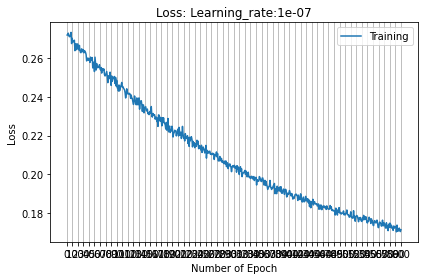

In [16]:
torch.cuda.empty_cache()
import gc; gc.collect()
# ic.enable()
ic.disable()

train_epoch_loss = []
test_epoch_loss = []

for e in tqdm(range(1, epoch+1)):
    model.train()
    train_batch_loss = []
    test_batch_loss = []
    # print(f'Epoch {e}')
    for x_train, y_train in train_loader:
        x_batch = torch.squeeze(x_train, 0).to(device)
        y_batch = y_train.to(device)
        x_batch = x_batch.float()
        pred = model(x_batch.float())
        loss_train = criterion(pred,y_batch)
        train_batch_loss.append(loss_train)        
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        # scheduler.step()  # Update the learning rate


    train_epoch_loss.append(torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy())
    model.eval()
    with torch.no_grad():
        # print('>> test')
        for x_test, y_test in test_loader:
            x_batch = torch.squeeze(x_test, 0).to(device)
            x_batch = x_batch.float()
            y_batch = y_test.to(device)
            # print(x_batch.size())
            # y_batch = torch.Tensor.float(y).to(device)
            # x_batch = x_batch.permute(0, 3, 1, 2).to(device)
            pred = model(x_batch.float())

            # pred = pred.unsqueeze(0)
            # print(pred[:10])
            # print(y_batch[:10])

            loss_test = criterion(pred,y_batch)
            test_batch_loss.append(loss_test)
        test_epoch_loss.append(torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy())

    print(f'Epoch {e}')
    print(f"Training loss: {torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy()}")
    print(f"Validation loss: {torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy()}") 
    # scheduler.step(torch.mean(torch.stack(test_batch_loss)))
    # print(train_batch_loss)
    # print(test_batch_loss)
    # print(f"Training loss: {np.mean(train_batch_loss)}")
    # print(f"Validation loss: {np.mean(test_batch_loss)}")
    # #! implementing early stopping
    # current_val_loss = torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy()
    # print(f'Current val loss: {current_val_loss}')
    # print(f'Best val loss: {best_val_loss}')
    # if current_val_loss < best_val_loss:
    #     best_val_loss = current_val_loss
    #     patience_counter = 0  # reset patience counter
    #     # Save the best model
    #     # torch.save(model.state_dict(), '/mnt/storageG1/lwang/Projects/tb_dr_MIC/saved_models/aa-model_final.pth')

    # else:
    #     patience_counter += 1
    #     if patience_counter >= patience:
    #         print("Early stopping triggered")
    #         torch.save({
    #         'optimizer': optimizer.state_dict(),
    #         'model': model.state_dict(),
    #     }, '/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/saved_models/aa-model_weighted_balanced_binned_aa_newdata.pth')
    #         break  # Early stopping
        
print('==='*10)
# torch.save(model.state_dict(), '/mnt/storageG1/lwang/Projects/tb_dr_MIC/saved_models/final_seq_model1-44ep.pt')
save_to_file('trials3.txt', 'aa-training_weighted_balanced_mae-binned-rif_newdata-step100-0.8' ,epoch, lr=1e-7, fcdr=0.4, l2=1e-8, cnndr=0.05, train_loss = train_epoch_loss, test_loss = test_epoch_loss)

fig, ax = plt.subplots()
x = np.arange(1, epoch+1, 1)
ax.plot(x, train_epoch_loss,label='Training')
# ax.plot(x, test_epoch_loss,label='Validation')
ax.legend()
ax.set_xlabel("Number of Epoch")
ax.set_ylabel("Loss")
ax.set_xticks(np.arange(0, epoch+1, 10))
ax.set_title(f'Loss: Learning_rate:{lr}')
# ax_2 = ax.twinx()
# ax_2.plot(history["lr"], "k--", lw=1)
# ax_2.set_yscale("log")
# ax.set_ylim(ax.get_ylim()[0], history["training_losses"][0])
ax.grid(axis="x")
fig.tight_layout()
fig.show()
fig.savefig(f'./graphs1/aa-loss_lr_{lr}_weighted_balanced.png')
print(f'./graphs1/aa-loss_lr_{lr}_weighted_balanced.png')

# torch.save({
#     'optimizer': optimizer.state_dict(),
#     'model': model.state_dict(),
# }, '/mnt/storageG1/lwang/Projects/tb_dr_MIC/saved_models/seq-{appendix}-{epoch}-{lr}-{cnndr}-{fcdr}-{l2}.pth')

./graphs1/loss_lr_0.0001.png


/tmp/ipykernel_48980/4118118722.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


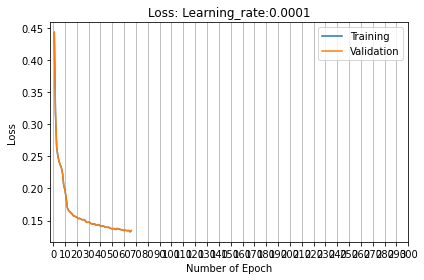

In [ ]:

fig, ax = plt.subplots(facecolor = 'white')
x = np.arange(1, len(np.array(train_epoch_loss).flatten())+1, 1)
ax.plot(x, np.array(train_epoch_loss).flatten(),label='Training')
ax.plot(x, np.array(train_epoch_loss).flatten(),label='Validation')
ax.legend()
ax.set_xlabel("Number of Epoch")
ax.set_ylabel("Loss")
ax.set_xticks(np.arange(0, epoch+1, 10))
ax.set_title(f'Loss: Learning_rate:{lr}')
# ax_2 = ax.twinx()
# ax_2.plot(history["lr"], "k--", lw=1)
# ax_2.set_yscale("log")
# ax.set_ylim(ax.get_ylim()[0], history["training_losses"][0])
ax.grid(axis="x")
fig.tight_layout()
fig.show()
fig.savefig(f'./graphs1/loss_lr_{lr}_long.png')
print(f'./graphs1/loss_lr_{lr}.png')

## AUC

NameError: name 'cnn_dr' is not defined

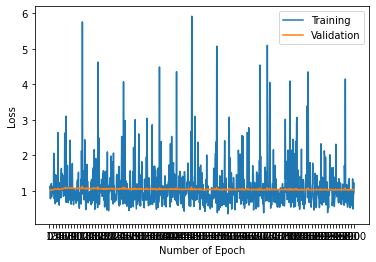

In [ ]:
fig, ax = plt.subplots(facecolor = 'white')
x = np.arange(1, epoch+1, 1)
ax.plot(x, train_epoch_loss,label='Training')
ax.plot(x, test_epoch_loss,label='Validation')
ax.legend()
ax.set_xlabel("Number of Epoch")
ax.set_ylabel("Loss")
ax.set_xticks(np.arange(0, epoch+1, 10))
ax.set_title(f'Loss: Learning_rate:{lr}, cnn_dr:{cnn_dr}, cnn_dr:{fc_dr}')
# ax_2 = ax.twinx()
# ax_2.plot(history["lr"], "k--", lw=1)
# ax_2.set_yscale("log")
# ax.set_ylim(ax.get_ylim()[0], history["training_losses"][0])
ax.grid(axis="x")
fig.tight_layout()
fig.show()

In [ ]:
test_dataset = OneHotSeqsDataset(test_data, test_target, one_hot_dtype=torch.float)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, collate_fn=collate_padded_batch ,num_workers=8)

In [ ]:
torch.cuda.empty_cache()
import gc; gc.collect()
# ic.enable()
ic.disable()

model.load_state_dict(torch.load('saved_weights/training_torch_simple_mask_copy_split_model_128f64n-spe30-rand5-100e'))

output = []
model.eval()
with torch.no_grad():

    for x, y in test_loader:
        x_batch = torch.squeeze(x, 0).to(device)
        y_batch = y.to(device)
        x_batch = x_batch.float()
        y_batch = y_batch.float()
        pred = model(x_batch.float())
        output.append(pred)
        
original_value_output = np.exp(output)

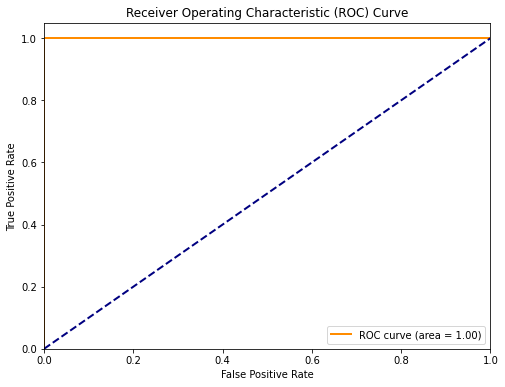

AUC Score: 1.0


In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

def calculate_auc(labels, scores):
    """
    Calculate the Area Under the Receiver Operating Characteristic Curve (AUC)
    given true binary labels and prediction scores.
    
    :param labels: List of true binary labels (0 or 1).
    :param scores: List of prediction scores (probabilities or continuous output of the model).
    :return: AUC score.
    """
    auc_score = roc_auc_score(labels, scores)
    
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(labels, scores)
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return auc_score

# Example usage
true_labels = [0, 1, 1, 0, 1]  # True binary labels
prediction_scores = [0.1, 0.4, 0.8, 0.3, 0.7]  # Prediction scores or probabilities

auc_score = calculate_auc(true_labels, prediction_scores)
print(f"AUC Score: {auc_score}")

# testing out hyper-parameters

In [ ]:
import subprocess

def run_bash_command(command):
    """
    Runs a bash command and returns its output.
    
    :param command: The command to run as a string.
    :return: A tuple containing the command's stdout and stderr.
    """
    try:
        # Run command
        result = subprocess.run(command, shell=True, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
        
        # Return stdout and stderr
        return result.stdout, result.stderr
    except subprocess.CalledProcessError as e:
        # Handle errors in the called executable
        return e.stdout, e.stderr
    except Exception as e:
        # Handle other errors related to subprocess.run()
        return None, str(e)

# Example usage
stdout, stderr = run_bash_command('nvidia-smi')
print('STDOUT:', stdout)
print('STDERR:', stderr)

# Example of a command that generates an error
stdout, stderr = run_bash_command('ls non_existent_file')
print('STDOUT:', stdout)
print('STDERR:', stderr)

STDOUT: Wed Mar 27 14:12:50 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 455.32.00    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:41:00.0 Off |                    0 |
| N/A   37C    P0    36W / 250W |   1221MiB / 32510MiB |     37%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               


In [ ]:

def find_range_vectorized(target_values, quest_values):
    # Convert lists to numpy arrays for efficient broadcasting
    target_values =  np.exp(np.array(target_values)) # Reshape for broadcasting
    quest_values =  np.exp(np.array(quest_values))

    # Perform broadcasting to compare each quest value against all target values
    # This creates a boolean matrix where rows correspond to target values and columns to quest values
    in_range_matrix = (target_values / 2 <= quest_values) & (quest_values <= target_values * 2)
    # in_range_matrix = np.abs(np.log2(target_values) - np.log2(quest_values))
    # in_range_matrix  = in_range_matrix  <= 1
    
    # print(mse)
    return in_range_matrix
# Example usage
# target_values = [[10, 20, 30, 40, 50], [10, 20, 30, 40, 50]]
# quest_values = [[25, 5, 60, 1, 1], [10, 20, 30, 40, 50]]

def save_to_file(file_path, appendix, epoch, lr, cnndr, fcdr, l2, train_loss, test_loss):
    train_loss = [float(arr) for arr in train_loss]
    test_loss = [float(arr) for arr in test_loss]
    with open(file_path, "a") as f:
        f.write(f">> {appendix}, Epoch: {epoch}, LR: {lr}, cnnDR: {cnndr},  fnDR: {fcdr}, l2decay: {l2}\n")
        f.write(f"--- Train Loss: {train_loss}\n")
        f.write(f"--- Test Loss: {test_loss}\n")
        
def hyper_params_test(appendix, lr, fc_dr=0,cnn_dr=0, l2=0, epoch=50):
    print('lr:', lr, '| fc_dr:',  fc_dr, '| cnn_dr:', cnn_dr, '| l2:', l2, '==='*10)
    torch.cuda.empty_cache()
    import gc; gc.collect()
    ic.disable()
    
    # stdout, stderr = run_bash_command('nvidia-smi')
    # print('STDOUT:', stdout)
    # print('STDERR:', stderr)
    # model = Model(
    # num_classes=13,
    # num_filters=128,a
    # num_conv_layers=2,
    # num_dense_neurons=64, # batch_size = 64
    # num_dense_layers=2,
    # return_logits=True,
    # dense_dropout_rate=fc_dr,
    # conv_dropout_rate=cnn_dr
    # ).to(device)
    
    model = Model(
    num_classes=3,
    num_filters=64,
    num_conv_layers=2,
    num_dense_neurons=256, # batch_size = 64
    # num_dense_neurons=128, # batch_size = 64
    num_dense_layers=2,
    return_logits=True,
    conv_dropout_rate=cnn_dr,
    dense_dropout_rate=fc_dr
    ).to(device)

    # stdout, stderr = run_bash_command('nvidia-smi')
    # print('STDOUT:', stdout)
    # print('STDERR:', stderr)
    
    epoch = epoch
    batch_size = 128
    lr = lr

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True ,num_workers=8, drop_last=True)
    test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, num_workers=8, shuffle=True, drop_last=True)
    # criterion = nn.MSELoss()
    criterion = weighted_cross_entropy_loss_fn
    # criterion = F.cross_entropy
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
    # optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbose=True)
    
    ic.disable()
    # ic.enable()
    train_epoch_loss = []
    test_epoch_loss = []

    
    for e in tqdm(range(1, epoch+1)):
        model.train()
        train_batch_loss = []
        test_batch_loss = []
        # print(f'Epoch {e}')
        for x_train, y_train in train_loader:
            x_batch = torch.squeeze(x_train, 0).to(device)
            y_batch = y_train.to(device)
            x_batch = x_batch.float()
            pred = model(x_batch.float())
            # print(pred)
            loss_train = criterion(pred, y_batch)
            # print(y_batch)
            train_batch_loss.append(loss_train)        
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()

        train_epoch_loss.append(torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy())
        model.eval()
        with torch.no_grad():
            # print('>> test')
            for x_test, y_test in test_loader:
                x_batch = torch.squeeze(x_test, 0).to(device)
                x_batch = x_batch.float()
                # if np.isnan(y_batch):
                #     continue
                # print(x_batch.size())
                y_batch = y_test.to(device)
                # x_batch = x_batch.permute(0, 3, 1, 2).to(device)
                pred = model(x_batch.float())

                # pred = pred.unsqueeze(0)
                # print(pred[:10])
                # print(y_batch[:10])

                loss_test = criterion(pred, y_batch)
                test_batch_loss.append(loss_test)
            test_epoch_loss.append(torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy())

        print(f'Epoch {e}')
        print(f"Training loss: {torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy()}")
        print(f"Validation loss: {torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy()}") 
    
     #! testing benchmark
    # testing_dataset = Dataset(test_data, test_target, one_hot_dtype=torch.float, transform=True)
    # testing_loader1 = DataLoader(dataset=testing_dataset, batch_size=1, collate_fn=collate_padded_batch, num_workers=8, shuffle=True, drop_last=True)
    # drugs = ['AMI', 'BDQ', 'CFZ', 'DLM', 'EMB', 'ETH', 'INH', 'KAN', 'LEV', 'LZD', 'MXF', 'RIF', 'RFB']
    # drugs = ['AMI_MIC','EMB_MIC', 'INH_MIC', 'KAN_MIC', 'RIF_MIC', 'RFB_MIC']

    # model.eval()
    # pred_list = []
    # target_list = []
    # mse_list = []
    # with torch.no_grad():
    #     for x_test, y_test in testing_loader1:
    #         xtest1 = x_test.to(device).float()
    #         ytest1 = y_test.to(device).float()
    #         pred = model(xtest1)
    #         pred_list.append(pred.detach().cpu().numpy()) 
    #         target_list.append(y_test.detach().cpu().numpy())

    # pred_list = np.array(pred_list).squeeze()
    # target_list = np.array(target_list).squeeze()
    # mse_list = (pred_list - target_list)**2
    # mse_out = np.nanmean(mse_list, axis=0)

    # result = find_range_vectorized(target_list, pred_list)

    # # Append output to a file
    # with open('trials3.txt', 'a') as f:
    #     mse_drug_output = f"====MIC-mse: {drugs} {np.mean(mse_out)}\n"
    #     f.write(mse_drug_output)        
    #     ea_accuracy_output = f"====EA-accuracy: {drugs} {np.nanmean(result, axis=0)}\n"
    #     f.write(ea_accuracy_output)
    #     print(mse_drug_output)
    #     print(ea_accuracy_output)
    #     # for x, y in zip(drugs, np.nanmean(result, axis=0).tolist()):
    #     #     print(x, y)                    
            
        # fig, ax = plt.subplots()
        # x = np.arange(1, epoch+1, 1)
        # ax.plot(x, train_epoch_loss,label='Training')
        # # ax.plot(x, test_epoch_loss,label='Validation')
        # ax.legend()
        # ax.set_xlabel("Number of Epoch")
        # ax.set_ylabel("Loss")
        # ax.set_xticks(np.arange(0, epoch+1, 10))
        # ax.set_title(f'Loss: Learning_rate:{lr}')
        # # ax_2 = ax.twinx()
        # # ax_2.plot(history["lr"], "k--", lw=1)
        # # ax_2.set_yscale("log")
        # # ax.set_ylim(ax.get_ylim()[0], history["training_losses"][0])
        # ax.grid(axis="x")
        # fig.tight_layout()
        # fig.show()
        # fig.savefig(f'./graphs1/aa-loss_lr_{lr}_weighted_balanced.png')
        # print(f'./graphs1/aa-loss_lr_{lr}_weighted_balanced.png')
    save_to_file('trials3.txt', appendix ,epoch, lr, cnn_dr, fc_dr, l2, train_epoch_loss, test_epoch_loss)

    torch.save({
    'optimizer': optimizer.state_dict(),
    'model': model.state_dict(),
}, f'/mnt/storageG1/lwang/Projects/tb_dr_MIC/saved_models/{appendix}-{epoch}-{lr}-{cnn_dr}-{fc_dr}-{l2}_balanced-rif-bi-ag-ce.pth')

In [ ]:
torch.cuda.empty_cache()
import gc; gc.collect()

# epoch = 250
# for lr in [1e-4]:
#     for fc_dr in [0.2]:
#         for decay in [1e-9]:
#             for cnn_dr in [0.2, 0.3, 0.4, 0.5]:
#                 hyper_params_test('64-2-256-2-128-log-reg-weighted_balanced', lr, cnn_dr = 0, fc_dr=fc_dr, l2=decay, epoch=epoch)

epoch = 300
for lr in [1e-7]:
    for fc_dr in [0.2]:
        for decay in [1e-8, 1e-5]:
            hyper_params_test('aa-64-2-256-2-128-log-reg-weighted_balanced-rif-new-hml3', lr, cnn_dr = 0, fc_dr=fc_dr, l2=decay, epoch=epoch)
# epoch = 44
# for lr in [1e-4]:
#     for fc_dr in [0.4]:
#         for cnn_dr in [0.4]:
#             for decay in [1e-8]:
#                 hyper_params_test('final_model', lr, fc_dr=fc_dr, cnn_dr=cnn_dr, l2=decay, epoch=epoch)

# epoch = 50
# for lr in [1e-4]:
#     for fc_dr in [0.4]:
#         for cnn_dr in [0, 0.2, 0.3, 0.4, 0.5]:
#             for decay in [1e-8]:
#                 hyper_params_test('64-2-256-2-128-log-reg', lr, fc_dr=fc_dr, cnn_dr=cnn_dr, l2=decay, epoch=epoch)

lr: 1e-07 | fc_dr: 0.2 | cnn_dr: 0 | l2: 1e-09 ==============================


  0%|          | 1/300 [00:09<47:17,  9.49s/it]

Epoch 1
Training loss: 0.29233646392822266
Validation loss: 0.23652343451976776


  1%|          | 2/300 [00:18<47:10,  9.50s/it]

Epoch 2
Training loss: 0.28938207030296326
Validation loss: 0.25481200218200684


  1%|          | 3/300 [00:28<46:59,  9.49s/it]

Epoch 3
Training loss: 0.289146363735199
Validation loss: 0.25564485788345337


  1%|▏         | 4/300 [00:38<46:55,  9.51s/it]

Epoch 4
Training loss: 0.2854325473308563
Validation loss: 0.2557322084903717


  2%|▏         | 5/300 [00:47<46:45,  9.51s/it]

Epoch 5
Training loss: 0.28255680203437805
Validation loss: 0.25529956817626953


  2%|▏         | 6/300 [00:57<46:34,  9.50s/it]

Epoch 6
Training loss: 0.2764677107334137
Validation loss: 0.25333842635154724


  2%|▏         | 7/300 [01:06<46:23,  9.50s/it]

Epoch 7
Training loss: 0.27262961864471436
Validation loss: 0.2536778151988983


  3%|▎         | 8/300 [01:16<46:15,  9.51s/it]

Epoch 8
Training loss: 0.27280566096305847
Validation loss: 0.24962404370307922


  3%|▎         | 9/300 [01:25<46:07,  9.51s/it]

Epoch 9
Training loss: 0.2662404775619507
Validation loss: 0.2480602264404297


  3%|▎         | 10/300 [01:35<45:53,  9.49s/it]

Epoch 10
Training loss: 0.26826637983322144
Validation loss: 0.24708591401576996


  4%|▎         | 11/300 [01:44<45:43,  9.49s/it]

Epoch 11
Training loss: 0.2662784457206726
Validation loss: 0.24605290591716766


  4%|▍         | 12/300 [01:53<45:29,  9.48s/it]

Epoch 12
Training loss: 0.2637614905834198
Validation loss: 0.24487987160682678


  4%|▍         | 13/300 [02:03<45:19,  9.48s/it]

Epoch 13
Training loss: 0.26200219988822937
Validation loss: 0.24281635880470276


  5%|▍         | 14/300 [02:12<45:07,  9.47s/it]

Epoch 14
Training loss: 0.26118341088294983
Validation loss: 0.24048805236816406


  5%|▌         | 15/300 [02:22<45:04,  9.49s/it]

Epoch 15
Training loss: 0.25804704427719116
Validation loss: 0.2381085455417633


  5%|▌         | 16/300 [02:31<44:56,  9.49s/it]

Epoch 16
Training loss: 0.2555217742919922
Validation loss: 0.2385827600955963


  6%|▌         | 17/300 [02:41<44:51,  9.51s/it]

Epoch 17
Training loss: 0.2516549527645111
Validation loss: 0.23617947101593018


  6%|▌         | 18/300 [02:50<44:41,  9.51s/it]

Epoch 18
Training loss: 0.2523961067199707
Validation loss: 0.23574240505695343


  6%|▋         | 19/300 [03:00<44:35,  9.52s/it]

Epoch 19
Training loss: 0.2516193389892578
Validation loss: 0.23809218406677246


  7%|▋         | 20/300 [03:10<44:23,  9.51s/it]

Epoch 20
Training loss: 0.24857264757156372
Validation loss: 0.23600204288959503


  7%|▋         | 21/300 [03:19<44:12,  9.51s/it]

Epoch 21
Training loss: 0.24601541459560394
Validation loss: 0.23585395514965057


  7%|▋         | 22/300 [03:28<44:02,  9.50s/it]

Epoch 22
Training loss: 0.24823778867721558
Validation loss: 0.23609404265880585


  8%|▊         | 23/300 [03:38<43:46,  9.48s/it]

Epoch 23
Training loss: 0.24193237721920013
Validation loss: 0.23240463435649872


  8%|▊         | 24/300 [03:47<43:34,  9.47s/it]

Epoch 24
Training loss: 0.2433067262172699
Validation loss: 0.2311335802078247


  8%|▊         | 25/300 [03:57<43:18,  9.45s/it]

Epoch 25
Training loss: 0.24107302725315094
Validation loss: 0.23275123536586761


  9%|▊         | 26/300 [04:06<43:11,  9.46s/it]

Epoch 26
Training loss: 0.23897014558315277
Validation loss: 0.22822745144367218


  9%|▉         | 27/300 [04:16<43:06,  9.47s/it]

Epoch 27
Training loss: 0.23878543078899384
Validation loss: 0.22892020642757416


  9%|▉         | 28/300 [04:25<42:58,  9.48s/it]

Epoch 28
Training loss: 0.23526933789253235
Validation loss: 0.23110409080982208


 10%|▉         | 29/300 [04:35<42:51,  9.49s/it]

Epoch 29
Training loss: 0.23670046031475067
Validation loss: 0.23111334443092346


 10%|█         | 30/300 [04:44<42:44,  9.50s/it]

Epoch 30
Training loss: 0.2329636514186859
Validation loss: 0.22932398319244385


 10%|█         | 31/300 [04:54<42:33,  9.49s/it]

Epoch 31
Training loss: 0.23021923005580902
Validation loss: 0.22955575585365295


 11%|█         | 32/300 [05:03<42:22,  9.49s/it]

Epoch 32
Training loss: 0.22948014736175537
Validation loss: 0.22881992161273956


 11%|█         | 33/300 [05:13<42:11,  9.48s/it]

Epoch 33
Training loss: 0.23060140013694763
Validation loss: 0.22769795358181


 11%|█▏        | 34/300 [05:22<42:00,  9.48s/it]

Epoch 34
Training loss: 0.23124170303344727
Validation loss: 0.22443898022174835


 12%|█▏        | 35/300 [05:32<41:49,  9.47s/it]

Epoch 35
Training loss: 0.22871051728725433
Validation loss: 0.2260712832212448


 12%|█▏        | 36/300 [05:41<41:43,  9.48s/it]

Epoch 36
Training loss: 0.22533726692199707
Validation loss: 0.22460699081420898


 12%|█▏        | 37/300 [05:51<41:37,  9.50s/it]

Epoch 37
Training loss: 0.2255226969718933
Validation loss: 0.22452230751514435


 13%|█▎        | 38/300 [06:00<41:28,  9.50s/it]

Epoch 38
Training loss: 0.22321327030658722
Validation loss: 0.22375833988189697


 13%|█▎        | 39/300 [06:10<41:12,  9.47s/it]

Epoch 39
Training loss: 0.22342021763324738
Validation loss: 0.22121313214302063


 13%|█▎        | 40/300 [06:19<41:06,  9.49s/it]

Epoch 40
Training loss: 0.2202385514974594
Validation loss: 0.2209969013929367


 14%|█▎        | 41/300 [06:29<40:56,  9.48s/it]

Epoch 41
Training loss: 0.2179585099220276
Validation loss: 0.22323130071163177


 14%|█▍        | 42/300 [06:38<40:47,  9.49s/it]

Epoch 42
Training loss: 0.22175699472427368
Validation loss: 0.22333191335201263


 14%|█▍        | 43/300 [06:48<40:40,  9.49s/it]

Epoch 43
Training loss: 0.21700720489025116
Validation loss: 0.22338728606700897


 15%|█▍        | 44/300 [06:57<40:32,  9.50s/it]

Epoch 44
Training loss: 0.21954166889190674
Validation loss: 0.2156386375427246


 15%|█▌        | 45/300 [07:07<40:21,  9.50s/it]

Epoch 45
Training loss: 0.21435537934303284
Validation loss: 0.2210705578327179


 15%|█▌        | 46/300 [07:16<40:09,  9.49s/it]

Epoch 46
Training loss: 0.2132672518491745
Validation loss: 0.21781353652477264


 16%|█▌        | 47/300 [07:26<40:01,  9.49s/it]

Epoch 47
Training loss: 0.21399667859077454
Validation loss: 0.22078268229961395


 16%|█▌        | 48/300 [07:35<39:52,  9.49s/it]

Epoch 48
Training loss: 0.21442727744579315
Validation loss: 0.2165510207414627


 16%|█▋        | 49/300 [07:45<39:43,  9.50s/it]

Epoch 49
Training loss: 0.21321095526218414
Validation loss: 0.216000035405159


 17%|█▋        | 50/300 [07:54<39:32,  9.49s/it]

Epoch 50
Training loss: 0.2113257199525833
Validation loss: 0.2150496542453766


 17%|█▋        | 51/300 [08:03<39:18,  9.47s/it]

Epoch 51
Training loss: 0.2115398496389389
Validation loss: 0.217756986618042


 17%|█▋        | 52/300 [08:13<39:09,  9.48s/it]

Epoch 52
Training loss: 0.2085505872964859
Validation loss: 0.216949462890625


 18%|█▊        | 53/300 [08:22<39:02,  9.48s/it]

Epoch 53
Training loss: 0.20663051307201385
Validation loss: 0.21949830651283264


 18%|█▊        | 54/300 [08:32<38:55,  9.49s/it]

Epoch 54
Training loss: 0.20799733698368073
Validation loss: 0.2154684066772461


 18%|█▊        | 55/300 [08:41<38:46,  9.50s/it]

Epoch 55
Training loss: 0.2047392576932907
Validation loss: 0.2171403467655182


 19%|█▊        | 56/300 [08:51<38:39,  9.51s/it]

Epoch 56
Training loss: 0.20564419031143188
Validation loss: 0.21793973445892334


 19%|█▉        | 57/300 [09:00<38:26,  9.49s/it]

Epoch 57
Training loss: 0.20266491174697876
Validation loss: 0.21617718040943146


 19%|█▉        | 58/300 [09:10<38:14,  9.48s/it]

Epoch 58
Training loss: 0.20357008278369904
Validation loss: 0.21097087860107422


 20%|█▉        | 59/300 [09:19<38:07,  9.49s/it]

Epoch 59
Training loss: 0.20312950015068054
Validation loss: 0.21432732045650482


 20%|██        | 60/300 [09:29<37:58,  9.49s/it]

Epoch 60
Training loss: 0.1991070657968521
Validation loss: 0.2114991694688797


 20%|██        | 61/300 [09:38<37:50,  9.50s/it]

Epoch 61
Training loss: 0.20009635388851166
Validation loss: 0.21460223197937012


 21%|██        | 62/300 [09:48<37:40,  9.50s/it]

Epoch 62
Training loss: 0.20027711987495422
Validation loss: 0.21490636467933655


 21%|██        | 63/300 [09:57<37:31,  9.50s/it]

Epoch 63
Training loss: 0.19921934604644775
Validation loss: 0.21430189907550812


 21%|██▏       | 64/300 [10:07<37:21,  9.50s/it]

Epoch 64
Training loss: 0.1970897763967514
Validation loss: 0.21266336739063263


 22%|██▏       | 65/300 [10:16<37:13,  9.50s/it]

Epoch 65
Training loss: 0.19539578258991241
Validation loss: 0.21180160343647003


 22%|██▏       | 66/300 [10:26<37:01,  9.49s/it]

Epoch 66
Training loss: 0.1946137547492981
Validation loss: 0.21241112053394318


 22%|██▏       | 67/300 [10:35<36:48,  9.48s/it]

Epoch 67
Training loss: 0.19490079581737518
Validation loss: 0.21087943017482758


 23%|██▎       | 68/300 [10:45<36:41,  9.49s/it]

Epoch 68
Training loss: 0.1942351907491684
Validation loss: 0.21076829731464386


 23%|██▎       | 69/300 [10:54<36:31,  9.48s/it]

Epoch 69
Training loss: 0.19425779581069946
Validation loss: 0.20975899696350098


 23%|██▎       | 70/300 [11:04<36:21,  9.48s/it]

Epoch 70
Training loss: 0.1916464865207672
Validation loss: 0.21140018105506897


 24%|██▎       | 71/300 [11:13<36:09,  9.47s/it]

Epoch 71
Training loss: 0.19285769760608673
Validation loss: 0.21275368332862854


 24%|██▍       | 72/300 [11:23<36:01,  9.48s/it]

Epoch 72
Training loss: 0.19066432118415833
Validation loss: 0.20944057404994965


 24%|██▍       | 73/300 [11:32<35:55,  9.50s/it]

Epoch 73
Training loss: 0.19112078845500946
Validation loss: 0.21089307963848114


 25%|██▍       | 74/300 [11:42<35:39,  9.47s/it]

Epoch 74
Training loss: 0.19023968279361725
Validation loss: 0.2094128578901291


 25%|██▌       | 75/300 [11:51<35:28,  9.46s/it]

Epoch 75
Training loss: 0.19029951095581055
Validation loss: 0.20672455430030823


 25%|██▌       | 76/300 [12:01<35:16,  9.45s/it]

Epoch 76
Training loss: 0.18986985087394714
Validation loss: 0.20919011533260345


 26%|██▌       | 77/300 [12:10<35:09,  9.46s/it]

Epoch 77
Training loss: 0.19074805080890656
Validation loss: 0.20941507816314697


 26%|██▌       | 78/300 [12:20<35:04,  9.48s/it]

Epoch 78
Training loss: 0.18691155314445496
Validation loss: 0.2089744657278061


 26%|██▋       | 79/300 [12:29<34:56,  9.49s/it]

Epoch 79
Training loss: 0.1873486191034317
Validation loss: 0.2090195268392563


 27%|██▋       | 80/300 [12:39<34:46,  9.48s/it]

Epoch 80
Training loss: 0.18619254231452942
Validation loss: 0.20906637609004974


 27%|██▋       | 81/300 [12:48<34:38,  9.49s/it]

Epoch 81
Training loss: 0.186814546585083
Validation loss: 0.2106279879808426


 27%|██▋       | 82/300 [12:58<34:28,  9.49s/it]

Epoch 82
Training loss: 0.18421998620033264
Validation loss: 0.20881953835487366


 28%|██▊       | 83/300 [13:07<34:21,  9.50s/it]

Epoch 83
Training loss: 0.18481557071208954
Validation loss: 0.20748530328273773


 28%|██▊       | 84/300 [13:17<34:10,  9.49s/it]

Epoch 84
Training loss: 0.18415158987045288
Validation loss: 0.20646320283412933


 28%|██▊       | 85/300 [13:26<34:03,  9.50s/it]

Epoch 85
Training loss: 0.18239039182662964
Validation loss: 0.2075631469488144


 29%|██▊       | 86/300 [13:36<33:53,  9.50s/it]

Epoch 86
Training loss: 0.18075715005397797
Validation loss: 0.2090088576078415


 29%|██▉       | 87/300 [13:45<33:42,  9.50s/it]

Epoch 87
Training loss: 0.1825658082962036
Validation loss: 0.20908556878566742


 29%|██▉       | 88/300 [13:55<33:29,  9.48s/it]

Epoch 88
Training loss: 0.17994865775108337
Validation loss: 0.20519356429576874


 30%|██▉       | 89/300 [14:04<33:19,  9.48s/it]

Epoch 89
Training loss: 0.18146993219852448
Validation loss: 0.20336656272411346


 30%|███       | 90/300 [14:13<33:11,  9.49s/it]

Epoch 90
Training loss: 0.17851656675338745
Validation loss: 0.20729728043079376


 30%|███       | 91/300 [14:23<33:03,  9.49s/it]

Epoch 91
Training loss: 0.17994394898414612
Validation loss: 0.20545044541358948


 31%|███       | 92/300 [14:33<32:56,  9.50s/it]

Epoch 92
Training loss: 0.17928090691566467
Validation loss: 0.2070738822221756


 31%|███       | 93/300 [14:42<32:45,  9.50s/it]

Epoch 93
Training loss: 0.17829039692878723
Validation loss: 0.20735648274421692


 31%|███▏      | 94/300 [14:51<32:36,  9.50s/it]

Epoch 94
Training loss: 0.176547572016716
Validation loss: 0.20441384613513947


 32%|███▏      | 95/300 [15:01<32:23,  9.48s/it]

Epoch 95
Training loss: 0.17691433429718018
Validation loss: 0.2058045119047165


 32%|███▏      | 96/300 [15:10<32:15,  9.49s/it]

Epoch 96
Training loss: 0.1755412220954895
Validation loss: 0.207039937376976


 32%|███▏      | 97/300 [15:20<32:04,  9.48s/it]

Epoch 97
Training loss: 0.17657169699668884
Validation loss: 0.20624695718288422


 33%|███▎      | 98/300 [15:29<31:53,  9.47s/it]

Epoch 98
Training loss: 0.1743699312210083
Validation loss: 0.20319943130016327


 33%|███▎      | 99/300 [15:39<31:45,  9.48s/it]

Epoch 99
Training loss: 0.17556388676166534
Validation loss: 0.20430265367031097


 33%|███▎      | 100/300 [15:48<31:35,  9.48s/it]

Epoch 100
Training loss: 0.17343202233314514
Validation loss: 0.20277224481105804


 34%|███▎      | 101/300 [15:58<31:25,  9.47s/it]

Epoch 101
Training loss: 0.17448380589485168
Validation loss: 0.20295484364032745


 34%|███▍      | 102/300 [16:07<31:13,  9.46s/it]

Epoch 102
Training loss: 0.1713092178106308
Validation loss: 0.20244793593883514


 34%|███▍      | 103/300 [16:17<31:06,  9.47s/it]

Epoch 103
Training loss: 0.16983366012573242
Validation loss: 0.20474477112293243


 35%|███▍      | 104/300 [16:26<30:57,  9.48s/it]

Epoch 104
Training loss: 0.17322182655334473
Validation loss: 0.20153065025806427


 35%|███▌      | 105/300 [16:36<30:47,  9.47s/it]

Epoch 105
Training loss: 0.1709388941526413
Validation loss: 0.20264258980751038


 35%|███▌      | 106/300 [16:45<30:36,  9.47s/it]

Epoch 106
Training loss: 0.1707792431116104
Validation loss: 0.2019682377576828


 36%|███▌      | 107/300 [16:55<30:31,  9.49s/it]

Epoch 107
Training loss: 0.16929520666599274
Validation loss: 0.20152325928211212


 36%|███▌      | 108/300 [17:04<30:21,  9.49s/it]

Epoch 108
Training loss: 0.16958783566951752
Validation loss: 0.19955997169017792


 36%|███▋      | 109/300 [17:14<30:11,  9.48s/it]

Epoch 109
Training loss: 0.1670568585395813
Validation loss: 0.19692909717559814


 37%|███▋      | 110/300 [17:23<30:01,  9.48s/it]

Epoch 110
Training loss: 0.1682317703962326
Validation loss: 0.20314176380634308


 37%|███▋      | 111/300 [17:33<29:52,  9.49s/it]

Epoch 111
Training loss: 0.16805200278759003
Validation loss: 0.20054347813129425


 37%|███▋      | 112/300 [17:42<29:43,  9.49s/it]

Epoch 112
Training loss: 0.16842550039291382
Validation loss: 0.20261548459529877


 38%|███▊      | 113/300 [17:52<29:35,  9.49s/it]

Epoch 113
Training loss: 0.1673513650894165
Validation loss: 0.2037675380706787


 38%|███▊      | 114/300 [18:01<29:28,  9.51s/it]

Epoch 114
Training loss: 0.16733905673027039
Validation loss: 0.20073428750038147


 38%|███▊      | 115/300 [18:11<29:17,  9.50s/it]

Epoch 115
Training loss: 0.1651533544063568
Validation loss: 0.202614888548851


 39%|███▊      | 116/300 [18:20<29:07,  9.50s/it]

Epoch 116
Training loss: 0.16624251008033752
Validation loss: 0.20183221995830536


 39%|███▉      | 117/300 [18:30<28:56,  9.49s/it]

Epoch 117
Training loss: 0.16383706033229828
Validation loss: 0.20019443333148956


 39%|███▉      | 118/300 [18:39<28:48,  9.50s/it]

Epoch 118
Training loss: 0.1661112904548645
Validation loss: 0.19894389808177948


 40%|███▉      | 119/300 [18:49<28:39,  9.50s/it]

Epoch 119
Training loss: 0.16563062369823456
Validation loss: 0.20057182013988495


 40%|████      | 120/300 [18:58<28:30,  9.50s/it]

Epoch 120
Training loss: 0.16323810815811157
Validation loss: 0.19813130795955658


 40%|████      | 121/300 [19:08<28:21,  9.51s/it]

Epoch 121
Training loss: 0.16423381865024567
Validation loss: 0.1990356296300888


 41%|████      | 122/300 [19:17<28:13,  9.52s/it]

Epoch 122
Training loss: 0.16245022416114807
Validation loss: 0.19917814433574677


 41%|████      | 123/300 [19:27<28:02,  9.50s/it]

Epoch 123
Training loss: 0.1614282876253128
Validation loss: 0.19884657859802246


 41%|████▏     | 124/300 [19:36<27:49,  9.49s/it]

Epoch 124
Training loss: 0.1641928106546402
Validation loss: 0.20216193795204163


 42%|████▏     | 125/300 [19:46<27:40,  9.49s/it]

Epoch 125
Training loss: 0.1615295559167862
Validation loss: 0.20065689086914062


 42%|████▏     | 126/300 [19:55<27:29,  9.48s/it]

Epoch 126
Training loss: 0.16163422167301178
Validation loss: 0.20146989822387695


 42%|████▏     | 127/300 [20:05<27:20,  9.48s/it]

Epoch 127
Training loss: 0.1604711264371872
Validation loss: 0.20269738137722015


 43%|████▎     | 128/300 [20:14<27:11,  9.49s/it]

Epoch 128
Training loss: 0.15946178138256073
Validation loss: 0.19746257364749908


 43%|████▎     | 129/300 [20:24<27:02,  9.49s/it]

Epoch 129
Training loss: 0.15887068212032318
Validation loss: 0.1982196569442749


 43%|████▎     | 130/300 [20:33<26:52,  9.49s/it]

Epoch 130
Training loss: 0.16022418439388275
Validation loss: 0.20055527985095978


 44%|████▎     | 131/300 [20:43<26:44,  9.49s/it]

Epoch 131
Training loss: 0.15712878108024597
Validation loss: 0.20376800000667572


 44%|████▍     | 132/300 [20:52<26:33,  9.49s/it]

Epoch 132
Training loss: 0.15973080694675446
Validation loss: 0.19835013151168823


 44%|████▍     | 133/300 [21:01<26:22,  9.48s/it]

Epoch 133
Training loss: 0.15883667767047882
Validation loss: 0.19974377751350403


 45%|████▍     | 134/300 [21:11<26:13,  9.48s/it]

Epoch 134
Training loss: 0.15585054457187653
Validation loss: 0.2011221945285797


 45%|████▌     | 135/300 [21:20<26:01,  9.47s/it]

Epoch 135
Training loss: 0.15703128278255463
Validation loss: 0.19814400374889374


 45%|████▌     | 136/300 [21:30<25:53,  9.47s/it]

Epoch 136
Training loss: 0.15743547677993774
Validation loss: 0.19774867594242096


 46%|████▌     | 137/300 [21:39<25:45,  9.48s/it]

Epoch 137
Training loss: 0.15677939355373383
Validation loss: 0.19849154353141785


 46%|████▌     | 138/300 [21:49<25:37,  9.49s/it]

Epoch 138
Training loss: 0.15549589693546295
Validation loss: 0.20067249238491058


 46%|████▋     | 139/300 [21:58<25:28,  9.50s/it]

Epoch 139
Training loss: 0.15502013266086578
Validation loss: 0.2011730670928955


 47%|████▋     | 140/300 [22:08<25:17,  9.49s/it]

Epoch 140
Training loss: 0.15583378076553345
Validation loss: 0.20143814384937286


 47%|████▋     | 141/300 [22:17<25:15,  9.53s/it]

Epoch 141
Training loss: 0.15388977527618408
Validation loss: 0.19731733202934265


 47%|████▋     | 142/300 [22:27<25:04,  9.52s/it]

Epoch 142
Training loss: 0.15624046325683594
Validation loss: 0.19953182339668274


 48%|████▊     | 143/300 [22:36<24:54,  9.52s/it]

Epoch 143
Training loss: 0.15445658564567566
Validation loss: 0.2020881026983261


 48%|████▊     | 144/300 [22:46<24:42,  9.50s/it]

Epoch 144
Training loss: 0.15606346726417542
Validation loss: 0.19982387125492096


 48%|████▊     | 145/300 [22:55<24:32,  9.50s/it]

Epoch 145
Training loss: 0.15461046993732452
Validation loss: 0.19495542347431183


 49%|████▊     | 146/300 [23:05<24:22,  9.50s/it]

Epoch 146
Training loss: 0.15218961238861084
Validation loss: 0.1972576230764389


 49%|████▉     | 147/300 [23:14<24:13,  9.50s/it]

Epoch 147
Training loss: 0.15279175341129303
Validation loss: 0.19873115420341492


 49%|████▉     | 148/300 [23:24<24:04,  9.50s/it]

Epoch 148
Training loss: 0.1520664393901825
Validation loss: 0.19850555062294006


 50%|████▉     | 149/300 [23:33<23:54,  9.50s/it]

Epoch 149
Training loss: 0.1527472734451294
Validation loss: 0.19577756524085999


 50%|█████     | 150/300 [23:43<23:43,  9.49s/it]

Epoch 150
Training loss: 0.15198832750320435
Validation loss: 0.19894948601722717


 50%|█████     | 151/300 [23:52<23:37,  9.51s/it]

Epoch 151
Training loss: 0.15065768361091614
Validation loss: 0.19904111325740814


 51%|█████     | 152/300 [24:02<23:26,  9.50s/it]

Epoch 152
Training loss: 0.1505788117647171
Validation loss: 0.19869814813137054


 51%|█████     | 153/300 [24:11<23:16,  9.50s/it]

Epoch 153
Training loss: 0.15081316232681274
Validation loss: 0.1987934559583664


 51%|█████▏    | 154/300 [24:21<23:06,  9.50s/it]

Epoch 154
Training loss: 0.15105828642845154
Validation loss: 0.20019765198230743


 52%|█████▏    | 155/300 [24:31<22:59,  9.52s/it]

Epoch 155
Training loss: 0.14916181564331055
Validation loss: 0.19527707993984222


 52%|█████▏    | 156/300 [24:40<22:49,  9.51s/it]

Epoch 156
Training loss: 0.15144465863704681
Validation loss: 0.19838683307170868


 52%|█████▏    | 157/300 [24:49<22:39,  9.51s/it]

Epoch 157
Training loss: 0.14873866736888885
Validation loss: 0.19528333842754364


 53%|█████▎    | 158/300 [24:59<22:28,  9.50s/it]

Epoch 158
Training loss: 0.15088766813278198
Validation loss: 0.194698303937912


 53%|█████▎    | 159/300 [25:08<22:17,  9.48s/it]

Epoch 159
Training loss: 0.1490573287010193
Validation loss: 0.19820374250411987


 53%|█████▎    | 160/300 [25:18<22:08,  9.49s/it]

Epoch 160
Training loss: 0.14845231175422668
Validation loss: 0.1944330930709839


 54%|█████▎    | 161/300 [25:27<21:59,  9.49s/it]

Epoch 161
Training loss: 0.1490928679704666
Validation loss: 0.1992427110671997


 54%|█████▍    | 162/300 [25:37<21:48,  9.48s/it]

Epoch 162
Training loss: 0.14807505905628204
Validation loss: 0.20103397965431213


 54%|█████▍    | 163/300 [25:46<21:39,  9.49s/it]

Epoch 163
Training loss: 0.1482490748167038
Validation loss: 0.19912266731262207


 55%|█████▍    | 164/300 [25:56<21:30,  9.49s/it]

Epoch 164
Training loss: 0.14765135943889618
Validation loss: 0.19666211307048798


 55%|█████▌    | 165/300 [26:05<21:22,  9.50s/it]

Epoch 165
Training loss: 0.14592573046684265
Validation loss: 0.19956646859645844


 55%|█████▌    | 166/300 [26:15<21:13,  9.51s/it]

Epoch 166
Training loss: 0.14810551702976227
Validation loss: 0.19839976727962494


 56%|█████▌    | 167/300 [26:24<21:03,  9.50s/it]

Epoch 167
Training loss: 0.14771565794944763
Validation loss: 0.19558079540729523


 56%|█████▌    | 168/300 [26:34<20:52,  9.49s/it]

Epoch 168
Training loss: 0.14672666788101196
Validation loss: 0.19704006612300873


 56%|█████▋    | 169/300 [26:43<20:43,  9.49s/it]

Epoch 169
Training loss: 0.14720319211483002
Validation loss: 0.2004489153623581


 57%|█████▋    | 170/300 [26:53<20:35,  9.50s/it]

Epoch 170
Training loss: 0.14702831208705902
Validation loss: 0.19685578346252441


 57%|█████▋    | 171/300 [27:02<20:26,  9.51s/it]

Epoch 171
Training loss: 0.14747895300388336
Validation loss: 0.19926749169826508


 57%|█████▋    | 172/300 [27:12<20:17,  9.51s/it]

Epoch 172
Training loss: 0.1475738286972046
Validation loss: 0.20089960098266602


 58%|█████▊    | 173/300 [27:21<20:08,  9.52s/it]

Epoch 173
Training loss: 0.1443636566400528
Validation loss: 0.1983223259449005


 58%|█████▊    | 174/300 [27:31<19:59,  9.52s/it]

Epoch 174
Training loss: 0.14566737413406372
Validation loss: 0.19896279275417328


 58%|█████▊    | 175/300 [27:40<19:48,  9.51s/it]

Epoch 175
Training loss: 0.1421535611152649
Validation loss: 0.2010972499847412


 59%|█████▊    | 176/300 [27:50<19:38,  9.51s/it]

Epoch 176
Training loss: 0.14272864162921906
Validation loss: 0.19985710084438324


 59%|█████▉    | 177/300 [28:01<20:32, 10.02s/it]

Epoch 177
Training loss: 0.14259278774261475
Validation loss: 0.19920185208320618


 59%|█████▉    | 178/300 [28:22<26:43, 13.15s/it]

Epoch 178
Training loss: 0.1418008953332901
Validation loss: 0.1971004456281662


 60%|█████▉    | 179/300 [28:42<30:54, 15.33s/it]

Epoch 179
Training loss: 0.14381983876228333
Validation loss: 0.199001744389534


 60%|██████    | 180/300 [29:03<33:44, 16.87s/it]

Epoch 180
Training loss: 0.14289535582065582
Validation loss: 0.20135128498077393


 60%|██████    | 181/300 [29:23<35:35, 17.95s/it]

Epoch 181
Training loss: 0.14259320497512817
Validation loss: 0.19902899861335754


 61%|██████    | 182/300 [29:43<36:45, 18.69s/it]

Epoch 182
Training loss: 0.14124484360218048
Validation loss: 0.20067600905895233


 61%|██████    | 183/300 [30:04<37:30, 19.23s/it]

Epoch 183
Training loss: 0.14275231957435608
Validation loss: 0.20086438953876495


 61%|██████▏   | 184/300 [30:24<37:52, 19.59s/it]

Epoch 184
Training loss: 0.14181117713451385
Validation loss: 0.1938309371471405


 62%|██████▏   | 185/300 [30:45<38:02, 19.85s/it]

Epoch 185
Training loss: 0.1395312398672104
Validation loss: 0.1960086226463318


 62%|██████▏   | 186/300 [31:05<38:02, 20.03s/it]

Epoch 186
Training loss: 0.14181818068027496
Validation loss: 0.19905903935432434


 62%|██████▏   | 187/300 [31:26<37:58, 20.16s/it]

Epoch 187
Training loss: 0.1403377801179886
Validation loss: 0.19550782442092896


 63%|██████▎   | 188/300 [31:46<37:47, 20.25s/it]

Epoch 188
Training loss: 0.13963526487350464
Validation loss: 0.19792865216732025


 63%|██████▎   | 189/300 [32:07<37:34, 20.31s/it]

Epoch 189
Training loss: 0.1412288397550583
Validation loss: 0.19935300946235657


 63%|██████▎   | 190/300 [32:27<37:18, 20.35s/it]

Epoch 190
Training loss: 0.13970012962818146
Validation loss: 0.19143548607826233


 64%|██████▎   | 191/300 [32:48<37:02, 20.39s/it]

Epoch 191
Training loss: 0.14134055376052856
Validation loss: 0.19896535575389862


 64%|██████▍   | 192/300 [33:08<36:43, 20.40s/it]

Epoch 192
Training loss: 0.140290305018425
Validation loss: 0.19920992851257324


 64%|██████▍   | 193/300 [33:28<36:24, 20.42s/it]

Epoch 193
Training loss: 0.13900546729564667
Validation loss: 0.19704051315784454


 65%|██████▍   | 194/300 [33:49<36:05, 20.43s/it]

Epoch 194
Training loss: 0.13815751671791077
Validation loss: 0.20156578719615936


 65%|██████▌   | 195/300 [34:09<35:44, 20.42s/it]

Epoch 195
Training loss: 0.1390707641839981
Validation loss: 0.20101049542427063


 65%|██████▌   | 196/300 [34:30<35:25, 20.44s/it]

Epoch 196
Training loss: 0.13833515346050262
Validation loss: 0.2022973597049713


 66%|██████▌   | 197/300 [34:50<35:07, 20.46s/it]

Epoch 197
Training loss: 0.13879609107971191
Validation loss: 0.19612587988376617


 66%|██████▌   | 198/300 [35:11<34:45, 20.44s/it]

Epoch 198
Training loss: 0.1404833048582077
Validation loss: 0.19400088489055634


 66%|██████▋   | 199/300 [35:31<34:24, 20.44s/it]

Epoch 199
Training loss: 0.13763198256492615
Validation loss: 0.2009979784488678


 67%|██████▋   | 200/300 [35:52<34:05, 20.45s/it]

Epoch 200
Training loss: 0.13926440477371216
Validation loss: 0.1996009349822998


 67%|██████▋   | 201/300 [36:12<33:45, 20.46s/it]

Epoch 201
Training loss: 0.13806498050689697
Validation loss: 0.19829145073890686


 67%|██████▋   | 202/300 [36:33<33:24, 20.46s/it]

Epoch 202
Training loss: 0.136389821767807
Validation loss: 0.19995272159576416


 68%|██████▊   | 203/300 [36:53<33:04, 20.46s/it]

Epoch 203
Training loss: 0.13629992306232452
Validation loss: 0.19438746571540833


 68%|██████▊   | 204/300 [37:13<32:44, 20.46s/it]

Epoch 204
Training loss: 0.136404350399971
Validation loss: 0.20098033547401428


 68%|██████▊   | 205/300 [37:34<32:23, 20.46s/it]

Epoch 205
Training loss: 0.1367669254541397
Validation loss: 0.19846366345882416


 69%|██████▊   | 206/300 [37:54<32:03, 20.46s/it]

Epoch 206
Training loss: 0.13547241687774658
Validation loss: 0.1936955749988556


 69%|██████▉   | 207/300 [38:15<31:40, 20.44s/it]

Epoch 207
Training loss: 0.13600683212280273
Validation loss: 0.19338910281658173


 69%|██████▉   | 208/300 [38:35<31:20, 20.44s/it]

Epoch 208
Training loss: 0.1351645439863205
Validation loss: 0.19664031267166138


 70%|██████▉   | 209/300 [38:56<31:00, 20.44s/it]

Epoch 209
Training loss: 0.1369607150554657
Validation loss: 0.19670449197292328


 70%|███████   | 210/300 [39:16<30:38, 20.43s/it]

Epoch 210
Training loss: 0.13401269912719727
Validation loss: 0.1958899348974228


 70%|███████   | 211/300 [39:37<30:19, 20.45s/it]

Epoch 211
Training loss: 0.13514433801174164
Validation loss: 0.20063506066799164


 71%|███████   | 212/300 [39:57<29:58, 20.44s/it]

Epoch 212
Training loss: 0.1364271491765976
Validation loss: 0.19862142205238342


 71%|███████   | 213/300 [40:17<29:39, 20.46s/it]

Epoch 213
Training loss: 0.13616131246089935
Validation loss: 0.19913528859615326


 71%|███████▏  | 214/300 [40:38<29:19, 20.46s/it]

Epoch 214
Training loss: 0.13434471189975739
Validation loss: 0.19684739410877228


 72%|███████▏  | 215/300 [40:58<28:58, 20.45s/it]

Epoch 215
Training loss: 0.13522681593894958
Validation loss: 0.19968222081661224


 72%|███████▏  | 216/300 [41:19<28:36, 20.43s/it]

Epoch 216
Training loss: 0.13348433375358582
Validation loss: 0.19864916801452637


 72%|███████▏  | 217/300 [41:39<28:16, 20.45s/it]

Epoch 217
Training loss: 0.13358035683631897
Validation loss: 0.19245336949825287


 73%|███████▎  | 218/300 [42:00<27:56, 20.44s/it]

Epoch 218
Training loss: 0.13427734375
Validation loss: 0.2007845640182495


 73%|███████▎  | 219/300 [42:20<27:35, 20.44s/it]

Epoch 219
Training loss: 0.1335785984992981
Validation loss: 0.19826938211917877


 73%|███████▎  | 220/300 [42:41<27:15, 20.45s/it]

Epoch 220
Training loss: 0.1335630714893341
Validation loss: 0.19326578080654144


 74%|███████▎  | 221/300 [43:01<26:54, 20.44s/it]

Epoch 221
Training loss: 0.13308340311050415
Validation loss: 0.19926171004772186


 74%|███████▍  | 222/300 [43:21<26:33, 20.43s/it]

Epoch 222
Training loss: 0.13149744272232056
Validation loss: 0.197207510471344


 74%|███████▍  | 223/300 [43:42<26:12, 20.42s/it]

Epoch 223
Training loss: 0.13150206208229065
Validation loss: 0.19920988380908966


 75%|███████▍  | 224/300 [44:02<25:52, 20.43s/it]

Epoch 224
Training loss: 0.1318422257900238
Validation loss: 0.1964479386806488


 75%|███████▌  | 225/300 [44:13<21:53, 17.52s/it]

Epoch 225
Training loss: 0.13231095671653748
Validation loss: 0.20095638930797577


 75%|███████▌  | 226/300 [44:32<22:12, 18.01s/it]

Epoch 226
Training loss: 0.1318349391222
Validation loss: 0.19963620603084564


 76%|███████▌  | 227/300 [44:53<22:47, 18.73s/it]

Epoch 227
Training loss: 0.13015931844711304
Validation loss: 0.1962476223707199


 76%|███████▌  | 228/300 [45:13<23:05, 19.24s/it]

Epoch 228
Training loss: 0.1326700747013092
Validation loss: 0.19880685210227966


 76%|███████▋  | 229/300 [45:33<23:12, 19.61s/it]

Epoch 229
Training loss: 0.13170236349105835
Validation loss: 0.19492939114570618


 77%|███████▋  | 230/300 [45:54<23:11, 19.88s/it]

Epoch 230
Training loss: 0.1326095163822174
Validation loss: 0.20164750516414642


 77%|███████▋  | 231/300 [46:14<23:04, 20.07s/it]

Epoch 231
Training loss: 0.1317104697227478
Validation loss: 0.19248373806476593


 77%|███████▋  | 232/300 [46:35<22:53, 20.20s/it]

Epoch 232
Training loss: 0.12960124015808105
Validation loss: 0.19785864651203156


 78%|███████▊  | 233/300 [46:55<22:38, 20.28s/it]

Epoch 233
Training loss: 0.13149408996105194
Validation loss: 0.20269237458705902


 78%|███████▊  | 234/300 [47:16<22:22, 20.34s/it]

Epoch 234
Training loss: 0.13000385463237762
Validation loss: 0.20055556297302246


 78%|███████▊  | 235/300 [47:36<22:04, 20.38s/it]

Epoch 235
Training loss: 0.12967424094676971
Validation loss: 0.2017137110233307


 79%|███████▊  | 236/300 [47:57<21:47, 20.43s/it]

Epoch 236
Training loss: 0.13011638820171356
Validation loss: 0.1979082077741623


 79%|███████▉  | 237/300 [48:17<21:27, 20.44s/it]

Epoch 237
Training loss: 0.12982405722141266
Validation loss: 0.19710612297058105


 79%|███████▉  | 238/300 [48:36<20:35, 19.93s/it]

Epoch 238
Training loss: 0.12876693904399872
Validation loss: 0.19885878264904022


 80%|███████▉  | 239/300 [48:46<17:04, 16.80s/it]

Epoch 239
Training loss: 0.1293681561946869
Validation loss: 0.19785931706428528


 80%|████████  | 240/300 [48:55<14:35, 14.60s/it]

Epoch 240
Training loss: 0.12975357472896576
Validation loss: 0.1968708485364914


 80%|████████  | 241/300 [49:05<12:50, 13.07s/it]

Epoch 241
Training loss: 0.12829916179180145
Validation loss: 0.2016593962907791


 81%|████████  | 242/300 [49:14<11:35, 11.98s/it]

Epoch 242
Training loss: 0.13027071952819824
Validation loss: 0.199300616979599


 81%|████████  | 243/300 [49:23<10:38, 11.21s/it]

Epoch 243
Training loss: 0.1300942301750183
Validation loss: 0.19955728948116302


 81%|████████▏ | 244/300 [49:33<09:58, 10.69s/it]

Epoch 244
Training loss: 0.12857893109321594
Validation loss: 0.19689397513866425


 82%|████████▏ | 245/300 [49:42<09:27, 10.33s/it]

Epoch 245
Training loss: 0.12936128675937653
Validation loss: 0.1989145576953888


 82%|████████▏ | 246/300 [49:52<09:04, 10.08s/it]

Epoch 246
Training loss: 0.12787997722625732
Validation loss: 0.1967814862728119


 82%|████████▏ | 247/300 [50:01<08:45,  9.91s/it]

Epoch 247
Training loss: 0.12770411372184753
Validation loss: 0.19566135108470917


 83%|████████▎ | 248/300 [50:11<08:29,  9.79s/it]

Epoch 248
Training loss: 0.12914487719535828
Validation loss: 0.1960819810628891


 83%|████████▎ | 249/300 [50:20<08:14,  9.70s/it]

Epoch 249
Training loss: 0.1282413899898529
Validation loss: 0.20287056267261505


 83%|████████▎ | 250/300 [50:30<08:02,  9.64s/it]

Epoch 250
Training loss: 0.1294516623020172
Validation loss: 0.2028224915266037


 84%|████████▎ | 251/300 [50:39<07:50,  9.61s/it]

Epoch 251
Training loss: 0.12913581728935242
Validation loss: 0.1967131495475769


 84%|████████▍ | 252/300 [50:49<07:39,  9.58s/it]

Epoch 252
Training loss: 0.12792783975601196
Validation loss: 0.19720607995986938


 84%|████████▍ | 253/300 [50:58<07:28,  9.55s/it]

Epoch 253
Training loss: 0.12656864523887634
Validation loss: 0.1959649920463562


 85%|████████▍ | 254/300 [51:08<07:18,  9.54s/it]

Epoch 254
Training loss: 0.12658467888832092
Validation loss: 0.19861292839050293


 85%|████████▌ | 255/300 [51:17<07:08,  9.52s/it]

Epoch 255
Training loss: 0.1262526661157608
Validation loss: 0.19714196026325226


 85%|████████▌ | 256/300 [51:27<06:58,  9.51s/it]

Epoch 256
Training loss: 0.12700501084327698
Validation loss: 0.19897282123565674


 86%|████████▌ | 257/300 [51:36<06:48,  9.51s/it]

Epoch 257
Training loss: 0.12601876258850098
Validation loss: 0.20134229958057404


 86%|████████▌ | 258/300 [51:46<06:39,  9.51s/it]

Epoch 258
Training loss: 0.12523505091667175
Validation loss: 0.1998489648103714


 86%|████████▋ | 259/300 [51:55<06:29,  9.51s/it]

Epoch 259
Training loss: 0.12591110169887543
Validation loss: 0.19982899725437164


 87%|████████▋ | 260/300 [52:05<06:19,  9.49s/it]

Epoch 260
Training loss: 0.12585978209972382
Validation loss: 0.20253701508045197


 87%|████████▋ | 261/300 [52:14<06:09,  9.47s/it]

Epoch 261
Training loss: 0.12556712329387665
Validation loss: 0.19894547760486603


 87%|████████▋ | 262/300 [52:24<05:59,  9.47s/it]

Epoch 262
Training loss: 0.12525257468223572
Validation loss: 0.1990283578634262


 88%|████████▊ | 263/300 [52:33<05:51,  9.49s/it]

Epoch 263
Training loss: 0.12401343137025833
Validation loss: 0.19974246621131897


 88%|████████▊ | 264/300 [52:43<05:42,  9.50s/it]

Epoch 264
Training loss: 0.1255072057247162
Validation loss: 0.20427241921424866


 88%|████████▊ | 265/300 [52:52<05:33,  9.52s/it]

Epoch 265
Training loss: 0.12594637274742126
Validation loss: 0.1999201774597168


 89%|████████▊ | 266/300 [53:02<05:22,  9.50s/it]

Epoch 266
Training loss: 0.124356709420681
Validation loss: 0.19737465679645538


 89%|████████▉ | 267/300 [53:11<05:13,  9.51s/it]

Epoch 267
Training loss: 0.1230599582195282
Validation loss: 0.2047654688358307


 89%|████████▉ | 268/300 [53:21<05:04,  9.50s/it]

Epoch 268
Training loss: 0.12293906509876251
Validation loss: 0.1986205130815506


 90%|████████▉ | 269/300 [53:30<04:54,  9.49s/it]

Epoch 269
Training loss: 0.12546098232269287
Validation loss: 0.19767308235168457


 90%|█████████ | 270/300 [53:40<04:43,  9.46s/it]

Epoch 270
Training loss: 0.1227007508277893
Validation loss: 0.20186419785022736


 90%|█████████ | 271/300 [53:49<04:34,  9.48s/it]

Epoch 271
Training loss: 0.12369030714035034
Validation loss: 0.20286524295806885


 91%|█████████ | 272/300 [53:59<04:25,  9.47s/it]

Epoch 272
Training loss: 0.1233632043004036
Validation loss: 0.2035154104232788


 91%|█████████ | 273/300 [54:08<04:16,  9.49s/it]

Epoch 273
Training loss: 0.12399299442768097
Validation loss: 0.19953225553035736


 91%|█████████▏| 274/300 [54:18<04:06,  9.49s/it]

Epoch 274
Training loss: 0.12335391342639923
Validation loss: 0.20152416825294495


 92%|█████████▏| 275/300 [54:27<03:56,  9.47s/it]

Epoch 275
Training loss: 0.12311653047800064
Validation loss: 0.20159149169921875


 92%|█████████▏| 276/300 [54:37<03:47,  9.46s/it]

Epoch 276
Training loss: 0.1222957894206047
Validation loss: 0.20121446251869202


 92%|█████████▏| 277/300 [54:46<03:37,  9.47s/it]

Epoch 277
Training loss: 0.12308402359485626
Validation loss: 0.20247676968574524


 93%|█████████▎| 278/300 [54:56<03:28,  9.47s/it]

Epoch 278
Training loss: 0.12248528003692627
Validation loss: 0.19563063979148865


 93%|█████████▎| 279/300 [55:05<03:19,  9.48s/it]

Epoch 279
Training loss: 0.12290976196527481
Validation loss: 0.20256808400154114


 93%|█████████▎| 280/300 [55:14<03:09,  9.47s/it]

Epoch 280
Training loss: 0.12285449355840683
Validation loss: 0.19986729323863983


 94%|█████████▎| 281/300 [55:24<02:59,  9.46s/it]

Epoch 281
Training loss: 0.1208692193031311
Validation loss: 0.19747447967529297


 94%|█████████▍| 282/300 [55:33<02:50,  9.46s/it]

Epoch 282
Training loss: 0.12204614281654358
Validation loss: 0.19899724423885345


 94%|█████████▍| 283/300 [55:43<02:40,  9.45s/it]

Epoch 283
Training loss: 0.12197670340538025
Validation loss: 0.19938604533672333


 95%|█████████▍| 284/300 [55:52<02:31,  9.45s/it]

Epoch 284
Training loss: 0.12266810983419418
Validation loss: 0.2042188197374344


 95%|█████████▌| 285/300 [56:02<02:21,  9.45s/it]

Epoch 285
Training loss: 0.12125272303819656
Validation loss: 0.19890843331813812


 95%|█████████▌| 286/300 [56:11<02:12,  9.45s/it]

Epoch 286
Training loss: 0.12193959206342697
Validation loss: 0.20267997682094574


 96%|█████████▌| 287/300 [56:21<02:02,  9.45s/it]

Epoch 287
Training loss: 0.12155851721763611
Validation loss: 0.20461049675941467


 96%|█████████▌| 288/300 [56:30<01:53,  9.46s/it]

Epoch 288
Training loss: 0.1209539845585823
Validation loss: 0.19615669548511505


 96%|█████████▋| 289/300 [56:40<01:44,  9.46s/it]

Epoch 289
Training loss: 0.12379266321659088
Validation loss: 0.19558016955852509


 97%|█████████▋| 290/300 [56:49<01:34,  9.45s/it]

Epoch 290
Training loss: 0.1221037358045578
Validation loss: 0.2029208242893219


 97%|█████████▋| 291/300 [56:58<01:25,  9.46s/it]

Epoch 291
Training loss: 0.12081511318683624
Validation loss: 0.20131026208400726


 97%|█████████▋| 292/300 [57:08<01:15,  9.46s/it]

Epoch 292
Training loss: 0.1196277067065239
Validation loss: 0.2054475098848343


 98%|█████████▊| 293/300 [57:17<01:06,  9.44s/it]

Epoch 293
Training loss: 0.12089533358812332
Validation loss: 0.20232725143432617


 98%|█████████▊| 294/300 [57:27<00:56,  9.42s/it]

Epoch 294
Training loss: 0.12041128426790237
Validation loss: 0.2016637772321701


 98%|█████████▊| 295/300 [57:36<00:47,  9.43s/it]

Epoch 295
Training loss: 0.11904066801071167
Validation loss: 0.19989269971847534


 99%|█████████▊| 296/300 [57:46<00:37,  9.43s/it]

Epoch 296
Training loss: 0.12027893960475922
Validation loss: 0.19778190553188324


 99%|█████████▉| 297/300 [57:55<00:28,  9.43s/it]

Epoch 297
Training loss: 0.11912968754768372
Validation loss: 0.1975419968366623


 99%|█████████▉| 298/300 [58:04<00:18,  9.44s/it]

Epoch 298
Training loss: 0.12235178798437119
Validation loss: 0.1990174502134323


100%|█████████▉| 299/300 [58:14<00:09,  9.42s/it]

Epoch 299
Training loss: 0.11957250535488129
Validation loss: 0.20644716918468475


100%|██████████| 300/300 [58:23<00:00, 11.68s/it]

Epoch 300
Training loss: 0.1205504760146141
Validation loss: 0.20263245701789856


lr: 1e-07 | fc_dr: 0.2 | cnn_dr: 0 | l2: 1e-08 ==============================


  0%|          | 1/300 [00:09<47:11,  9.47s/it]

Epoch 1
Training loss: 0.30984094738960266
Validation loss: 0.25143012404441833


  1%|          | 2/300 [00:18<46:53,  9.44s/it]

Epoch 2
Training loss: 0.3006401062011719
Validation loss: 0.2643359303474426


  1%|          | 3/300 [00:28<46:52,  9.47s/it]

Epoch 3
Training loss: 0.2988956868648529
Validation loss: 0.26031801104545593


  1%|▏         | 4/300 [00:37<46:41,  9.46s/it]

Epoch 4
Training loss: 0.2937236726284027
Validation loss: 0.2604997754096985


  2%|▏         | 5/300 [00:47<46:26,  9.44s/it]

Epoch 5
Training loss: 0.29084712266921997
Validation loss: 0.25863954424858093


  2%|▏         | 6/300 [00:56<46:19,  9.46s/it]

Epoch 6
Training loss: 0.28534746170043945
Validation loss: 0.25137418508529663


  2%|▏         | 7/300 [01:06<46:13,  9.46s/it]

Epoch 7
Training loss: 0.28917017579078674
Validation loss: 0.25608429312705994


  3%|▎         | 8/300 [01:15<45:56,  9.44s/it]

Epoch 8
Training loss: 0.2854587733745575
Validation loss: 0.2525317668914795


  3%|▎         | 9/300 [01:25<45:53,  9.46s/it]

Epoch 9
Training loss: 0.2843070924282074
Validation loss: 0.2506936192512512


  3%|▎         | 10/300 [01:34<45:46,  9.47s/it]

Epoch 10
Training loss: 0.2774794101715088
Validation loss: 0.25420522689819336


  4%|▎         | 11/300 [01:44<45:33,  9.46s/it]

Epoch 11
Training loss: 0.27807414531707764
Validation loss: 0.24986319243907928


  4%|▍         | 12/300 [01:53<45:23,  9.46s/it]

Epoch 12
Training loss: 0.2809757590293884
Validation loss: 0.24882522225379944


  4%|▍         | 13/300 [02:02<45:08,  9.44s/it]

Epoch 13
Training loss: 0.2746007740497589
Validation loss: 0.2454622983932495


  5%|▍         | 14/300 [02:12<44:55,  9.42s/it]

Epoch 14
Training loss: 0.27322128415107727
Validation loss: 0.24852202832698822


  5%|▌         | 15/300 [02:21<44:44,  9.42s/it]

Epoch 15
Training loss: 0.2703133821487427
Validation loss: 0.24436460435390472


  5%|▌         | 16/300 [02:31<44:35,  9.42s/it]

Epoch 16
Training loss: 0.2646501660346985
Validation loss: 0.24526159465312958


  6%|▌         | 17/300 [02:40<44:24,  9.42s/it]

Epoch 17
Training loss: 0.268282413482666
Validation loss: 0.24495308101177216


  6%|▌         | 18/300 [02:49<44:16,  9.42s/it]

Epoch 18
Training loss: 0.26548972725868225
Validation loss: 0.2407558411359787


  6%|▋         | 19/300 [02:59<44:07,  9.42s/it]

Epoch 19
Training loss: 0.2645973265171051
Validation loss: 0.23978440463542938


  7%|▋         | 20/300 [03:08<43:58,  9.42s/it]

Epoch 20
Training loss: 0.25871455669403076
Validation loss: 0.23911909759044647


  7%|▋         | 21/300 [03:18<43:46,  9.41s/it]

Epoch 21
Training loss: 0.25970718264579773
Validation loss: 0.23777881264686584


  7%|▋         | 22/300 [03:27<43:41,  9.43s/it]

Epoch 22
Training loss: 0.25690507888793945
Validation loss: 0.24247439205646515


  8%|▊         | 23/300 [03:37<43:35,  9.44s/it]

Epoch 23
Training loss: 0.25577470660209656
Validation loss: 0.23639845848083496


  8%|▊         | 24/300 [03:46<43:24,  9.44s/it]

Epoch 24
Training loss: 0.25488999485969543
Validation loss: 0.23645082116127014


  8%|▊         | 25/300 [03:55<43:15,  9.44s/it]

Epoch 25
Training loss: 0.25217050313949585
Validation loss: 0.23797069489955902


  9%|▊         | 26/300 [04:05<43:10,  9.45s/it]

Epoch 26
Training loss: 0.252330482006073
Validation loss: 0.23654089868068695


  9%|▉         | 27/300 [04:14<42:56,  9.44s/it]

Epoch 27
Training loss: 0.2484462708234787
Validation loss: 0.2318977415561676


  9%|▉         | 28/300 [04:24<42:49,  9.45s/it]

Epoch 28
Training loss: 0.24742892384529114
Validation loss: 0.23379173874855042


 10%|▉         | 29/300 [04:33<42:41,  9.45s/it]

Epoch 29
Training loss: 0.24764835834503174
Validation loss: 0.2299637347459793


 10%|█         | 30/300 [04:43<43:08,  9.59s/it]

Epoch 30
Training loss: 0.24261729419231415
Validation loss: 0.232188418507576


 10%|█         | 31/300 [04:54<43:57,  9.80s/it]

Epoch 31
Training loss: 0.2443568855524063
Validation loss: 0.22946424782276154


 11%|█         | 32/300 [05:10<52:11, 11.69s/it]

Epoch 32
Training loss: 0.24623624980449677
Validation loss: 0.22982807457447052


 11%|█         | 33/300 [05:26<57:58, 13.03s/it]

Epoch 33
Training loss: 0.24213895201683044
Validation loss: 0.2295074313879013


 11%|█▏        | 34/300 [05:42<1:02:01, 13.99s/it]

Epoch 34
Training loss: 0.24121929705142975
Validation loss: 0.23202715814113617


 12%|█▏        | 35/300 [05:58<1:04:44, 14.66s/it]

Epoch 35
Training loss: 0.2416064441204071
Validation loss: 0.22763989865779877


 12%|█▏        | 36/300 [06:14<1:06:36, 15.14s/it]

Epoch 36
Training loss: 0.23949070274829865
Validation loss: 0.2256486415863037


 12%|█▏        | 37/300 [06:31<1:07:49, 15.48s/it]

Epoch 37
Training loss: 0.23646306991577148
Validation loss: 0.2259245365858078


 13%|█▎        | 38/300 [06:47<1:08:32, 15.70s/it]

Epoch 38
Training loss: 0.23840610682964325
Validation loss: 0.22755590081214905


 13%|█▎        | 39/300 [07:03<1:08:55, 15.84s/it]

Epoch 39
Training loss: 0.23619604110717773
Validation loss: 0.22627823054790497


 13%|█▎        | 40/300 [07:19<1:09:09, 15.96s/it]

Epoch 40
Training loss: 0.23290759325027466
Validation loss: 0.22473278641700745


 14%|█▎        | 41/300 [07:35<1:09:05, 16.01s/it]

Epoch 41
Training loss: 0.2314690500497818
Validation loss: 0.22609589993953705


 14%|█▍        | 42/300 [07:52<1:09:04, 16.06s/it]

Epoch 42
Training loss: 0.22864322364330292
Validation loss: 0.2247292548418045


 14%|█▍        | 43/300 [08:08<1:08:57, 16.10s/it]

Epoch 43
Training loss: 0.23201073706150055
Validation loss: 0.22317348420619965


 15%|█▍        | 44/300 [08:24<1:08:54, 16.15s/it]

Epoch 44
Training loss: 0.23186618089675903
Validation loss: 0.22733436524868011


 15%|█▌        | 45/300 [08:40<1:08:40, 16.16s/it]

Epoch 45
Training loss: 0.22860802710056305
Validation loss: 0.22382508218288422


 15%|█▌        | 46/300 [08:57<1:08:27, 16.17s/it]

Epoch 46
Training loss: 0.22896772623062134
Validation loss: 0.22204668819904327


 16%|█▌        | 47/300 [09:13<1:08:09, 16.16s/it]

Epoch 47
Training loss: 0.22674337029457092
Validation loss: 0.22026129066944122


 16%|█▌        | 48/300 [09:29<1:07:57, 16.18s/it]

Epoch 48
Training loss: 0.2270648181438446
Validation loss: 0.22067418694496155


 16%|█▋        | 49/300 [09:45<1:07:45, 16.20s/it]

Epoch 49
Training loss: 0.22761239111423492
Validation loss: 0.221085786819458


 17%|█▋        | 50/300 [10:01<1:07:25, 16.18s/it]

Epoch 50
Training loss: 0.2237696498632431
Validation loss: 0.21665100753307343


 17%|█▋        | 51/300 [10:17<1:07:08, 16.18s/it]

Epoch 51
Training loss: 0.2235579937696457
Validation loss: 0.2214031219482422


 17%|█▋        | 52/300 [10:34<1:06:49, 16.17s/it]

Epoch 52
Training loss: 0.22194840013980865
Validation loss: 0.22010135650634766


 18%|█▊        | 53/300 [10:50<1:06:36, 16.18s/it]

Epoch 53
Training loss: 0.22098247706890106
Validation loss: 0.21817027032375336


 18%|█▊        | 54/300 [11:06<1:06:26, 16.21s/it]

Epoch 54
Training loss: 0.22051814198493958
Validation loss: 0.22143784165382385


 18%|█▊        | 55/300 [11:22<1:06:12, 16.21s/it]

Epoch 55
Training loss: 0.21907983720302582
Validation loss: 0.21864071488380432


 19%|█▊        | 56/300 [11:38<1:05:56, 16.22s/it]

Epoch 56
Training loss: 0.21795682609081268
Validation loss: 0.21926966309547424


 19%|█▉        | 57/300 [11:55<1:05:38, 16.21s/it]

Epoch 57
Training loss: 0.21594616770744324
Validation loss: 0.21832454204559326


 19%|█▉        | 58/300 [12:11<1:05:24, 16.22s/it]

Epoch 58
Training loss: 0.21655260026454926
Validation loss: 0.21849346160888672


 20%|█▉        | 59/300 [12:27<1:05:09, 16.22s/it]

Epoch 59
Training loss: 0.21525312960147858
Validation loss: 0.21352653205394745


 20%|██        | 60/300 [12:43<1:04:52, 16.22s/it]

Epoch 60
Training loss: 0.21637704968452454
Validation loss: 0.21622800827026367


 20%|██        | 61/300 [13:00<1:04:37, 16.23s/it]

Epoch 61
Training loss: 0.21445788443088531
Validation loss: 0.21599037945270538


 21%|██        | 62/300 [13:16<1:04:22, 16.23s/it]

Epoch 62
Training loss: 0.21374736726284027
Validation loss: 0.2160402536392212


 21%|██        | 63/300 [13:32<1:04:06, 16.23s/it]

Epoch 63
Training loss: 0.21233300864696503
Validation loss: 0.21430407464504242


 21%|██▏       | 64/300 [13:48<1:03:47, 16.22s/it]

Epoch 64
Training loss: 0.20996226370334625
Validation loss: 0.21338458359241486


 22%|██▏       | 65/300 [14:05<1:03:32, 16.22s/it]

Epoch 65
Training loss: 0.21246010065078735
Validation loss: 0.21467755734920502


 22%|██▏       | 66/300 [14:21<1:03:18, 16.23s/it]

Epoch 66
Training loss: 0.20980966091156006
Validation loss: 0.21257959306240082


 22%|██▏       | 67/300 [14:37<1:02:58, 16.22s/it]

Epoch 67
Training loss: 0.20880699157714844
Validation loss: 0.21543247997760773


 23%|██▎       | 68/300 [14:53<1:02:38, 16.20s/it]

Epoch 68
Training loss: 0.20868562161922455
Validation loss: 0.21126273274421692


 23%|██▎       | 69/300 [15:09<1:02:20, 16.19s/it]

Epoch 69
Training loss: 0.20786739885807037
Validation loss: 0.21526490151882172


 23%|██▎       | 70/300 [15:25<1:02:02, 16.18s/it]

Epoch 70
Training loss: 0.20647016167640686
Validation loss: 0.20921321213245392


 24%|██▎       | 71/300 [15:42<1:01:47, 16.19s/it]

Epoch 71
Training loss: 0.20438897609710693
Validation loss: 0.2130240499973297


 24%|██▍       | 72/300 [15:58<1:01:34, 16.20s/it]

Epoch 72
Training loss: 0.20493367314338684
Validation loss: 0.21301941573619843


 24%|██▍       | 73/300 [16:14<1:01:19, 16.21s/it]

Epoch 73
Training loss: 0.20547813177108765
Validation loss: 0.21432729065418243


 25%|██▍       | 74/300 [16:30<1:01:03, 16.21s/it]

Epoch 74
Training loss: 0.20162776112556458
Validation loss: 0.21098347008228302


 25%|██▌       | 75/300 [16:46<1:00:44, 16.20s/it]

Epoch 75
Training loss: 0.2021230310201645
Validation loss: 0.2095119059085846


 25%|██▌       | 76/300 [17:03<1:00:29, 16.20s/it]

Epoch 76
Training loss: 0.2042049616575241
Validation loss: 0.20982606709003448


 26%|██▌       | 77/300 [17:19<1:00:17, 16.22s/it]

Epoch 77
Training loss: 0.2052491307258606
Validation loss: 0.20999155938625336


 26%|██▌       | 78/300 [17:35<1:00:02, 16.23s/it]

Epoch 78
Training loss: 0.20076331496238708
Validation loss: 0.2095450460910797


 26%|██▋       | 79/300 [17:51<59:46, 16.23s/it]  

Epoch 79
Training loss: 0.19879543781280518
Validation loss: 0.2083284854888916


 27%|██▋       | 80/300 [18:08<59:29, 16.22s/it]

Epoch 80
Training loss: 0.19897642731666565
Validation loss: 0.20716872811317444


 27%|██▋       | 81/300 [18:24<59:08, 16.21s/it]

Epoch 81
Training loss: 0.1977517157793045
Validation loss: 0.2093573659658432


 27%|██▋       | 82/300 [18:40<58:50, 16.19s/it]

Epoch 82
Training loss: 0.19637607038021088
Validation loss: 0.20863847434520721


 28%|██▊       | 83/300 [18:56<58:33, 16.19s/it]

Epoch 83
Training loss: 0.19544492661952972
Validation loss: 0.20388372242450714


 28%|██▊       | 84/300 [19:12<58:17, 16.19s/it]

Epoch 84
Training loss: 0.19626836478710175
Validation loss: 0.20799337327480316


 28%|██▊       | 85/300 [19:29<58:05, 16.21s/it]

Epoch 85
Training loss: 0.19992093741893768
Validation loss: 0.20816485583782196


 29%|██▊       | 86/300 [19:45<57:48, 16.21s/it]

Epoch 86
Training loss: 0.19548310339450836
Validation loss: 0.20717859268188477


 29%|██▉       | 87/300 [20:01<57:30, 16.20s/it]

Epoch 87
Training loss: 0.1960429698228836
Validation loss: 0.20754556357860565


 29%|██▉       | 88/300 [20:17<57:16, 16.21s/it]

Epoch 88
Training loss: 0.1965305656194687
Validation loss: 0.20386479794979095


 30%|██▉       | 89/300 [20:33<57:01, 16.22s/it]

Epoch 89
Training loss: 0.19318170845508575
Validation loss: 0.20546093583106995


 30%|███       | 90/300 [20:50<56:39, 16.19s/it]

Epoch 90
Training loss: 0.19048255681991577
Validation loss: 0.2056356966495514


 30%|███       | 91/300 [21:06<56:26, 16.20s/it]

Epoch 91
Training loss: 0.19269107282161713
Validation loss: 0.20614932477474213


 31%|███       | 92/300 [21:22<56:13, 16.22s/it]

Epoch 92
Training loss: 0.19076819717884064
Validation loss: 0.2032632678747177


 31%|███       | 93/300 [21:38<55:55, 16.21s/it]

Epoch 93
Training loss: 0.19117504358291626
Validation loss: 0.20501303672790527


 31%|███▏      | 94/300 [21:55<55:41, 16.22s/it]

Epoch 94
Training loss: 0.18804702162742615
Validation loss: 0.2036433219909668


 32%|███▏      | 95/300 [22:11<55:25, 16.22s/it]

Epoch 95
Training loss: 0.188520610332489
Validation loss: 0.20191533863544464


 32%|███▏      | 96/300 [22:27<55:12, 16.24s/it]

Epoch 96
Training loss: 0.18863888084888458
Validation loss: 0.20674394071102142


 32%|███▏      | 97/300 [22:43<54:55, 16.24s/it]

Epoch 97
Training loss: 0.18701039254665375
Validation loss: 0.20194821059703827


 33%|███▎      | 98/300 [22:59<54:33, 16.20s/it]

Epoch 98
Training loss: 0.18850775063037872
Validation loss: 0.20393334329128265


 33%|███▎      | 99/300 [23:16<54:17, 16.21s/it]

Epoch 99
Training loss: 0.18920913338661194
Validation loss: 0.20425592362880707


 33%|███▎      | 100/300 [23:32<54:00, 16.20s/it]

Epoch 100
Training loss: 0.1860983818769455
Validation loss: 0.20221392810344696


 34%|███▎      | 101/300 [23:48<53:43, 16.20s/it]

Epoch 101
Training loss: 0.1871013641357422
Validation loss: 0.2042684406042099


 34%|███▍      | 102/300 [24:04<53:28, 16.21s/it]

Epoch 102
Training loss: 0.18955451250076294
Validation loss: 0.2030600607395172


 34%|███▍      | 103/300 [24:20<53:13, 16.21s/it]

Epoch 103
Training loss: 0.18693605065345764
Validation loss: 0.20118975639343262


 35%|███▍      | 104/300 [24:37<53:07, 16.26s/it]

Epoch 104
Training loss: 0.1850510984659195
Validation loss: 0.19868221879005432


 35%|███▌      | 105/300 [24:53<52:45, 16.24s/it]

Epoch 105
Training loss: 0.18512296676635742
Validation loss: 0.20213066041469574


 35%|███▌      | 106/300 [25:09<52:26, 16.22s/it]

Epoch 106
Training loss: 0.18523791432380676
Validation loss: 0.2005663961172104


 36%|███▌      | 107/300 [25:25<52:08, 16.21s/it]

Epoch 107
Training loss: 0.18376649916172028
Validation loss: 0.20208339393138885


 36%|███▌      | 108/300 [25:42<51:54, 16.22s/it]

Epoch 108
Training loss: 0.18678636848926544
Validation loss: 0.20194922387599945


 36%|███▋      | 109/300 [25:58<51:37, 16.22s/it]

Epoch 109
Training loss: 0.18240846693515778
Validation loss: 0.20003019273281097


 37%|███▋      | 110/300 [26:14<51:18, 16.20s/it]

Epoch 110
Training loss: 0.18059781193733215
Validation loss: 0.20238733291625977


 37%|███▋      | 111/300 [26:30<51:04, 16.22s/it]

Epoch 111
Training loss: 0.18344323337078094
Validation loss: 0.1978081464767456


 37%|███▋      | 112/300 [26:46<50:50, 16.23s/it]

Epoch 112
Training loss: 0.17938973009586334
Validation loss: 0.1999266892671585


 38%|███▊      | 113/300 [27:03<50:33, 16.22s/it]

Epoch 113
Training loss: 0.1814946085214615
Validation loss: 0.20050688087940216


 38%|███▊      | 114/300 [27:19<50:12, 16.20s/it]

Epoch 114
Training loss: 0.17997801303863525
Validation loss: 0.19998016953468323


 38%|███▊      | 115/300 [27:35<49:58, 16.21s/it]

Epoch 115
Training loss: 0.17921613156795502
Validation loss: 0.20058603584766388


 39%|███▊      | 116/300 [27:51<49:41, 16.20s/it]

Epoch 116
Training loss: 0.18201960623264313
Validation loss: 0.200112447142601


 39%|███▉      | 117/300 [28:07<49:24, 16.20s/it]

Epoch 117
Training loss: 0.17677795886993408
Validation loss: 0.20001840591430664


 39%|███▉      | 118/300 [28:24<49:07, 16.20s/it]

Epoch 118
Training loss: 0.17687922716140747
Validation loss: 0.2005399763584137


 40%|███▉      | 119/300 [28:40<48:53, 16.21s/it]

Epoch 119
Training loss: 0.1783522218465805
Validation loss: 0.1973034143447876


 40%|████      | 120/300 [28:56<48:37, 16.21s/it]

Epoch 120
Training loss: 0.1787468045949936
Validation loss: 0.19822870194911957


 40%|████      | 121/300 [29:12<48:20, 16.21s/it]

Epoch 121
Training loss: 0.17921361327171326
Validation loss: 0.19713570177555084


 41%|████      | 122/300 [29:28<48:03, 16.20s/it]

Epoch 122
Training loss: 0.17504249513149261
Validation loss: 0.19828656315803528


 41%|████      | 123/300 [29:45<47:50, 16.22s/it]

Epoch 123
Training loss: 0.176691472530365
Validation loss: 0.19811609387397766


 41%|████▏     | 124/300 [30:01<47:35, 16.22s/it]

Epoch 124
Training loss: 0.17458108067512512
Validation loss: 0.19832418859004974


 42%|████▏     | 125/300 [30:17<47:12, 16.19s/it]

Epoch 125
Training loss: 0.17459198832511902
Validation loss: 0.19823427498340607


 42%|████▏     | 126/300 [30:33<46:57, 16.19s/it]

Epoch 126
Training loss: 0.17496700584888458
Validation loss: 0.19871781766414642


 42%|████▏     | 127/300 [30:49<46:42, 16.20s/it]

Epoch 127
Training loss: 0.17389361560344696
Validation loss: 0.197896346449852


 43%|████▎     | 128/300 [31:06<46:24, 16.19s/it]

Epoch 128
Training loss: 0.17433331906795502
Validation loss: 0.19657251238822937


 43%|████▎     | 129/300 [31:22<46:07, 16.18s/it]

Epoch 129
Training loss: 0.17473800480365753
Validation loss: 0.19657057523727417


 43%|████▎     | 130/300 [31:38<45:52, 16.19s/it]

Epoch 130
Training loss: 0.17110081017017365
Validation loss: 0.1970035880804062


 44%|████▎     | 131/300 [31:54<45:37, 16.20s/it]

Epoch 131
Training loss: 0.1735258847475052
Validation loss: 0.20033907890319824


 44%|████▍     | 132/300 [32:10<45:19, 16.19s/it]

Epoch 132
Training loss: 0.1730494201183319
Validation loss: 0.199008509516716


 44%|████▍     | 133/300 [32:27<45:04, 16.19s/it]

Epoch 133
Training loss: 0.17317984998226166
Validation loss: 0.19687755405902863


 45%|████▍     | 134/300 [32:43<44:51, 16.21s/it]

Epoch 134
Training loss: 0.16996462643146515
Validation loss: 0.19601745903491974


 45%|████▌     | 135/300 [32:59<44:35, 16.21s/it]

Epoch 135
Training loss: 0.1709214448928833
Validation loss: 0.19557572901248932


 45%|████▌     | 136/300 [33:15<44:15, 16.19s/it]

Epoch 136
Training loss: 0.16960178315639496
Validation loss: 0.19709941744804382


 46%|████▌     | 137/300 [33:31<44:01, 16.20s/it]

Epoch 137
Training loss: 0.1693016141653061
Validation loss: 0.19428794085979462


 46%|████▌     | 138/300 [33:48<43:42, 16.19s/it]

Epoch 138
Training loss: 0.17104655504226685
Validation loss: 0.196048304438591


 46%|████▋     | 139/300 [34:04<43:26, 16.19s/it]

Epoch 139
Training loss: 0.16847346723079681
Validation loss: 0.19890408217906952


 47%|████▋     | 140/300 [34:20<43:07, 16.17s/it]

Epoch 140
Training loss: 0.16703933477401733
Validation loss: 0.19767418503761292


 47%|████▋     | 141/300 [34:36<42:53, 16.19s/it]

Epoch 141
Training loss: 0.16967558860778809
Validation loss: 0.1935288906097412


 47%|████▋     | 142/300 [34:52<42:34, 16.17s/it]

Epoch 142
Training loss: 0.16825558245182037
Validation loss: 0.1953170746564865


 48%|████▊     | 143/300 [35:08<42:17, 16.17s/it]

Epoch 143
Training loss: 0.16390585899353027
Validation loss: 0.19535323977470398


 48%|████▊     | 144/300 [35:25<42:03, 16.18s/it]

Epoch 144
Training loss: 0.16674239933490753
Validation loss: 0.19547207653522491


 48%|████▊     | 145/300 [35:41<41:48, 16.18s/it]

Epoch 145
Training loss: 0.16802144050598145
Validation loss: 0.1966990828514099


 49%|████▊     | 146/300 [35:57<41:32, 16.18s/it]

Epoch 146
Training loss: 0.16593044996261597
Validation loss: 0.19121137261390686


 49%|████▉     | 147/300 [36:13<41:19, 16.20s/it]

Epoch 147
Training loss: 0.16804049909114838
Validation loss: 0.19766362011432648


 49%|████▉     | 148/300 [36:29<41:02, 16.20s/it]

Epoch 148
Training loss: 0.16436229646205902
Validation loss: 0.19611907005310059


 50%|████▉     | 149/300 [36:46<40:44, 16.19s/it]

Epoch 149
Training loss: 0.16577860713005066
Validation loss: 0.1971311867237091


 50%|█████     | 150/300 [37:02<40:26, 16.17s/it]

Epoch 150
Training loss: 0.16557767987251282
Validation loss: 0.1927487552165985


 50%|█████     | 151/300 [37:18<40:12, 16.19s/it]

Epoch 151
Training loss: 0.16346028447151184
Validation loss: 0.19472788274288177


 51%|█████     | 152/300 [37:34<39:55, 16.19s/it]

Epoch 152
Training loss: 0.16456088423728943
Validation loss: 0.1915980577468872


 51%|█████     | 153/300 [37:50<39:39, 16.19s/it]

Epoch 153
Training loss: 0.16311246156692505
Validation loss: 0.1915842741727829


 51%|█████▏    | 154/300 [38:07<39:22, 16.18s/it]

Epoch 154
Training loss: 0.16443897783756256
Validation loss: 0.1965048909187317


 52%|█████▏    | 155/300 [38:23<39:07, 16.19s/it]

Epoch 155
Training loss: 0.16528630256652832
Validation loss: 0.1929675191640854


 52%|█████▏    | 156/300 [38:39<38:52, 16.20s/it]

Epoch 156
Training loss: 0.16234047710895538
Validation loss: 0.1952984482049942


 52%|█████▏    | 157/300 [38:55<38:35, 16.19s/it]

Epoch 157
Training loss: 0.16161027550697327
Validation loss: 0.19496655464172363


 53%|█████▎    | 158/300 [39:11<38:17, 16.18s/it]

Epoch 158
Training loss: 0.1625460684299469
Validation loss: 0.1920156329870224


 53%|█████▎    | 159/300 [39:28<38:03, 16.20s/it]

Epoch 159
Training loss: 0.16257302463054657
Validation loss: 0.19321297109127045


 53%|█████▎    | 160/300 [39:44<37:46, 16.19s/it]

Epoch 160
Training loss: 0.16008153557777405
Validation loss: 0.19129255414009094


 54%|█████▎    | 161/300 [40:00<37:30, 16.19s/it]

Epoch 161
Training loss: 0.16026560962200165
Validation loss: 0.1923186331987381


 54%|█████▍    | 162/300 [40:16<37:15, 16.20s/it]

Epoch 162
Training loss: 0.1610921323299408
Validation loss: 0.1936158686876297


 54%|█████▍    | 163/300 [40:32<37:00, 16.20s/it]

Epoch 163
Training loss: 0.16068683564662933
Validation loss: 0.19020263850688934


 55%|█████▍    | 164/300 [40:49<36:42, 16.20s/it]

Epoch 164
Training loss: 0.1595970094203949
Validation loss: 0.19242827594280243


 55%|█████▌    | 165/300 [41:05<36:24, 16.18s/it]

Epoch 165
Training loss: 0.157740980386734
Validation loss: 0.19222848117351532


 55%|█████▌    | 166/300 [41:21<36:10, 16.20s/it]

Epoch 166
Training loss: 0.15974363684654236
Validation loss: 0.19042891263961792


 56%|█████▌    | 167/300 [41:37<35:53, 16.20s/it]

Epoch 167
Training loss: 0.15933822095394135
Validation loss: 0.1898053139448166


 56%|█████▌    | 168/300 [41:53<35:37, 16.19s/it]

Epoch 168
Training loss: 0.1579875499010086
Validation loss: 0.19083631038665771


 56%|█████▋    | 169/300 [42:09<35:20, 16.19s/it]

Epoch 169
Training loss: 0.15873849391937256
Validation loss: 0.1874409317970276


 57%|█████▋    | 170/300 [42:26<35:06, 16.21s/it]

Epoch 170
Training loss: 0.15865541994571686
Validation loss: 0.1953907161951065


 57%|█████▋    | 171/300 [42:42<34:50, 16.20s/it]

Epoch 171
Training loss: 0.1587694138288498
Validation loss: 0.19209614396095276


 57%|█████▋    | 172/300 [42:58<34:33, 16.20s/it]

Epoch 172
Training loss: 0.15449610352516174
Validation loss: 0.19120804965496063


 58%|█████▊    | 173/300 [43:14<34:18, 16.20s/it]

Epoch 173
Training loss: 0.1563975065946579
Validation loss: 0.19193397462368011


 58%|█████▊    | 174/300 [43:31<34:03, 16.22s/it]

Epoch 174
Training loss: 0.15906155109405518
Validation loss: 0.19376878440380096


 58%|█████▊    | 175/300 [43:47<33:47, 16.22s/it]

Epoch 175
Training loss: 0.15419423580169678
Validation loss: 0.1943725198507309


 59%|█████▊    | 176/300 [44:03<33:27, 16.19s/it]

Epoch 176
Training loss: 0.15703296661376953
Validation loss: 0.1926708221435547


 59%|█████▉    | 177/300 [44:19<33:14, 16.21s/it]

Epoch 177
Training loss: 0.15683147311210632
Validation loss: 0.19203685224056244


 59%|█████▉    | 178/300 [44:35<32:58, 16.22s/it]

Epoch 178
Training loss: 0.15621943771839142
Validation loss: 0.18965016305446625


 60%|█████▉    | 179/300 [44:52<32:42, 16.22s/it]

Epoch 179
Training loss: 0.15519803762435913
Validation loss: 0.1877674162387848


 60%|██████    | 180/300 [45:08<32:24, 16.20s/it]

Epoch 180
Training loss: 0.1542164385318756
Validation loss: 0.1898236721754074


 60%|██████    | 181/300 [45:24<32:09, 16.21s/it]

Epoch 181
Training loss: 0.15505529940128326
Validation loss: 0.19027720391750336


 61%|██████    | 182/300 [45:40<31:53, 16.21s/it]

Epoch 182
Training loss: 0.1525009572505951
Validation loss: 0.1905505508184433


 61%|██████    | 183/300 [45:56<31:35, 16.20s/it]

Epoch 183
Training loss: 0.1543918251991272
Validation loss: 0.19042670726776123


 61%|██████▏   | 184/300 [46:13<31:20, 16.21s/it]

Epoch 184
Training loss: 0.15430064499378204
Validation loss: 0.19058261811733246


 62%|██████▏   | 185/300 [46:29<31:04, 16.21s/it]

Epoch 185
Training loss: 0.15371082723140717
Validation loss: 0.18853837251663208


 62%|██████▏   | 186/300 [46:45<30:48, 16.21s/it]

Epoch 186
Training loss: 0.15206806361675262
Validation loss: 0.18533015251159668


 62%|██████▏   | 187/300 [47:01<30:29, 16.19s/it]

Epoch 187
Training loss: 0.15300357341766357
Validation loss: 0.19000408053398132


 63%|██████▎   | 188/300 [47:17<30:15, 16.21s/it]

Epoch 188
Training loss: 0.1527336984872818
Validation loss: 0.1904827356338501


 63%|██████▎   | 189/300 [47:34<29:57, 16.20s/it]

Epoch 189
Training loss: 0.15110822021961212
Validation loss: 0.19290710985660553


 63%|██████▎   | 190/300 [47:50<29:39, 16.18s/it]

Epoch 190
Training loss: 0.15139265358448029
Validation loss: 0.1867084950208664


 64%|██████▎   | 191/300 [48:06<29:24, 16.19s/it]

Epoch 191
Training loss: 0.1511106938123703
Validation loss: 0.18894445896148682


 64%|██████▍   | 192/300 [48:22<29:08, 16.19s/it]

Epoch 192
Training loss: 0.14822113513946533
Validation loss: 0.19201837480068207


 64%|██████▍   | 193/300 [48:38<28:52, 16.19s/it]

Epoch 193
Training loss: 0.1525471955537796
Validation loss: 0.19177772104740143


 65%|██████▍   | 194/300 [48:54<28:34, 16.17s/it]

Epoch 194
Training loss: 0.14984887838363647
Validation loss: 0.18779189884662628


 65%|██████▌   | 195/300 [49:11<28:20, 16.20s/it]

Epoch 195
Training loss: 0.14949752390384674
Validation loss: 0.19069749116897583


 65%|██████▌   | 196/300 [49:27<28:04, 16.20s/it]

Epoch 196
Training loss: 0.14985288679599762
Validation loss: 0.1897362470626831


 66%|██████▌   | 197/300 [49:43<27:48, 16.20s/it]

Epoch 197
Training loss: 0.14858701825141907
Validation loss: 0.19368506968021393


 66%|██████▌   | 198/300 [49:59<27:32, 16.20s/it]

Epoch 198
Training loss: 0.14933115243911743
Validation loss: 0.19143611192703247


 66%|██████▋   | 199/300 [50:16<27:17, 16.21s/it]

Epoch 199
Training loss: 0.1484357714653015
Validation loss: 0.19181571900844574


 67%|██████▋   | 200/300 [50:32<27:00, 16.20s/it]

Epoch 200
Training loss: 0.14838702976703644
Validation loss: 0.1859806627035141


 67%|██████▋   | 201/300 [50:48<26:41, 16.18s/it]

Epoch 201
Training loss: 0.1496565341949463
Validation loss: 0.19050799310207367


 67%|██████▋   | 202/300 [51:04<26:27, 16.20s/it]

Epoch 202
Training loss: 0.14880743622779846
Validation loss: 0.18965557217597961


 68%|██████▊   | 203/300 [51:20<26:12, 16.21s/it]

Epoch 203
Training loss: 0.14800037443637848
Validation loss: 0.18859432637691498


 68%|██████▊   | 204/300 [51:37<25:57, 16.22s/it]

Epoch 204
Training loss: 0.14636513590812683
Validation loss: 0.18550312519073486


 68%|██████▊   | 205/300 [51:53<25:40, 16.21s/it]

Epoch 205
Training loss: 0.14889422059059143
Validation loss: 0.1868133544921875


 69%|██████▊   | 206/300 [52:09<25:24, 16.22s/it]

Epoch 206
Training loss: 0.14831487834453583
Validation loss: 0.19121941924095154


 69%|██████▉   | 207/300 [52:25<25:06, 16.20s/it]

Epoch 207
Training loss: 0.1455647498369217
Validation loss: 0.18685467541217804


 69%|██████▉   | 208/300 [52:41<24:50, 16.21s/it]

Epoch 208
Training loss: 0.1461176723241806
Validation loss: 0.19051674008369446


 70%|██████▉   | 209/300 [52:58<24:33, 16.19s/it]

Epoch 209
Training loss: 0.14727599918842316
Validation loss: 0.1900327205657959


 70%|███████   | 210/300 [53:14<24:17, 16.20s/it]

Epoch 210
Training loss: 0.1459932029247284
Validation loss: 0.18863795697689056


 70%|███████   | 211/300 [53:30<24:02, 16.21s/it]

Epoch 211
Training loss: 0.14529980719089508
Validation loss: 0.18784962594509125


 71%|███████   | 212/300 [53:46<23:45, 16.20s/it]

Epoch 212
Training loss: 0.1457732617855072
Validation loss: 0.19363945722579956


 71%|███████   | 213/300 [54:02<23:27, 16.18s/it]

Epoch 213
Training loss: 0.14624150097370148
Validation loss: 0.19045236706733704


 71%|███████▏  | 214/300 [54:19<23:12, 16.20s/it]

Epoch 214
Training loss: 0.14459992945194244
Validation loss: 0.18874329328536987


 72%|███████▏  | 215/300 [54:35<22:56, 16.20s/it]

Epoch 215
Training loss: 0.14350585639476776
Validation loss: 0.18610553443431854


 72%|███████▏  | 216/300 [54:51<22:41, 16.20s/it]

Epoch 216
Training loss: 0.14482665061950684
Validation loss: 0.1878235638141632


 72%|███████▏  | 217/300 [55:07<22:23, 16.19s/it]

Epoch 217
Training loss: 0.14601737260818481
Validation loss: 0.1923484057188034


 73%|███████▎  | 218/300 [55:23<22:08, 16.20s/it]

Epoch 218
Training loss: 0.1451484113931656
Validation loss: 0.1945798099040985


 73%|███████▎  | 219/300 [55:40<21:52, 16.20s/it]

Epoch 219
Training loss: 0.1428784877061844
Validation loss: 0.1888015866279602


 73%|███████▎  | 220/300 [55:56<21:35, 16.19s/it]

Epoch 220
Training loss: 0.1424386203289032
Validation loss: 0.1898956596851349


 74%|███████▎  | 221/300 [56:12<21:19, 16.19s/it]

Epoch 221
Training loss: 0.1444448083639145
Validation loss: 0.1873084455728531


 74%|███████▍  | 222/300 [56:28<21:04, 16.21s/it]

Epoch 222
Training loss: 0.14357773959636688
Validation loss: 0.18902945518493652


 74%|███████▍  | 223/300 [56:44<20:47, 16.21s/it]

Epoch 223
Training loss: 0.14103341102600098
Validation loss: 0.1884431391954422


 75%|███████▍  | 224/300 [57:01<20:32, 16.21s/it]

Epoch 224
Training loss: 0.14284953474998474
Validation loss: 0.1917554885149002


 75%|███████▌  | 225/300 [57:17<20:17, 16.23s/it]

Epoch 225
Training loss: 0.14026305079460144
Validation loss: 0.19095195829868317


 75%|███████▌  | 226/300 [57:33<20:01, 16.24s/it]

Epoch 226
Training loss: 0.1420503407716751
Validation loss: 0.1895127296447754


 76%|███████▌  | 227/300 [57:49<19:44, 16.23s/it]

Epoch 227
Training loss: 0.14369162917137146
Validation loss: 0.18969905376434326


 76%|███████▌  | 228/300 [58:05<19:26, 16.20s/it]

Epoch 228
Training loss: 0.14214010536670685
Validation loss: 0.19298259913921356


 76%|███████▋  | 229/300 [58:22<19:10, 16.20s/it]

Epoch 229
Training loss: 0.14253538846969604
Validation loss: 0.18242834508419037


 77%|███████▋  | 230/300 [58:38<18:54, 16.21s/it]

Epoch 230
Training loss: 0.14356675744056702
Validation loss: 0.18490789830684662


 77%|███████▋  | 231/300 [58:54<18:38, 16.21s/it]

Epoch 231
Training loss: 0.1416255086660385
Validation loss: 0.18728652596473694


 77%|███████▋  | 232/300 [59:10<18:22, 16.22s/it]

Epoch 232
Training loss: 0.14250363409519196
Validation loss: 0.19377735257148743


 78%|███████▊  | 233/300 [59:27<18:07, 16.23s/it]

Epoch 233
Training loss: 0.14123277366161346
Validation loss: 0.18880219757556915


 78%|███████▊  | 234/300 [59:43<17:50, 16.23s/it]

Epoch 234
Training loss: 0.13896237313747406
Validation loss: 0.189280167222023


 78%|███████▊  | 235/300 [59:59<17:34, 16.22s/it]

Epoch 235
Training loss: 0.1390455961227417
Validation loss: 0.19026100635528564


 79%|███████▊  | 236/300 [1:00:15<17:18, 16.22s/it]

Epoch 236
Training loss: 0.13725945353507996
Validation loss: 0.19161851704120636


 79%|███████▉  | 237/300 [1:00:31<17:01, 16.22s/it]

Epoch 237
Training loss: 0.138872429728508
Validation loss: 0.18924006819725037


 79%|███████▉  | 238/300 [1:00:48<16:45, 16.21s/it]

Epoch 238
Training loss: 0.14014650881290436
Validation loss: 0.18773500621318817


 80%|███████▉  | 239/300 [1:01:04<16:27, 16.20s/it]

Epoch 239
Training loss: 0.13870421051979065
Validation loss: 0.18743181228637695


 80%|████████  | 240/300 [1:01:20<16:12, 16.21s/it]

Epoch 240
Training loss: 0.13723841309547424
Validation loss: 0.1871909648180008


 80%|████████  | 241/300 [1:01:36<15:55, 16.19s/it]

Epoch 241
Training loss: 0.13947460055351257
Validation loss: 0.189226433634758


 81%|████████  | 242/300 [1:01:52<15:38, 16.18s/it]

Epoch 242
Training loss: 0.13765472173690796
Validation loss: 0.18571150302886963


 81%|████████  | 243/300 [1:02:09<15:23, 16.20s/it]

Epoch 243
Training loss: 0.13490258157253265
Validation loss: 0.1897515058517456


 81%|████████▏ | 244/300 [1:02:25<15:07, 16.20s/it]

Epoch 244
Training loss: 0.13917919993400574
Validation loss: 0.18749338388442993


 82%|████████▏ | 245/300 [1:02:41<14:51, 16.20s/it]

Epoch 245
Training loss: 0.1386292427778244
Validation loss: 0.18995128571987152


 82%|████████▏ | 246/300 [1:02:57<14:34, 16.19s/it]

Epoch 246
Training loss: 0.1377091407775879
Validation loss: 0.18930546939373016


 82%|████████▏ | 247/300 [1:03:13<14:18, 16.20s/it]

Epoch 247
Training loss: 0.1354750692844391
Validation loss: 0.1894921362400055


 83%|████████▎ | 248/300 [1:03:30<14:02, 16.20s/it]

Epoch 248
Training loss: 0.13673439621925354
Validation loss: 0.18596220016479492


 83%|████████▎ | 249/300 [1:03:46<13:46, 16.20s/it]

Epoch 249
Training loss: 0.1370682567358017
Validation loss: 0.18924783170223236


 83%|████████▎ | 250/300 [1:04:02<13:29, 16.20s/it]

Epoch 250
Training loss: 0.13600055873394012
Validation loss: 0.18883414566516876


 84%|████████▎ | 251/300 [1:04:18<13:13, 16.20s/it]

Epoch 251
Training loss: 0.1362963765859604
Validation loss: 0.1867736428976059


 84%|████████▍ | 252/300 [1:04:34<12:58, 16.21s/it]

Epoch 252
Training loss: 0.1364952027797699
Validation loss: 0.18777699768543243


 84%|████████▍ | 253/300 [1:04:51<12:41, 16.20s/it]

Epoch 253
Training loss: 0.13597418367862701
Validation loss: 0.19186735153198242


 85%|████████▍ | 254/300 [1:05:07<12:25, 16.21s/it]

Epoch 254
Training loss: 0.13623099029064178
Validation loss: 0.18784242868423462


 85%|████████▌ | 255/300 [1:05:23<12:09, 16.21s/it]

Epoch 255
Training loss: 0.1323244571685791
Validation loss: 0.18791817128658295


 85%|████████▌ | 256/300 [1:05:39<11:52, 16.19s/it]

Epoch 256
Training loss: 0.135172501206398
Validation loss: 0.19037382304668427


 86%|████████▌ | 257/300 [1:05:55<11:35, 16.18s/it]

Epoch 257
Training loss: 0.13229916989803314
Validation loss: 0.19168342649936676


 86%|████████▌ | 258/300 [1:06:12<11:19, 16.19s/it]

Epoch 258
Training loss: 0.1348797231912613
Validation loss: 0.18997935950756073


 86%|████████▋ | 259/300 [1:06:28<11:03, 16.19s/it]

Epoch 259
Training loss: 0.13570065796375275
Validation loss: 0.18194903433322906


 87%|████████▋ | 260/300 [1:06:44<10:47, 16.19s/it]

Epoch 260
Training loss: 0.1353757679462433
Validation loss: 0.1926344931125641


 87%|████████▋ | 261/300 [1:07:00<10:31, 16.18s/it]

Epoch 261
Training loss: 0.1335844099521637
Validation loss: 0.19137611985206604


 87%|████████▋ | 262/300 [1:07:16<10:15, 16.19s/it]

Epoch 262
Training loss: 0.13447239995002747
Validation loss: 0.18417306244373322


 88%|████████▊ | 263/300 [1:07:33<09:59, 16.20s/it]

Epoch 263
Training loss: 0.1338154822587967
Validation loss: 0.1896694451570511


 88%|████████▊ | 264/300 [1:07:49<09:42, 16.18s/it]

Epoch 264
Training loss: 0.13286876678466797
Validation loss: 0.1847129613161087


 88%|████████▊ | 265/300 [1:08:05<09:27, 16.20s/it]

Epoch 265
Training loss: 0.1335810273885727
Validation loss: 0.1881173849105835


 89%|████████▊ | 266/300 [1:08:21<09:10, 16.19s/it]

Epoch 266
Training loss: 0.13431815803050995
Validation loss: 0.19355520606040955


 89%|████████▉ | 267/300 [1:08:37<08:54, 16.19s/it]

Epoch 267
Training loss: 0.13389037549495697
Validation loss: 0.1876852810382843


 89%|████████▉ | 268/300 [1:08:53<08:37, 16.18s/it]

Epoch 268
Training loss: 0.13222508132457733
Validation loss: 0.1860087364912033


 90%|████████▉ | 269/300 [1:09:10<08:21, 16.18s/it]

Epoch 269
Training loss: 0.13294129073619843
Validation loss: 0.18619714677333832


 90%|█████████ | 270/300 [1:09:26<08:05, 16.19s/it]

Epoch 270
Training loss: 0.1327655166387558
Validation loss: 0.18295590579509735


 90%|█████████ | 271/300 [1:09:42<07:49, 16.20s/it]

Epoch 271
Training loss: 0.13360241055488586
Validation loss: 0.18628960847854614


 91%|█████████ | 272/300 [1:09:58<07:33, 16.21s/it]

Epoch 272
Training loss: 0.13318566977977753
Validation loss: 0.1893070936203003


 91%|█████████ | 273/300 [1:10:15<07:18, 16.23s/it]

Epoch 273
Training loss: 0.13348086178302765
Validation loss: 0.18838386237621307


 91%|█████████▏| 274/300 [1:10:31<07:02, 16.24s/it]

Epoch 274
Training loss: 0.1326625943183899
Validation loss: 0.19063720107078552


 92%|█████████▏| 275/300 [1:10:47<06:45, 16.23s/it]

Epoch 275
Training loss: 0.1327565312385559
Validation loss: 0.18923845887184143


 92%|█████████▏| 276/300 [1:11:03<06:29, 16.21s/it]

Epoch 276
Training loss: 0.1312737911939621
Validation loss: 0.19084469974040985


 92%|█████████▏| 277/300 [1:11:19<06:12, 16.21s/it]

Epoch 277
Training loss: 0.13067805767059326
Validation loss: 0.1903076469898224


 93%|█████████▎| 278/300 [1:11:36<05:56, 16.21s/it]

Epoch 278
Training loss: 0.13204728066921234
Validation loss: 0.1892307996749878


 93%|█████████▎| 279/300 [1:11:52<05:40, 16.21s/it]

Epoch 279
Training loss: 0.13038335740566254
Validation loss: 0.18606220185756683


 93%|█████████▎| 280/300 [1:12:08<05:24, 16.20s/it]

Epoch 280
Training loss: 0.13050293922424316
Validation loss: 0.1885293573141098


 94%|█████████▎| 281/300 [1:12:24<05:07, 16.21s/it]

Epoch 281
Training loss: 0.13267220556735992
Validation loss: 0.19183383882045746


 94%|█████████▍| 282/300 [1:12:40<04:51, 16.20s/it]

Epoch 282
Training loss: 0.1307777762413025
Validation loss: 0.1878671497106552


 94%|█████████▍| 283/300 [1:12:57<04:35, 16.18s/it]

Epoch 283
Training loss: 0.12967343628406525
Validation loss: 0.1919413059949875


 95%|█████████▍| 284/300 [1:13:13<04:19, 16.19s/it]

Epoch 284
Training loss: 0.12961320579051971
Validation loss: 0.18839974701404572


 95%|█████████▌| 285/300 [1:13:29<04:03, 16.20s/it]

Epoch 285
Training loss: 0.13239654898643494
Validation loss: 0.1899470090866089


 95%|█████████▌| 286/300 [1:13:45<03:46, 16.20s/it]

Epoch 286
Training loss: 0.13114364445209503
Validation loss: 0.18780380487442017


 96%|█████████▌| 287/300 [1:14:01<03:30, 16.20s/it]

Epoch 287
Training loss: 0.13237816095352173
Validation loss: 0.19340601563453674


 96%|█████████▌| 288/300 [1:14:18<03:14, 16.21s/it]

Epoch 288
Training loss: 0.1291365623474121
Validation loss: 0.1858808994293213


 96%|█████████▋| 289/300 [1:14:34<02:58, 16.21s/it]

Epoch 289
Training loss: 0.12998898327350616
Validation loss: 0.1852126121520996


 97%|█████████▋| 290/300 [1:14:50<02:42, 16.21s/it]

Epoch 290
Training loss: 0.13071995973587036
Validation loss: 0.1865157037973404


 97%|█████████▋| 291/300 [1:15:06<02:25, 16.20s/it]

Epoch 291
Training loss: 0.12818782031536102
Validation loss: 0.19268612563610077


 97%|█████████▋| 292/300 [1:15:22<02:09, 16.21s/it]

Epoch 292
Training loss: 0.13023093342781067
Validation loss: 0.18968257308006287


 98%|█████████▊| 293/300 [1:15:39<01:53, 16.21s/it]

Epoch 293
Training loss: 0.12829844653606415
Validation loss: 0.18867233395576477


 98%|█████████▊| 294/300 [1:15:55<01:37, 16.21s/it]

Epoch 294
Training loss: 0.13040511310100555
Validation loss: 0.19222532212734222


 98%|█████████▊| 295/300 [1:16:11<01:21, 16.21s/it]

Epoch 295
Training loss: 0.12818793952465057
Validation loss: 0.18608969449996948


 99%|█████████▊| 296/300 [1:16:27<01:04, 16.22s/it]

Epoch 296
Training loss: 0.12814530730247498
Validation loss: 0.19137929379940033


 99%|█████████▉| 297/300 [1:16:44<00:48, 16.22s/it]

Epoch 297
Training loss: 0.127510666847229
Validation loss: 0.19385762512683868


 99%|█████████▉| 298/300 [1:17:00<00:32, 16.21s/it]

Epoch 298
Training loss: 0.12781953811645508
Validation loss: 0.19075560569763184


100%|█████████▉| 299/300 [1:17:16<00:16, 16.20s/it]

Epoch 299
Training loss: 0.12652918696403503
Validation loss: 0.18812648952007294


100%|██████████| 300/300 [1:17:32<00:00, 15.51s/it]

Epoch 300
Training loss: 0.1275404393672943
Validation loss: 0.19049642980098724


lr: 1e-07 | fc_dr: 0.2 | cnn_dr: 0 | l2: 1e-07 ==============================


  0%|          | 1/300 [00:16<1:20:48, 16.22s/it]

Epoch 1
Training loss: 0.29019755125045776
Validation loss: 0.25225839018821716


  1%|          | 2/300 [00:32<1:20:29, 16.21s/it]

Epoch 2
Training loss: 0.29376769065856934
Validation loss: 0.263065904378891


  1%|          | 3/300 [00:48<1:20:14, 16.21s/it]

Epoch 3
Training loss: 0.28754761815071106
Validation loss: 0.26224127411842346


  1%|▏         | 4/300 [01:04<1:19:54, 16.20s/it]

Epoch 4
Training loss: 0.2866095006465912
Validation loss: 0.2577565610408783


  2%|▏         | 5/300 [01:21<1:19:40, 16.21s/it]

Epoch 5
Training loss: 0.2854488790035248
Validation loss: 0.2585814893245697


  2%|▏         | 6/300 [01:37<1:19:27, 16.22s/it]

Epoch 6
Training loss: 0.28326189517974854
Validation loss: 0.2589569389820099


  2%|▏         | 7/300 [01:53<1:19:13, 16.22s/it]

Epoch 7
Training loss: 0.28206151723861694
Validation loss: 0.2558113634586334


  3%|▎         | 8/300 [02:09<1:18:55, 16.22s/it]

Epoch 8
Training loss: 0.27876439690589905
Validation loss: 0.2544167637825012


  3%|▎         | 9/300 [02:25<1:18:34, 16.20s/it]

Epoch 9
Training loss: 0.27819743752479553
Validation loss: 0.2531827986240387


  3%|▎         | 10/300 [02:42<1:18:23, 16.22s/it]

Epoch 10
Training loss: 0.27634158730506897
Validation loss: 0.2539636492729187


  4%|▎         | 11/300 [02:58<1:18:21, 16.27s/it]

Epoch 11
Training loss: 0.27650976181030273
Validation loss: 0.2486131191253662


  4%|▍         | 12/300 [03:14<1:18:01, 16.25s/it]

Epoch 12
Training loss: 0.27139943838119507
Validation loss: 0.24967527389526367


  4%|▍         | 13/300 [03:30<1:17:43, 16.25s/it]

Epoch 13
Training loss: 0.26925650238990784
Validation loss: 0.2528218924999237


  5%|▍         | 14/300 [03:47<1:17:25, 16.24s/it]

Epoch 14
Training loss: 0.2689184248447418
Validation loss: 0.25183138251304626


  5%|▌         | 15/300 [04:03<1:17:09, 16.24s/it]

Epoch 15
Training loss: 0.26637667417526245
Validation loss: 0.25092241168022156


  5%|▌         | 16/300 [04:19<1:16:51, 16.24s/it]

Epoch 16
Training loss: 0.2666529715061188
Validation loss: 0.2491852045059204


  6%|▌         | 17/300 [04:35<1:16:32, 16.23s/it]

Epoch 17
Training loss: 0.2656165361404419
Validation loss: 0.24867014586925507


  6%|▌         | 18/300 [04:52<1:16:13, 16.22s/it]

Epoch 18
Training loss: 0.2627181112766266
Validation loss: 0.24399439990520477


  6%|▋         | 19/300 [05:08<1:16:00, 16.23s/it]

Epoch 19
Training loss: 0.2609892189502716
Validation loss: 0.2449812889099121


  7%|▋         | 20/300 [05:18<1:06:55, 14.34s/it]

Epoch 20
Training loss: 0.26019802689552307
Validation loss: 0.24127636849880219


  7%|▋         | 21/300 [05:27<59:54, 12.88s/it]  

Epoch 21
Training loss: 0.2559368312358856
Validation loss: 0.24397797882556915


  7%|▋         | 22/300 [05:37<55:02, 11.88s/it]

Epoch 22
Training loss: 0.2572193443775177
Validation loss: 0.24331717193126678


  8%|▊         | 23/300 [05:46<51:29, 11.15s/it]

Epoch 23
Training loss: 0.2576010823249817
Validation loss: 0.2460925132036209


  8%|▊         | 24/300 [05:56<48:58, 10.65s/it]

Epoch 24
Training loss: 0.2571822702884674
Validation loss: 0.24260659515857697


  8%|▊         | 25/300 [06:05<47:12, 10.30s/it]

Epoch 25
Training loss: 0.2542553246021271
Validation loss: 0.24347023665905


  9%|▊         | 26/300 [06:15<45:55, 10.06s/it]

Epoch 26
Training loss: 0.2515757381916046
Validation loss: 0.2397056668996811


  9%|▉         | 27/300 [06:24<44:59,  9.89s/it]

Epoch 27
Training loss: 0.251297265291214
Validation loss: 0.24216552078723907


  9%|▉         | 28/300 [06:34<44:12,  9.75s/it]

Epoch 28
Training loss: 0.25013265013694763
Validation loss: 0.23944568634033203


 10%|▉         | 29/300 [06:43<43:36,  9.66s/it]

Epoch 29
Training loss: 0.24614430963993073
Validation loss: 0.24024668335914612


 10%|█         | 30/300 [06:53<43:11,  9.60s/it]

Epoch 30
Training loss: 0.2500925660133362
Validation loss: 0.2395944893360138


 10%|█         | 31/300 [07:02<42:54,  9.57s/it]

Epoch 31
Training loss: 0.2466873675584793
Validation loss: 0.24149493873119354


 11%|█         | 32/300 [07:11<42:36,  9.54s/it]

Epoch 32
Training loss: 0.24455365538597107
Validation loss: 0.24008527398109436


 11%|█         | 33/300 [07:21<42:21,  9.52s/it]

Epoch 33
Training loss: 0.23973140120506287
Validation loss: 0.2365730255842209


 11%|█▏        | 34/300 [07:30<42:06,  9.50s/it]

Epoch 34
Training loss: 0.24188117682933807
Validation loss: 0.23945143818855286


 12%|█▏        | 35/300 [07:40<41:55,  9.49s/it]

Epoch 35
Training loss: 0.23930183053016663
Validation loss: 0.23974910378456116


 12%|█▏        | 36/300 [07:49<41:47,  9.50s/it]

Epoch 36
Training loss: 0.23832596838474274
Validation loss: 0.23496153950691223


 12%|█▏        | 37/300 [07:59<41:37,  9.50s/it]

Epoch 37
Training loss: 0.2384117990732193
Validation loss: 0.23367726802825928


 13%|█▎        | 38/300 [08:08<41:28,  9.50s/it]

Epoch 38
Training loss: 0.23907534778118134
Validation loss: 0.23320317268371582


 13%|█▎        | 39/300 [08:18<41:20,  9.50s/it]

Epoch 39
Training loss: 0.23549529910087585
Validation loss: 0.23463955521583557


 13%|█▎        | 40/300 [08:27<41:11,  9.51s/it]

Epoch 40
Training loss: 0.22990739345550537
Validation loss: 0.23362234234809875


 14%|█▎        | 41/300 [08:37<41:01,  9.50s/it]

Epoch 41
Training loss: 0.23171615600585938
Validation loss: 0.23554305732250214


 14%|█▍        | 42/300 [08:46<40:54,  9.51s/it]

Epoch 42
Training loss: 0.2322506308555603
Validation loss: 0.2329670637845993


 14%|█▍        | 43/300 [08:56<40:44,  9.51s/it]

Epoch 43
Training loss: 0.23099008202552795
Validation loss: 0.2330053299665451


 15%|█▍        | 44/300 [09:05<40:30,  9.49s/it]

Epoch 44
Training loss: 0.23145821690559387
Validation loss: 0.2315051108598709


 15%|█▌        | 45/300 [09:15<40:20,  9.49s/it]

Epoch 45
Training loss: 0.23150254786014557
Validation loss: 0.23257116973400116


 15%|█▌        | 46/300 [09:24<40:12,  9.50s/it]

Epoch 46
Training loss: 0.2277839630842209
Validation loss: 0.23165066540241241


 16%|█▌        | 47/300 [09:34<40:05,  9.51s/it]

Epoch 47
Training loss: 0.2259625941514969
Validation loss: 0.2303745597600937


 16%|█▌        | 48/300 [09:43<39:54,  9.50s/it]

Epoch 48
Training loss: 0.2279188632965088
Validation loss: 0.22905683517456055


 16%|█▋        | 49/300 [09:53<39:47,  9.51s/it]

Epoch 49
Training loss: 0.22498908638954163
Validation loss: 0.23099520802497864


 17%|█▋        | 50/300 [10:02<39:36,  9.51s/it]

Epoch 50
Training loss: 0.22469958662986755
Validation loss: 0.22994695603847504


 17%|█▋        | 51/300 [10:12<39:23,  9.49s/it]

Epoch 51
Training loss: 0.22085689008235931
Validation loss: 0.22723424434661865


 17%|█▋        | 52/300 [10:21<39:14,  9.49s/it]

Epoch 52
Training loss: 0.22500236332416534
Validation loss: 0.23055517673492432


 18%|█▊        | 53/300 [10:31<39:08,  9.51s/it]

Epoch 53
Training loss: 0.22157414257526398
Validation loss: 0.2282119244337082


 18%|█▊        | 54/300 [10:40<38:55,  9.49s/it]

Epoch 54
Training loss: 0.22009627521038055
Validation loss: 0.22836990654468536


 18%|█▊        | 55/300 [10:50<38:40,  9.47s/it]

Epoch 55
Training loss: 0.22043702006340027
Validation loss: 0.22644762694835663


 19%|█▊        | 56/300 [10:59<38:33,  9.48s/it]

Epoch 56
Training loss: 0.21980176866054535
Validation loss: 0.2283107489347458


 19%|█▉        | 57/300 [11:09<38:26,  9.49s/it]

Epoch 57
Training loss: 0.22007998824119568
Validation loss: 0.2274993658065796


 19%|█▉        | 58/300 [11:18<38:18,  9.50s/it]

Epoch 58
Training loss: 0.21693606674671173
Validation loss: 0.22339467704296112


 20%|█▉        | 59/300 [11:28<38:07,  9.49s/it]

Epoch 59
Training loss: 0.2166648954153061
Validation loss: 0.22594843804836273


 20%|██        | 60/300 [11:37<38:02,  9.51s/it]

Epoch 60
Training loss: 0.21534821391105652
Validation loss: 0.2233644723892212


 20%|██        | 61/300 [11:47<37:52,  9.51s/it]

Epoch 61
Training loss: 0.2158825397491455
Validation loss: 0.22676844894886017


 21%|██        | 62/300 [11:56<37:43,  9.51s/it]

Epoch 62
Training loss: 0.214617058634758
Validation loss: 0.22347120940685272


 21%|██        | 63/300 [12:06<37:33,  9.51s/it]

Epoch 63
Training loss: 0.2148260474205017
Validation loss: 0.2240559160709381


 21%|██▏       | 64/300 [12:15<37:25,  9.51s/it]

Epoch 64
Training loss: 0.2125176340341568
Validation loss: 0.2258296012878418


 22%|██▏       | 65/300 [12:25<37:11,  9.50s/it]

Epoch 65
Training loss: 0.2154153734445572
Validation loss: 0.22545801103115082


 22%|██▏       | 66/300 [12:34<37:03,  9.50s/it]

Epoch 66
Training loss: 0.21169617772102356
Validation loss: 0.22352690994739532


 22%|██▏       | 67/300 [12:44<36:57,  9.52s/it]

Epoch 67
Training loss: 0.21103724837303162
Validation loss: 0.22397355735301971


 23%|██▎       | 68/300 [12:53<36:45,  9.50s/it]

Epoch 68
Training loss: 0.21239188313484192
Validation loss: 0.22224564850330353


 23%|██▎       | 69/300 [13:03<36:32,  9.49s/it]

Epoch 69
Training loss: 0.2088274359703064
Validation loss: 0.2232028990983963


 23%|██▎       | 70/300 [13:12<36:21,  9.48s/it]

Epoch 70
Training loss: 0.2087535560131073
Validation loss: 0.22412602603435516


 24%|██▎       | 71/300 [13:22<36:10,  9.48s/it]

Epoch 71
Training loss: 0.2087586671113968
Validation loss: 0.2224797010421753


 24%|██▍       | 72/300 [13:31<36:05,  9.50s/it]

Epoch 72
Training loss: 0.20718474686145782
Validation loss: 0.2222243994474411


 24%|██▍       | 73/300 [13:41<35:51,  9.48s/it]

Epoch 73
Training loss: 0.20677973330020905
Validation loss: 0.2203022986650467


 25%|██▍       | 74/300 [13:50<35:40,  9.47s/it]

Epoch 74
Training loss: 0.2035628706216812
Validation loss: 0.22222228348255157


 25%|██▌       | 75/300 [14:00<35:32,  9.48s/it]

Epoch 75
Training loss: 0.2038819044828415
Validation loss: 0.22031031548976898


 25%|██▌       | 76/300 [14:09<35:23,  9.48s/it]

Epoch 76
Training loss: 0.20475029945373535
Validation loss: 0.2220079004764557


 26%|██▌       | 77/300 [14:19<35:17,  9.50s/it]

Epoch 77
Training loss: 0.205137699842453
Validation loss: 0.21869555115699768


 26%|██▌       | 78/300 [14:28<35:07,  9.49s/it]

Epoch 78
Training loss: 0.20180276036262512
Validation loss: 0.21744222939014435


 26%|██▋       | 79/300 [14:38<34:58,  9.50s/it]

Epoch 79
Training loss: 0.20133371651172638
Validation loss: 0.22116628289222717


 27%|██▋       | 80/300 [14:47<34:48,  9.49s/it]

Epoch 80
Training loss: 0.20096422731876373
Validation loss: 0.21911263465881348


 27%|██▋       | 81/300 [14:57<34:39,  9.50s/it]

Epoch 81
Training loss: 0.2009861320257187
Validation loss: 0.21868519484996796


 27%|██▋       | 82/300 [15:06<34:29,  9.50s/it]

Epoch 82
Training loss: 0.1992046982049942
Validation loss: 0.21912966668605804


 28%|██▊       | 83/300 [15:16<34:21,  9.50s/it]

Epoch 83
Training loss: 0.19800154864788055
Validation loss: 0.22006873786449432


 28%|██▊       | 84/300 [15:25<34:09,  9.49s/it]

Epoch 84
Training loss: 0.20016682147979736
Validation loss: 0.21890580654144287


 28%|██▊       | 85/300 [15:35<34:03,  9.51s/it]

Epoch 85
Training loss: 0.19914817810058594
Validation loss: 0.21668139100074768


 29%|██▊       | 86/300 [15:44<33:55,  9.51s/it]

Epoch 86
Training loss: 0.19600248336791992
Validation loss: 0.216944620013237


 29%|██▉       | 87/300 [15:54<33:45,  9.51s/it]

Epoch 87
Training loss: 0.19839155673980713
Validation loss: 0.21961240470409393


 29%|██▉       | 88/300 [16:03<33:36,  9.51s/it]

Epoch 88
Training loss: 0.19575324654579163
Validation loss: 0.21831761300563812


 30%|██▉       | 89/300 [16:13<33:26,  9.51s/it]

Epoch 89
Training loss: 0.1926114410161972
Validation loss: 0.21714818477630615


 30%|███       | 90/300 [16:22<33:11,  9.48s/it]

Epoch 90
Training loss: 0.1938011199235916
Validation loss: 0.21397681534290314


 30%|███       | 91/300 [16:32<32:59,  9.47s/it]

Epoch 91
Training loss: 0.1965613216161728
Validation loss: 0.21496592462062836


 31%|███       | 92/300 [16:41<32:49,  9.47s/it]

Epoch 92
Training loss: 0.192679762840271
Validation loss: 0.21603243052959442


 31%|███       | 93/300 [16:51<32:38,  9.46s/it]

Epoch 93
Training loss: 0.19366249442100525
Validation loss: 0.21519489586353302


 31%|███▏      | 94/300 [17:00<32:31,  9.47s/it]

Epoch 94
Training loss: 0.19404692947864532
Validation loss: 0.21431544423103333


 32%|███▏      | 95/300 [17:10<32:21,  9.47s/it]

Epoch 95
Training loss: 0.19072860479354858
Validation loss: 0.21644745767116547


 32%|███▏      | 96/300 [17:19<32:14,  9.49s/it]

Epoch 96
Training loss: 0.1909932792186737
Validation loss: 0.21321158111095428


 32%|███▏      | 97/300 [17:29<32:06,  9.49s/it]

Epoch 97
Training loss: 0.18891537189483643
Validation loss: 0.21062743663787842


 33%|███▎      | 98/300 [17:38<31:50,  9.46s/it]

Epoch 98
Training loss: 0.19235078990459442
Validation loss: 0.21549804508686066


 33%|███▎      | 99/300 [17:47<31:38,  9.45s/it]

Epoch 99
Training loss: 0.1908680647611618
Validation loss: 0.21561618149280548


 33%|███▎      | 100/300 [17:57<31:29,  9.45s/it]

Epoch 100
Training loss: 0.1887970119714737
Validation loss: 0.2140498161315918


 34%|███▎      | 101/300 [18:06<31:24,  9.47s/it]

Epoch 101
Training loss: 0.18781772255897522
Validation loss: 0.21612201631069183


 34%|███▍      | 102/300 [18:16<31:14,  9.47s/it]

Epoch 102
Training loss: 0.18720677495002747
Validation loss: 0.21163706481456757


 34%|███▍      | 103/300 [18:25<31:07,  9.48s/it]

Epoch 103
Training loss: 0.18923969566822052
Validation loss: 0.21417716145515442


 35%|███▍      | 104/300 [18:35<30:56,  9.47s/it]

Epoch 104
Training loss: 0.18730029463768005
Validation loss: 0.21479855477809906


 35%|███▌      | 105/300 [18:44<30:49,  9.48s/it]

Epoch 105
Training loss: 0.1854732185602188
Validation loss: 0.2149641364812851


 35%|███▌      | 106/300 [18:54<30:41,  9.49s/it]

Epoch 106
Training loss: 0.1852375715970993
Validation loss: 0.21469946205615997


 36%|███▌      | 107/300 [19:03<30:32,  9.49s/it]

Epoch 107
Training loss: 0.18708552420139313
Validation loss: 0.21273963153362274


 36%|███▌      | 108/300 [19:13<30:23,  9.50s/it]

Epoch 108
Training loss: 0.1825322061777115
Validation loss: 0.208967924118042


 36%|███▋      | 109/300 [19:22<30:14,  9.50s/it]

Epoch 109
Training loss: 0.18539327383041382
Validation loss: 0.2117224484682083


 37%|███▋      | 110/300 [19:32<30:04,  9.50s/it]

Epoch 110
Training loss: 0.1852252334356308
Validation loss: 0.2112841159105301


 37%|███▋      | 111/300 [19:41<29:49,  9.47s/it]

Epoch 111
Training loss: 0.1842810958623886
Validation loss: 0.21219821274280548


 37%|███▋      | 112/300 [19:51<29:40,  9.47s/it]

Epoch 112
Training loss: 0.1802828311920166
Validation loss: 0.2114429473876953


 38%|███▊      | 113/300 [20:00<29:33,  9.48s/it]

Epoch 113
Training loss: 0.1828187108039856
Validation loss: 0.2150612324476242


 38%|███▊      | 114/300 [20:10<29:23,  9.48s/it]

Epoch 114
Training loss: 0.1815626174211502
Validation loss: 0.2126849889755249


 38%|███▊      | 115/300 [20:19<29:12,  9.47s/it]

Epoch 115
Training loss: 0.17959314584732056
Validation loss: 0.21168923377990723


 39%|███▊      | 116/300 [20:29<29:00,  9.46s/it]

Epoch 116
Training loss: 0.18002741038799286
Validation loss: 0.21478529274463654


 39%|███▉      | 117/300 [20:38<28:52,  9.47s/it]

Epoch 117
Training loss: 0.18179580569267273
Validation loss: 0.21130667626857758


 39%|███▉      | 118/300 [20:48<28:45,  9.48s/it]

Epoch 118
Training loss: 0.17670173943042755
Validation loss: 0.21156370639801025


 40%|███▉      | 119/300 [20:57<28:32,  9.46s/it]

Epoch 119
Training loss: 0.18137404322624207
Validation loss: 0.20914168655872345


 40%|████      | 120/300 [21:06<28:24,  9.47s/it]

Epoch 120
Training loss: 0.17872847616672516
Validation loss: 0.20836475491523743


 40%|████      | 121/300 [21:16<28:16,  9.48s/it]

Epoch 121
Training loss: 0.17964354157447815
Validation loss: 0.2137763351202011


 41%|████      | 122/300 [21:25<28:06,  9.48s/it]

Epoch 122
Training loss: 0.17913325130939484
Validation loss: 0.2114509642124176


 41%|████      | 123/300 [21:35<27:53,  9.45s/it]

Epoch 123
Training loss: 0.1761447787284851
Validation loss: 0.21165671944618225


 41%|████▏     | 124/300 [21:44<27:47,  9.47s/it]

Epoch 124
Training loss: 0.17780707776546478
Validation loss: 0.2094888985157013


 42%|████▏     | 125/300 [21:54<27:39,  9.48s/it]

Epoch 125
Training loss: 0.17498770356178284
Validation loss: 0.20919442176818848


 42%|████▏     | 126/300 [22:03<27:28,  9.47s/it]

Epoch 126
Training loss: 0.17538496851921082
Validation loss: 0.2101522535085678


 42%|████▏     | 127/300 [22:13<27:17,  9.47s/it]

Epoch 127
Training loss: 0.1753549724817276
Validation loss: 0.2084358185529709


 43%|████▎     | 128/300 [22:22<27:11,  9.49s/it]

Epoch 128
Training loss: 0.17485065758228302
Validation loss: 0.20469331741333008


 43%|████▎     | 129/300 [22:32<27:04,  9.50s/it]

Epoch 129
Training loss: 0.1743687093257904
Validation loss: 0.2087196409702301


 43%|████▎     | 130/300 [22:41<26:55,  9.51s/it]

Epoch 130
Training loss: 0.17532287538051605
Validation loss: 0.21008573472499847


 44%|████▎     | 131/300 [22:51<26:47,  9.51s/it]

Epoch 131
Training loss: 0.1732710301876068
Validation loss: 0.2090642899274826


 44%|████▍     | 132/300 [23:00<26:38,  9.52s/it]

Epoch 132
Training loss: 0.17268367111682892
Validation loss: 0.20691461861133575


 44%|████▍     | 133/300 [23:10<26:29,  9.52s/it]

Epoch 133
Training loss: 0.17482046782970428
Validation loss: 0.2097981721162796


 45%|████▍     | 134/300 [23:19<26:19,  9.51s/it]

Epoch 134
Training loss: 0.17262032628059387
Validation loss: 0.20812726020812988


 45%|████▌     | 135/300 [23:29<26:08,  9.51s/it]

Epoch 135
Training loss: 0.1735045611858368
Validation loss: 0.2086344212293625


 45%|████▌     | 136/300 [23:38<26:01,  9.52s/it]

Epoch 136
Training loss: 0.1718631386756897
Validation loss: 0.20972183346748352


 46%|████▌     | 137/300 [23:48<25:50,  9.51s/it]

Epoch 137
Training loss: 0.17136581242084503
Validation loss: 0.20713558793067932


 46%|████▌     | 138/300 [23:57<25:39,  9.50s/it]

Epoch 138
Training loss: 0.17144323885440826
Validation loss: 0.20562472939491272


 46%|████▋     | 139/300 [24:07<25:27,  9.49s/it]

Epoch 139
Training loss: 0.1709868609905243
Validation loss: 0.20476031303405762


 47%|████▋     | 140/300 [24:16<25:18,  9.49s/it]

Epoch 140
Training loss: 0.1681302785873413
Validation loss: 0.20995472371578217


 47%|████▋     | 141/300 [24:26<25:09,  9.49s/it]

Epoch 141
Training loss: 0.16836464405059814
Validation loss: 0.20895420014858246


 47%|████▋     | 142/300 [24:35<25:00,  9.50s/it]

Epoch 142
Training loss: 0.16893163323402405
Validation loss: 0.20890465378761292


 48%|████▊     | 143/300 [24:45<24:50,  9.49s/it]

Epoch 143
Training loss: 0.16751237213611603
Validation loss: 0.2056543081998825


 48%|████▊     | 144/300 [24:54<24:41,  9.50s/it]

Epoch 144
Training loss: 0.16782988607883453
Validation loss: 0.210063174366951


 48%|████▊     | 145/300 [25:04<24:31,  9.49s/it]

Epoch 145
Training loss: 0.16795071959495544
Validation loss: 0.20664601027965546


 49%|████▊     | 146/300 [25:13<24:24,  9.51s/it]

Epoch 146
Training loss: 0.1671573668718338
Validation loss: 0.2063402682542801


 49%|████▉     | 147/300 [25:23<24:14,  9.51s/it]

Epoch 147
Training loss: 0.1668127179145813
Validation loss: 0.20723628997802734


 49%|████▉     | 148/300 [25:32<24:05,  9.51s/it]

Epoch 148
Training loss: 0.16717571020126343
Validation loss: 0.20772229135036469


 50%|████▉     | 149/300 [25:42<23:54,  9.50s/it]

Epoch 149
Training loss: 0.16743485629558563
Validation loss: 0.20795045793056488


 50%|█████     | 150/300 [25:51<23:45,  9.50s/it]

Epoch 150
Training loss: 0.16593579947948456
Validation loss: 0.20353658497333527


 50%|█████     | 151/300 [26:01<23:33,  9.49s/it]

Epoch 151
Training loss: 0.16503870487213135
Validation loss: 0.2087429016828537


 51%|█████     | 152/300 [26:10<23:22,  9.48s/it]

Epoch 152
Training loss: 0.1664464771747589
Validation loss: 0.2023126631975174


 51%|█████     | 153/300 [26:20<23:13,  9.48s/it]

Epoch 153
Training loss: 0.16283217072486877
Validation loss: 0.20550894737243652


 51%|█████▏    | 154/300 [26:29<23:05,  9.49s/it]

Epoch 154
Training loss: 0.16630131006240845
Validation loss: 0.20538607239723206


 52%|█████▏    | 155/300 [26:39<22:54,  9.48s/it]

Epoch 155
Training loss: 0.16360141336917877
Validation loss: 0.20574145019054413


 52%|█████▏    | 156/300 [26:48<22:48,  9.50s/it]

Epoch 156
Training loss: 0.16290222108364105
Validation loss: 0.2064710110425949


 52%|█████▏    | 157/300 [26:58<22:39,  9.51s/it]

Epoch 157
Training loss: 0.16431355476379395
Validation loss: 0.20652146637439728


 53%|█████▎    | 158/300 [27:07<22:30,  9.51s/it]

Epoch 158
Training loss: 0.16256321966648102
Validation loss: 0.20462389290332794


 53%|█████▎    | 159/300 [27:17<22:21,  9.51s/it]

Epoch 159
Training loss: 0.16322776675224304
Validation loss: 0.20906077325344086


 53%|█████▎    | 160/300 [27:26<22:10,  9.51s/it]

Epoch 160
Training loss: 0.16186457872390747
Validation loss: 0.20454411208629608


 54%|█████▎    | 161/300 [27:36<22:01,  9.51s/it]

Epoch 161
Training loss: 0.1598086953163147
Validation loss: 0.20209157466888428


 54%|█████▍    | 162/300 [27:45<21:52,  9.51s/it]

Epoch 162
Training loss: 0.1618836373090744
Validation loss: 0.20640908181667328


 54%|█████▍    | 163/300 [27:55<21:42,  9.51s/it]

Epoch 163
Training loss: 0.16080722212791443
Validation loss: 0.20474807918071747


 55%|█████▍    | 164/300 [28:04<21:32,  9.51s/it]

Epoch 164
Training loss: 0.16276702284812927
Validation loss: 0.2074836790561676


 55%|█████▌    | 165/300 [28:14<21:23,  9.51s/it]

Epoch 165
Training loss: 0.15957467257976532
Validation loss: 0.20728881657123566


 55%|█████▌    | 166/300 [28:23<21:14,  9.51s/it]

Epoch 166
Training loss: 0.16191835701465607
Validation loss: 0.20432870090007782


 56%|█████▌    | 167/300 [28:33<21:05,  9.51s/it]

Epoch 167
Training loss: 0.16064049303531647
Validation loss: 0.20243632793426514


 56%|█████▌    | 168/300 [28:42<20:54,  9.50s/it]

Epoch 168
Training loss: 0.15952926874160767
Validation loss: 0.20105281472206116


 56%|█████▋    | 169/300 [28:52<20:45,  9.50s/it]

Epoch 169
Training loss: 0.15654267370700836
Validation loss: 0.20149646699428558


 57%|█████▋    | 170/300 [29:01<20:35,  9.50s/it]

Epoch 170
Training loss: 0.15787656605243683
Validation loss: 0.2055768072605133


 57%|█████▋    | 171/300 [29:11<20:23,  9.48s/it]

Epoch 171
Training loss: 0.158287912607193
Validation loss: 0.20291757583618164


 57%|█████▋    | 172/300 [29:20<20:14,  9.49s/it]

Epoch 172
Training loss: 0.15781153738498688
Validation loss: 0.20332172513008118


 58%|█████▊    | 173/300 [29:30<20:02,  9.47s/it]

Epoch 173
Training loss: 0.15669402480125427
Validation loss: 0.20741723477840424


 58%|█████▊    | 174/300 [29:39<19:55,  9.49s/it]

Epoch 174
Training loss: 0.15693384408950806
Validation loss: 0.20250646770000458


 58%|█████▊    | 175/300 [29:49<19:47,  9.50s/it]

Epoch 175
Training loss: 0.1583363115787506
Validation loss: 0.201277494430542


 59%|█████▊    | 176/300 [29:58<19:38,  9.51s/it]

Epoch 176
Training loss: 0.15610980987548828
Validation loss: 0.2043125182390213


 59%|█████▉    | 177/300 [30:08<19:26,  9.49s/it]

Epoch 177
Training loss: 0.15503020584583282
Validation loss: 0.20493069291114807


 59%|█████▉    | 178/300 [30:17<19:15,  9.47s/it]

Epoch 178
Training loss: 0.1569577157497406
Validation loss: 0.20449507236480713


 60%|█████▉    | 179/300 [30:27<19:07,  9.48s/it]

Epoch 179
Training loss: 0.15514570474624634
Validation loss: 0.20451152324676514


 60%|██████    | 180/300 [30:36<18:57,  9.48s/it]

Epoch 180
Training loss: 0.15540777146816254
Validation loss: 0.20343752205371857


 60%|██████    | 181/300 [30:46<18:49,  9.49s/it]

Epoch 181
Training loss: 0.15737693011760712
Validation loss: 0.2063136100769043


 61%|██████    | 182/300 [30:55<18:39,  9.49s/it]

Epoch 182
Training loss: 0.15688544511795044
Validation loss: 0.20156295597553253


 61%|██████    | 183/300 [31:05<18:30,  9.49s/it]

Epoch 183
Training loss: 0.1538744568824768
Validation loss: 0.2038823664188385


 61%|██████▏   | 184/300 [31:14<18:19,  9.47s/it]

Epoch 184
Training loss: 0.154465451836586
Validation loss: 0.2060331404209137


 62%|██████▏   | 185/300 [31:24<18:10,  9.48s/it]

Epoch 185
Training loss: 0.15297426283359528
Validation loss: 0.20148153603076935


 62%|██████▏   | 186/300 [31:33<18:01,  9.49s/it]

Epoch 186
Training loss: 0.1544404923915863
Validation loss: 0.20624755322933197


 62%|██████▏   | 187/300 [31:43<17:53,  9.50s/it]

Epoch 187
Training loss: 0.15383365750312805
Validation loss: 0.20307627320289612


 63%|██████▎   | 188/300 [31:52<17:42,  9.48s/it]

Epoch 188
Training loss: 0.15262791514396667
Validation loss: 0.20213523507118225


 63%|██████▎   | 189/300 [32:02<17:33,  9.49s/it]

Epoch 189
Training loss: 0.1530763804912567
Validation loss: 0.20170560479164124


 63%|██████▎   | 190/300 [32:11<17:24,  9.50s/it]

Epoch 190
Training loss: 0.15155276656150818
Validation loss: 0.20433738827705383


 64%|██████▎   | 191/300 [32:21<17:15,  9.50s/it]

Epoch 191
Training loss: 0.15243591368198395
Validation loss: 0.19911323487758636


 64%|██████▍   | 192/300 [32:30<17:05,  9.50s/it]

Epoch 192
Training loss: 0.15369263291358948
Validation loss: 0.20367534458637238


 64%|██████▍   | 193/300 [32:40<16:56,  9.50s/it]

Epoch 193
Training loss: 0.15064461529254913
Validation loss: 0.20359385013580322


 65%|██████▍   | 194/300 [32:49<16:46,  9.49s/it]

Epoch 194
Training loss: 0.1516234129667282
Validation loss: 0.20432595908641815


 65%|██████▌   | 195/300 [32:59<16:36,  9.49s/it]

Epoch 195
Training loss: 0.1522027999162674
Validation loss: 0.1964312344789505


 65%|██████▌   | 196/300 [33:08<16:26,  9.49s/it]

Epoch 196
Training loss: 0.15167880058288574
Validation loss: 0.20548401772975922


 66%|██████▌   | 197/300 [33:18<16:18,  9.50s/it]

Epoch 197
Training loss: 0.150515615940094
Validation loss: 0.20468731224536896


 66%|██████▌   | 198/300 [33:27<16:07,  9.49s/it]

Epoch 198
Training loss: 0.15023180842399597
Validation loss: 0.2065631002187729


 66%|██████▋   | 199/300 [33:37<15:58,  9.49s/it]

Epoch 199
Training loss: 0.15094999969005585
Validation loss: 0.20182617008686066


 67%|██████▋   | 200/300 [33:46<15:46,  9.47s/it]

Epoch 200
Training loss: 0.14949823915958405
Validation loss: 0.20291927456855774


 67%|██████▋   | 201/300 [33:56<15:37,  9.47s/it]

Epoch 201
Training loss: 0.15076042711734772
Validation loss: 0.2030150145292282


 67%|██████▋   | 202/300 [34:05<15:28,  9.47s/it]

Epoch 202
Training loss: 0.14954176545143127
Validation loss: 0.20271363854408264


 68%|██████▊   | 203/300 [34:14<15:18,  9.47s/it]

Epoch 203
Training loss: 0.14725714921951294
Validation loss: 0.2002669870853424


 68%|██████▊   | 204/300 [34:24<15:09,  9.48s/it]

Epoch 204
Training loss: 0.15015658736228943
Validation loss: 0.2026301920413971


 68%|██████▊   | 205/300 [34:33<15:01,  9.49s/it]

Epoch 205
Training loss: 0.14646326005458832
Validation loss: 0.20314760506153107


 69%|██████▊   | 206/300 [34:43<14:51,  9.49s/it]

Epoch 206
Training loss: 0.14653174579143524
Validation loss: 0.20056088268756866


 69%|██████▉   | 207/300 [34:52<14:42,  9.49s/it]

Epoch 207
Training loss: 0.14795945584774017
Validation loss: 0.19879774749279022


 69%|██████▉   | 208/300 [35:02<14:30,  9.47s/it]

Epoch 208
Training loss: 0.1469005048274994
Validation loss: 0.20267759263515472


 70%|██████▉   | 209/300 [35:11<14:21,  9.46s/it]

Epoch 209
Training loss: 0.14646998047828674
Validation loss: 0.20126838982105255


 70%|███████   | 210/300 [35:21<14:13,  9.48s/it]

Epoch 210
Training loss: 0.1459055244922638
Validation loss: 0.19880031049251556


 70%|███████   | 211/300 [35:30<14:04,  9.49s/it]

Epoch 211
Training loss: 0.14737485349178314
Validation loss: 0.20242337882518768


 71%|███████   | 212/300 [35:40<13:54,  9.48s/it]

Epoch 212
Training loss: 0.1452140361070633
Validation loss: 0.20334358513355255


 71%|███████   | 213/300 [35:49<13:45,  9.48s/it]

Epoch 213
Training loss: 0.14526687562465668
Validation loss: 0.1998581737279892


 71%|███████▏  | 214/300 [35:59<13:35,  9.48s/it]

Epoch 214
Training loss: 0.14587916433811188
Validation loss: 0.19892916083335876


 72%|███████▏  | 215/300 [36:08<13:26,  9.49s/it]

Epoch 215
Training loss: 0.14583492279052734
Validation loss: 0.2036229819059372


 72%|███████▏  | 216/300 [36:18<13:15,  9.47s/it]

Epoch 216
Training loss: 0.1441669762134552
Validation loss: 0.19819605350494385


 72%|███████▏  | 217/300 [36:27<13:04,  9.45s/it]

Epoch 217
Training loss: 0.14404578506946564
Validation loss: 0.20054998993873596


 73%|███████▎  | 218/300 [36:37<12:55,  9.46s/it]

Epoch 218
Training loss: 0.14483503997325897
Validation loss: 0.20211024582386017


 73%|███████▎  | 219/300 [36:46<12:47,  9.47s/it]

Epoch 219
Training loss: 0.1429019719362259
Validation loss: 0.2031642496585846


 73%|███████▎  | 220/300 [36:56<12:38,  9.49s/it]

Epoch 220
Training loss: 0.14235883951187134
Validation loss: 0.19799348711967468


 74%|███████▎  | 221/300 [37:05<12:30,  9.50s/it]

Epoch 221
Training loss: 0.14331519603729248
Validation loss: 0.20459237694740295


 74%|███████▍  | 222/300 [37:15<12:20,  9.49s/it]

Epoch 222
Training loss: 0.14171843230724335
Validation loss: 0.2007327526807785


 74%|███████▍  | 223/300 [37:24<12:11,  9.50s/it]

Epoch 223
Training loss: 0.14451439678668976
Validation loss: 0.20062318444252014


 75%|███████▍  | 224/300 [37:34<12:02,  9.51s/it]

Epoch 224
Training loss: 0.14159224927425385
Validation loss: 0.20238986611366272


 75%|███████▌  | 225/300 [37:43<11:52,  9.49s/it]

Epoch 225
Training loss: 0.14276616275310516
Validation loss: 0.19995342195034027


 75%|███████▌  | 226/300 [37:53<11:40,  9.47s/it]

Epoch 226
Training loss: 0.1419287770986557
Validation loss: 0.2004643976688385


 76%|███████▌  | 227/300 [38:02<11:31,  9.47s/it]

Epoch 227
Training loss: 0.14128342270851135
Validation loss: 0.2023681253194809


 76%|███████▌  | 228/300 [38:11<11:22,  9.47s/it]

Epoch 228
Training loss: 0.14362002909183502
Validation loss: 0.20382316410541534


 76%|███████▋  | 229/300 [38:21<11:13,  9.49s/it]

Epoch 229
Training loss: 0.14111512899398804
Validation loss: 0.19940085709095


 77%|███████▋  | 230/300 [38:30<11:03,  9.48s/it]

Epoch 230
Training loss: 0.143346905708313
Validation loss: 0.19929242134094238


 77%|███████▋  | 231/300 [38:40<10:54,  9.48s/it]

Epoch 231
Training loss: 0.14064039289951324
Validation loss: 0.2001735419034958


 77%|███████▋  | 232/300 [38:49<10:43,  9.46s/it]

Epoch 232
Training loss: 0.14033207297325134
Validation loss: 0.19791924953460693


 78%|███████▊  | 233/300 [38:59<10:34,  9.47s/it]

Epoch 233
Training loss: 0.14160777628421783
Validation loss: 0.19690541923046112


 78%|███████▊  | 234/300 [39:08<10:26,  9.49s/it]

Epoch 234
Training loss: 0.14149923622608185
Validation loss: 0.1979842185974121


 78%|███████▊  | 235/300 [39:18<10:17,  9.50s/it]

Epoch 235
Training loss: 0.1415974199771881
Validation loss: 0.20149075984954834


 79%|███████▊  | 236/300 [39:27<10:08,  9.50s/it]

Epoch 236
Training loss: 0.1402994692325592
Validation loss: 0.2027575522661209


 79%|███████▉  | 237/300 [39:37<09:59,  9.51s/it]

Epoch 237
Training loss: 0.14026200771331787
Validation loss: 0.2026491016149521


 79%|███████▉  | 238/300 [39:46<09:49,  9.51s/it]

Epoch 238
Training loss: 0.14007699489593506
Validation loss: 0.1970849484205246


 80%|███████▉  | 239/300 [39:56<09:40,  9.51s/it]

Epoch 239
Training loss: 0.13941214978694916
Validation loss: 0.20223979651927948


 80%|████████  | 240/300 [40:05<09:30,  9.51s/it]

Epoch 240
Training loss: 0.13912531733512878
Validation loss: 0.20075945556163788


 80%|████████  | 241/300 [40:15<09:20,  9.51s/it]

Epoch 241
Training loss: 0.1391781121492386
Validation loss: 0.19445088505744934


 81%|████████  | 242/300 [40:25<09:13,  9.54s/it]

Epoch 242
Training loss: 0.1406184881925583
Validation loss: 0.19717128574848175


 81%|████████  | 243/300 [40:34<09:02,  9.51s/it]

Epoch 243
Training loss: 0.13890781998634338
Validation loss: 0.20326624810695648


 81%|████████▏ | 244/300 [40:43<08:51,  9.49s/it]

Epoch 244
Training loss: 0.13960866630077362
Validation loss: 0.2015312761068344


 82%|████████▏ | 245/300 [40:53<08:42,  9.49s/it]

Epoch 245
Training loss: 0.13850609958171844
Validation loss: 0.20078466832637787


 82%|████████▏ | 246/300 [41:02<08:32,  9.50s/it]

Epoch 246
Training loss: 0.13812443614006042
Validation loss: 0.2024850845336914


 82%|████████▏ | 247/300 [41:12<08:22,  9.49s/it]

Epoch 247
Training loss: 0.13838055729866028
Validation loss: 0.2007148116827011


 83%|████████▎ | 248/300 [41:21<08:12,  9.48s/it]

Epoch 248
Training loss: 0.13751138746738434
Validation loss: 0.2026585191488266


 83%|████████▎ | 249/300 [41:31<08:02,  9.47s/it]

Epoch 249
Training loss: 0.13833297789096832
Validation loss: 0.1971609890460968


 83%|████████▎ | 250/300 [41:40<07:54,  9.48s/it]

Epoch 250
Training loss: 0.13867305219173431
Validation loss: 0.2019006311893463


 84%|████████▎ | 251/300 [41:50<07:45,  9.49s/it]

Epoch 251
Training loss: 0.13731898367404938
Validation loss: 0.19684991240501404


 84%|████████▍ | 252/300 [41:59<07:35,  9.49s/it]

Epoch 252
Training loss: 0.13837973773479462
Validation loss: 0.20363286137580872


 84%|████████▍ | 253/300 [42:09<07:26,  9.50s/it]

Epoch 253
Training loss: 0.13756217062473297
Validation loss: 0.20074252784252167


 85%|████████▍ | 254/300 [42:18<07:17,  9.50s/it]

Epoch 254
Training loss: 0.1369309276342392
Validation loss: 0.20366017520427704


 85%|████████▌ | 255/300 [42:28<07:07,  9.50s/it]

Epoch 255
Training loss: 0.13545815646648407
Validation loss: 0.20101766288280487


 85%|████████▌ | 256/300 [42:37<06:58,  9.50s/it]

Epoch 256
Training loss: 0.13660269975662231
Validation loss: 0.20248356461524963


 86%|████████▌ | 257/300 [42:47<06:48,  9.50s/it]

Epoch 257
Training loss: 0.13418051600456238
Validation loss: 0.19803544878959656


 86%|████████▌ | 258/300 [42:56<06:37,  9.47s/it]

Epoch 258
Training loss: 0.13418889045715332
Validation loss: 0.20321901142597198


 86%|████████▋ | 259/300 [43:06<06:28,  9.48s/it]

Epoch 259
Training loss: 0.13408707082271576
Validation loss: 0.19764640927314758


 87%|████████▋ | 260/300 [43:15<06:19,  9.49s/it]

Epoch 260
Training loss: 0.1345699429512024
Validation loss: 0.2020317167043686


 87%|████████▋ | 261/300 [43:25<06:10,  9.49s/it]

Epoch 261
Training loss: 0.13500383496284485
Validation loss: 0.19724339246749878


 87%|████████▋ | 262/300 [43:34<05:59,  9.47s/it]

Epoch 262
Training loss: 0.13476505875587463
Validation loss: 0.2008136361837387


 88%|████████▊ | 263/300 [43:44<05:51,  9.50s/it]

Epoch 263
Training loss: 0.1359357386827469
Validation loss: 0.19598054885864258


 88%|████████▊ | 264/300 [43:53<05:41,  9.50s/it]

Epoch 264
Training loss: 0.13570459187030792
Validation loss: 0.20130036771297455


 88%|████████▊ | 265/300 [44:03<05:32,  9.50s/it]

Epoch 265
Training loss: 0.13410483300685883
Validation loss: 0.20245280861854553


 89%|████████▊ | 266/300 [44:12<05:22,  9.50s/it]

Epoch 266
Training loss: 0.13444487750530243
Validation loss: 0.20429132878780365


 89%|████████▉ | 267/300 [44:22<05:13,  9.49s/it]

Epoch 267
Training loss: 0.13387228548526764
Validation loss: 0.20042550563812256


 89%|████████▉ | 268/300 [44:31<05:03,  9.49s/it]

Epoch 268
Training loss: 0.1318465918302536
Validation loss: 0.19714497029781342


 90%|████████▉ | 269/300 [44:41<04:54,  9.49s/it]

Epoch 269
Training loss: 0.132785364985466
Validation loss: 0.19824634492397308


 90%|█████████ | 270/300 [44:50<04:44,  9.50s/it]

Epoch 270
Training loss: 0.13334068655967712
Validation loss: 0.2033473253250122


 90%|█████████ | 271/300 [45:00<04:35,  9.51s/it]

Epoch 271
Training loss: 0.13202142715454102
Validation loss: 0.2027498334646225


 91%|█████████ | 272/300 [45:09<04:26,  9.51s/it]

Epoch 272
Training loss: 0.13360349833965302
Validation loss: 0.19854684174060822


 91%|█████████ | 273/300 [45:19<04:16,  9.51s/it]

Epoch 273
Training loss: 0.13045932352542877
Validation loss: 0.19734908640384674


 91%|█████████▏| 274/300 [45:28<04:06,  9.48s/it]

Epoch 274
Training loss: 0.13328686356544495
Validation loss: 0.1944853514432907


 92%|█████████▏| 275/300 [45:38<03:57,  9.49s/it]

Epoch 275
Training loss: 0.1321355551481247
Validation loss: 0.19384843111038208


 92%|█████████▏| 276/300 [45:47<03:47,  9.50s/it]

Epoch 276
Training loss: 0.1319199800491333
Validation loss: 0.19069713354110718


 92%|█████████▏| 277/300 [45:57<03:38,  9.49s/it]

Epoch 277
Training loss: 0.13161852955818176
Validation loss: 0.2024240791797638


 93%|█████████▎| 278/300 [46:06<03:28,  9.49s/it]

Epoch 278
Training loss: 0.1315038502216339
Validation loss: 0.19530627131462097


 93%|█████████▎| 279/300 [46:16<03:19,  9.48s/it]

Epoch 279
Training loss: 0.13192148506641388
Validation loss: 0.20206518471240997


 93%|█████████▎| 280/300 [46:25<03:09,  9.49s/it]

Epoch 280
Training loss: 0.13060827553272247
Validation loss: 0.20102499425411224


 94%|█████████▎| 281/300 [46:35<03:00,  9.49s/it]

Epoch 281
Training loss: 0.1306392401456833
Validation loss: 0.20350714027881622


 94%|█████████▍| 282/300 [46:44<02:50,  9.50s/it]

Epoch 282
Training loss: 0.1316279172897339
Validation loss: 0.20208290219306946


 94%|█████████▍| 283/300 [46:54<02:41,  9.50s/it]

Epoch 283
Training loss: 0.13123339414596558
Validation loss: 0.200938418507576


 95%|█████████▍| 284/300 [47:03<02:31,  9.50s/it]

Epoch 284
Training loss: 0.1294064223766327
Validation loss: 0.19860245287418365


 95%|█████████▌| 285/300 [47:13<02:22,  9.49s/it]

Epoch 285
Training loss: 0.1304648518562317
Validation loss: 0.19851374626159668


 95%|█████████▌| 286/300 [47:22<02:12,  9.48s/it]

Epoch 286
Training loss: 0.13157080113887787
Validation loss: 0.19708165526390076


 96%|█████████▌| 287/300 [47:32<02:03,  9.47s/it]

Epoch 287
Training loss: 0.13035808503627777
Validation loss: 0.20120544731616974


 96%|█████████▌| 288/300 [47:41<01:53,  9.48s/it]

Epoch 288
Training loss: 0.1298294961452484
Validation loss: 0.20093293488025665


 96%|█████████▋| 289/300 [47:50<01:44,  9.46s/it]

Epoch 289
Training loss: 0.13105393946170807
Validation loss: 0.204480841755867


 97%|█████████▋| 290/300 [48:00<01:34,  9.49s/it]

Epoch 290
Training loss: 0.12869027256965637
Validation loss: 0.2024569809436798


 97%|█████████▋| 291/300 [48:09<01:25,  9.48s/it]

Epoch 291
Training loss: 0.12968088686466217
Validation loss: 0.1998591274023056


 97%|█████████▋| 292/300 [48:19<01:15,  9.49s/it]

Epoch 292
Training loss: 0.13020029664039612
Validation loss: 0.20342674851417542


 98%|█████████▊| 293/300 [48:28<01:06,  9.47s/it]

Epoch 293
Training loss: 0.12717920541763306
Validation loss: 0.19912409782409668


 98%|█████████▊| 294/300 [48:38<00:56,  9.46s/it]

Epoch 294
Training loss: 0.12874677777290344
Validation loss: 0.19681788980960846


 98%|█████████▊| 295/300 [48:47<00:47,  9.47s/it]

Epoch 295
Training loss: 0.1275005042552948
Validation loss: 0.197360098361969


 99%|█████████▊| 296/300 [48:57<00:37,  9.46s/it]

Epoch 296
Training loss: 0.12748104333877563
Validation loss: 0.20152921974658966


 99%|█████████▉| 297/300 [49:06<00:28,  9.47s/it]

Epoch 297
Training loss: 0.128090962767601
Validation loss: 0.20364318788051605


 99%|█████████▉| 298/300 [49:16<00:18,  9.48s/it]

Epoch 298
Training loss: 0.12740808725357056
Validation loss: 0.20244018733501434


100%|█████████▉| 299/300 [49:25<00:09,  9.49s/it]

Epoch 299
Training loss: 0.12655870616436005
Validation loss: 0.19825439155101776


100%|██████████| 300/300 [49:35<00:00,  9.92s/it]

Epoch 300
Training loss: 0.12767121195793152
Validation loss: 0.20338678359985352


lr: 1e-07 | fc_dr: 0.2 | cnn_dr: 0 | l2: 1e-06 ==============================


  0%|          | 1/300 [00:09<46:58,  9.43s/it]

Epoch 1
Training loss: 0.30600759387016296
Validation loss: 0.24920642375946045


  1%|          | 2/300 [00:18<46:51,  9.44s/it]

Epoch 2
Training loss: 0.302820086479187
Validation loss: 0.27019593119621277


  1%|          | 3/300 [00:28<46:45,  9.45s/it]

Epoch 3
Training loss: 0.3025132119655609
Validation loss: 0.27155637741088867


  1%|▏         | 4/300 [00:37<46:38,  9.45s/it]

Epoch 4
Training loss: 0.3003230392932892
Validation loss: 0.2682100832462311


  2%|▏         | 5/300 [00:47<46:23,  9.43s/it]

Epoch 5
Training loss: 0.2971525192260742
Validation loss: 0.26730772852897644


  2%|▏         | 6/300 [00:56<46:13,  9.43s/it]

Epoch 6
Training loss: 0.2939813733100891
Validation loss: 0.271557480096817


  2%|▏         | 7/300 [01:06<46:14,  9.47s/it]

Epoch 7
Training loss: 0.2901917099952698
Validation loss: 0.26449939608573914


  3%|▎         | 8/300 [01:15<46:03,  9.46s/it]

Epoch 8
Training loss: 0.28251731395721436
Validation loss: 0.26432356238365173


  3%|▎         | 9/300 [01:25<45:59,  9.48s/it]

Epoch 9
Training loss: 0.2844405472278595
Validation loss: 0.2615678310394287


  3%|▎         | 10/300 [01:34<45:50,  9.49s/it]

Epoch 10
Training loss: 0.2858755886554718
Validation loss: 0.2584396302700043


  4%|▎         | 11/300 [01:44<45:43,  9.49s/it]

Epoch 11
Training loss: 0.2790375351905823
Validation loss: 0.2558039128780365


  4%|▍         | 12/300 [01:53<45:32,  9.49s/it]

Epoch 12
Training loss: 0.27919304370880127
Validation loss: 0.2592988610267639


  4%|▍         | 13/300 [02:03<45:21,  9.48s/it]

Epoch 13
Training loss: 0.27642524242401123
Validation loss: 0.2505612075328827


  5%|▍         | 14/300 [02:12<45:04,  9.46s/it]

Epoch 14
Training loss: 0.2729569971561432
Validation loss: 0.25393161177635193


  5%|▌         | 15/300 [02:21<44:58,  9.47s/it]

Epoch 15
Training loss: 0.2700386047363281
Validation loss: 0.25624367594718933


  5%|▌         | 16/300 [02:31<44:48,  9.47s/it]

Epoch 16
Training loss: 0.2641938626766205
Validation loss: 0.25102728605270386


  6%|▌         | 17/300 [02:40<44:40,  9.47s/it]

Epoch 17
Training loss: 0.26594778895378113
Validation loss: 0.24983778595924377


  6%|▌         | 18/300 [02:50<44:28,  9.46s/it]

Epoch 18
Training loss: 0.2685118615627289
Validation loss: 0.25038400292396545


  6%|▋         | 19/300 [02:59<44:16,  9.45s/it]

Epoch 19
Training loss: 0.2601851224899292
Validation loss: 0.24883294105529785


  7%|▋         | 20/300 [03:09<44:07,  9.46s/it]

Epoch 20
Training loss: 0.2569892108440399
Validation loss: 0.24955768883228302


  7%|▋         | 21/300 [03:18<43:56,  9.45s/it]

Epoch 21
Training loss: 0.25893354415893555
Validation loss: 0.24966876208782196


  7%|▋         | 22/300 [03:28<43:51,  9.46s/it]

Epoch 22
Training loss: 0.25590580701828003
Validation loss: 0.2474278062582016


  8%|▊         | 23/300 [03:37<43:42,  9.47s/it]

Epoch 23
Training loss: 0.25436878204345703
Validation loss: 0.24697189033031464


  8%|▊         | 24/300 [03:47<43:36,  9.48s/it]

Epoch 24
Training loss: 0.25206780433654785
Validation loss: 0.2436949759721756


  8%|▊         | 25/300 [03:56<43:28,  9.49s/it]

Epoch 25
Training loss: 0.2512666881084442
Validation loss: 0.24004434049129486


  9%|▊         | 26/300 [04:06<43:20,  9.49s/it]

Epoch 26
Training loss: 0.24837081134319305
Validation loss: 0.24618680775165558


  9%|▉         | 27/300 [04:15<43:13,  9.50s/it]

Epoch 27
Training loss: 0.24546265602111816
Validation loss: 0.2448546141386032


  9%|▉         | 28/300 [04:25<43:06,  9.51s/it]

Epoch 28
Training loss: 0.24548931419849396
Validation loss: 0.23900103569030762


 10%|▉         | 29/300 [04:34<42:56,  9.51s/it]

Epoch 29
Training loss: 0.24106037616729736
Validation loss: 0.23757994174957275


 10%|█         | 30/300 [04:44<42:48,  9.51s/it]

Epoch 30
Training loss: 0.2414996474981308
Validation loss: 0.23840613663196564


 10%|█         | 31/300 [04:53<42:32,  9.49s/it]

Epoch 31
Training loss: 0.2391156107187271
Validation loss: 0.24035906791687012


 11%|█         | 32/300 [05:03<42:20,  9.48s/it]

Epoch 32
Training loss: 0.23578086495399475
Validation loss: 0.24032850563526154


 11%|█         | 33/300 [05:12<42:10,  9.48s/it]

Epoch 33
Training loss: 0.2349320650100708
Validation loss: 0.23425066471099854


 11%|█▏        | 34/300 [05:22<42:00,  9.48s/it]

Epoch 34
Training loss: 0.2346651256084442
Validation loss: 0.23417726159095764


 12%|█▏        | 35/300 [05:31<41:50,  9.47s/it]

Epoch 35
Training loss: 0.23137329518795013
Validation loss: 0.2361840009689331


 12%|█▏        | 36/300 [05:41<41:46,  9.49s/it]

Epoch 36
Training loss: 0.2314804047346115
Validation loss: 0.23558364808559418


 12%|█▏        | 37/300 [05:50<41:30,  9.47s/it]

Epoch 37
Training loss: 0.23336075246334076
Validation loss: 0.23051133751869202


 13%|█▎        | 38/300 [06:00<41:22,  9.47s/it]

Epoch 38
Training loss: 0.22723615169525146
Validation loss: 0.23408184945583344


 13%|█▎        | 39/300 [06:09<41:15,  9.48s/it]

Epoch 39
Training loss: 0.22620616853237152
Validation loss: 0.23504869639873505


 13%|█▎        | 40/300 [06:19<41:07,  9.49s/it]

Epoch 40
Training loss: 0.22499455511569977
Validation loss: 0.23274467885494232


 14%|█▎        | 41/300 [06:28<40:54,  9.48s/it]

Epoch 41
Training loss: 0.2245214730501175
Validation loss: 0.23539315164089203


 14%|█▍        | 42/300 [06:38<40:51,  9.50s/it]

Epoch 42
Training loss: 0.22357594966888428
Validation loss: 0.22834661602973938


 14%|█▍        | 43/300 [06:47<40:41,  9.50s/it]

Epoch 43
Training loss: 0.2208501100540161
Validation loss: 0.23167729377746582


 15%|█▍        | 44/300 [06:57<40:31,  9.50s/it]

Epoch 44
Training loss: 0.2191411852836609
Validation loss: 0.2293017953634262


 15%|█▌        | 45/300 [07:06<40:24,  9.51s/it]

Epoch 45
Training loss: 0.21599850058555603
Validation loss: 0.22944681346416473


 15%|█▌        | 46/300 [07:16<40:12,  9.50s/it]

Epoch 46
Training loss: 0.21878883242607117
Validation loss: 0.22871623933315277


 16%|█▌        | 47/300 [07:25<39:58,  9.48s/it]

Epoch 47
Training loss: 0.21447108685970306
Validation loss: 0.23175375163555145


 16%|█▌        | 48/300 [07:34<39:50,  9.49s/it]

Epoch 48
Training loss: 0.21843484044075012
Validation loss: 0.2252003699541092


 16%|█▋        | 49/300 [07:44<39:41,  9.49s/it]

Epoch 49
Training loss: 0.21430476009845734
Validation loss: 0.22384381294250488


 17%|█▋        | 50/300 [07:53<39:31,  9.49s/it]

Epoch 50
Training loss: 0.21400026977062225
Validation loss: 0.22648897767066956


 17%|█▋        | 51/300 [08:03<39:22,  9.49s/it]

Epoch 51
Training loss: 0.21116046607494354
Validation loss: 0.23064617812633514


 17%|█▋        | 52/300 [08:12<39:14,  9.49s/it]

Epoch 52
Training loss: 0.2095407098531723
Validation loss: 0.22812460362911224


 18%|█▊        | 53/300 [08:22<39:07,  9.50s/it]

Epoch 53
Training loss: 0.20875069499015808
Validation loss: 0.22291909158229828


 18%|█▊        | 54/300 [08:31<38:57,  9.50s/it]

Epoch 54
Training loss: 0.21014679968357086
Validation loss: 0.2245253324508667


 18%|█▊        | 55/300 [08:41<38:45,  9.49s/it]

Epoch 55
Training loss: 0.20799380540847778
Validation loss: 0.22223353385925293


 19%|█▊        | 56/300 [08:50<38:39,  9.51s/it]

Epoch 56
Training loss: 0.20694179832935333
Validation loss: 0.2248092144727707


 19%|█▉        | 57/300 [09:00<38:29,  9.50s/it]

Epoch 57
Training loss: 0.20699794590473175
Validation loss: 0.22536082565784454


 19%|█▉        | 58/300 [09:09<38:13,  9.48s/it]

Epoch 58
Training loss: 0.2066524177789688
Validation loss: 0.22512046992778778


 20%|█▉        | 59/300 [09:19<38:00,  9.46s/it]

Epoch 59
Training loss: 0.20403727889060974
Validation loss: 0.22242997586727142


 20%|██        | 60/300 [09:28<37:52,  9.47s/it]

Epoch 60
Training loss: 0.20212878286838531
Validation loss: 0.22262917459011078


 20%|██        | 61/300 [09:38<37:45,  9.48s/it]

Epoch 61
Training loss: 0.1980372667312622
Validation loss: 0.22221915423870087


 21%|██        | 62/300 [09:47<37:33,  9.47s/it]

Epoch 62
Training loss: 0.1971949189901352
Validation loss: 0.22152581810951233


 21%|██        | 63/300 [09:57<37:23,  9.46s/it]

Epoch 63
Training loss: 0.19647929072380066
Validation loss: 0.22043009102344513


 21%|██▏       | 64/300 [10:06<37:17,  9.48s/it]

Epoch 64
Training loss: 0.19629956781864166
Validation loss: 0.2226695865392685


 22%|██▏       | 65/300 [10:16<37:05,  9.47s/it]

Epoch 65
Training loss: 0.19783636927604675
Validation loss: 0.22337913513183594


 22%|██▏       | 66/300 [10:25<36:57,  9.48s/it]

Epoch 66
Training loss: 0.1989016830921173
Validation loss: 0.2180071920156479


 22%|██▏       | 67/300 [10:35<36:48,  9.48s/it]

Epoch 67
Training loss: 0.1932181864976883
Validation loss: 0.22034016251564026


 23%|██▎       | 68/300 [10:44<36:42,  9.49s/it]

Epoch 68
Training loss: 0.1931660771369934
Validation loss: 0.2198127806186676


 23%|██▎       | 69/300 [10:54<36:34,  9.50s/it]

Epoch 69
Training loss: 0.19059216976165771
Validation loss: 0.21837103366851807


 23%|██▎       | 70/300 [11:03<36:26,  9.51s/it]

Epoch 70
Training loss: 0.19023337960243225
Validation loss: 0.22037462890148163


 24%|██▎       | 71/300 [11:13<36:16,  9.50s/it]

Epoch 71
Training loss: 0.1934376060962677
Validation loss: 0.21976636350154877


 24%|██▍       | 72/300 [11:22<36:07,  9.51s/it]

Epoch 72
Training loss: 0.19067013263702393
Validation loss: 0.21841470897197723


 24%|██▍       | 73/300 [11:32<35:55,  9.50s/it]

Epoch 73
Training loss: 0.1897665560245514
Validation loss: 0.2177424430847168


 25%|██▍       | 74/300 [11:41<35:45,  9.49s/it]

Epoch 74
Training loss: 0.18733537197113037
Validation loss: 0.21998830139636993


 25%|██▌       | 75/300 [11:51<35:33,  9.48s/it]

Epoch 75
Training loss: 0.18667608499526978
Validation loss: 0.21318061649799347


 25%|██▌       | 76/300 [12:00<35:26,  9.49s/it]

Epoch 76
Training loss: 0.1856042444705963
Validation loss: 0.2123432606458664


 26%|██▌       | 77/300 [12:10<35:15,  9.49s/it]

Epoch 77
Training loss: 0.1852555125951767
Validation loss: 0.21079960465431213


 26%|██▌       | 78/300 [12:19<35:07,  9.49s/it]

Epoch 78
Training loss: 0.18704348802566528
Validation loss: 0.21589215099811554


 26%|██▋       | 79/300 [12:29<34:55,  9.48s/it]

Epoch 79
Training loss: 0.1843118816614151
Validation loss: 0.21694068610668182


 27%|██▋       | 80/300 [12:38<34:41,  9.46s/it]

Epoch 80
Training loss: 0.1836230307817459
Validation loss: 0.21945138275623322


 27%|██▋       | 81/300 [12:47<34:25,  9.43s/it]

Epoch 81
Training loss: 0.18327763676643372
Validation loss: 0.21649956703186035


 27%|██▋       | 82/300 [12:57<34:19,  9.45s/it]

Epoch 82
Training loss: 0.1817297339439392
Validation loss: 0.2148461788892746


 28%|██▊       | 83/300 [13:06<34:11,  9.45s/it]

Epoch 83
Training loss: 0.1811288446187973
Validation loss: 0.21423207223415375


 28%|██▊       | 84/300 [13:16<34:04,  9.46s/it]

Epoch 84
Training loss: 0.17947176098823547
Validation loss: 0.21265287697315216


 28%|██▊       | 85/300 [13:25<33:58,  9.48s/it]

Epoch 85
Training loss: 0.17856407165527344
Validation loss: 0.2112671434879303


 29%|██▊       | 86/300 [13:35<33:52,  9.50s/it]

Epoch 86
Training loss: 0.17655116319656372
Validation loss: 0.21253226697444916


 29%|██▉       | 87/300 [13:44<33:42,  9.50s/it]

Epoch 87
Training loss: 0.17723874747753143
Validation loss: 0.21234570443630219


 29%|██▉       | 88/300 [13:54<33:36,  9.51s/it]

Epoch 88
Training loss: 0.17790789902210236
Validation loss: 0.21158480644226074


 30%|██▉       | 89/300 [14:03<33:27,  9.51s/it]

Epoch 89
Training loss: 0.176202192902565
Validation loss: 0.21061816811561584


 30%|███       | 90/300 [14:13<33:16,  9.51s/it]

Epoch 90
Training loss: 0.17731331288814545
Validation loss: 0.21066491305828094


 30%|███       | 91/300 [14:22<33:05,  9.50s/it]

Epoch 91
Training loss: 0.1777527779340744
Validation loss: 0.20915742218494415


 31%|███       | 92/300 [14:32<32:57,  9.51s/it]

Epoch 92
Training loss: 0.1724097579717636
Validation loss: 0.21156750619411469


 31%|███       | 93/300 [14:41<32:49,  9.51s/it]

Epoch 93
Training loss: 0.1753050982952118
Validation loss: 0.21101605892181396


 31%|███▏      | 94/300 [14:51<32:41,  9.52s/it]

Epoch 94
Training loss: 0.17283223569393158
Validation loss: 0.21232615411281586


 32%|███▏      | 95/300 [15:00<32:30,  9.51s/it]

Epoch 95
Training loss: 0.17567607760429382
Validation loss: 0.20760785043239594


 32%|███▏      | 96/300 [15:10<32:18,  9.50s/it]

Epoch 96
Training loss: 0.1674712896347046
Validation loss: 0.2127893716096878


 32%|███▏      | 97/300 [15:19<32:06,  9.49s/it]

Epoch 97
Training loss: 0.17161494493484497
Validation loss: 0.20879462361335754


 33%|███▎      | 98/300 [15:29<31:56,  9.49s/it]

Epoch 98
Training loss: 0.17029455304145813
Validation loss: 0.2113444060087204


 33%|███▎      | 99/300 [15:38<31:45,  9.48s/it]

Epoch 99
Training loss: 0.17133185267448425
Validation loss: 0.21201251447200775


 33%|███▎      | 100/300 [15:48<31:36,  9.48s/it]

Epoch 100
Training loss: 0.16965436935424805
Validation loss: 0.20886850357055664


 34%|███▎      | 101/300 [15:57<31:28,  9.49s/it]

Epoch 101
Training loss: 0.16840989887714386
Validation loss: 0.21106664836406708


 34%|███▍      | 102/300 [16:07<31:19,  9.49s/it]

Epoch 102
Training loss: 0.1704578399658203
Validation loss: 0.2104642689228058


 34%|███▍      | 103/300 [16:16<31:09,  9.49s/it]

Epoch 103
Training loss: 0.1672297865152359
Validation loss: 0.2138308584690094


 35%|███▍      | 104/300 [16:26<31:01,  9.50s/it]

Epoch 104
Training loss: 0.1671305000782013
Validation loss: 0.2076674997806549


 35%|███▌      | 105/300 [16:35<30:53,  9.50s/it]

Epoch 105
Training loss: 0.16751086711883545
Validation loss: 0.208868145942688


 35%|███▌      | 106/300 [16:45<30:41,  9.49s/it]

Epoch 106
Training loss: 0.166587233543396
Validation loss: 0.206243634223938


 36%|███▌      | 107/300 [16:54<30:30,  9.48s/it]

Epoch 107
Training loss: 0.16474251449108124
Validation loss: 0.21120469272136688


 36%|███▌      | 108/300 [17:04<30:20,  9.48s/it]

Epoch 108
Training loss: 0.16429917514324188
Validation loss: 0.21068643033504486


 36%|███▋      | 109/300 [17:13<30:08,  9.47s/it]

Epoch 109
Training loss: 0.16592368483543396
Validation loss: 0.2091858685016632


 37%|███▋      | 110/300 [17:23<29:59,  9.47s/it]

Epoch 110
Training loss: 0.16248753666877747
Validation loss: 0.20644068717956543


 37%|███▋      | 111/300 [17:32<29:52,  9.48s/it]

Epoch 111
Training loss: 0.16217978298664093
Validation loss: 0.20489566028118134


 37%|███▋      | 112/300 [17:42<29:42,  9.48s/it]

Epoch 112
Training loss: 0.1637783944606781
Validation loss: 0.2069406807422638


 38%|███▊      | 113/300 [17:51<29:34,  9.49s/it]

Epoch 113
Training loss: 0.16283182799816132
Validation loss: 0.2078632116317749


 38%|███▊      | 114/300 [18:01<29:20,  9.46s/it]

Epoch 114
Training loss: 0.16110821068286896
Validation loss: 0.2097097486257553


 38%|███▊      | 115/300 [18:10<29:10,  9.46s/it]

Epoch 115
Training loss: 0.16237592697143555
Validation loss: 0.20732970535755157


 39%|███▊      | 116/300 [18:20<29:04,  9.48s/it]

Epoch 116
Training loss: 0.16045236587524414
Validation loss: 0.20626603066921234


 39%|███▉      | 117/300 [18:29<28:50,  9.46s/it]

Epoch 117
Training loss: 0.16101430356502533
Validation loss: 0.20977425575256348


 39%|███▉      | 118/300 [18:39<28:43,  9.47s/it]

Epoch 118
Training loss: 0.16064009070396423
Validation loss: 0.21106484532356262


 40%|███▉      | 119/300 [18:48<28:34,  9.47s/it]

Epoch 119
Training loss: 0.158542662858963
Validation loss: 0.20364442467689514


 40%|████      | 120/300 [18:58<28:30,  9.50s/it]

Epoch 120
Training loss: 0.15902844071388245
Validation loss: 0.20823121070861816


 40%|████      | 121/300 [19:07<28:17,  9.48s/it]

Epoch 121
Training loss: 0.1592520773410797
Validation loss: 0.20973625779151917


 41%|████      | 122/300 [19:17<28:09,  9.49s/it]

Epoch 122
Training loss: 0.15941570699214935
Validation loss: 0.2068474292755127


 41%|████      | 123/300 [19:26<27:58,  9.48s/it]

Epoch 123
Training loss: 0.1554553210735321
Validation loss: 0.2065432071685791


 41%|████▏     | 124/300 [19:35<27:50,  9.49s/it]

Epoch 124
Training loss: 0.15626192092895508
Validation loss: 0.2028648853302002


 42%|████▏     | 125/300 [19:45<27:41,  9.50s/it]

Epoch 125
Training loss: 0.15583235025405884
Validation loss: 0.20730248093605042


 42%|████▏     | 126/300 [19:54<27:32,  9.50s/it]

Epoch 126
Training loss: 0.1554287075996399
Validation loss: 0.20547275245189667


 42%|████▏     | 127/300 [20:04<27:23,  9.50s/it]

Epoch 127
Training loss: 0.15717251598834991
Validation loss: 0.2033495008945465


 43%|████▎     | 128/300 [20:14<27:16,  9.51s/it]

Epoch 128
Training loss: 0.15492570400238037
Validation loss: 0.2061355859041214


 43%|████▎     | 129/300 [20:23<27:08,  9.52s/it]

Epoch 129
Training loss: 0.15533360838890076
Validation loss: 0.20649078488349915


 43%|████▎     | 130/300 [20:33<26:57,  9.51s/it]

Epoch 130
Training loss: 0.1543690711259842
Validation loss: 0.20630083978176117


 44%|████▎     | 131/300 [20:42<26:44,  9.50s/it]

Epoch 131
Training loss: 0.15289655327796936
Validation loss: 0.20136649906635284


 44%|████▍     | 132/300 [20:52<26:35,  9.50s/it]

Epoch 132
Training loss: 0.15436455607414246
Validation loss: 0.20664799213409424


 44%|████▍     | 133/300 [21:01<26:24,  9.49s/it]

Epoch 133
Training loss: 0.15387395024299622
Validation loss: 0.20781897008419037


 45%|████▍     | 134/300 [21:10<26:13,  9.48s/it]

Epoch 134
Training loss: 0.15357236564159393
Validation loss: 0.2094811052083969


 45%|████▌     | 135/300 [21:20<26:05,  9.49s/it]

Epoch 135
Training loss: 0.1522943526506424
Validation loss: 0.20528660714626312


 45%|████▌     | 136/300 [21:29<25:55,  9.49s/it]

Epoch 136
Training loss: 0.1508936733007431
Validation loss: 0.20817743241786957


 46%|████▌     | 137/300 [21:39<25:49,  9.50s/it]

Epoch 137
Training loss: 0.15099890530109406
Validation loss: 0.2035679817199707


 46%|████▌     | 138/300 [21:48<25:39,  9.51s/it]

Epoch 138
Training loss: 0.15321634709835052
Validation loss: 0.2052023857831955


 46%|████▋     | 139/300 [21:58<25:29,  9.50s/it]

Epoch 139
Training loss: 0.15142787992954254
Validation loss: 0.20552372932434082


 47%|████▋     | 140/300 [22:07<25:18,  9.49s/it]

Epoch 140
Training loss: 0.15049411356449127
Validation loss: 0.20327959954738617


 47%|████▋     | 141/300 [22:17<25:08,  9.49s/it]

Epoch 141
Training loss: 0.14915400743484497
Validation loss: 0.20367228984832764


 47%|████▋     | 142/300 [22:26<24:59,  9.49s/it]

Epoch 142
Training loss: 0.15099230408668518
Validation loss: 0.2086465209722519


 48%|████▊     | 143/300 [22:36<24:50,  9.50s/it]

Epoch 143
Training loss: 0.15219977498054504
Validation loss: 0.2095295935869217


 48%|████▊     | 144/300 [22:45<24:41,  9.49s/it]

Epoch 144
Training loss: 0.14940766990184784
Validation loss: 0.21128450334072113


 48%|████▊     | 145/300 [22:55<24:30,  9.49s/it]

Epoch 145
Training loss: 0.15004517138004303
Validation loss: 0.20864729583263397


 49%|████▊     | 146/300 [23:04<24:21,  9.49s/it]

Epoch 146
Training loss: 0.14992831647396088
Validation loss: 0.20347991585731506


 49%|████▉     | 147/300 [23:14<24:12,  9.49s/it]

Epoch 147
Training loss: 0.14601239562034607
Validation loss: 0.20711365342140198


 49%|████▉     | 148/300 [23:23<24:01,  9.48s/it]

Epoch 148
Training loss: 0.14842158555984497
Validation loss: 0.20958483219146729


 50%|████▉     | 149/300 [23:33<23:53,  9.50s/it]

Epoch 149
Training loss: 0.14702674746513367
Validation loss: 0.2063465565443039


 50%|█████     | 150/300 [23:42<23:48,  9.52s/it]

Epoch 150
Training loss: 0.14917683601379395
Validation loss: 0.19782032072544098


 50%|█████     | 151/300 [23:52<23:35,  9.50s/it]

Epoch 151
Training loss: 0.14673493802547455
Validation loss: 0.20274285972118378


 51%|█████     | 152/300 [24:01<23:24,  9.49s/it]

Epoch 152
Training loss: 0.145516499876976
Validation loss: 0.2050456553697586


 51%|█████     | 153/300 [24:11<23:15,  9.49s/it]

Epoch 153
Training loss: 0.14526262879371643
Validation loss: 0.20223675668239594


 51%|█████▏    | 154/300 [24:20<23:05,  9.49s/it]

Epoch 154
Training loss: 0.14499084651470184
Validation loss: 0.2076176255941391


 52%|█████▏    | 155/300 [24:30<22:58,  9.51s/it]

Epoch 155
Training loss: 0.14521630108356476
Validation loss: 0.20345059037208557


 52%|█████▏    | 156/300 [24:40<22:54,  9.54s/it]

Epoch 156
Training loss: 0.14301879703998566
Validation loss: 0.2073032408952713


 52%|█████▏    | 157/300 [24:49<22:44,  9.54s/it]

Epoch 157
Training loss: 0.14518478512763977
Validation loss: 0.20251598954200745


 53%|█████▎    | 158/300 [24:59<22:34,  9.54s/it]

Epoch 158
Training loss: 0.14376747608184814
Validation loss: 0.20261059701442719


 53%|█████▎    | 159/300 [25:08<22:24,  9.53s/it]

Epoch 159
Training loss: 0.14131692051887512
Validation loss: 0.20451514422893524


 53%|█████▎    | 160/300 [25:18<22:13,  9.52s/it]

Epoch 160
Training loss: 0.14325189590454102
Validation loss: 0.2048562616109848


 54%|█████▎    | 161/300 [25:27<22:03,  9.52s/it]

Epoch 161
Training loss: 0.1416732519865036
Validation loss: 0.2062009871006012


 54%|█████▍    | 162/300 [25:37<21:54,  9.52s/it]

Epoch 162
Training loss: 0.1419101357460022
Validation loss: 0.20375590026378632


 54%|█████▍    | 163/300 [25:46<21:45,  9.53s/it]

Epoch 163
Training loss: 0.1428004652261734
Validation loss: 0.20871257781982422


 55%|█████▍    | 164/300 [25:56<21:35,  9.53s/it]

Epoch 164
Training loss: 0.140768364071846
Validation loss: 0.20760081708431244


 55%|█████▌    | 165/300 [26:05<21:24,  9.51s/it]

Epoch 165
Training loss: 0.14163586497306824
Validation loss: 0.2044573277235031


 55%|█████▌    | 166/300 [26:15<21:14,  9.51s/it]

Epoch 166
Training loss: 0.13981488347053528
Validation loss: 0.2063414603471756


 56%|█████▌    | 167/300 [26:24<21:03,  9.50s/it]

Epoch 167
Training loss: 0.140587717294693
Validation loss: 0.20097331702709198


 56%|█████▌    | 168/300 [26:34<20:52,  9.49s/it]

Epoch 168
Training loss: 0.13969379663467407
Validation loss: 0.20766036212444305


 56%|█████▋    | 169/300 [26:43<20:44,  9.50s/it]

Epoch 169
Training loss: 0.14124152064323425
Validation loss: 0.2060510665178299


 57%|█████▋    | 170/300 [26:53<20:33,  9.49s/it]

Epoch 170
Training loss: 0.1414584219455719
Validation loss: 0.20485548675060272


 57%|█████▋    | 171/300 [27:02<20:24,  9.49s/it]

Epoch 171
Training loss: 0.1421971619129181
Validation loss: 0.206743523478508


 57%|█████▋    | 172/300 [27:12<20:15,  9.49s/it]

Epoch 172
Training loss: 0.13993975520133972
Validation loss: 0.1991860568523407


 58%|█████▊    | 173/300 [27:21<20:05,  9.49s/it]

Epoch 173
Training loss: 0.14056307077407837
Validation loss: 0.20081710815429688


 58%|█████▊    | 174/300 [27:31<19:55,  9.49s/it]

Epoch 174
Training loss: 0.1397419273853302
Validation loss: 0.20238736271858215


 58%|█████▊    | 175/300 [27:40<19:46,  9.49s/it]

Epoch 175
Training loss: 0.14031703770160675
Validation loss: 0.20446550846099854


 59%|█████▊    | 176/300 [27:50<19:34,  9.47s/it]

Epoch 176
Training loss: 0.13882039487361908
Validation loss: 0.20893605053424835


 59%|█████▉    | 177/300 [27:59<19:25,  9.47s/it]

Epoch 177
Training loss: 0.13793440163135529
Validation loss: 0.20644374191761017


 59%|█████▉    | 178/300 [28:09<19:17,  9.48s/it]

Epoch 178
Training loss: 0.13745810091495514
Validation loss: 0.20247721672058105


 60%|█████▉    | 179/300 [28:18<19:06,  9.47s/it]

Epoch 179
Training loss: 0.1374235451221466
Validation loss: 0.20803514122962952


 60%|██████    | 180/300 [28:27<18:56,  9.47s/it]

Epoch 180
Training loss: 0.13874803483486176
Validation loss: 0.20334891974925995


 60%|██████    | 181/300 [28:37<18:49,  9.49s/it]

Epoch 181
Training loss: 0.13841575384140015
Validation loss: 0.2074851095676422


 61%|██████    | 182/300 [28:46<18:41,  9.50s/it]

Epoch 182
Training loss: 0.1361175775527954
Validation loss: 0.20368921756744385


 61%|██████    | 183/300 [28:56<18:37,  9.55s/it]

Epoch 183
Training loss: 0.13717752695083618
Validation loss: 0.20918381214141846


 61%|██████▏   | 184/300 [29:06<18:25,  9.53s/it]

Epoch 184
Training loss: 0.1344892680644989
Validation loss: 0.20355264842510223


 62%|██████▏   | 185/300 [29:15<18:15,  9.52s/it]

Epoch 185
Training loss: 0.13654069602489471
Validation loss: 0.20755481719970703


 62%|██████▏   | 186/300 [29:25<18:05,  9.52s/it]

Epoch 186
Training loss: 0.13663162291049957
Validation loss: 0.2095242589712143


 62%|██████▏   | 187/300 [29:34<17:55,  9.52s/it]

Epoch 187
Training loss: 0.13463424146175385
Validation loss: 0.20666681230068207


 63%|██████▎   | 188/300 [29:44<17:43,  9.50s/it]

Epoch 188
Training loss: 0.1345255821943283
Validation loss: 0.20640169084072113


 63%|██████▎   | 189/300 [29:53<17:34,  9.50s/it]

Epoch 189
Training loss: 0.13670514523983002
Validation loss: 0.204271599650383


 63%|██████▎   | 190/300 [30:03<17:25,  9.50s/it]

Epoch 190
Training loss: 0.1366400569677353
Validation loss: 0.20667754113674164


 64%|██████▎   | 191/300 [30:12<17:15,  9.50s/it]

Epoch 191
Training loss: 0.13599926233291626
Validation loss: 0.20508773624897003


 64%|██████▍   | 192/300 [30:22<17:05,  9.50s/it]

Epoch 192
Training loss: 0.13370084762573242
Validation loss: 0.20671546459197998


 64%|██████▍   | 193/300 [30:31<16:54,  9.49s/it]

Epoch 193
Training loss: 0.13442493975162506
Validation loss: 0.20498542487621307


 65%|██████▍   | 194/300 [30:41<16:44,  9.48s/it]

Epoch 194
Training loss: 0.13418065011501312
Validation loss: 0.202875018119812


 65%|██████▌   | 195/300 [30:50<16:34,  9.47s/it]

Epoch 195
Training loss: 0.1336917281150818
Validation loss: 0.20581094920635223


 65%|██████▌   | 196/300 [30:59<16:25,  9.48s/it]

Epoch 196
Training loss: 0.13349775969982147
Validation loss: 0.2003612071275711


 66%|██████▌   | 197/300 [31:09<16:15,  9.47s/it]

Epoch 197
Training loss: 0.1334046721458435
Validation loss: 0.20603080093860626


 66%|██████▌   | 198/300 [31:18<16:07,  9.48s/it]

Epoch 198
Training loss: 0.13444602489471436
Validation loss: 0.20462849736213684


 66%|██████▋   | 199/300 [31:28<15:56,  9.47s/it]

Epoch 199
Training loss: 0.13285842537879944
Validation loss: 0.20856116712093353


 67%|██████▋   | 200/300 [31:37<15:46,  9.47s/it]

Epoch 200
Training loss: 0.13082736730575562
Validation loss: 0.20690403878688812


 67%|██████▋   | 201/300 [31:47<15:38,  9.48s/it]

Epoch 201
Training loss: 0.13068559765815735
Validation loss: 0.20205819606781006


 67%|██████▋   | 202/300 [31:56<15:30,  9.49s/it]

Epoch 202
Training loss: 0.1334625631570816
Validation loss: 0.2100338488817215


 68%|██████▊   | 203/300 [32:06<15:22,  9.51s/it]

Epoch 203
Training loss: 0.13275370001792908
Validation loss: 0.19865022599697113


 68%|██████▊   | 204/300 [32:15<15:11,  9.49s/it]

Epoch 204
Training loss: 0.13308322429656982
Validation loss: 0.20458121597766876


 68%|██████▊   | 205/300 [32:25<15:02,  9.51s/it]

Epoch 205
Training loss: 0.13143406808376312
Validation loss: 0.20342658460140228


 69%|██████▊   | 206/300 [32:34<14:52,  9.49s/it]

Epoch 206
Training loss: 0.13182523846626282
Validation loss: 0.20305538177490234


 69%|██████▉   | 207/300 [32:44<14:43,  9.50s/it]

Epoch 207
Training loss: 0.13283100724220276
Validation loss: 0.20807118713855743


 69%|██████▉   | 208/300 [32:53<14:33,  9.50s/it]

Epoch 208
Training loss: 0.13231967389583588
Validation loss: 0.2076277732849121


 70%|██████▉   | 209/300 [33:03<14:24,  9.50s/it]

Epoch 209
Training loss: 0.13235674798488617
Validation loss: 0.20814457535743713


 70%|███████   | 210/300 [33:12<14:13,  9.49s/it]

Epoch 210
Training loss: 0.1312291920185089
Validation loss: 0.2000005543231964


 70%|███████   | 211/300 [33:22<14:04,  9.49s/it]

Epoch 211
Training loss: 0.13028037548065186
Validation loss: 0.2044985294342041


 71%|███████   | 212/300 [33:31<13:54,  9.48s/it]

Epoch 212
Training loss: 0.12866632640361786
Validation loss: 0.1952240914106369


 71%|███████   | 213/300 [33:41<13:44,  9.47s/it]

Epoch 213
Training loss: 0.13063494861125946
Validation loss: 0.2025528997182846


 71%|███████▏  | 214/300 [33:50<13:35,  9.48s/it]

Epoch 214
Training loss: 0.13171158730983734
Validation loss: 0.20480088889598846


 72%|███████▏  | 215/300 [34:00<13:27,  9.50s/it]

Epoch 215
Training loss: 0.12773600220680237
Validation loss: 0.20417557656764984


 72%|███████▏  | 216/300 [34:09<13:16,  9.48s/it]

Epoch 216
Training loss: 0.1280343383550644
Validation loss: 0.20445452630519867


 72%|███████▏  | 217/300 [34:19<13:05,  9.47s/it]

Epoch 217
Training loss: 0.12975651025772095
Validation loss: 0.2030162811279297


 73%|███████▎  | 218/300 [34:28<12:56,  9.47s/it]

Epoch 218
Training loss: 0.1297282725572586
Validation loss: 0.20657379925251007


 73%|███████▎  | 219/300 [34:38<12:47,  9.47s/it]

Epoch 219
Training loss: 0.12882843613624573
Validation loss: 0.20120148360729218


 73%|███████▎  | 220/300 [34:47<12:39,  9.49s/it]

Epoch 220
Training loss: 0.1277429163455963
Validation loss: 0.2074839174747467


 74%|███████▎  | 221/300 [34:57<12:29,  9.49s/it]

Epoch 221
Training loss: 0.12814851105213165
Validation loss: 0.19986222684383392


 74%|███████▍  | 222/300 [35:06<12:20,  9.49s/it]

Epoch 222
Training loss: 0.12949585914611816
Validation loss: 0.20305483043193817


 74%|███████▍  | 223/300 [35:16<12:09,  9.47s/it]

Epoch 223
Training loss: 0.12927192449569702
Validation loss: 0.2088150978088379


 75%|███████▍  | 224/300 [35:25<11:59,  9.47s/it]

Epoch 224
Training loss: 0.1274646818637848
Validation loss: 0.2086397260427475


 75%|███████▌  | 225/300 [35:35<11:50,  9.47s/it]

Epoch 225
Training loss: 0.12982077896595
Validation loss: 0.20539505779743195


 75%|███████▌  | 226/300 [35:44<11:41,  9.48s/it]

Epoch 226
Training loss: 0.12867103517055511
Validation loss: 0.20701341331005096


 76%|███████▌  | 227/300 [35:54<11:33,  9.50s/it]

Epoch 227
Training loss: 0.12708692252635956
Validation loss: 0.207541823387146


 76%|███████▌  | 228/300 [36:03<11:24,  9.50s/it]

Epoch 228
Training loss: 0.12661908566951752
Validation loss: 0.20271837711334229


 76%|███████▋  | 229/300 [36:13<11:13,  9.48s/it]

Epoch 229
Training loss: 0.12651678919792175
Validation loss: 0.20411519706249237


 77%|███████▋  | 230/300 [36:22<11:03,  9.48s/it]

Epoch 230
Training loss: 0.12743867933750153
Validation loss: 0.20148448646068573


 77%|███████▋  | 231/300 [36:31<10:53,  9.47s/it]

Epoch 231
Training loss: 0.12737762928009033
Validation loss: 0.20835009217262268


 77%|███████▋  | 232/300 [36:41<10:44,  9.48s/it]

Epoch 232
Training loss: 0.12524762749671936
Validation loss: 0.20596544444561005


 78%|███████▊  | 233/300 [36:50<10:34,  9.48s/it]

Epoch 233
Training loss: 0.1263631284236908
Validation loss: 0.2085813581943512


 78%|███████▊  | 234/300 [37:00<10:25,  9.48s/it]

Epoch 234
Training loss: 0.12721574306488037
Validation loss: 0.20447956025600433


 78%|███████▊  | 235/300 [37:09<10:16,  9.49s/it]

Epoch 235
Training loss: 0.12520354986190796
Validation loss: 0.2043711394071579


 79%|███████▊  | 236/300 [37:19<10:07,  9.50s/it]

Epoch 236
Training loss: 0.12527820467948914
Validation loss: 0.21150004863739014


 79%|███████▉  | 237/300 [37:28<09:58,  9.50s/it]

Epoch 237
Training loss: 0.12551431357860565
Validation loss: 0.20950303971767426


 79%|███████▉  | 238/300 [37:38<09:48,  9.50s/it]

Epoch 238
Training loss: 0.12515956163406372
Validation loss: 0.2089468240737915


 80%|███████▉  | 239/300 [37:47<09:38,  9.49s/it]

Epoch 239
Training loss: 0.1249372586607933
Validation loss: 0.20492878556251526


 80%|████████  | 240/300 [37:57<09:29,  9.50s/it]

Epoch 240
Training loss: 0.1249188557267189
Validation loss: 0.2032661885023117


 80%|████████  | 241/300 [38:06<09:20,  9.49s/it]

Epoch 241
Training loss: 0.12494256347417831
Validation loss: 0.20584073662757874


 81%|████████  | 242/300 [38:16<09:09,  9.48s/it]

Epoch 242
Training loss: 0.12544846534729004
Validation loss: 0.19978810846805573


 81%|████████  | 243/300 [38:25<09:02,  9.52s/it]

Epoch 243
Training loss: 0.12397772073745728
Validation loss: 0.20899449288845062


 81%|████████▏ | 244/300 [38:35<08:52,  9.51s/it]

Epoch 244
Training loss: 0.12398047745227814
Validation loss: 0.20787839591503143


 82%|████████▏ | 245/300 [38:44<08:42,  9.50s/it]

Epoch 245
Training loss: 0.12686948478221893
Validation loss: 0.19848939776420593


 82%|████████▏ | 246/300 [38:54<08:33,  9.51s/it]

Epoch 246
Training loss: 0.12406127899885178
Validation loss: 0.19330532848834991


 82%|████████▏ | 247/300 [39:03<08:24,  9.52s/it]

Epoch 247
Training loss: 0.12491796165704727
Validation loss: 0.2084917277097702


 83%|████████▎ | 248/300 [39:13<08:14,  9.52s/it]

Epoch 248
Training loss: 0.12461815774440765
Validation loss: 0.20559711754322052


 83%|████████▎ | 249/300 [39:22<08:04,  9.51s/it]

Epoch 249
Training loss: 0.1238204836845398
Validation loss: 0.20368258655071259


 83%|████████▎ | 250/300 [39:32<07:55,  9.50s/it]

Epoch 250
Training loss: 0.12454967945814133
Validation loss: 0.20208580791950226


 84%|████████▎ | 251/300 [39:42<07:46,  9.51s/it]

Epoch 251
Training loss: 0.1239335760474205
Validation loss: 0.21114134788513184


 84%|████████▍ | 252/300 [39:51<07:36,  9.52s/it]

Epoch 252
Training loss: 0.1229274794459343
Validation loss: 0.20724086463451385


 84%|████████▍ | 253/300 [40:01<07:26,  9.51s/it]

Epoch 253
Training loss: 0.12503363192081451
Validation loss: 0.2006678581237793


 85%|████████▍ | 254/300 [40:10<07:17,  9.50s/it]

Epoch 254
Training loss: 0.12190116196870804
Validation loss: 0.2044534683227539


 85%|████████▌ | 255/300 [40:20<07:07,  9.51s/it]

Epoch 255
Training loss: 0.12334945052862167
Validation loss: 0.21437989175319672


 85%|████████▌ | 256/300 [40:29<06:58,  9.52s/it]

Epoch 256
Training loss: 0.12223624438047409
Validation loss: 0.2063370794057846


 86%|████████▌ | 257/300 [40:39<06:49,  9.52s/it]

Epoch 257
Training loss: 0.12072014808654785
Validation loss: 0.20684118568897247


 86%|████████▌ | 258/300 [40:48<06:39,  9.51s/it]

Epoch 258
Training loss: 0.12321237474679947
Validation loss: 0.20838563144207


 86%|████████▋ | 259/300 [40:58<06:29,  9.51s/it]

Epoch 259
Training loss: 0.12377028167247772
Validation loss: 0.2041749507188797


 87%|████████▋ | 260/300 [41:07<06:19,  9.50s/it]

Epoch 260
Training loss: 0.12284281849861145
Validation loss: 0.20573189854621887


 87%|████████▋ | 261/300 [41:17<06:09,  9.49s/it]

Epoch 261
Training loss: 0.12130448967218399
Validation loss: 0.20600460469722748


 87%|████████▋ | 262/300 [41:26<06:00,  9.50s/it]

Epoch 262
Training loss: 0.12035316973924637
Validation loss: 0.2093334197998047


 88%|████████▊ | 263/300 [41:36<05:51,  9.50s/it]

Epoch 263
Training loss: 0.12221065908670425
Validation loss: 0.2097092717885971


 88%|████████▊ | 264/300 [41:45<05:42,  9.51s/it]

Epoch 264
Training loss: 0.12054700404405594
Validation loss: 0.20296135544776917


 88%|████████▊ | 265/300 [41:55<05:32,  9.50s/it]

Epoch 265
Training loss: 0.12028586119413376
Validation loss: 0.21025052666664124


 89%|████████▊ | 266/300 [42:04<05:23,  9.51s/it]

Epoch 266
Training loss: 0.12027007341384888
Validation loss: 0.21335171163082123


 89%|████████▉ | 267/300 [42:14<05:13,  9.49s/it]

Epoch 267
Training loss: 0.1203049048781395
Validation loss: 0.20853014290332794


 89%|████████▉ | 268/300 [42:23<05:03,  9.48s/it]

Epoch 268
Training loss: 0.12156759947538376
Validation loss: 0.21272893249988556


 90%|████████▉ | 269/300 [42:33<04:54,  9.49s/it]

Epoch 269
Training loss: 0.12090116739273071
Validation loss: 0.20500464737415314


 90%|█████████ | 270/300 [42:42<04:44,  9.47s/it]

Epoch 270
Training loss: 0.12043344974517822
Validation loss: 0.21114540100097656


 90%|█████████ | 271/300 [42:51<04:34,  9.47s/it]

Epoch 271
Training loss: 0.12011176347732544
Validation loss: 0.20462842285633087


 91%|█████████ | 272/300 [43:01<04:25,  9.47s/it]

Epoch 272
Training loss: 0.12237947434186935
Validation loss: 0.21399977803230286


 91%|█████████ | 273/300 [43:10<04:15,  9.47s/it]

Epoch 273
Training loss: 0.12093959748744965
Validation loss: 0.21300409734249115


 91%|█████████▏| 274/300 [43:20<04:05,  9.46s/it]

Epoch 274
Training loss: 0.11886328458786011
Validation loss: 0.21037523448467255


 92%|█████████▏| 275/300 [43:29<03:56,  9.45s/it]

Epoch 275
Training loss: 0.1184123307466507
Validation loss: 0.21040816605091095


 92%|█████████▏| 276/300 [43:39<03:47,  9.47s/it]

Epoch 276
Training loss: 0.12064915895462036
Validation loss: 0.2079205960035324


 92%|█████████▏| 277/300 [43:48<03:37,  9.48s/it]

Epoch 277
Training loss: 0.11997383087873459
Validation loss: 0.2116619199514389


 93%|█████████▎| 278/300 [43:58<03:28,  9.46s/it]

Epoch 278
Training loss: 0.1199006661772728
Validation loss: 0.2056892365217209


 93%|█████████▎| 279/300 [44:07<03:18,  9.46s/it]

Epoch 279
Training loss: 0.11969033628702164
Validation loss: 0.20501966774463654


 93%|█████████▎| 280/300 [44:17<03:09,  9.48s/it]

Epoch 280
Training loss: 0.11958961188793182
Validation loss: 0.2123386710882187


 94%|█████████▎| 281/300 [44:26<03:00,  9.50s/it]

Epoch 281
Training loss: 0.12064918875694275
Validation loss: 0.2115839570760727


 94%|█████████▍| 282/300 [44:36<02:50,  9.50s/it]

Epoch 282
Training loss: 0.11905460059642792
Validation loss: 0.21083274483680725


 94%|█████████▍| 283/300 [44:45<02:41,  9.49s/it]

Epoch 283
Training loss: 0.11936645954847336
Validation loss: 0.20539513230323792


 95%|█████████▍| 284/300 [44:55<02:31,  9.49s/it]

Epoch 284
Training loss: 0.11721330881118774
Validation loss: 0.20953503251075745


 95%|█████████▌| 285/300 [45:04<02:22,  9.49s/it]

Epoch 285
Training loss: 0.1180335283279419
Validation loss: 0.21118049323558807


 95%|█████████▌| 286/300 [45:14<02:12,  9.48s/it]

Epoch 286
Training loss: 0.11691220849752426
Validation loss: 0.2067386656999588


 96%|█████████▌| 287/300 [45:23<02:03,  9.48s/it]

Epoch 287
Training loss: 0.12053282558917999
Validation loss: 0.2084486484527588


 96%|█████████▌| 288/300 [45:33<01:53,  9.48s/it]

Epoch 288
Training loss: 0.11935217678546906
Validation loss: 0.21174874901771545


 96%|█████████▋| 289/300 [45:42<01:44,  9.48s/it]

Epoch 289
Training loss: 0.11892586201429367
Validation loss: 0.2138860523700714


 97%|█████████▋| 290/300 [45:52<01:34,  9.50s/it]

Epoch 290
Training loss: 0.11832841485738754
Validation loss: 0.2114306539297104


 97%|█████████▋| 291/300 [46:01<01:25,  9.53s/it]

Epoch 291
Training loss: 0.11858097463846207
Validation loss: 0.21325083076953888


 97%|█████████▋| 292/300 [46:11<01:16,  9.52s/it]

Epoch 292
Training loss: 0.11621306091547012
Validation loss: 0.21060128509998322


 98%|█████████▊| 293/300 [46:20<01:06,  9.50s/it]

Epoch 293
Training loss: 0.11730659753084183
Validation loss: 0.20710046589374542


 98%|█████████▊| 294/300 [46:30<00:56,  9.49s/it]

Epoch 294
Training loss: 0.1196083053946495
Validation loss: 0.21011348068714142


 98%|█████████▊| 295/300 [46:39<00:47,  9.49s/it]

Epoch 295
Training loss: 0.11899710446596146
Validation loss: 0.2086985558271408


 99%|█████████▊| 296/300 [46:49<00:37,  9.49s/it]

Epoch 296
Training loss: 0.11732567846775055
Validation loss: 0.21120862662792206


 99%|█████████▉| 297/300 [46:58<00:28,  9.49s/it]

Epoch 297
Training loss: 0.11651607602834702
Validation loss: 0.20843911170959473


 99%|█████████▉| 298/300 [47:07<00:18,  9.46s/it]

Epoch 298
Training loss: 0.11680310219526291
Validation loss: 0.21190395951271057


100%|█████████▉| 299/300 [47:17<00:09,  9.45s/it]

Epoch 299
Training loss: 0.11739722639322281
Validation loss: 0.21354566514492035


100%|██████████| 300/300 [47:26<00:00,  9.49s/it]

Epoch 300
Training loss: 0.11676312983036041
Validation loss: 0.21269164979457855


lr: 1e-07 | fc_dr: 0.2 | cnn_dr: 0 | l2: 1e-05 ==============================


  0%|          | 1/300 [00:09<47:15,  9.48s/it]

Epoch 1
Training loss: 0.37971681356430054
Validation loss: 0.2813272178173065


  1%|          | 2/300 [00:18<46:57,  9.46s/it]

Epoch 2
Training loss: 0.3809621036052704
Validation loss: 0.31639364361763


  1%|          | 3/300 [00:28<46:55,  9.48s/it]

Epoch 3
Training loss: 0.37675681710243225
Validation loss: 0.3218976557254791


  1%|▏         | 4/300 [00:37<46:40,  9.46s/it]

Epoch 4
Training loss: 0.370556503534317
Validation loss: 0.32175934314727783


  2%|▏         | 5/300 [00:47<46:29,  9.45s/it]

Epoch 5
Training loss: 0.36696192622184753
Validation loss: 0.3171153962612152


  2%|▏         | 6/300 [00:56<46:20,  9.46s/it]

Epoch 6
Training loss: 0.3657960891723633
Validation loss: 0.3175160586833954


  2%|▏         | 7/300 [01:06<46:12,  9.46s/it]

Epoch 7
Training loss: 0.3605053424835205
Validation loss: 0.31670433282852173


  3%|▎         | 8/300 [01:15<45:59,  9.45s/it]

Epoch 8
Training loss: 0.3619709014892578
Validation loss: 0.3158669173717499


  3%|▎         | 9/300 [01:25<45:56,  9.47s/it]

Epoch 9
Training loss: 0.3585435450077057
Validation loss: 0.31552425026893616


  3%|▎         | 10/300 [01:34<45:49,  9.48s/it]

Epoch 10
Training loss: 0.3551241159439087
Validation loss: 0.3149784505367279


  4%|▎         | 11/300 [01:44<45:43,  9.49s/it]

Epoch 11
Training loss: 0.3520013093948364
Validation loss: 0.3112141788005829


  4%|▍         | 12/300 [01:53<45:36,  9.50s/it]

Epoch 12
Training loss: 0.3502129912376404
Validation loss: 0.31184494495391846


  4%|▍         | 13/300 [02:03<45:29,  9.51s/it]

Epoch 13
Training loss: 0.3529481589794159
Validation loss: 0.31148338317871094


  5%|▍         | 14/300 [02:12<45:21,  9.52s/it]

Epoch 14
Training loss: 0.3469027280807495
Validation loss: 0.31067246198654175


  5%|▌         | 15/300 [02:22<45:06,  9.50s/it]

Epoch 15
Training loss: 0.34623634815216064
Validation loss: 0.3081410527229309


  5%|▌         | 16/300 [02:31<44:57,  9.50s/it]

Epoch 16
Training loss: 0.34447014331817627
Validation loss: 0.3043114244937897


  6%|▌         | 17/300 [02:41<44:48,  9.50s/it]

Epoch 17
Training loss: 0.3445339798927307
Validation loss: 0.30710864067077637


  6%|▌         | 18/300 [02:50<44:38,  9.50s/it]

Epoch 18
Training loss: 0.340528279542923
Validation loss: 0.3059578239917755


  6%|▋         | 19/300 [03:00<44:30,  9.50s/it]

Epoch 19
Training loss: 0.33852049708366394
Validation loss: 0.3047051429748535


  7%|▋         | 20/300 [03:09<44:18,  9.49s/it]

Epoch 20
Training loss: 0.33475303649902344
Validation loss: 0.30340027809143066


  7%|▋         | 21/300 [03:19<44:08,  9.49s/it]

Epoch 21
Training loss: 0.33314427733421326
Validation loss: 0.3029642105102539


  7%|▋         | 22/300 [03:28<44:01,  9.50s/it]

Epoch 22
Training loss: 0.33477383852005005
Validation loss: 0.30511805415153503


  8%|▊         | 23/300 [03:38<43:42,  9.47s/it]

Epoch 23
Training loss: 0.3309444189071655
Validation loss: 0.2999024987220764


  8%|▊         | 24/300 [03:47<43:37,  9.48s/it]

Epoch 24
Training loss: 0.3316970765590668
Validation loss: 0.3025032579898834


  8%|▊         | 25/300 [03:57<43:30,  9.49s/it]

Epoch 25
Training loss: 0.3273427188396454
Validation loss: 0.3044798672199249


  9%|▊         | 26/300 [04:06<43:15,  9.47s/it]

Epoch 26
Training loss: 0.32968223094940186
Validation loss: 0.298358291387558


  9%|▉         | 27/300 [04:15<42:58,  9.44s/it]

Epoch 27
Training loss: 0.32332634925842285
Validation loss: 0.2977507710456848


  9%|▉         | 28/300 [04:25<42:43,  9.43s/it]

Epoch 28
Training loss: 0.3239136040210724
Validation loss: 0.29755899310112


 10%|▉         | 29/300 [04:34<42:42,  9.45s/it]

Epoch 29
Training loss: 0.32218483090400696
Validation loss: 0.29628756642341614


 10%|█         | 30/300 [04:44<42:36,  9.47s/it]

Epoch 30
Training loss: 0.3225274384021759
Validation loss: 0.29736170172691345


 10%|█         | 31/300 [04:53<42:30,  9.48s/it]

Epoch 31
Training loss: 0.31888505816459656
Validation loss: 0.29802489280700684


 11%|█         | 32/300 [05:03<42:22,  9.49s/it]

Epoch 32
Training loss: 0.31572550535202026
Validation loss: 0.29286280274391174


 11%|█         | 33/300 [05:12<42:09,  9.47s/it]

Epoch 33
Training loss: 0.3188919723033905
Validation loss: 0.29158568382263184


 11%|█▏        | 34/300 [05:22<41:59,  9.47s/it]

Epoch 34
Training loss: 0.3151084780693054
Validation loss: 0.2926904857158661


 12%|█▏        | 35/300 [05:31<41:55,  9.49s/it]

Epoch 35
Training loss: 0.31453490257263184
Validation loss: 0.29354819655418396


 12%|█▏        | 36/300 [05:41<41:47,  9.50s/it]

Epoch 36
Training loss: 0.31336864829063416
Validation loss: 0.2919207215309143


 12%|█▏        | 37/300 [05:50<41:35,  9.49s/it]

Epoch 37
Training loss: 0.3127312660217285
Validation loss: 0.2915428578853607


 13%|█▎        | 38/300 [06:00<41:19,  9.46s/it]

Epoch 38
Training loss: 0.3094562590122223
Validation loss: 0.2912680208683014


 13%|█▎        | 39/300 [06:09<41:13,  9.48s/it]

Epoch 39
Training loss: 0.3079100251197815
Validation loss: 0.292273610830307


 13%|█▎        | 40/300 [06:19<41:01,  9.47s/it]

Epoch 40
Training loss: 0.3041692078113556
Validation loss: 0.2911505103111267


 14%|█▎        | 41/300 [06:28<40:53,  9.47s/it]

Epoch 41
Training loss: 0.3101186156272888
Validation loss: 0.2885626256465912


 14%|█▍        | 42/300 [06:38<40:47,  9.49s/it]

Epoch 42
Training loss: 0.30508434772491455
Validation loss: 0.28784263134002686


 14%|█▍        | 43/300 [06:47<40:38,  9.49s/it]

Epoch 43
Training loss: 0.300480455160141
Validation loss: 0.2880769968032837


 15%|█▍        | 44/300 [06:57<40:31,  9.50s/it]

Epoch 44
Training loss: 0.3014320433139801
Validation loss: 0.2843180000782013


 15%|█▌        | 45/300 [07:06<40:20,  9.49s/it]

Epoch 45
Training loss: 0.30231112241744995
Validation loss: 0.28559866547584534


 15%|█▌        | 46/300 [07:16<40:10,  9.49s/it]

Epoch 46
Training loss: 0.3005022704601288
Validation loss: 0.28478074073791504


 16%|█▌        | 47/300 [07:25<39:58,  9.48s/it]

Epoch 47
Training loss: 0.3019712567329407
Validation loss: 0.2833762764930725


 16%|█▌        | 48/300 [07:35<39:45,  9.47s/it]

Epoch 48
Training loss: 0.29477670788764954
Validation loss: 0.28306013345718384


 16%|█▋        | 49/300 [07:44<39:36,  9.47s/it]

Epoch 49
Training loss: 0.2942609488964081
Validation loss: 0.28714463114738464


 17%|█▋        | 50/300 [07:53<39:24,  9.46s/it]

Epoch 50
Training loss: 0.29534029960632324
Validation loss: 0.2850527763366699


 17%|█▋        | 51/300 [08:03<39:13,  9.45s/it]

Epoch 51
Training loss: 0.29448553919792175
Validation loss: 0.28294476866722107


 17%|█▋        | 52/300 [08:12<39:06,  9.46s/it]

Epoch 52
Training loss: 0.2936110496520996
Validation loss: 0.2815200984477997


 18%|█▊        | 53/300 [08:22<39:01,  9.48s/it]

Epoch 53
Training loss: 0.2909812033176422
Validation loss: 0.28006511926651


 18%|█▊        | 54/300 [08:31<38:52,  9.48s/it]

Epoch 54
Training loss: 0.29151877760887146
Validation loss: 0.2788796126842499


 18%|█▊        | 55/300 [08:41<38:46,  9.49s/it]

Epoch 55
Training loss: 0.28899598121643066
Validation loss: 0.2776522934436798


 19%|█▊        | 56/300 [08:50<38:38,  9.50s/it]

Epoch 56
Training loss: 0.2886766493320465
Validation loss: 0.27898427844047546


 19%|█▉        | 57/300 [09:00<38:31,  9.51s/it]

Epoch 57
Training loss: 0.2850342094898224
Validation loss: 0.27819517254829407


 19%|█▉        | 58/300 [09:09<38:21,  9.51s/it]

Epoch 58
Training loss: 0.2871393859386444
Validation loss: 0.27796271443367004


 20%|█▉        | 59/300 [09:19<38:12,  9.51s/it]

Epoch 59
Training loss: 0.2825290560722351
Validation loss: 0.2766421437263489


 20%|██        | 60/300 [09:29<38:07,  9.53s/it]

Epoch 60
Training loss: 0.28697243332862854
Validation loss: 0.27407106757164


 20%|██        | 61/300 [09:38<37:55,  9.52s/it]

Epoch 61
Training loss: 0.28378021717071533
Validation loss: 0.2773817777633667


 21%|██        | 62/300 [09:48<37:45,  9.52s/it]

Epoch 62
Training loss: 0.28085875511169434
Validation loss: 0.27508845925331116


 21%|██        | 63/300 [09:57<37:31,  9.50s/it]

Epoch 63
Training loss: 0.27831390500068665
Validation loss: 0.2735733389854431


 21%|██▏       | 64/300 [10:06<37:18,  9.49s/it]

Epoch 64
Training loss: 0.2816859483718872
Validation loss: 0.274201363325119


 22%|██▏       | 65/300 [10:16<37:09,  9.49s/it]

Epoch 65
Training loss: 0.2776322662830353
Validation loss: 0.27315354347229004


 22%|██▏       | 66/300 [10:25<37:01,  9.49s/it]

Epoch 66
Training loss: 0.27736514806747437
Validation loss: 0.2728441655635834


 22%|██▏       | 67/300 [10:35<36:48,  9.48s/it]

Epoch 67
Training loss: 0.27699071168899536
Validation loss: 0.273017019033432


 23%|██▎       | 68/300 [10:44<36:39,  9.48s/it]

Epoch 68
Training loss: 0.2761705815792084
Validation loss: 0.27131733298301697


 23%|██▎       | 69/300 [10:54<36:32,  9.49s/it]

Epoch 69
Training loss: 0.2745829224586487
Validation loss: 0.27147430181503296


 23%|██▎       | 70/300 [11:03<36:23,  9.49s/it]

Epoch 70
Training loss: 0.2740911543369293
Validation loss: 0.27267542481422424


 24%|██▎       | 71/300 [11:13<36:14,  9.50s/it]

Epoch 71
Training loss: 0.27490633726119995
Validation loss: 0.26824751496315


 24%|██▍       | 72/300 [11:22<35:58,  9.47s/it]

Epoch 72
Training loss: 0.27333271503448486
Validation loss: 0.26645153760910034


 24%|██▍       | 73/300 [11:32<35:49,  9.47s/it]

Epoch 73
Training loss: 0.26995107531547546
Validation loss: 0.2702246904373169


 25%|██▍       | 74/300 [11:41<35:44,  9.49s/it]

Epoch 74
Training loss: 0.2700650691986084
Validation loss: 0.26809659600257874


 25%|██▌       | 75/300 [11:51<35:37,  9.50s/it]

Epoch 75
Training loss: 0.26800161600112915
Validation loss: 0.2665308117866516


 25%|██▌       | 76/300 [12:00<35:21,  9.47s/it]

Epoch 76
Training loss: 0.2677929997444153
Validation loss: 0.26691123843193054


 26%|██▌       | 77/300 [12:10<35:13,  9.48s/it]

Epoch 77
Training loss: 0.2676089107990265
Validation loss: 0.2706533968448639


 26%|██▌       | 78/300 [12:19<35:05,  9.48s/it]

Epoch 78
Training loss: 0.26707181334495544
Validation loss: 0.26420000195503235


 26%|██▋       | 79/300 [12:29<34:57,  9.49s/it]

Epoch 79
Training loss: 0.2644875943660736
Validation loss: 0.267850786447525


 27%|██▋       | 80/300 [12:38<34:49,  9.50s/it]

Epoch 80
Training loss: 0.26503026485443115
Validation loss: 0.2668789029121399


 27%|██▋       | 81/300 [12:48<34:40,  9.50s/it]

Epoch 81
Training loss: 0.2647974193096161
Validation loss: 0.2663705050945282


 27%|██▋       | 82/300 [12:57<34:31,  9.50s/it]

Epoch 82
Training loss: 0.2634439766407013
Validation loss: 0.26280006766319275


 28%|██▊       | 83/300 [13:07<34:23,  9.51s/it]

Epoch 83
Training loss: 0.2634314298629761
Validation loss: 0.26420900225639343


 28%|██▊       | 84/300 [13:16<34:11,  9.50s/it]

Epoch 84
Training loss: 0.2601969540119171
Validation loss: 0.2609449326992035


 28%|██▊       | 85/300 [13:26<34:00,  9.49s/it]

Epoch 85
Training loss: 0.25907981395721436
Validation loss: 0.263073593378067


 29%|██▊       | 86/300 [13:35<33:49,  9.48s/it]

Epoch 86
Training loss: 0.2619263529777527
Validation loss: 0.2617158889770508


 29%|██▉       | 87/300 [13:45<33:39,  9.48s/it]

Epoch 87
Training loss: 0.2585245370864868
Validation loss: 0.2581643760204315


 29%|██▉       | 88/300 [13:54<33:32,  9.49s/it]

Epoch 88
Training loss: 0.2587050497531891
Validation loss: 0.2615357041358948


 30%|██▉       | 89/300 [14:04<33:22,  9.49s/it]

Epoch 89
Training loss: 0.2580146789550781
Validation loss: 0.2606038451194763


 30%|███       | 90/300 [14:13<33:12,  9.49s/it]

Epoch 90
Training loss: 0.2556692063808441
Validation loss: 0.26112309098243713


 30%|███       | 91/300 [14:23<33:03,  9.49s/it]

Epoch 91
Training loss: 0.25588876008987427
Validation loss: 0.2583896219730377


 31%|███       | 92/300 [14:32<32:55,  9.50s/it]

Epoch 92
Training loss: 0.2550651431083679
Validation loss: 0.26231369376182556


 31%|███       | 93/300 [14:42<32:43,  9.49s/it]

Epoch 93
Training loss: 0.2528960108757019
Validation loss: 0.25918257236480713


 31%|███▏      | 94/300 [14:51<32:34,  9.49s/it]

Epoch 94
Training loss: 0.25195741653442383
Validation loss: 0.26127758622169495


 32%|███▏      | 95/300 [15:01<32:21,  9.47s/it]

Epoch 95
Training loss: 0.2510414719581604
Validation loss: 0.25821828842163086


 32%|███▏      | 96/300 [15:10<32:12,  9.47s/it]

Epoch 96
Training loss: 0.2529824376106262
Validation loss: 0.2566266655921936


 32%|███▏      | 97/300 [15:19<32:00,  9.46s/it]

Epoch 97
Training loss: 0.24921627342700958
Validation loss: 0.2584403157234192


 33%|███▎      | 98/300 [15:29<31:47,  9.44s/it]

Epoch 98
Training loss: 0.24979721009731293
Validation loss: 0.2581021785736084


 33%|███▎      | 99/300 [15:38<31:38,  9.45s/it]

Epoch 99
Training loss: 0.2514096200466156
Validation loss: 0.2584690749645233


 33%|███▎      | 100/300 [15:48<31:34,  9.47s/it]

Epoch 100
Training loss: 0.24829129874706268
Validation loss: 0.254138320684433


 34%|███▎      | 101/300 [15:57<31:25,  9.48s/it]

Epoch 101
Training loss: 0.247045636177063
Validation loss: 0.25602486729621887


 34%|███▍      | 102/300 [16:07<31:17,  9.48s/it]

Epoch 102
Training loss: 0.2444799244403839
Validation loss: 0.2569405734539032


 34%|███▍      | 103/300 [16:16<31:06,  9.48s/it]

Epoch 103
Training loss: 0.24713939428329468
Validation loss: 0.25739380717277527


 35%|███▍      | 104/300 [16:26<30:54,  9.46s/it]

Epoch 104
Training loss: 0.24609269201755524
Validation loss: 0.25288310647010803


 35%|███▌      | 105/300 [16:35<30:46,  9.47s/it]

Epoch 105
Training loss: 0.24227049946784973
Validation loss: 0.2553521692752838


 35%|███▌      | 106/300 [16:45<30:34,  9.45s/it]

Epoch 106
Training loss: 0.24215127527713776
Validation loss: 0.253795862197876


 36%|███▌      | 107/300 [16:54<30:27,  9.47s/it]

Epoch 107
Training loss: 0.242285817861557
Validation loss: 0.2544836103916168


 36%|███▌      | 108/300 [17:04<30:20,  9.48s/it]

Epoch 108
Training loss: 0.2427060902118683
Validation loss: 0.2521122395992279


 36%|███▋      | 109/300 [17:13<30:11,  9.48s/it]

Epoch 109
Training loss: 0.24026508629322052
Validation loss: 0.25453993678092957


 37%|███▋      | 110/300 [17:23<30:00,  9.48s/it]

Epoch 110
Training loss: 0.2393885850906372
Validation loss: 0.2534095346927643


 37%|███▋      | 111/300 [17:32<29:49,  9.47s/it]

Epoch 111
Training loss: 0.2396889477968216
Validation loss: 0.24933886528015137


 37%|███▋      | 112/300 [17:41<29:35,  9.44s/it]

Epoch 112
Training loss: 0.23790405690670013
Validation loss: 0.2478266954421997


 38%|███▊      | 113/300 [17:51<29:26,  9.45s/it]

Epoch 113
Training loss: 0.2388828545808792
Validation loss: 0.2531232535839081


 38%|███▊      | 114/300 [18:00<29:19,  9.46s/it]

Epoch 114
Training loss: 0.23645466566085815
Validation loss: 0.2470918893814087


 38%|███▊      | 115/300 [18:10<29:09,  9.46s/it]

Epoch 115
Training loss: 0.2342338114976883
Validation loss: 0.2492232769727707


 39%|███▊      | 116/300 [18:19<28:58,  9.45s/it]

Epoch 116
Training loss: 0.23370373249053955
Validation loss: 0.24936281144618988


 39%|███▉      | 117/300 [18:29<28:48,  9.44s/it]

Epoch 117
Training loss: 0.23704664409160614
Validation loss: 0.2509547173976898


 39%|███▉      | 118/300 [18:38<28:41,  9.46s/it]

Epoch 118
Training loss: 0.2339695394039154
Validation loss: 0.2501579225063324


 40%|███▉      | 119/300 [18:48<28:34,  9.47s/it]

Epoch 119
Training loss: 0.23330309987068176
Validation loss: 0.2480069249868393


 40%|████      | 120/300 [18:57<28:27,  9.49s/it]

Epoch 120
Training loss: 0.23242755234241486
Validation loss: 0.2485188990831375


 40%|████      | 121/300 [19:07<28:18,  9.49s/it]

Epoch 121
Training loss: 0.23309274017810822
Validation loss: 0.249734029173851


 41%|████      | 122/300 [19:16<28:08,  9.49s/it]

Epoch 122
Training loss: 0.23140780627727509
Validation loss: 0.24837179481983185


 41%|████      | 123/300 [19:26<27:59,  9.49s/it]

Epoch 123
Training loss: 0.23153039813041687
Validation loss: 0.24621067941188812


 41%|████▏     | 124/300 [19:35<27:50,  9.49s/it]

Epoch 124
Training loss: 0.23142339289188385
Validation loss: 0.24924881756305695


 42%|████▏     | 125/300 [19:45<27:40,  9.49s/it]

Epoch 125
Training loss: 0.2300942987203598
Validation loss: 0.2479487955570221


 42%|████▏     | 126/300 [19:54<27:32,  9.50s/it]

Epoch 126
Training loss: 0.22688834369182587
Validation loss: 0.2462964504957199


 42%|████▏     | 127/300 [20:04<27:21,  9.49s/it]

Epoch 127
Training loss: 0.22768722474575043
Validation loss: 0.24500544369220734


 43%|████▎     | 128/300 [20:13<27:13,  9.50s/it]

Epoch 128
Training loss: 0.2266448736190796
Validation loss: 0.24353253841400146


 43%|████▎     | 129/300 [20:23<27:05,  9.51s/it]

Epoch 129
Training loss: 0.2255081683397293
Validation loss: 0.24246926605701447


 43%|████▎     | 130/300 [20:32<26:54,  9.50s/it]

Epoch 130
Training loss: 0.22781845927238464
Validation loss: 0.24124911427497864


 44%|████▎     | 131/300 [20:42<26:45,  9.50s/it]

Epoch 131
Training loss: 0.2269146591424942
Validation loss: 0.2446763962507248


 44%|████▍     | 132/300 [20:51<26:32,  9.48s/it]

Epoch 132
Training loss: 0.2242051661014557
Validation loss: 0.24100279808044434


 44%|████▍     | 133/300 [21:01<26:24,  9.49s/it]

Epoch 133
Training loss: 0.22335441410541534
Validation loss: 0.24381740391254425


 45%|████▍     | 134/300 [21:10<26:14,  9.48s/it]

Epoch 134
Training loss: 0.22480684518814087
Validation loss: 0.2462722361087799


 45%|████▌     | 135/300 [21:20<26:05,  9.49s/it]

Epoch 135
Training loss: 0.22567662596702576
Validation loss: 0.24194203317165375


 45%|████▌     | 136/300 [21:29<25:54,  9.48s/it]

Epoch 136
Training loss: 0.22120001912117004
Validation loss: 0.24018263816833496


 46%|████▌     | 137/300 [21:39<25:46,  9.49s/it]

Epoch 137
Training loss: 0.2229824960231781
Validation loss: 0.24096672236919403


 46%|████▌     | 138/300 [21:48<25:34,  9.48s/it]

Epoch 138
Training loss: 0.2224740982055664
Validation loss: 0.2433094084262848


 46%|████▋     | 139/300 [21:57<25:25,  9.48s/it]

Epoch 139
Training loss: 0.21896761655807495
Validation loss: 0.2423744648694992


 47%|████▋     | 140/300 [22:07<25:18,  9.49s/it]

Epoch 140
Training loss: 0.21960127353668213
Validation loss: 0.2417978048324585


 47%|████▋     | 141/300 [22:16<25:07,  9.48s/it]

Epoch 141
Training loss: 0.21926921606063843
Validation loss: 0.23967747390270233


 47%|████▋     | 142/300 [22:26<24:57,  9.48s/it]

Epoch 142
Training loss: 0.2182658314704895
Validation loss: 0.24000763893127441


 48%|████▊     | 143/300 [22:35<24:47,  9.48s/it]

Epoch 143
Training loss: 0.21713770925998688
Validation loss: 0.24119141697883606


 48%|████▊     | 144/300 [22:45<24:39,  9.48s/it]

Epoch 144
Training loss: 0.21688894927501678
Validation loss: 0.2424689531326294


 48%|████▊     | 145/300 [22:54<24:26,  9.46s/it]

Epoch 145
Training loss: 0.21693165600299835
Validation loss: 0.23870912194252014


 49%|████▊     | 146/300 [23:04<24:14,  9.44s/it]

Epoch 146
Training loss: 0.21641604602336884
Validation loss: 0.23982416093349457


 49%|████▉     | 147/300 [23:13<24:05,  9.45s/it]

Epoch 147
Training loss: 0.21495948731899261
Validation loss: 0.23899197578430176


 49%|████▉     | 148/300 [23:23<23:58,  9.47s/it]

Epoch 148
Training loss: 0.21230098605155945
Validation loss: 0.23800837993621826


 50%|████▉     | 149/300 [23:32<23:51,  9.48s/it]

Epoch 149
Training loss: 0.21472035348415375
Validation loss: 0.2393016368150711


 50%|█████     | 150/300 [23:42<23:42,  9.49s/it]

Epoch 150
Training loss: 0.21290521323680878
Validation loss: 0.23715101182460785


 50%|█████     | 151/300 [23:51<23:35,  9.50s/it]

Epoch 151
Training loss: 0.2130223512649536
Validation loss: 0.2373366355895996


 51%|█████     | 152/300 [24:01<23:27,  9.51s/it]

Epoch 152
Training loss: 0.21330112218856812
Validation loss: 0.2344217747449875


 51%|█████     | 153/300 [24:10<23:18,  9.52s/it]

Epoch 153
Training loss: 0.21072040498256683
Validation loss: 0.23722873628139496


 51%|█████▏    | 154/300 [24:20<23:06,  9.50s/it]

Epoch 154
Training loss: 0.21190695464611053
Validation loss: 0.23773689568042755


 52%|█████▏    | 155/300 [24:29<22:56,  9.49s/it]

Epoch 155
Training loss: 0.2105841487646103
Validation loss: 0.23449352383613586


 52%|█████▏    | 156/300 [24:39<22:48,  9.51s/it]

Epoch 156
Training loss: 0.2101234644651413
Validation loss: 0.237106591463089


 52%|█████▏    | 157/300 [24:48<22:39,  9.51s/it]

Epoch 157
Training loss: 0.20877310633659363
Validation loss: 0.2361271232366562


 53%|█████▎    | 158/300 [24:58<22:30,  9.51s/it]

Epoch 158
Training loss: 0.2085357904434204
Validation loss: 0.2342180460691452


 53%|█████▎    | 159/300 [25:07<22:20,  9.51s/it]

Epoch 159
Training loss: 0.20746161043643951
Validation loss: 0.23118805885314941


 53%|█████▎    | 160/300 [25:17<22:11,  9.51s/it]

Epoch 160
Training loss: 0.20859190821647644
Validation loss: 0.2322521209716797


 54%|█████▎    | 161/300 [25:26<22:02,  9.51s/it]

Epoch 161
Training loss: 0.20753835141658783
Validation loss: 0.23370175063610077


 54%|█████▍    | 162/300 [25:36<21:52,  9.51s/it]

Epoch 162
Training loss: 0.20672082901000977
Validation loss: 0.2339332103729248


 54%|█████▍    | 163/300 [25:45<21:39,  9.49s/it]

Epoch 163
Training loss: 0.20680736005306244
Validation loss: 0.23501287400722504


 55%|█████▍    | 164/300 [25:55<21:30,  9.49s/it]

Epoch 164
Training loss: 0.2047770470380783
Validation loss: 0.2329799234867096


 55%|█████▌    | 165/300 [26:04<21:22,  9.50s/it]

Epoch 165
Training loss: 0.20629194378852844
Validation loss: 0.2352537214756012


 55%|█████▌    | 166/300 [26:14<21:12,  9.50s/it]

Epoch 166
Training loss: 0.2037561684846878
Validation loss: 0.2350306510925293


 56%|█████▌    | 167/300 [26:23<21:01,  9.49s/it]

Epoch 167
Training loss: 0.20221039652824402
Validation loss: 0.23204746842384338


 56%|█████▌    | 168/300 [26:33<20:51,  9.48s/it]

Epoch 168
Training loss: 0.19954627752304077
Validation loss: 0.22684155404567719


 56%|█████▋    | 169/300 [26:42<20:40,  9.47s/it]

Epoch 169
Training loss: 0.20017804205417633
Validation loss: 0.22910256683826447


 57%|█████▋    | 170/300 [26:52<20:33,  9.49s/it]

Epoch 170
Training loss: 0.20188534259796143
Validation loss: 0.23176680505275726


 57%|█████▋    | 171/300 [27:01<20:24,  9.49s/it]

Epoch 171
Training loss: 0.2022280991077423
Validation loss: 0.23058806359767914


 57%|█████▋    | 172/300 [27:11<20:12,  9.47s/it]

Epoch 172
Training loss: 0.2013530731201172
Validation loss: 0.22834081947803497


 58%|█████▊    | 173/300 [27:20<20:03,  9.47s/it]

Epoch 173
Training loss: 0.20167070627212524
Validation loss: 0.23263049125671387


 58%|█████▊    | 174/300 [27:30<19:53,  9.47s/it]

Epoch 174
Training loss: 0.20141397416591644
Validation loss: 0.23005656898021698


 58%|█████▊    | 175/300 [27:39<19:44,  9.48s/it]

Epoch 175
Training loss: 0.19870877265930176
Validation loss: 0.2313370704650879


 59%|█████▊    | 176/300 [27:49<19:36,  9.49s/it]

Epoch 176
Training loss: 0.19660106301307678
Validation loss: 0.22893519699573517


 59%|█████▉    | 177/300 [27:58<19:26,  9.48s/it]

Epoch 177
Training loss: 0.19890855252742767
Validation loss: 0.2284972220659256


 59%|█████▉    | 178/300 [28:07<19:15,  9.47s/it]

Epoch 178
Training loss: 0.19955453276634216
Validation loss: 0.23024263978004456


 60%|█████▉    | 179/300 [28:17<19:07,  9.48s/it]

Epoch 179
Training loss: 0.19674859941005707
Validation loss: 0.22527480125427246


 60%|██████    | 180/300 [28:26<18:55,  9.46s/it]

Epoch 180
Training loss: 0.19446446001529694
Validation loss: 0.2283807247877121


 60%|██████    | 181/300 [28:36<18:46,  9.47s/it]

Epoch 181
Training loss: 0.19365260004997253
Validation loss: 0.22746340930461884


 61%|██████    | 182/300 [28:45<18:38,  9.48s/it]

Epoch 182
Training loss: 0.19463331997394562
Validation loss: 0.22483912110328674


 61%|██████    | 183/300 [28:55<18:30,  9.49s/it]

Epoch 183
Training loss: 0.19510650634765625
Validation loss: 0.2233887016773224


 61%|██████▏   | 184/300 [29:04<18:22,  9.51s/it]

Epoch 184
Training loss: 0.1945863962173462
Validation loss: 0.22825276851654053


 62%|██████▏   | 185/300 [29:14<18:13,  9.51s/it]

Epoch 185
Training loss: 0.19534175097942352
Validation loss: 0.22760704159736633


 62%|██████▏   | 186/300 [29:23<18:03,  9.50s/it]

Epoch 186
Training loss: 0.1947864145040512
Validation loss: 0.22416363656520844


 62%|██████▏   | 187/300 [29:33<17:50,  9.48s/it]

Epoch 187
Training loss: 0.19440904259681702
Validation loss: 0.22702530026435852


 63%|██████▎   | 188/300 [29:42<17:41,  9.48s/it]

Epoch 188
Training loss: 0.19357122480869293
Validation loss: 0.21924631297588348


 63%|██████▎   | 189/300 [29:52<17:32,  9.48s/it]

Epoch 189
Training loss: 0.19137495756149292
Validation loss: 0.2248171865940094


 63%|██████▎   | 190/300 [30:01<17:21,  9.47s/it]

Epoch 190
Training loss: 0.1925477534532547
Validation loss: 0.22576193511486053


 64%|██████▎   | 191/300 [30:11<17:08,  9.44s/it]

Epoch 191
Training loss: 0.19369064271450043
Validation loss: 0.22728919982910156


 64%|██████▍   | 192/300 [30:20<17:02,  9.46s/it]

Epoch 192
Training loss: 0.1892332285642624
Validation loss: 0.22392316162586212


 64%|██████▍   | 193/300 [30:30<16:53,  9.47s/it]

Epoch 193
Training loss: 0.1880297064781189
Validation loss: 0.22460821270942688


 65%|██████▍   | 194/300 [30:39<16:44,  9.47s/it]

Epoch 194
Training loss: 0.19061942398548126
Validation loss: 0.22220301628112793


 65%|██████▌   | 195/300 [30:49<16:36,  9.49s/it]

Epoch 195
Training loss: 0.1908256858587265
Validation loss: 0.22168640792369843


 65%|██████▌   | 196/300 [30:58<16:28,  9.50s/it]

Epoch 196
Training loss: 0.18922197818756104
Validation loss: 0.2207256406545639


 66%|██████▌   | 197/300 [31:08<16:19,  9.51s/it]

Epoch 197
Training loss: 0.18811935186386108
Validation loss: 0.2220391482114792


 66%|██████▌   | 198/300 [31:17<16:09,  9.51s/it]

Epoch 198
Training loss: 0.18947669863700867
Validation loss: 0.2212202548980713


 66%|██████▋   | 199/300 [31:27<15:59,  9.50s/it]

Epoch 199
Training loss: 0.18743695318698883
Validation loss: 0.2241043597459793


 67%|██████▋   | 200/300 [31:36<15:50,  9.51s/it]

Epoch 200
Training loss: 0.18669810891151428
Validation loss: 0.21886451542377472


 67%|██████▋   | 201/300 [31:46<15:37,  9.47s/it]

Epoch 201
Training loss: 0.18565241992473602
Validation loss: 0.21731996536254883


 67%|██████▋   | 202/300 [31:55<15:27,  9.47s/it]

Epoch 202
Training loss: 0.18702873587608337
Validation loss: 0.22113357484340668


 68%|██████▊   | 203/300 [32:04<15:16,  9.45s/it]

Epoch 203
Training loss: 0.1860063374042511
Validation loss: 0.22064319252967834


 68%|██████▊   | 204/300 [32:14<15:07,  9.45s/it]

Epoch 204
Training loss: 0.18431603908538818
Validation loss: 0.22227291762828827


 68%|██████▊   | 205/300 [32:23<14:58,  9.46s/it]

Epoch 205
Training loss: 0.18486075103282928
Validation loss: 0.22164642810821533


 69%|██████▊   | 206/300 [32:33<14:48,  9.45s/it]

Epoch 206
Training loss: 0.18598486483097076
Validation loss: 0.22013182938098907


 69%|██████▉   | 207/300 [32:42<14:39,  9.46s/it]

Epoch 207
Training loss: 0.1831406205892563
Validation loss: 0.21636250615119934


 69%|██████▉   | 208/300 [32:52<14:31,  9.47s/it]

Epoch 208
Training loss: 0.18207873404026031
Validation loss: 0.21559706330299377


 70%|██████▉   | 209/300 [33:01<14:20,  9.45s/it]

Epoch 209
Training loss: 0.18214452266693115
Validation loss: 0.21590133011341095


 70%|███████   | 210/300 [33:11<14:10,  9.45s/it]

Epoch 210
Training loss: 0.18280071020126343
Validation loss: 0.22219133377075195


 70%|███████   | 211/300 [33:20<14:02,  9.47s/it]

Epoch 211
Training loss: 0.1813533753156662
Validation loss: 0.21878992021083832


 71%|███████   | 212/300 [33:30<13:54,  9.48s/it]

Epoch 212
Training loss: 0.18205122649669647
Validation loss: 0.2137550562620163


 71%|███████   | 213/300 [33:39<13:45,  9.49s/it]

Epoch 213
Training loss: 0.18183772265911102
Validation loss: 0.2178504467010498


 71%|███████▏  | 214/300 [33:49<13:36,  9.49s/it]

Epoch 214
Training loss: 0.18070431053638458
Validation loss: 0.2216300517320633


 72%|███████▏  | 215/300 [33:58<13:28,  9.51s/it]

Epoch 215
Training loss: 0.18027544021606445
Validation loss: 0.21915395557880402


 72%|███████▏  | 216/300 [34:08<13:18,  9.51s/it]

Epoch 216
Training loss: 0.18039211630821228
Validation loss: 0.21559667587280273


 72%|███████▏  | 217/300 [34:17<13:07,  9.49s/it]

Epoch 217
Training loss: 0.18052314221858978
Validation loss: 0.21145963668823242


 73%|███████▎  | 218/300 [34:27<12:57,  9.49s/it]

Epoch 218
Training loss: 0.18006852269172668
Validation loss: 0.22020666301250458


 73%|███████▎  | 219/300 [34:36<12:48,  9.49s/it]

Epoch 219
Training loss: 0.17910833656787872
Validation loss: 0.2188429832458496


 73%|███████▎  | 220/300 [34:46<12:39,  9.50s/it]

Epoch 220
Training loss: 0.17916478216648102
Validation loss: 0.21789062023162842


 74%|███████▎  | 221/300 [34:55<12:29,  9.49s/it]

Epoch 221
Training loss: 0.17710822820663452
Validation loss: 0.21569418907165527


 74%|███████▍  | 222/300 [35:05<12:20,  9.49s/it]

Epoch 222
Training loss: 0.17661406099796295
Validation loss: 0.21601569652557373


 74%|███████▍  | 223/300 [35:14<12:11,  9.50s/it]

Epoch 223
Training loss: 0.17729397118091583
Validation loss: 0.22002796828746796


 75%|███████▍  | 224/300 [35:24<12:01,  9.50s/it]

Epoch 224
Training loss: 0.17884546518325806
Validation loss: 0.2188740223646164


 75%|███████▌  | 225/300 [35:33<11:51,  9.48s/it]

Epoch 225
Training loss: 0.17657651007175446
Validation loss: 0.22009816765785217


 75%|███████▌  | 226/300 [35:43<11:41,  9.49s/it]

Epoch 226
Training loss: 0.17506028711795807
Validation loss: 0.21512213349342346


 76%|███████▌  | 227/300 [35:52<11:31,  9.48s/it]

Epoch 227
Training loss: 0.1758764088153839
Validation loss: 0.2174612134695053


 76%|███████▌  | 228/300 [36:02<11:23,  9.49s/it]

Epoch 228
Training loss: 0.17446346580982208
Validation loss: 0.21736745536327362


 76%|███████▋  | 229/300 [36:11<11:14,  9.50s/it]

Epoch 229
Training loss: 0.1732918918132782
Validation loss: 0.21807627379894257


 77%|███████▋  | 230/300 [36:21<11:04,  9.49s/it]

Epoch 230
Training loss: 0.1745421588420868
Validation loss: 0.21792899072170258


 77%|███████▋  | 231/300 [36:30<10:54,  9.49s/it]

Epoch 231
Training loss: 0.17392130196094513
Validation loss: 0.2161218672990799


 77%|███████▋  | 232/300 [36:39<10:42,  9.45s/it]

Epoch 232
Training loss: 0.17437729239463806
Validation loss: 0.21207229793071747


 78%|███████▊  | 233/300 [36:49<10:34,  9.47s/it]

Epoch 233
Training loss: 0.17249922454357147
Validation loss: 0.21535484492778778


 78%|███████▊  | 234/300 [36:58<10:25,  9.48s/it]

Epoch 234
Training loss: 0.17289724946022034
Validation loss: 0.21719567477703094


 78%|███████▊  | 235/300 [37:08<10:16,  9.48s/it]

Epoch 235
Training loss: 0.17393344640731812
Validation loss: 0.21161876618862152


 79%|███████▊  | 236/300 [37:17<10:07,  9.49s/it]

Epoch 236
Training loss: 0.1718250811100006
Validation loss: 0.21726663410663605


 79%|███████▉  | 237/300 [37:27<09:58,  9.50s/it]

Epoch 237
Training loss: 0.17131878435611725
Validation loss: 0.21811452507972717


 79%|███████▉  | 238/300 [37:36<09:47,  9.48s/it]

Epoch 238
Training loss: 0.17135827243328094
Validation loss: 0.2128569632768631


 80%|███████▉  | 239/300 [37:46<09:37,  9.47s/it]

Epoch 239
Training loss: 0.17105798423290253
Validation loss: 0.21563509106636047


 80%|████████  | 240/300 [37:55<09:29,  9.49s/it]

Epoch 240
Training loss: 0.1703898161649704
Validation loss: 0.21347184479236603


 80%|████████  | 241/300 [38:05<09:19,  9.49s/it]

Epoch 241
Training loss: 0.16936080157756805
Validation loss: 0.21202532947063446


 81%|████████  | 242/300 [38:14<09:09,  9.47s/it]

Epoch 242
Training loss: 0.16920967400074005
Validation loss: 0.21135453879833221


 81%|████████  | 243/300 [38:24<08:59,  9.47s/it]

Epoch 243
Training loss: 0.16895374655723572
Validation loss: 0.20991897583007812


 81%|████████▏ | 244/300 [38:33<08:50,  9.47s/it]

Epoch 244
Training loss: 0.1696663498878479
Validation loss: 0.21377339959144592


 82%|████████▏ | 245/300 [38:43<08:41,  9.48s/it]

Epoch 245
Training loss: 0.1670851707458496
Validation loss: 0.21358118951320648


 82%|████████▏ | 246/300 [38:52<08:32,  9.49s/it]

Epoch 246
Training loss: 0.1684175729751587
Validation loss: 0.2125963419675827


 82%|████████▏ | 247/300 [39:02<08:22,  9.49s/it]

Epoch 247
Training loss: 0.16760733723640442
Validation loss: 0.21163511276245117


 83%|████████▎ | 248/300 [39:11<08:13,  9.48s/it]

Epoch 248
Training loss: 0.1675710827112198
Validation loss: 0.21615512669086456


 83%|████████▎ | 249/300 [39:21<08:02,  9.47s/it]

Epoch 249
Training loss: 0.16536401212215424
Validation loss: 0.21341381967067719


 83%|████████▎ | 250/300 [39:30<07:53,  9.48s/it]

Epoch 250
Training loss: 0.16567768156528473
Validation loss: 0.206338033080101


 84%|████████▎ | 251/300 [39:40<07:45,  9.50s/it]

Epoch 251
Training loss: 0.16739638149738312
Validation loss: 0.21288083493709564


 84%|████████▍ | 252/300 [39:49<07:35,  9.50s/it]

Epoch 252
Training loss: 0.1663731187582016
Validation loss: 0.21465058624744415


 84%|████████▍ | 253/300 [39:59<07:26,  9.50s/it]

Epoch 253
Training loss: 0.16487936675548553
Validation loss: 0.20876096189022064


 85%|████████▍ | 254/300 [40:08<07:17,  9.51s/it]

Epoch 254
Training loss: 0.16578346490859985
Validation loss: 0.2118266373872757


 85%|████████▌ | 255/300 [40:18<07:07,  9.51s/it]

Epoch 255
Training loss: 0.16449055075645447
Validation loss: 0.2101651281118393


 85%|████████▌ | 256/300 [40:27<06:58,  9.51s/it]

Epoch 256
Training loss: 0.1649806648492813
Validation loss: 0.2110624760389328


 86%|████████▌ | 257/300 [40:37<06:48,  9.50s/it]

Epoch 257
Training loss: 0.16520379483699799
Validation loss: 0.21214084327220917


 86%|████████▌ | 258/300 [40:46<06:38,  9.50s/it]

Epoch 258
Training loss: 0.16353698074817657
Validation loss: 0.2039649784564972


 86%|████████▋ | 259/300 [40:56<06:28,  9.48s/it]

Epoch 259
Training loss: 0.16423486173152924
Validation loss: 0.2122761309146881


 87%|████████▋ | 260/300 [41:05<06:19,  9.48s/it]

Epoch 260
Training loss: 0.16305088996887207
Validation loss: 0.21175113320350647


 87%|████████▋ | 261/300 [41:15<06:08,  9.46s/it]

Epoch 261
Training loss: 0.1638735830783844
Validation loss: 0.20444826781749725


 87%|████████▋ | 262/300 [41:24<05:59,  9.46s/it]

Epoch 262
Training loss: 0.16043059527873993
Validation loss: 0.2089403122663498


 88%|████████▊ | 263/300 [41:33<05:49,  9.46s/it]

Epoch 263
Training loss: 0.16186605393886566
Validation loss: 0.20723114907741547


 88%|████████▊ | 264/300 [41:43<05:41,  9.48s/it]

Epoch 264
Training loss: 0.1632249653339386
Validation loss: 0.20771987736225128


 88%|████████▊ | 265/300 [41:53<05:32,  9.50s/it]

Epoch 265
Training loss: 0.16112329065799713
Validation loss: 0.2119103968143463


 89%|████████▊ | 266/300 [42:02<05:23,  9.51s/it]

Epoch 266
Training loss: 0.1616666167974472
Validation loss: 0.20903435349464417


 89%|████████▉ | 267/300 [42:12<05:14,  9.52s/it]

Epoch 267
Training loss: 0.15964840352535248
Validation loss: 0.21283967792987823


 89%|████████▉ | 268/300 [42:21<05:04,  9.52s/it]

Epoch 268
Training loss: 0.16069720685482025
Validation loss: 0.209808811545372


 90%|████████▉ | 269/300 [42:31<04:55,  9.52s/it]

Epoch 269
Training loss: 0.15903930366039276
Validation loss: 0.20766106247901917


 90%|█████████ | 270/300 [42:40<04:45,  9.51s/it]

Epoch 270
Training loss: 0.1601535528898239
Validation loss: 0.21040689945220947


 90%|█████████ | 271/300 [42:50<04:35,  9.51s/it]

Epoch 271
Training loss: 0.1584426611661911
Validation loss: 0.208392933011055


 91%|█████████ | 272/300 [42:59<04:25,  9.50s/it]

Epoch 272
Training loss: 0.1577102392911911
Validation loss: 0.21047377586364746


 91%|█████████ | 273/300 [43:09<04:16,  9.49s/it]

Epoch 273
Training loss: 0.15786686539649963
Validation loss: 0.20675590634346008


 91%|█████████▏| 274/300 [43:18<04:06,  9.49s/it]

Epoch 274
Training loss: 0.15823420882225037
Validation loss: 0.2065681666135788


 92%|█████████▏| 275/300 [43:28<03:57,  9.50s/it]

Epoch 275
Training loss: 0.1571449488401413
Validation loss: 0.20620690286159515


 92%|█████████▏| 276/300 [43:37<03:47,  9.49s/it]

Epoch 276
Training loss: 0.15806856751441956
Validation loss: 0.2093668282032013


 92%|█████████▏| 277/300 [43:47<03:38,  9.49s/it]

Epoch 277
Training loss: 0.1585262566804886
Validation loss: 0.2073088139295578


 93%|█████████▎| 278/300 [43:56<03:29,  9.50s/it]

Epoch 278
Training loss: 0.15755975246429443
Validation loss: 0.2068757563829422


 93%|█████████▎| 279/300 [44:06<03:19,  9.50s/it]

Epoch 279
Training loss: 0.15685738623142242
Validation loss: 0.20625875890254974


 93%|█████████▎| 280/300 [44:15<03:09,  9.49s/it]

Epoch 280
Training loss: 0.15635131299495697
Validation loss: 0.2096932977437973


 94%|█████████▎| 281/300 [44:25<03:00,  9.49s/it]

Epoch 281
Training loss: 0.15551188588142395
Validation loss: 0.20686355233192444


 94%|█████████▍| 282/300 [44:34<02:51,  9.50s/it]

Epoch 282
Training loss: 0.15731051564216614
Validation loss: 0.2084982842206955


 94%|█████████▍| 283/300 [44:44<02:41,  9.50s/it]

Epoch 283
Training loss: 0.1544743925333023
Validation loss: 0.20552317798137665


 95%|█████████▍| 284/300 [44:53<02:31,  9.50s/it]

Epoch 284
Training loss: 0.15607312321662903
Validation loss: 0.20238836109638214


 95%|█████████▌| 285/300 [45:03<02:22,  9.48s/it]

Epoch 285
Training loss: 0.15580777823925018
Validation loss: 0.19936728477478027


 95%|█████████▌| 286/300 [45:12<02:12,  9.49s/it]

Epoch 286
Training loss: 0.15294338762760162
Validation loss: 0.20733077824115753


 96%|█████████▌| 287/300 [45:22<02:03,  9.50s/it]

Epoch 287
Training loss: 0.154038205742836
Validation loss: 0.20078180730342865


 96%|█████████▌| 288/300 [45:31<01:53,  9.49s/it]

Epoch 288
Training loss: 0.154515340924263
Validation loss: 0.2065631002187729


 96%|█████████▋| 289/300 [45:41<01:44,  9.50s/it]

Epoch 289
Training loss: 0.15419000387191772
Validation loss: 0.20617890357971191


 97%|█████████▋| 290/300 [45:50<01:34,  9.49s/it]

Epoch 290
Training loss: 0.1529783010482788
Validation loss: 0.2063419669866562


 97%|█████████▋| 291/300 [46:00<01:25,  9.50s/it]

Epoch 291
Training loss: 0.15220680832862854
Validation loss: 0.20512321591377258


 97%|█████████▋| 292/300 [46:09<01:15,  9.49s/it]

Epoch 292
Training loss: 0.15342985093593597
Validation loss: 0.2054944485425949


 98%|█████████▊| 293/300 [46:18<01:06,  9.49s/it]

Epoch 293
Training loss: 0.1533653289079666
Validation loss: 0.2042383998632431


 98%|█████████▊| 294/300 [46:28<00:56,  9.49s/it]

Epoch 294
Training loss: 0.15359914302825928
Validation loss: 0.20487403869628906


 98%|█████████▊| 295/300 [46:37<00:47,  9.49s/it]

Epoch 295
Training loss: 0.15392249822616577
Validation loss: 0.20792613923549652


 99%|█████████▊| 296/300 [46:47<00:37,  9.46s/it]

Epoch 296
Training loss: 0.1514802873134613
Validation loss: 0.20489612221717834


 99%|█████████▉| 297/300 [46:56<00:28,  9.46s/it]

Epoch 297
Training loss: 0.15253743529319763
Validation loss: 0.2034318447113037


 99%|█████████▉| 298/300 [47:06<00:18,  9.46s/it]

Epoch 298
Training loss: 0.1514199674129486
Validation loss: 0.20363596081733704


100%|█████████▉| 299/300 [47:15<00:09,  9.48s/it]

Epoch 299
Training loss: 0.15166880190372467
Validation loss: 0.213018998503685


100%|██████████| 300/300 [47:25<00:00,  9.48s/it]

Epoch 300
Training loss: 0.1501026302576065
Validation loss: 0.20665863156318665


ValueError: x and y must have same first dimension, but have shapes (2,) and (80,)

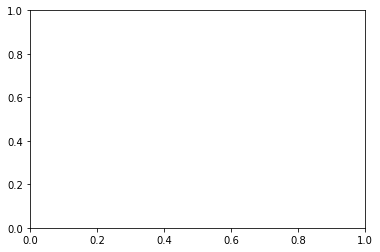

In [ ]:
#%%
fig, ax = plt.subplots(facecolor = 'white')
x = np.arange(1, epoch+1, 1)
ax.plot(x, train_epoch_loss,label='Training')
ax.plot(x, test_epoch_loss,label='Validation')
ax.legend()
ax.set_xlabel("Number of Epoch")
ax.set_ylabel("Loss")
ax.set_xticks(np.arange(0, epoch+1, 10))
ax.set_title(f'Loss: Learning_rate:{lr}')
# ax_2 = ax.twinx()
# ax_2.plot(history["lr"], "k--", lw=1)
# ax_2.set_yscale("log")
# ax.set_ylim(ax.get_ylim()[0], history["training_losses"][0])
ax.grid(axis="x")
fig.tight_layout()
fig.show()
#%%
# a = torch.zeros(1, 2, 3, 4, 5, 6)
# b = a.view(a.shape[:2], -1, a.shape[5:])
# %%
# from torchviz import make_dot
# x = torch.randn(2, 4, 56).to(device)
# m = model_torch_simple.raw_seq_model().to(device)
# y = m(x)
# make_dot(y, params=dict(list(m.named_parameters()))).render("cnn_torchviz", format="png")

# Testing

In [ ]:
testing_dataset = OneHotSeqsDataset(test_data, test_target, one_hot_dtype=torch.float, transform=True)
testing_loader = DataLoader(dataset=testing_dataset, batch_size=128, collate_fn=collate_padded_batch, num_workers=8, shuffle=True, drop_last=True)

## batch running

In [ ]:

save_path = '/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/saved_models/aa-model_weighted.pth'

# Load the saved file
checkpoint = torch.load(save_path)
ic.disable()

# Initialize the model and optimizer
model = Model(
num_classes=13,
num_filters=64,
num_conv_layers=2,
num_dense_neurons=256, # batch_size = 64
# num_dense_neurons=128, # batch_size = 64
num_dense_layers=2,
return_logits=True,
conv_dropout_rate=0,
dense_dropout_rate=0.2
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr,  weight_decay=1e-9)

# optimizer = optimizer_class(model.parameters(), ...)  # Add the necessary arguments as per your optimizer's initialization method

# Load the model and optimizer states
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])

# Make sure to call .eval() or .train() on your model depending on what you're planning to do next
model.eval()  # For inference
# or
# model.train()  # For further training


pred_list = []
target_list  = []
mse_list = []
with torch.no_grad():
    for x_test, y_test in testing_loader:
        x_batch = torch.squeeze(x_test, 0).to(device)
        x_batch = x_batch.float()
        y_batch = y_test.float().to(device)
        # print(x_batch.size())
        # y_batch = torch.Tensor.float(y).to(device)
        # x_batch = x_batch.permute(0, 3, 1, 2).to(device)
        pred = model(x_batch.float())
        pred_list.append(pred)
        target_list.append(y_batch)
        # pred = pred.unsqueeze(0)
        loss_test = criterion(y_batch, pred)
        mse_list.append(loss_test)
        # test_batch_loss.append(loss_test)
        # test_epoch_loss.append(torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy())


## Overall test

In [ ]:
testing_dataset = Dataset(test_data, test_target, one_hot_dtype=torch.float, transform=False)
testing_loader1 = DataLoader(dataset=testing_dataset, batch_size=1, collate_fn=collate_padded_batch, num_workers=8, shuffle=True, drop_last=True)

#### for in memory model

In [83]:
testing_dataset = Dataset(test_data, test_target, one_hot_dtype=torch.float, transform=False)
testing_loader1 = DataLoader(dataset=testing_dataset, batch_size=1, collate_fn=collate_padded_batch, num_workers=8, shuffle=True, drop_last=True)

model.eval()  # For inference

ic.disable()
model.eval()
pred_list = []
target_list  = []
mse_list = []
with torch.no_grad():
    for x_test, y_test in testing_loader1:
        xtest1 = x_test.to(device).float()
        ytest1 = y_test.to(device).float()
        pred = model(xtest1)
        pred_list.append(np.argmax(pred.detach().cpu().numpy())) 
        target_list.append(y_test.detach().cpu().numpy())
target_list = np.array(target_list).flatten()

TypeError: Dataset() takes no arguments

ordinal data

In [ ]:
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix

def calculate_metrics(true_labels, predictions):
    """
    Calculates accuracy, F1 score, and confusion matrix for the given true and predicted labels.

    Parameters:
    - true_labels: List or array of true labels
    - predictions: List or array of predicted labels

    Returns:
    - accuracy: Overall accuracy of predictions
    - f1: Weighted average F1 score
    - conf_matrix: Multiclass confusion matrix
    """
    # Ensure inputs are numpy arrays for consistency
    true_labels = np.array(true_labels)
    predictions = np.array(predictions)

    # Calculate accuracy
    accuracy = np.sum(true_labels == predictions) / len(true_labels)

    # Calculate F1 score
    f1 = f1_score(true_labels, predictions, average='weighted')

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(true_labels, predictions)

    return accuracy, f1, conf_matrix

# Example usage
true_labels = [0, 1, 2, 1, 0, 2, 1, 0]
predictions = [0, 2, 2, 1, 0, 0, 1, 0]

accuracy, f1, conf_matrix = calculate_metrics(target_list, pred_list)
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")


Accuracy: 0.5623342175066313
F1 Score: 0.422835023809708


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix


# First, let's write a function that accepts a list of values and a list of thresholds.
# The function will compare each value with its corresponding threshold and return a list of binary values.
thresholds = [2, 0.5, 0.5, 0.25, 8, 8, 0.8, 8, 8, 2, 2, 1, 0.25]

def threshold_binary_list(values, thresholds):
    # This function will compare values with thresholds and return a binary list
    values = np.exp(values)
    binary_list = [1 if value >= threshold else 0 for value, threshold in zip(values, thresholds)]
    return binary_list

pred_list_rs = []
target_list_rs = []

for x in tqdm(pred_list):
    pred_list_rs.append(threshold_binary_list(x[0], thresholds))
for x in tqdm(target_list):
    target_list_rs.append(threshold_binary_list(x[0], thresholds))




np.random.seed(0)  # Seed for reproducibility
y_true = np.array(target_list_rs)
y_pred = np.array(pred_list_rs)

# Initialize lists to store metrics for each column
column_accuracies = []
column_f1_scores = []
column_conf_matrices = []

# Calculate accuracy, F1 score, and confusion matrix for each column
for i in range(y_true.shape[1]):
    column_accuracies.append(accuracy_score(y_true[:, i], y_pred[:, i]))
    column_f1_scores.append(f1_score(y_true[:, i], y_pred[:, i], zero_division=0))
    column_conf_matrices.append(confusion_matrix(y_true[:, i], y_pred[:, i]))

# Calculate overall metrics for the entire matrix
overall_accuracy = accuracy_score(y_true.ravel(), y_pred.ravel())
overall_f1_score = f1_score(y_true.ravel(), y_pred.ravel(), zero_division=0)
overall_conf_matrix = confusion_matrix(y_true.ravel(), y_pred.ravel())

# Output the results
column_metrics = list(zip(column_accuracies, column_f1_scores, column_conf_matrices))
overall_metrics = (overall_accuracy, overall_f1_score, overall_conf_matrix)

column_metrics, overall_metrics

result_df = pd.DataFrame(columns=['Drugs','accuracy', 'f1_score', 'True Negative (TN)', 'False Positive (FP)','False Negative (FN)', 'True Positive (TP)'])
result_df['Drugs'] = ['AMI', 'BDQ', 'CFZ', 'DLM', 'EMB', 'ETH', 'INH', 'KAN', 'LEV', 'LZD', 'MXF', 'RIF', 'RFB']
result_df['accuracy'] = column_accuracies
result_df['f1_score'] = column_f1_scores
result_df['True Negative (TN)'] = np.array(column_conf_matrices)[:,0,0]
result_df['False Positive (FP)'] = np.array(column_conf_matrices)[:,0,1]
result_df['False Negative (FN)'] = np.array(column_conf_matrices)[:,1,0]
result_df['True Positive (TP)'] = np.array(column_conf_matrices)[:,1,1]
# print(np.array(column_conf_matrices)[:,0,0])
# print(np.array(column_conf_matrices)[:,0,1])
# print(np.array(column_conf_matrices)[:,1,0])
# print(np.array(column_conf_matrices)[:,1,1])
result_df['Sensitivity'] = result_df['True Positive (TP)'] / (result_df['True Positive (TP)'] + result_df['False Negative (FN)'])
result_df['Specificity'] = result_df['True Negative (TN)'] / (result_df['True Negative (TN)'] + result_df['False Positive (FP)'])

pred_list = np.array(pred_list).squeeze()
target_list = np.array(target_list).squeeze()
mse_list = (pred_list - target_list)**2
mse_out = np.nanmean(mse_list, axis=0)
result_df['MSE'] = mse_out

print(result_df)

#### for saved model

In [ ]:
testing_dataset = OneHotSeqsDataset(test_data, test_target, one_hot_dtype=torch.float, transform=True)
testing_loader1 = DataLoader(dataset=testing_dataset, batch_size=1, collate_fn=collate_padded_batch, num_workers=8, shuffle=True, drop_last=True)


save_path = '/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/saved_models/aa-model_weighted.pth'

# Load the saved file
checkpoint = torch.load(save_path)
ic.disable()

# Initialize the model and optimizer
model = Model(
num_classes=13,
num_filters=64,
num_conv_layers=2,
num_dense_neurons=256, # batch_size = 64
# num_dense_neurons=128, # batch_size = 64
num_dense_layers=2,
return_logits=True,
conv_dropout_rate=0,
dense_dropout_rate=0.2
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr,  weight_decay=1e-9)

# optimizer = optimizer_class(model.parameters(), ...)  # Add the necessary arguments as per your optimizer's initialization method

# Load the model and optimizer states
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])

# Make sure to call .eval() or .train() on your model depending on what you're planning to do next
model.eval()  # For inference

ic.disable()
model.eval()
pred_list = []
target_list  = []
mse_list = []
with torch.no_grad():
    for x_test, y_test in testing_loader1:
        xtest1 = x_test.to(device).float()
        ytest1 = y_test.to(device).float()
        pred = model(xtest1)
        pred_list.append(pred.detach().cpu().numpy()) 
        target_list.append(y_test.detach().cpu().numpy())

In [ ]:
# First, let's write a function that accepts a list of values and a list of thresholds.
# The function will compare each value with its corresponding threshold and return a list of binary values.

def threshold_binary_list(values, thresholds):
    # This function will compare values with thresholds and return a binary list
    values = np.exp(values)
    binary_list = [1 if value >= threshold else 0 for value, threshold in zip(values, thresholds)]
    return binary_list

# List of thresholds as per the image provided by the user
thresholds = [2, 0.5, 0.5, 0.25, 8, 8, 0.8, 8, 8, 2, 2, 1, 0.25]

# Example list of values to be checked against the thresholds
values = [3, 0.7, 0.4, 0.3, 10, 5, 1, 9, 7, 2, 3, 0.5, 0.3]  # This is a placeholder

# Get the binary list using the function defined above
binary_list = threshold_binary_list(pred_list[0][0], thresholds)
binary_list


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

### Getting accuracy and stuff

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix


# First, let's write a function that accepts a list of values and a list of thresholds.
# The function will compare each value with its corresponding threshold and return a list of binary values.
thresholds = [2, 0.5, 0.5, 0.25, 8, 8, 0.8, 8, 8, 2, 2, 1, 0.25]

def threshold_binary_list(values, thresholds):
    # This function will compare values with thresholds and return a binary list
    values = np.exp(values)
    binary_list = [1 if value >= threshold else 0 for value, threshold in zip(values, thresholds)]
    return binary_list

pred_list_rs = []
target_list_rs = []

for x in tqdm(pred_list):
    pred_list_rs.append(threshold_binary_list(x[0], thresholds))
for x in tqdm(target_list):
    target_list_rs.append(threshold_binary_list(x[0], thresholds))




np.random.seed(0)  # Seed for reproducibility
y_true = np.array(target_list_rs)
y_pred = np.array(pred_list_rs)

# Initialize lists to store metrics for each column
column_accuracies = []
column_f1_scores = []
column_conf_matrices = []

# Calculate accuracy, F1 score, and confusion matrix for each column
for i in range(y_true.shape[1]):
    column_accuracies.append(accuracy_score(y_true[:, i], y_pred[:, i]))
    column_f1_scores.append(f1_score(y_true[:, i], y_pred[:, i], zero_division=0))
    column_conf_matrices.append(confusion_matrix(y_true[:, i], y_pred[:, i]))

# Calculate overall metrics for the entire matrix
overall_accuracy = accuracy_score(y_true.ravel(), y_pred.ravel())
overall_f1_score = f1_score(y_true.ravel(), y_pred.ravel(), zero_division=0)
overall_conf_matrix = confusion_matrix(y_true.ravel(), y_pred.ravel())

# Output the results
column_metrics = list(zip(column_accuracies, column_f1_scores, column_conf_matrices))
overall_metrics = (overall_accuracy, overall_f1_score, overall_conf_matrix)

column_metrics, overall_metrics

result_df = pd.DataFrame(columns=['Drugs','accuracy', 'f1_score', 'True Negative (TN)', 'False Positive (FP)','False Negative (FN)', 'True Positive (TP)'])
result_df['Drugs'] = ['AMI', 'BDQ', 'CFZ', 'DLM', 'EMB', 'ETH', 'INH', 'KAN', 'LEV', 'LZD', 'MXF', 'RIF', 'RFB']
result_df['accuracy'] = column_accuracies
result_df['f1_score'] = column_f1_scores
result_df['True Negative (TN)'] = np.array(column_conf_matrices)[:,0,0]
result_df['False Positive (FP)'] = np.array(column_conf_matrices)[:,0,1]
result_df['False Negative (FN)'] = np.array(column_conf_matrices)[:,1,0]
result_df['True Positive (TP)'] = np.array(column_conf_matrices)[:,1,1]
# print(np.array(column_conf_matrices)[:,0,0])
# print(np.array(column_conf_matrices)[:,0,1])
# print(np.array(column_conf_matrices)[:,1,0])
# print(np.array(column_conf_matrices)[:,1,1])
result_df['Sensitivity'] = result_df['True Positive (TP)'] / (result_df['True Positive (TP)'] + result_df['False Negative (FN)'])
result_df['Specificity'] = result_df['True Negative (TN)'] / (result_df['True Negative (TN)'] + result_df['False Positive (FP)'])

pred_list = np.array(pred_list).squeeze()
target_list = np.array(target_list).squeeze()
mse_list = (pred_list - target_list)**2
mse_out = np.nanmean(mse_list, axis=0)
result_df['MSE'] = mse_out

print(result_df)

100%|██████████| 1206/1206 [00:00<00:00, 120868.12it/s]


In [ ]:
# testing_dataset = OneHotSeqsDataset(test_data, test_target, one_hot_dtype=torch.float, transform=True)
testing_loader1 = DataLoader(dataset=testing_dataset, batch_size=1, collate_fn=collate_padded_batch, num_workers=8, shuffle=True, drop_last=True)
ic.disable()
model.eval()
pred_list = []
target_list  = []
mse_list = []
with torch.no_grad():
    for x_test, y_test in testing_loader1:
        xtest1 = x_test.to(device).float()
        ytest1 = y_test.to(device).float()
        pred = model(xtest1)
        pred_list.append(pred.detach().cpu().numpy()) 
        target_list.append(y_test.detach().cpu().numpy())

## Mic calc

In [ ]:
pred_list = np.array(pred_list).squeeze()
target_list = np.array(target_list).squeeze()
mse_list = (pred_list - target_list)**2
mse_out = np.nanmean(mse_list, axis=0)
print(mse_out)
print(np.mean(mse_out))

[0.72782607 0.77394133 0.96627392 0.99732814 0.57384106 0.71862384
 1.40909006 0.62500867 0.68552988 0.42204546 0.90296875 1.86967643
 1.116575  ]
0.9068252765540421


In [ ]:
pred_list = np.array(pred_list).squeeze()
target_list = np.array(target_list).squeeze()
mse_list = (np.exp(pred_list) - np.exp(target_list))**2
mse_out = np.nanmean(mse_list, axis=0)
print(mse_out)
print(np.mean(mse_out))

[1.99657691e+01 2.19492095e-02 1.20861531e-01 1.84303685e-02
 2.18870026e+01 1.48684251e+01 1.62012543e+01 2.61311525e+01
 6.15298126e+00 2.21063227e-01 1.96245250e+00 1.24928044e+01
 9.46748127e-01]
9.30699186242598


## Ea calc

In [ ]:
def find_range_vectorized(target_values, quest_values):
    # Convert lists to numpy arrays for efficient broadcasting
    target_values =  np.exp(np.array(target_values)) # Reshape for broadcasting
    quest_values =  np.exp(np.array(quest_values))

    # Perform broadcasting to compare each quest value against all target values
    # This creates a boolean matrix where rows correspond to target values and columns to quest values
    in_range_matrix = (target_values / 2 <= quest_values) & (quest_values <= target_values * 2)
    # in_range_matrix = np.abs(np.log2(target_values) - np.log2(quest_values))
    # in_range_matrix  = in_range_matrix  <= 1
    
    # print(mse)
    return in_range_matrix
# Example usage
# target_values = [[10, 20, 30, 40, 50], [10, 20, 30, 40, 50]]
# quest_values = [[25, 5, 60, 1, 1], [10, 20, 30, 40, 50]]
result = find_range_vectorized(target_list, pred_list)

In [ ]:
np.exp(pred_list[0])

array([0.21734211, 0.04858502, 0.07807854, 0.01177044, 1.1826788 ,
       1.069281  , 0.02535057, 1.8139412 , 0.41462198, 0.45923612,
       0.28088352, 0.1602019 , 0.06000657], dtype=float32)

In [ ]:
target_values_ =  np.exp(np.array(target_list)) # Reshape for broadcasting
quest_values_ =  np.exp(np.array(pred_list))


In [ ]:
import numpy as np
from sklearn.metrics import f1_score, accuracy_score


for i in range(result.shape[0]):
    f1 = f1_score(y_true, result[i, :])
    accuracy = accuracy_score(y_true, result[i, :])
    print(f"Model {i+1} - F1 Score: {f1}, Accuracy: {accuracy}")


NameError: name 'y_true' is not defined

In [ ]:
def EA_calc(target_matrix: np.array):
    drugs = ['AMI', 'BDQ', 'CFZ', 'DLM', 'EMB', 'ETH', 'INH', 'KAN', 'LEV', 'LZD', 'MXF', 'RIF', 'RFB']
    for x, drug in zip(range(target_matrix.shape[1]), drugs):
        ea_count = len([item for item in target_matrix[:,x] if item == True])
        ea_rate = (ea_count / len(target_matrix[:,x])) * 100
        print(drug, ea_rate)
        
def MSE_calc(target_matrix: np.array):
    drugs = ['AMI', 'BDQ', 'CFZ', 'DLM', 'EMB', 'ETH', 'INH', 'KAN', 'LEV', 'LZD', 'MXF', 'RIF', 'RFB']
    for x, drug in zip(range(target_matrix.shape[1]), drugs):
        mse = np.mean(target_matrix[:,x])
        print(drug, mse)
        

# Explanable AI

### Sensitivity analysis

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Assume `input_data` is your input tensor, and `feature_index` is the index of the feature to perturb
perturbation_range = np.linspace(0, 1, num=20)  # Example range of perturbation
original_value = input_data[0, feature_index].item()  # Store original value

output_changes = np.zeros((len(perturbation_range), 13))  # Store changes in outputs

for i, perturb in enumerate(perturbation_range):
    input_data[0, feature_index] = original_value + perturb  # Perturb feature value
    with torch.no_grad():
        outputs = model(input_data).numpy()  # Get model output
    output_changes[i] = outputs  # Record the change

# Reset the perturbed feature to its original value
input_data[0, feature_index] = original_value

# Example analysis for one output
plt.figure(figsize=(10, 6))
for output_index in range(13):
    plt.plot(perturbation_range, output_changes[:, output_index], label=f'Output {output_index+1}')

plt.xlabel('Perturbation')
plt.ylabel('Output Change')
plt.title('Sensitivity Analysis of Feature X on All Outputs')
plt.legend()
plt.show()


### SHAP

In [ ]:
import torch
import numpy as np

def model_wrapper(x):
    with torch.no_grad():
        # Convert the input numpy array to a PyTorch tensor
        tensor_x = torch.tensor(x, dtype=torch.float32)
        # Make a prediction with your model
        model_output = model(tensor_x)
        # Convert the prediction back to a numpy array
        return model_output.numpy()


In [ ]:
import shap

# Sample data for initialization (e.g., a batch from your training data)
X_sample = np.array([...])  # Replace with your actual numpy array

# Initialize the explainer
explainer = shap.KernelExplainer(model_wrapper, X_sample)

# Choose the instance you want to explain
X_instance = np.array([...])  # Replace with the instance in numpy array format

# Calculate SHAP values
shap_values = explainer.shap_values(X_instance)

# Plotting the SHAP values
shap.initjs()  # Initializes JavaScript visualization in Jupyter Notebooks
shap.force_plot(explainer.expected_value, shap_values, X_instance)


### Counterfactual

In [ ]:
### SHAP